In [1]:
# import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import sys
sys.path.extend(["..", "../../backbone","../.."])
from backbones import DenseNet201b
from dataloader import create_dataloader
from metric import Metric
from ievit_dpd2 import IEViT
from sklearn.metrics import roc_curve, auc
from tabulate import tabulate
from tqdm import tqdm

# from cam_generate import cam_generate
torch.cuda.empty_cache()

# Set device to GPU if available, else use CPU
# device = torch.device("cuda:0")
device = torch.device("cuda")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

Current device: NVIDIA A100 80GB PCIe


In [2]:
# Define hyperparameters
batch_size = 16
num_epochs = 200
learning_rate = 0.000001
in_channel = 3
image_size = 384
# patch_size = 16p
patch_size = 32
num_workers = 4
embed_dim = 960
mlp_dim = 1024
dim_feedforward = 1024
num_layers = 12
num_labels = 21
thresholds = [0.5] * num_labels
num_classes = 21
dropout = 0.1
data_dir = '../../../../data/GT-main'

In [3]:
# Create dataloaders (image.shape = torch.Size([batch_size, channel_no, H, W])
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')
test_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='test')

384
../../../../data/GT-main/./set1/train.csv
384
../../../../data/GT-main/./set1/val.csv
384
../../../../data/GT-main/./set1/test.csv


In [4]:
# Define model and optimizer
backbone = DenseNet201b(embed_dim, dropout)

# create an instance of IEVIT
model = IEViT(img_size= image_size, patch_size = patch_size, in_channels = in_channel, num_classes = num_classes, embed_dim = embed_dim, 
num_heads = num_workers, num_layers = num_layers, dim_feedforward = dim_feedforward, mlp_dim = mlp_dim, backbone=backbone, dropout = 0.1, device = device)
model.to(device)
num_params = sum(p.numel() for p in model.parameters())
print(num_params)

criterion = nn.BCEWithLogitsLoss()

# model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])
# model.sigma = nn.Parameter(model.sigma, requires_grad=True)
# model.mean = nn.Parameter(model.mean, requires_grad=True)
params_to_optimize = [
    {"params": [param for name, param in model.named_parameters() if 'sigma' not in name and 'mean' not in name], "lr": 5e-5},
    {"params": [param for name, param in model.named_parameters() if 'sigma' in name and 'mean' in name], "lr": 100}
    # {"params": model.sigma, "lr": 5e-2},
    # {"params": model.mean, "lr": 5e-1}
]

optimizer = torch.optim.AdamW(params_to_optimize, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

/home/deependra/project/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deependra/project/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/deependra/project/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but se

249104565


In [5]:
# Initialize Metric class
metric = Metric(num_classes=num_classes)
imp_w = None
loss1 = torch.tensor(0).to(device)
MS, FS = 0.91, 0.7
thresholds = None
# torch.autograd.set_detect_anomaly(True)
# create empty lists to store predicted probabilities and true labels for each epoch
test_preds_all, test_labels_all = [], []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []
model_arr = []
max_ms = [0,0,0]

# with torch.autograd.detect_anomaly():
# Train and evaluate model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train phase
    model.train()
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs, kld = model(images)
        
        loss1 = criterion(outputs, labels) 
        loss = loss1 + kld*0.01
        outputs = torch.sigmoid(outputs)
        # print(loss1.item(), kld.item(), loss.item())  
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward(retain_graph=True)  
        optimizer.step()
        optimizer.zero_grad()

        # Compute metrics on train set
        with torch.no_grad(): metric.update(outputs, labels)
    
     # Print metrics on train set
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score, acc_list, spec_list, thresh = metric.compute()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    print(thresh)
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}') 
    # Reset Metric class for evaluation
    metric.reset()
    torch.cuda.empty_cache()

    # Evaluate model on validation set
    model.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs, kld = model(images)
            running_loss += criterion(outputs, labels).item() + 0.01*kld
            outputs = torch.sigmoid(outputs)

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            val_preds += outputs.tolist()
            val_labels += labels.tolist()
            
            # Compute metrics on validation set
            metric.update(outputs, labels)

       # Print metrics on validation set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score,  acc_list, spec_list, thresh = metric.compute()
        print(f"Val - Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        # Reset Metric class for next epoch
        metric.reset()
        del images
        del labels
        del outputs
        torch.cuda.empty_cache()   
    print(thresh)   
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}')
    
     # Evaluate model on test set
    running_loss = 0.0
    test_preds, test_labels = [], []
    
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images, labels = images.to(device), labels.to(device)
 
            outputs, kld = model(images)
            running_loss += criterion(outputs, labels).item() + 0.01*kld
            outputs = torch.sigmoid(outputs)
            metric.update(outputs, labels)

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            test_preds += outputs.tolist()
            test_labels += labels.tolist()
 
        # Print metrics on test set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score,  acc_list, spec_list, thresh = metric.compute(thresholds = thresh)
        print(f"Test - Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        f1_arr.append(ml_f1_score)
        model_arr.append(model_score)
        loss_arr.append(running_loss / len(test_dataloader))
        
        if model_score > MS and ml_f1_score > FS:
            torch.save(model, 'models/dpd-god.pth')
            model_score, ml_f1_score = MS, FS
            
        f1_arr.append(ml_f1_score)
        model_arr.append(model_score)
        loss_arr.append(running_loss / len(val_dataloader))
        
        if max_ms[0] < model_score: 
            max_ms[0] = model_score
            max_ms[1] = epoch
            max_ms[2] = optimizer.param_groups[0]['lr']
            torch.save(model, 'models/dpd-rfmid.pth')

        # append the predicted probabilities and true labels for this epoch to the lists for all epochs
        test_preds_all.append(test_preds)
        test_labels_all.append(test_labels)

        # check if the current epoch is in the list of epochs to plot ROC curve
        if epoch+1 in roc_epochs:
            # calculate ROC curve and AUC score for test set
            fpr, tpr, roc_thresholds = roc_curve(np.concatenate(test_labels_all).ravel(), np.concatenate(test_preds_all).ravel())
            roc_fpr.append(fpr)
            roc_tpr.append(tpr)
            roc_auc.append(auc(fpr, tpr))
        # Reset Metric class for next epoch
        metric.reset()
        del images
        del labels
        del outputs
        torch.cuda.empty_cache()     
        
    print(thresh)
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}') 
    print()   
    # Step the learning rate scheduler
    scheduler.step()      
    print(model.sigma.item(), model.mean.item())
print(MS, FS)

Epoch 1/200
----------


100%|██████████| 132/132 [02:51<00:00,  1.30s/it]


Epoch [1/200], Loss: 0.2556, ML mAP: 0.0750, ML F1: 0.5735, ML AUC: 0.5150, ML Score: 0.2950, Bin AUC: 0.6500, Model Score: 0.4725, Bin F1: 1.0000
[0.4  0.53 0.89 0.31 0.15 0.24 0.46 0.43 0.45 0.54 0.67 0.72 0.31 0.8
 0.86 0.46 0.87 0.74 0.79 0.4  0.77]
Accuracy list: [0.8057142857142857, 0.9523809523809523, 0.9328571428571428, 0.82, 0.7823809523809524, 0.7614285714285715, 0.8357142857142857, 0.8528571428571429, 0.8466666666666667, 0.9371428571428572, 0.9442857142857143, 0.9257142857142857, 0.8509523809523809, 0.9547619047619048, 0.94, 0.8552380952380952, 0.9280952380952381, 0.939047619047619, 0.9485714285714286, 0.8485714285714285, 0.9471428571428572]
Specificity list: [0.9061135371179039, 0.9995002498750625, 0.9994897959183674, 0.8902310924369747, 0.8345435684647303, 0.8487486398258978, 0.8986032074495602, 0.8973191704602934, 0.893455098934551, 0.9979716024340771, 0.9994959677419355, 0.9984591679506933, 0.8891675025075225, 0.9995014955134596, 0.9984825493171472, 0.8961364776718515, 0

100%|██████████| 28/28 [00:29<00:00,  1.05s/it]


Val - Epoch [1/200], Loss: 6.8478, ML mAP: 0.2435, ML F1: 0.2456, ML AUC: 0.7968, ML Score: 0.5201, Bin AUC: 0.4000, Model Score: 0.4601, Bin F1: 0.0000
[0.18 0.07 0.1  0.11 0.05 0.32 0.07 0.08 0.11 0.1  0.03 0.18 0.05 0.01
 0.09 0.07 0.13 0.06 0.08 0.11 0.07]
Accuracy list: [0.7522321428571429, 0.8258928571428571, 0.7522321428571429, 0.921875, 0.8861607142857143, 0.8928571428571429, 0.9397321428571429, 0.9508928571428571, 0.9107142857142857, 0.984375, 0.9732142857142857, 0.9508928571428571, 0.9776785714285714, 0.8549107142857143, 0.9665178571428571, 0.984375, 0.9776785714285714, 0.8705357142857143, 0.9910714285714286, 0.7790178571428571, 0.9776785714285714]
Specificity list: [0.8319327731092437, 0.9972451790633609, 0.7635933806146572, 0.9777777777777777, 0.9131455399061033, 0.9518072289156626, 0.9929078014184397, 0.9859484777517564, 0.9370629370629371, 1.0, 1.0, 0.9522727272727273, 1.0, 0.8532110091743119, 0.9954022988505747, 1.0, 0.9909297052154195, 0.8733031674208145, 1.0, 0.8333333

100%|██████████| 28/28 [00:30<00:00,  1.08s/it]


Test - Epoch [1/200], Loss: 6.8595, ML mAP: 0.2365, ML F1: 0.3826, ML AUC: 0.7855, ML Score: 0.5110, Bin AUC: 0.4000, Model Score: 0.4555, Bin F1: 0.0000
[0.18 0.07 0.1  0.11 0.05 0.32 0.07 0.08 0.11 0.1  0.03 0.18 0.05 0.01
 0.09 0.07 0.13 0.06 0.08 0.11 0.07]
Accuracy list: [0.75, 0.8558558558558559, 0.7747747747747747, 0.8761261261261262, 0.8963963963963963, 0.8873873873873874, 0.9369369369369369, 0.9617117117117117, 0.8963963963963963, 0.972972972972973, 0.9774774774774775, 0.9527027027027027, 0.9707207207207207, 0.8265765765765766, 0.9797297297297297, 0.9819819819819819, 0.9774774774774775, 0.8941441441441441, 0.9842342342342343, 0.7477477477477478, 0.9797297297297297]
Specificity list: [0.8426966292134831, 0.994535519125683, 0.7831325301204819, 0.9522613065326633, 0.918854415274463, 0.9534313725490197, 0.983451536643026, 0.9905437352245863, 0.9207459207459208, 1.0, 1.0, 0.9632183908045977, 1.0, 0.8267898383371824, 0.9931506849315068, 1.0, 0.9886104783599089, 0.8931818181818182, 0

100%|██████████| 132/132 [02:56<00:00,  1.33s/it]


Epoch [2/200], Loss: 0.2697, ML mAP: 0.0885, ML F1: 0.1375, ML AUC: 0.5897, ML Score: 0.3391, Bin AUC: 0.8000, Model Score: 0.5696, Bin F1: 1.0000
[0.25 0.1  0.19 0.18 0.16 0.2  0.13 0.16 0.21 0.18 0.17 0.11 0.13 0.09
 0.16 0.1  0.1  0.12 0.11 0.24 0.12]
Accuracy list: [0.7333333333333333, 0.849047619047619, 0.8133333333333334, 0.7871428571428571, 0.8047619047619048, 0.7366666666666667, 0.8252380952380952, 0.8219047619047619, 0.8533333333333334, 0.8142857142857143, 0.8557142857142858, 0.7795238095238095, 0.861904761904762, 0.8380952380952381, 0.8552380952380952, 0.8304761904761905, 0.7690476190476191, 0.8128571428571428, 0.8028571428571428, 0.8433333333333334, 0.8742857142857143]
Specificity list: [0.8106185002736727, 0.8810353409656545, 0.866974833076528, 0.8491854965843405, 0.8524080787156914, 0.7919137466307278, 0.8758937691521961, 0.8658163265306122, 0.9046653144016227, 0.868080703569581, 0.9024759979787772, 0.7958354494667343, 0.8991512730903645, 0.8675363773206222, 0.898484848484

100%|██████████| 28/28 [00:26<00:00,  1.06it/s]


Val - Epoch [2/200], Loss: 6.7553, ML mAP: 0.2453, ML F1: 0.5812, ML AUC: 0.8212, ML Score: 0.5332, Bin AUC: 0.0500, Model Score: 0.2916, Bin F1: 0.0000
[0.21 0.03 0.17 0.09 0.08 0.24 0.09 0.06 0.09 0.2  0.08 0.16 0.08 0.16
 0.09 0.03 0.13 0.3  0.1  0.05 0.05]
Accuracy list: [0.7946428571428571, 0.7879464285714286, 0.9375, 0.859375, 0.9486607142857143, 0.8526785714285714, 0.7745535714285714, 0.9375, 0.9486607142857143, 0.984375, 0.9754464285714286, 0.9196428571428571, 0.9754464285714286, 0.9709821428571429, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9888392857142857, 0.8191964285714286, 0.9866071428571429]
Specificity list: [0.9971988795518207, 0.7961432506887053, 0.9929078014184397, 0.9135802469135802, 0.9976525821596244, 0.9012048192771084, 0.7848699763593381, 0.9391100702576113, 0.9883449883449883, 0.9954648526077098, 0.9977064220183486, 0.9181818181818182, 0.997716894977169, 0.9977064220183486, 0.9839080459770115, 1.0, 0.9886621315192744, 0.995475113122

100%|██████████| 28/28 [00:27<00:00,  1.03it/s]


Test - Epoch [2/200], Loss: 6.7666, ML mAP: 0.2850, ML F1: 0.3439, ML AUC: 0.8215, ML Score: 0.5532, Bin AUC: 0.0500, Model Score: 0.3016, Bin F1: 0.0000
[0.21 0.03 0.17 0.09 0.08 0.24 0.09 0.06 0.09 0.2  0.08 0.16 0.08 0.16
 0.09 0.03 0.13 0.3  0.1  0.05 0.05]
Accuracy list: [0.7995495495495496, 0.7454954954954955, 0.9279279279279279, 0.8716216216216216, 0.9481981981981982, 0.8513513513513513, 0.7815315315315315, 0.9391891891891891, 0.954954954954955, 0.9504504504504504, 0.9684684684684685, 0.9121621621621622, 0.9707207207207207, 0.9797297297297297, 0.9572072072072072, 0.9819819819819819, 0.9752252252252253, 0.990990990990991, 0.9842342342342343, 0.7927927927927928, 0.9819819819819819]
Specificity list: [0.9887640449438202, 0.7486338797814208, 0.9879518072289156, 0.9296482412060302, 0.9976133651551312, 0.9068627450980392, 0.7943262411347518, 0.9385342789598109, 0.9883449883449883, 0.9745370370370371, 0.988479262672811, 0.9149425287356322, 1.0, 1.0, 0.9680365296803652, 1.0, 0.986332574

100%|██████████| 132/132 [03:03<00:00,  1.39s/it]


Epoch [3/200], Loss: 0.3438, ML mAP: 0.1165, ML F1: 0.2121, ML AUC: 0.6973, ML Score: 0.4069, Bin AUC: 0.6500, Model Score: 0.5284, Bin F1: 1.0000
[0.18 0.15 0.14 0.16 0.17 0.2  0.16 0.13 0.12 0.13 0.15 0.12 0.12 0.11
 0.09 0.1  0.15 0.13 0.12 0.15 0.08]
Accuracy list: [0.7152380952380952, 0.8552380952380952, 0.7495238095238095, 0.7561904761904762, 0.7633333333333333, 0.7638095238095238, 0.789047619047619, 0.8161904761904762, 0.8438095238095238, 0.8238095238095238, 0.8419047619047619, 0.7819047619047619, 0.8385714285714285, 0.839047619047619, 0.7571428571428571, 0.84, 0.8252380952380952, 0.8071428571428572, 0.8442857142857143, 0.8285714285714286, 0.8538095238095238]
Specificity list: [0.7605405405405405, 0.8863409770687937, 0.7771428571428571, 0.7977941176470589, 0.7802950474183351, 0.7946912242686891, 0.8353184878301398, 0.8429878048780488, 0.8891700404858299, 0.8620515411824153, 0.8815524193548387, 0.7737003058103975, 0.8731117824773413, 0.853220169745382, 0.7773279352226721, 0.86579

100%|██████████| 28/28 [00:26<00:00,  1.06it/s]


Val - Epoch [3/200], Loss: 6.1576, ML mAP: 0.2599, ML F1: 0.7924, ML AUC: 0.8500, ML Score: 0.5549, Bin AUC: 0.1000, Model Score: 0.3275, Bin F1: 0.0000
[0.14 0.07 0.16 0.28 0.32 0.26 0.12 0.1  0.08 0.12 0.15 0.23 0.07 0.13
 0.11 0.12 0.12 0.16 0.07 0.16 0.06]
Accuracy list: [0.8258928571428571, 0.8125, 0.9419642857142857, 0.8995535714285714, 0.9464285714285714, 0.9174107142857143, 0.9397321428571429, 0.9308035714285714, 0.8616071428571429, 0.9799107142857143, 0.96875, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.9397321428571429, 0.9642857142857143, 0.9776785714285714, 0.9821428571428571, 0.9776785714285714, 0.8928571428571429, 0.9575892857142857]
Specificity list: [0.9103641456582633, 0.8236914600550964, 0.9976359338061466, 0.9950617283950617, 0.9953051643192489, 0.9903614457831326, 0.9952718676122931, 0.936768149882904, 0.8787878787878788, 0.9909297052154195, 0.9954128440366973, 0.9954545454545455, 0.9954337899543378, 0.9977064220183486, 0.967816091954023, 0.9795918

100%|██████████| 28/28 [00:27<00:00,  1.01it/s]


Test - Epoch [3/200], Loss: 6.1162, ML mAP: 0.3282, ML F1: 0.4152, ML AUC: 0.8557, ML Score: 0.5919, Bin AUC: 0.4500, Model Score: 0.5210, Bin F1: 1.0000
[0.14 0.07 0.16 0.28 0.32 0.26 0.12 0.1  0.08 0.12 0.15 0.23 0.07 0.13
 0.11 0.12 0.12 0.16 0.07 0.16 0.06]
Accuracy list: [0.8558558558558559, 0.7837837837837838, 0.9391891891891891, 0.8918918918918919, 0.9459459459459459, 0.9144144144144144, 0.9527027027027027, 0.9391891891891891, 0.8603603603603603, 0.9617117117117117, 0.9819819819819819, 0.9752252252252253, 0.9684684684684685, 0.9774774774774775, 0.963963963963964, 0.9617117117117117, 0.9752252252252253, 0.990990990990991, 0.9684684684684685, 0.8986486486486487, 0.9864864864864865]
Specificity list: [0.9129213483146067, 0.7950819672131147, 1.0, 0.9949748743718593, 0.9976133651551312, 0.9926470588235294, 1.0, 0.9385342789598109, 0.8694638694638694, 0.9861111111111112, 1.0, 0.9954022988505747, 0.9953596287703016, 0.9976905311778291, 0.9748858447488584, 0.9793577981651376, 0.98633257

100%|██████████| 132/132 [02:31<00:00,  1.15s/it]


Epoch [4/200], Loss: 0.2182, ML mAP: 0.1404, ML F1: 0.2582, ML AUC: 0.7601, ML Score: 0.4502, Bin AUC: 1.0000, Model Score: 0.7251, Bin F1: 0.6667
[0.23 0.13 0.16 0.2  0.21 0.23 0.12 0.13 0.11 0.13 0.15 0.15 0.15 0.13
 0.1  0.1  0.13 0.15 0.1  0.15 0.15]
Accuracy list: [0.7847619047619048, 0.8480952380952381, 0.7957142857142857, 0.790952380952381, 0.8228571428571428, 0.7771428571428571, 0.7728571428571429, 0.8361904761904762, 0.8166666666666667, 0.7671428571428571, 0.82, 0.8033333333333333, 0.8323809523809523, 0.8557142857142858, 0.8280952380952381, 0.8076190476190476, 0.7804761904761904, 0.7985714285714286, 0.85, 0.8228571428571428, 0.8819047619047619]
Specificity list: [0.8368563685636856, 0.8750624687656172, 0.8281008749356665, 0.832810867293626, 0.8428128231644261, 0.810840108401084, 0.808868501529052, 0.8406537282941777, 0.8505050505050505, 0.7929627740948496, 0.8569238630556975, 0.7978505629477994, 0.865588681152097, 0.8595873175641671, 0.8468106479156203, 0.8189094547273637, 0.7

100%|██████████| 28/28 [00:18<00:00,  1.50it/s]


Val - Epoch [4/200], Loss: 5.5164, ML mAP: 0.3339, ML F1: 0.7566, ML AUC: 0.8666, ML Score: 0.6002, Bin AUC: 1.0000, Model Score: 0.8001, Bin F1: 0.0000
[0.24 0.18 0.15 0.2  0.24 0.13 0.13 0.16 0.09 0.23 0.12 0.2  0.16 0.14
 0.09 0.13 0.26 0.17 0.12 0.12 0.09]
Accuracy list: [0.8794642857142857, 0.8058035714285714, 0.9419642857142857, 0.8995535714285714, 0.9486607142857143, 0.8258928571428571, 0.9330357142857143, 0.9486607142857143, 0.8392857142857143, 0.9866071428571429, 0.9553571428571429, 0.9352678571428571, 0.9732142857142857, 0.9709821428571429, 0.96875, 0.9799107142857143, 0.9397321428571429, 0.9821428571428571, 0.9888392857142857, 0.8459821428571429, 1.0]
Specificity list: [0.9495798319327731, 0.9944903581267218, 0.9976359338061466, 0.9950617283950617, 0.9976525821596244, 0.8650602409638555, 0.9881796690307328, 0.9953161592505855, 0.8531468531468531, 1.0, 0.9610091743119266, 0.9340909090909091, 0.9954337899543378, 0.9977064220183486, 0.9977011494252873, 0.9954648526077098, 0.945

100%|██████████| 28/28 [00:18<00:00,  1.54it/s]


Test - Epoch [4/200], Loss: 5.5060, ML mAP: 0.3422, ML F1: 0.4757, ML AUC: 0.8661, ML Score: 0.6041, Bin AUC: 0.9500, Model Score: 0.7771, Bin F1: 0.0000
[0.24 0.18 0.15 0.2  0.24 0.13 0.13 0.16 0.09 0.23 0.12 0.2  0.16 0.14
 0.09 0.13 0.26 0.17 0.12 0.12 0.09]
Accuracy list: [0.8581081081081081, 0.8198198198198198, 0.9346846846846847, 0.8918918918918919, 0.9459459459459459, 0.8400900900900901, 0.9391891891891891, 0.9617117117117117, 0.8423423423423423, 0.9707207207207207, 0.9752252252252253, 0.9301801801801802, 0.9684684684684685, 0.9797297297297297, 0.9819819819819819, 0.9752252252252253, 0.9414414414414415, 0.9887387387387387, 0.9887387387387387, 0.8423423423423423, 0.9977477477477478]
Specificity list: [0.9129213483146067, 0.994535519125683, 0.9951807228915662, 0.9949748743718593, 0.9976133651551312, 0.8823529411764706, 0.983451536643026, 0.9976359338061466, 0.8578088578088578, 0.9953703703703703, 0.9907834101382489, 0.9356321839080459, 0.9976798143851509, 0.9976905311778291, 0.995

100%|██████████| 132/132 [01:49<00:00,  1.20it/s]


Epoch [5/200], Loss: 0.2554, ML mAP: 0.1608, ML F1: 0.3016, ML AUC: 0.7862, ML Score: 0.4735, Bin AUC: 0.7500, Model Score: 0.6118, Bin F1: 1.0000
[0.21 0.09 0.17 0.16 0.25 0.19 0.12 0.14 0.13 0.16 0.14 0.17 0.14 0.19
 0.14 0.12 0.15 0.15 0.16 0.14 0.19]
Accuracy list: [0.7952380952380952, 0.8076190476190476, 0.7876190476190477, 0.7766666666666666, 0.8223809523809524, 0.7733333333333333, 0.7671428571428571, 0.829047619047619, 0.7976190476190477, 0.790952380952381, 0.7904761904761904, 0.7980952380952381, 0.8361904761904762, 0.8847619047619047, 0.8304761904761905, 0.8057142857142857, 0.8028571428571428, 0.789047619047619, 0.8580952380952381, 0.8171428571428572, 0.9038095238095238]
Specificity list: [0.8119565217391305, 0.8197127290737989, 0.8093023255813954, 0.7960457856399584, 0.8469917012448133, 0.7895866881374127, 0.8040226921093347, 0.829107505070994, 0.8329101066531234, 0.8194373401534527, 0.7994897959183673, 0.790650406504065, 0.8623115577889447, 0.8830908178625189, 0.8442415017757

100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Val - Epoch [5/200], Loss: 5.3377, ML mAP: 0.3582, ML F1: 0.6822, ML AUC: 0.8894, ML Score: 0.6238, Bin AUC: 1.0000, Model Score: 0.8119, Bin F1: 0.0000
[0.12 0.18 0.35 0.26 0.41 0.16 0.09 0.28 0.13 0.12 0.07 0.22 0.2  0.35
 0.21 0.21 0.14 0.25 0.19 0.1  0.09]
Accuracy list: [0.8816964285714286, 0.8058035714285714, 0.9419642857142857, 0.8928571428571429, 0.9486607142857143, 0.8236607142857143, 0.8839285714285714, 0.9508928571428571, 0.953125, 0.984375, 0.9642857142857143, 0.9285714285714286, 0.9754464285714286, 0.9709821428571429, 0.96875, 0.9821428571428571, 0.9308035714285714, 0.9821428571428571, 0.9888392857142857, 0.9040178571428571, 1.0]
Specificity list: [0.9327731092436975, 0.9944903581267218, 0.9976359338061466, 0.9333333333333333, 0.9976525821596244, 0.8361445783132531, 0.9243498817966903, 0.9976580796252927, 0.9766899766899767, 0.9977324263038548, 0.9678899082568807, 0.9272727272727272, 0.997716894977169, 0.9977064220183486, 0.9977011494252873, 0.9977324263038548, 0.936507936

100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Test - Epoch [5/200], Loss: 5.2995, ML mAP: 0.3894, ML F1: 0.4000, ML AUC: 0.8861, ML Score: 0.6378, Bin AUC: 0.8500, Model Score: 0.7439, Bin F1: 1.0000
[0.12 0.18 0.35 0.26 0.41 0.16 0.09 0.28 0.13 0.12 0.07 0.22 0.2  0.35
 0.21 0.21 0.14 0.25 0.19 0.1  0.09]
Accuracy list: [0.8828828828828829, 0.8243243243243243, 0.9369369369369369, 0.8693693693693694, 0.9459459459459459, 0.8288288288288288, 0.9031531531531531, 0.9527027027027027, 0.963963963963964, 0.963963963963964, 0.9752252252252253, 0.9346846846846847, 0.9707207207207207, 0.9797297297297297, 0.9842342342342343, 0.9797297297297297, 0.9436936936936937, 0.990990990990991, 0.9864864864864865, 0.8896396396396397, 0.9977477477477478]
Specificity list: [0.9185393258426966, 1.0, 1.0, 0.9321608040201005, 1.0, 0.8382352941176471, 0.9408983451536643, 0.9976359338061466, 0.9790209790209791, 0.9907407407407407, 0.9792626728110599, 0.9379310344827586, 1.0, 1.0, 0.997716894977169, 0.9977064220183486, 0.9521640091116174, 0.9977272727272727, 1.

100%|██████████| 132/132 [01:27<00:00,  1.51it/s]


Epoch [6/200], Loss: 0.2528, ML mAP: 0.2010, ML F1: 0.3725, ML AUC: 0.8137, ML Score: 0.5073, Bin AUC: 0.8500, Model Score: 0.6787, Bin F1: 1.0000
[0.27 0.09 0.18 0.16 0.52 0.16 0.15 0.25 0.1  0.16 0.18 0.2  0.11 0.26
 0.16 0.16 0.12 0.14 0.16 0.11 0.5 ]
Accuracy list: [0.8252380952380952, 0.7871428571428571, 0.7947619047619048, 0.7904761904761904, 0.9171428571428571, 0.7519047619047619, 0.8076190476190476, 0.8519047619047619, 0.7933333333333333, 0.8080952380952381, 0.8609523809523809, 0.8219047619047619, 0.82, 0.9023809523809524, 0.85, 0.8247619047619048, 0.7604761904761905, 0.8047619047619048, 0.8528571428571429, 0.8295238095238096, 0.9766666666666667]
Specificity list: [0.8528761061946902, 0.7848227658512231, 0.8123393316195373, 0.7978113600833767, 0.9994810586403736, 0.7393906420021763, 0.8489503328213006, 0.8615776081424936, 0.8119959677419355, 0.8383991894630193, 0.8849872773536895, 0.8156822810590632, 0.8267401101652478, 0.8995983935742972, 0.8588115794819705, 0.8306532663316583

100%|██████████| 28/28 [00:12<00:00,  2.15it/s]


Val - Epoch [6/200], Loss: 5.1653, ML mAP: 0.3891, ML F1: 0.7505, ML AUC: 0.8965, ML Score: 0.6428, Bin AUC: 0.8000, Model Score: 0.7214, Bin F1: 0.0000
[0.18 0.13 0.2  0.37 0.37 0.2  0.07 0.27 0.18 0.26 0.23 0.31 0.38 0.3
 0.24 0.24 0.2  0.17 0.31 0.13 0.14]
Accuracy list: [0.890625, 0.8058035714285714, 0.9419642857142857, 0.9017857142857143, 0.9486607142857143, 0.8258928571428571, 0.734375, 0.9508928571428571, 0.9709821428571429, 0.9821428571428571, 0.9754464285714286, 0.9375, 0.9754464285714286, 0.9709821428571429, 0.96875, 0.9799107142857143, 0.9330357142857143, 0.9776785714285714, 0.9888392857142857, 0.9040178571428571, 0.9977678571428571]
Specificity list: [0.9467787114845938, 0.9944903581267218, 0.9976359338061466, 0.9975308641975309, 0.9976525821596244, 0.8313253012048193, 0.7423167848699763, 0.9976580796252927, 0.9953379953379954, 0.9977324263038548, 0.9885321100917431, 0.9363636363636364, 0.997716894977169, 0.9977064220183486, 0.9977011494252873, 0.9954648526077098, 0.9387755

100%|██████████| 28/28 [00:14<00:00,  1.99it/s]


Test - Epoch [6/200], Loss: 5.1114, ML mAP: 0.4158, ML F1: 0.5242, ML AUC: 0.8923, ML Score: 0.6540, Bin AUC: 0.6500, Model Score: 0.6520, Bin F1: 0.0000
[0.18 0.13 0.2  0.37 0.37 0.2  0.07 0.27 0.18 0.26 0.23 0.31 0.38 0.3
 0.24 0.24 0.2  0.17 0.31 0.13 0.14]
Accuracy list: [0.8851351351351351, 0.8220720720720721, 0.9346846846846847, 0.8941441441441441, 0.9481981981981982, 0.8445945945945946, 0.7297297297297297, 0.9617117117117117, 0.9774774774774775, 0.9684684684684685, 0.9842342342342343, 0.9572072072072072, 0.9707207207207207, 0.9797297297297297, 0.9842342342342343, 0.9797297297297297, 0.972972972972973, 0.9887387387387387, 0.9864864864864865, 0.8986486486486487, 0.990990990990991]
Specificity list: [0.9353932584269663, 0.9972677595628415, 0.9951807228915662, 0.9974874371859297, 0.9976133651551312, 0.8504901960784313, 0.7446808510638298, 0.9952718676122931, 0.9953379953379954, 0.9953703703703703, 0.9861751152073732, 0.960919540229885, 1.0, 0.9976905311778291, 0.997716894977169, 0.9

100%|██████████| 132/132 [01:26<00:00,  1.52it/s]


Epoch [7/200], Loss: 0.2212, ML mAP: 0.2463, ML F1: 0.4365, ML AUC: 0.8364, ML Score: 0.5414, Bin AUC: 0.9500, Model Score: 0.7457, Bin F1: 0.6667
[0.24 0.11 0.2  0.2  0.56 0.25 0.13 0.21 0.12 0.13 0.15 0.5  0.16 0.5
 0.16 0.16 0.18 0.15 0.14 0.12 0.5 ]
Accuracy list: [0.8304761904761905, 0.8176190476190476, 0.8166666666666667, 0.789047619047619, 0.9271428571428572, 0.800952380952381, 0.8071428571428572, 0.8723809523809524, 0.8347619047619048, 0.7604761904761905, 0.8623809523809524, 0.9304761904761905, 0.8571428571428571, 0.9652380952380952, 0.8447619047619047, 0.8342857142857143, 0.8033333333333333, 0.8023809523809524, 0.8690476190476191, 0.7852380952380953, 0.991904761904762]
Specificity list: [0.8489010989010989, 0.8267990074441688, 0.8371134020618557, 0.8071654373024236, 0.9994866529774127, 0.8123989218328841, 0.8476923076923077, 0.8725241239207719, 0.8532388663967612, 0.7628600823045267, 0.8701560140915954, 0.9994884910485934, 0.8688279301745636, 0.998992443324937, 0.8454130765331

100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


Val - Epoch [7/200], Loss: 4.9519, ML mAP: 0.4137, ML F1: 0.8526, ML AUC: 0.9052, ML Score: 0.6594, Bin AUC: 0.8500, Model Score: 0.7547, Bin F1: 0.0000
[0.14 0.17 0.24 0.29 0.31 0.11 0.23 0.13 0.12 0.33 0.19 0.24 0.27 0.36
 0.29 0.3  0.32 0.42 0.37 0.17 0.08]
Accuracy list: [0.8928571428571429, 0.8080357142857143, 0.9419642857142857, 0.9017857142857143, 0.9486607142857143, 0.8415178571428571, 0.9397321428571429, 0.9776785714285714, 0.96875, 0.9821428571428571, 0.9709821428571429, 0.9575892857142857, 0.9754464285714286, 0.9709821428571429, 0.96875, 0.9821428571428571, 0.9821428571428571, 0.9799107142857143, 0.9888392857142857, 0.9040178571428571, 0.9977678571428571]
Specificity list: [0.9159663865546218, 0.9972451790633609, 0.9976359338061466, 0.9975308641975309, 0.9976525821596244, 0.8457831325301205, 0.9952718676122931, 0.9836065573770492, 0.9813519813519813, 0.9977324263038548, 0.9977064220183486, 0.9590909090909091, 0.997716894977169, 0.9977064220183486, 0.9977011494252873, 0.99773

100%|██████████| 28/28 [00:12<00:00,  2.30it/s]


Test - Epoch [7/200], Loss: 4.9264, ML mAP: 0.4289, ML F1: 0.5268, ML AUC: 0.9051, ML Score: 0.6670, Bin AUC: 0.6000, Model Score: 0.6335, Bin F1: 1.0000
[0.14 0.17 0.24 0.29 0.31 0.11 0.23 0.13 0.12 0.33 0.19 0.24 0.27 0.36
 0.29 0.3  0.32 0.42 0.37 0.17 0.08]
Accuracy list: [0.8828828828828829, 0.8243243243243243, 0.9324324324324325, 0.8941441441441441, 0.9459459459459459, 0.8581081081081081, 0.9436936936936937, 0.9774774774774775, 0.9662162162162162, 0.9707207207207207, 0.972972972972973, 0.963963963963964, 0.9707207207207207, 0.9774774774774775, 0.9842342342342343, 0.9797297297297297, 0.9887387387387387, 0.9864864864864865, 0.9864864864864865, 0.8918918918918919, 1.0]
Specificity list: [0.901685393258427, 1.0, 0.9951807228915662, 0.9974874371859297, 0.9976133651551312, 0.8627450980392157, 0.9905437352245863, 0.9787234042553191, 0.9790209790209791, 0.9976851851851852, 0.9930875576036866, 0.9701149425287356, 1.0, 1.0, 0.997716894977169, 0.9977064220183486, 1.0, 0.9954545454545455, 1.

100%|██████████| 132/132 [01:23<00:00,  1.59it/s]


Epoch [8/200], Loss: 0.2300, ML mAP: 0.2530, ML F1: 0.3958, ML AUC: 0.8429, ML Score: 0.5480, Bin AUC: 0.7000, Model Score: 0.6240, Bin F1: 1.0000
[0.5  0.13 0.2  0.21 0.2  0.27 0.14 0.26 0.14 0.15 0.19 0.28 0.14 0.5
 0.23 0.19 0.18 0.19 0.18 0.15 0.5 ]
Accuracy list: [0.9161904761904762, 0.7942857142857143, 0.8180952380952381, 0.7804761904761904, 0.8333333333333334, 0.8276190476190476, 0.8342857142857143, 0.8733333333333333, 0.8461904761904762, 0.7657142857142857, 0.8657142857142858, 0.8604761904761905, 0.8547619047619047, 0.9761904761904762, 0.8471428571428572, 0.8314285714285714, 0.8019047619047619, 0.7952380952380952, 0.8738095238095238, 0.8385714285714285, 0.99]
Specificity list: [0.9850993377483444, 0.7973657548125633, 0.829698857736241, 0.8011572856391374, 0.833852544132918, 0.8395976707252515, 0.873855544252289, 0.8797979797979798, 0.8715736040609137, 0.779979674796748, 0.8805287239450941, 0.8611955420466059, 0.8612081877184223, 1.0, 0.8491048593350383, 0.8308860759493671, 0.80

100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Val - Epoch [8/200], Loss: 4.6045, ML mAP: 0.4320, ML F1: 0.7967, ML AUC: 0.9079, ML Score: 0.6699, Bin AUC: 1.0000, Model Score: 0.8350, Bin F1: 0.0000
[0.17 0.31 0.3  0.29 0.38 0.11 0.14 0.15 0.1  0.18 0.15 0.33 0.19 0.3
 0.31 0.28 0.28 0.32 0.22 0.11 0.09]
Accuracy list: [0.9040178571428571, 0.8080357142857143, 0.9397321428571429, 0.9017857142857143, 0.9486607142857143, 0.8526785714285714, 0.9196428571428571, 0.9754464285714286, 0.9732142857142857, 0.9821428571428571, 0.9709821428571429, 0.984375, 0.9732142857142857, 0.9709821428571429, 0.9665178571428571, 0.9821428571428571, 0.9732142857142857, 0.984375, 0.9888392857142857, 0.9129464285714286, 0.9977678571428571]
Specificity list: [0.9355742296918768, 0.9972451790633609, 0.9952718676122931, 0.9975308641975309, 0.9976525821596244, 0.8650602409638555, 0.9645390070921985, 0.9836065573770492, 0.9836829836829837, 0.9977324263038548, 0.9793577981651376, 0.9931818181818182, 0.9954337899543378, 0.9977064220183486, 0.9954022988505747, 0.997

100%|██████████| 28/28 [00:12<00:00,  2.30it/s]


Test - Epoch [8/200], Loss: 4.6172, ML mAP: 0.4321, ML F1: 0.5664, ML AUC: 0.9067, ML Score: 0.6694, Bin AUC: 0.7500, Model Score: 0.7097, Bin F1: 1.0000
[0.17 0.31 0.3  0.29 0.38 0.11 0.14 0.15 0.1  0.18 0.15 0.33 0.19 0.3
 0.31 0.28 0.28 0.32 0.22 0.11 0.09]
Accuracy list: [0.8918918918918919, 0.8220720720720721, 0.9346846846846847, 0.8941441441441441, 0.9459459459459459, 0.8783783783783784, 0.9166666666666666, 0.9752252252252253, 0.9752252252252253, 0.9684684684684685, 0.9774774774774775, 0.9774774774774775, 0.972972972972973, 0.9752252252252253, 0.9842342342342343, 0.9774774774774775, 0.9864864864864865, 0.990990990990991, 0.9864864864864865, 0.9009009009009009, 0.9954954954954955]
Specificity list: [0.9241573033707865, 0.9972677595628415, 0.9951807228915662, 0.9974874371859297, 0.9976133651551312, 0.8872549019607843, 0.9574468085106383, 0.9763593380614657, 0.9883449883449883, 0.9953703703703703, 0.9769585253456221, 0.9908045977011494, 1.0, 0.9976905311778291, 0.997716894977169, 0.

100%|██████████| 132/132 [01:24<00:00,  1.56it/s]


Epoch [9/200], Loss: 0.1972, ML mAP: 0.2747, ML F1: 0.4184, ML AUC: 0.8552, ML Score: 0.5650, Bin AUC: 0.8000, Model Score: 0.6825, Bin F1: 0.2857
[0.5  0.15 0.22 0.23 0.26 0.3  0.13 0.2  0.12 0.15 0.15 0.26 0.19 0.5
 0.25 0.21 0.2  0.24 0.18 0.14 0.5 ]
Accuracy list: [0.9271428571428572, 0.8019047619047619, 0.8228571428571428, 0.8133333333333334, 0.8376190476190476, 0.8523809523809524, 0.810952380952381, 0.8785714285714286, 0.8609523809523809, 0.8038095238095239, 0.8823809523809524, 0.8523809523809524, 0.8547619047619047, 0.9771428571428571, 0.8680952380952381, 0.8504761904761905, 0.8042857142857143, 0.8204761904761905, 0.8590476190476191, 0.8219047619047619, 0.9923809523809524]
Specificity list: [0.9918389553862894, 0.8071065989847716, 0.831958762886598, 0.8350676378772113, 0.8463949843260188, 0.8641509433962264, 0.8522902727740608, 0.8755060728744939, 0.8803030303030303, 0.82159148504815, 0.8825604838709677, 0.8477261113949923, 0.8597896845267902, 0.9989974937343359, 0.8694992412746

100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [9/200], Loss: 4.5947, ML mAP: 0.4520, ML F1: 0.8128, ML AUC: 0.9108, ML Score: 0.6814, Bin AUC: 1.0000, Model Score: 0.8407, Bin F1: 0.0000
[0.14 0.3  0.28 0.27 0.38 0.26 0.15 0.13 0.14 0.21 0.13 0.27 0.3  0.31
 0.24 0.27 0.35 0.27 0.31 0.1  0.08]
Accuracy list: [0.8995535714285714, 0.8080357142857143, 0.9419642857142857, 0.9017857142857143, 0.9486607142857143, 0.9241071428571429, 0.9397321428571429, 0.9776785714285714, 0.9799107142857143, 0.9821428571428571, 0.9799107142857143, 0.9754464285714286, 0.9754464285714286, 0.9709821428571429, 0.9665178571428571, 0.9821428571428571, 0.9620535714285714, 0.9888392857142857, 0.9888392857142857, 0.9151785714285714, 1.0]
Specificity list: [0.9327731092436975, 0.9972451790633609, 0.9976359338061466, 0.9975308641975309, 0.9976525821596244, 0.9686746987951808, 0.9952718676122931, 0.9859484777517564, 0.993006993006993, 0.9977324263038548, 0.9885321100917431, 0.975, 0.997716894977169, 0.9977064220183486, 0.9954022988505747, 0.997732426303

100%|██████████| 28/28 [00:13<00:00,  2.01it/s]


Test - Epoch [9/200], Loss: 4.6003, ML mAP: 0.4526, ML F1: 0.6587, ML AUC: 0.9098, ML Score: 0.6812, Bin AUC: 0.9500, Model Score: 0.8156, Bin F1: 0.0000
[0.14 0.3  0.28 0.27 0.38 0.26 0.15 0.13 0.14 0.21 0.13 0.27 0.3  0.31
 0.24 0.27 0.35 0.27 0.31 0.1  0.08]
Accuracy list: [0.8873873873873874, 0.8220720720720721, 0.9346846846846847, 0.8941441441441441, 0.9481981981981982, 0.918918918918919, 0.9459459459459459, 0.9752252252252253, 0.9864864864864865, 0.9707207207207207, 0.9819819819819819, 0.9774774774774775, 0.9707207207207207, 0.9752252252252253, 0.9842342342342343, 0.9774774774774775, 0.9797297297297297, 0.9887387387387387, 0.9864864864864865, 0.9031531531531531, 0.9977477477477478]
Specificity list: [0.9157303370786517, 0.9972677595628415, 0.9975903614457832, 0.9974874371859297, 0.9976133651551312, 0.9754901960784313, 0.9929078014184397, 0.9810874704491725, 1.0, 0.9976851851851852, 0.9815668202764977, 0.9839080459770115, 1.0, 0.9976905311778291, 0.997716894977169, 0.9954128440366

100%|██████████| 132/132 [01:26<00:00,  1.53it/s]


Epoch [10/200], Loss: 0.2601, ML mAP: 0.2993, ML F1: 0.4251, ML AUC: 0.8582, ML Score: 0.5788, Bin AUC: 0.7895, Model Score: 0.6841, Bin F1: 1.0000
[0.5  0.19 0.17 0.22 0.27 0.33 0.11 0.26 0.13 0.11 0.13 0.34 0.18 0.5
 0.25 0.22 0.2  0.18 0.23 0.13 0.5 ]
Accuracy list: [0.9223809523809524, 0.8176190476190476, 0.8204761904761905, 0.8219047619047619, 0.8566666666666667, 0.8547619047619047, 0.7938095238095239, 0.8761904761904762, 0.8609523809523809, 0.7538095238095238, 0.8638095238095238, 0.8733333333333333, 0.8485714285714285, 0.9838095238095238, 0.849047619047619, 0.8671428571428571, 0.780952380952381, 0.8080952380952381, 0.8704761904761905, 0.8547619047619047, 0.9957142857142857]
Specificity list: [0.9923076923076923, 0.8295964125560538, 0.8285714285714286, 0.8502109704641351, 0.8732683427398666, 0.8670678336980306, 0.815439672801636, 0.8752556237218814, 0.8802852776362711, 0.7571138211382114, 0.8656565656565657, 0.8770576131687243, 0.8527054108216433, 0.9984947315604616, 0.85475708502

100%|██████████| 28/28 [00:14<00:00,  1.97it/s]


Val - Epoch [10/200], Loss: 4.6086, ML mAP: 0.4414, ML F1: 0.8434, ML AUC: 0.9120, ML Score: 0.6767, Bin AUC: 1.0000, Model Score: 0.8384, Bin F1: 0.0000
[0.16 0.23 0.27 0.36 0.4  0.14 0.16 0.16 0.14 0.23 0.17 0.29 0.31 0.36
 0.28 0.24 0.32 0.32 0.32 0.1  0.09]
Accuracy list: [0.9129464285714286, 0.8080357142857143, 0.9419642857142857, 0.9017857142857143, 0.9486607142857143, 0.8683035714285714, 0.9419642857142857, 0.9709821428571429, 0.9709821428571429, 0.9821428571428571, 0.9821428571428571, 0.9754464285714286, 0.9754464285714286, 0.9709821428571429, 0.96875, 0.9776785714285714, 0.9776785714285714, 0.9888392857142857, 0.9888392857142857, 0.9017857142857143, 1.0]
Specificity list: [0.9467787114845938, 0.9972451790633609, 0.9976359338061466, 0.9975308641975309, 0.9976525821596244, 0.8771084337349397, 0.9976359338061466, 0.9789227166276346, 0.9836829836829837, 0.9977324263038548, 0.9954128440366973, 0.975, 0.997716894977169, 0.9977064220183486, 0.9977011494252873, 0.9931972789115646, 0.9

100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Test - Epoch [10/200], Loss: 4.6033, ML mAP: 0.4488, ML F1: 0.6158, ML AUC: 0.9089, ML Score: 0.6789, Bin AUC: 0.7500, Model Score: 0.7144, Bin F1: 0.0000
[0.16 0.23 0.27 0.36 0.4  0.14 0.16 0.16 0.14 0.23 0.17 0.29 0.31 0.36
 0.28 0.24 0.32 0.32 0.32 0.1  0.09]
Accuracy list: [0.8896396396396397, 0.8220720720720721, 0.9346846846846847, 0.8941441441441441, 0.9481981981981982, 0.8783783783783784, 0.9459459459459459, 0.972972972972973, 0.9774774774774775, 0.9707207207207207, 0.9842342342342343, 0.9774774774774775, 0.9707207207207207, 0.9752252252252253, 0.9842342342342343, 0.9684684684684685, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.8873873873873874, 0.9977477477477478]
Specificity list: [0.9297752808988764, 0.9972677595628415, 0.9951807228915662, 0.9974874371859297, 0.9976133651551312, 0.8921568627450981, 0.9929078014184397, 0.9763593380614657, 0.9906759906759907, 0.9976851851851852, 0.9838709677419355, 0.9839080459770115, 1.0, 0.9976905311778291, 0.997716894977169,

100%|██████████| 132/132 [01:27<00:00,  1.51it/s]


Epoch [11/200], Loss: 0.1726, ML mAP: 0.2869, ML F1: 0.5087, ML AUC: 0.8365, ML Score: 0.5617, Bin AUC: 1.0000, Model Score: 0.7809, Bin F1: 0.6667
[0.5  0.11 0.51 0.59 0.24 0.28 0.13 0.19 0.16 0.14 0.22 0.58 0.1  0.5
 0.14 0.19 0.59 0.14 0.17 0.19 0.5 ]
Accuracy list: [0.919047619047619, 0.7847619047619048, 0.9223809523809524, 0.8966666666666666, 0.8371428571428572, 0.8328571428571429, 0.770952380952381, 0.8571428571428571, 0.830952380952381, 0.7623809523809524, 0.8714285714285714, 0.9342857142857143, 0.8542857142857143, 0.969047619047619, 0.8333333333333334, 0.86, 0.9404761904761905, 0.8071428571428572, 0.8747619047619047, 0.8352380952380952, 0.9909523809523809]
Specificity list: [0.9836512261580381, 0.7863247863247863, 0.999484004127967, 0.9994692144373672, 0.8494568028970512, 0.8411164787976382, 0.8040020523345305, 0.8565615462868769, 0.8572884811416922, 0.7731221257026061, 0.8815722307299643, 0.999490575649516, 0.861812778603269, 0.996993987975952, 0.8329126703685008, 0.8657986980

100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [11/200], Loss: 4.3650, ML mAP: 0.4530, ML F1: 0.8692, ML AUC: 0.9070, ML Score: 0.6800, Bin AUC: 1.0000, Model Score: 0.8400, Bin F1: 1.0000
[0.14 0.4  0.37 0.49 0.31 0.25 0.19 0.15 0.24 0.16 0.15 0.31 0.26 0.64
 0.4  0.21 0.17 0.3  0.28 0.07 0.09]
Accuracy list: [0.9017857142857143, 0.8080357142857143, 0.9419642857142857, 0.9017857142857143, 0.9486607142857143, 0.9464285714285714, 0.9397321428571429, 0.9821428571428571, 0.9732142857142857, 0.984375, 0.9799107142857143, 0.9933035714285714, 0.9754464285714286, 0.96875, 0.96875, 0.9821428571428571, 0.9821428571428571, 0.984375, 0.9888392857142857, 0.9040178571428571, 1.0]
Specificity list: [0.9411764705882353, 0.9972451790633609, 0.9976359338061466, 0.9975308641975309, 0.9976525821596244, 0.9759036144578314, 0.9952718676122931, 0.9882903981264637, 0.9883449883449883, 0.9954648526077098, 0.981651376146789, 0.9977272727272727, 0.997716894977169, 0.9954128440366973, 0.9977011494252873, 0.9977324263038548, 0.9977324263038548, 0.

100%|██████████| 28/28 [00:14<00:00,  1.94it/s]


Test - Epoch [11/200], Loss: 4.3768, ML mAP: 0.4626, ML F1: 0.5781, ML AUC: 0.9103, ML Score: 0.6864, Bin AUC: 1.0000, Model Score: 0.8432, Bin F1: 0.0000
[0.14 0.4  0.37 0.49 0.31 0.25 0.19 0.15 0.24 0.16 0.15 0.31 0.26 0.64
 0.4  0.21 0.17 0.3  0.28 0.07 0.09]
Accuracy list: [0.9054054054054054, 0.8243243243243243, 0.9369369369369369, 0.8941441441441441, 0.9459459459459459, 0.9211711711711712, 0.9436936936936937, 0.9842342342342343, 0.9774774774774775, 0.9684684684684685, 0.9684684684684685, 0.9797297297297297, 0.9707207207207207, 0.9819819819819819, 0.9819819819819819, 0.9797297297297297, 0.9864864864864865, 0.9864864864864865, 0.9864864864864865, 0.8896396396396397, 0.9977477477477478]
Specificity list: [0.949438202247191, 0.9972677595628415, 0.9975903614457832, 0.9974874371859297, 0.9976133651551312, 0.9681372549019608, 0.9881796690307328, 0.9881796690307328, 0.9906759906759907, 0.9953703703703703, 0.967741935483871, 0.9885057471264368, 1.0, 0.9976905311778291, 0.9954337899543378,

100%|██████████| 132/132 [01:22<00:00,  1.60it/s]


Epoch [12/200], Loss: 0.1729, ML mAP: 0.3534, ML F1: 0.4917, ML AUC: 0.8620, ML Score: 0.6077, Bin AUC: 0.7632, Model Score: 0.6854, Bin F1: 0.6667
[0.5  0.13 0.55 0.24 0.28 0.5  0.17 0.5  0.16 0.13 0.28 0.5  0.17 0.5
 0.18 0.16 0.5  0.23 0.16 0.19 0.51]
Accuracy list: [0.9176190476190477, 0.8223809523809524, 0.9204761904761904, 0.7957142857142857, 0.8538095238095238, 0.9166666666666666, 0.8366666666666667, 0.9571428571428572, 0.8504761904761905, 0.7547619047619047, 0.8852380952380953, 0.9533333333333334, 0.8714285714285714, 0.9876190476190476, 0.8509523809523809, 0.8433333333333334, 0.9457142857142857, 0.8380952380952381, 0.8657142857142858, 0.8366666666666667, 0.9923809523809524]
Specificity list: [0.9858695652173913, 0.8305847076461769, 0.999482936918304, 0.8160427807486631, 0.8767477990678405, 0.985945945945946, 0.8750637429882713, 0.9907786885245902, 0.8657854600915099, 0.7591649694501018, 0.8924949290060852, 0.9923819197562215, 0.8824115595416044, 0.9970104633781763, 0.8507239141

100%|██████████| 28/28 [00:11<00:00,  2.37it/s]


Val - Epoch [12/200], Loss: 4.1317, ML mAP: 0.5148, ML F1: 0.7800, ML AUC: 0.9240, ML Score: 0.7194, Bin AUC: 0.8000, Model Score: 0.7597, Bin F1: 1.0000
[0.16 0.36 0.3  0.43 0.35 0.39 0.09 0.25 0.32 0.33 0.11 0.44 0.24 0.16
 0.13 0.34 0.28 0.5  0.36 0.19 0.08]
Accuracy list: [0.9107142857142857, 0.8080357142857143, 0.9419642857142857, 0.9308035714285714, 0.9486607142857143, 0.9642857142857143, 0.8571428571428571, 0.9799107142857143, 0.9821428571428571, 0.9821428571428571, 0.9888392857142857, 0.9888392857142857, 0.9754464285714286, 0.9866071428571429, 0.9397321428571429, 0.9821428571428571, 0.9799107142857143, 0.984375, 0.9888392857142857, 0.921875, 0.9977678571428571]
Specificity list: [0.9523809523809523, 0.9972451790633609, 0.9976359338061466, 0.9728395061728395, 0.9976525821596244, 0.9903614457831326, 0.8794326241134752, 0.9836065573770492, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 0.9886363636363636, 0.997716894977169, 0.9931192660550459, 0.9517241379310345, 0.99

100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Test - Epoch [12/200], Loss: 4.0936, ML mAP: 0.5365, ML F1: 0.5374, ML AUC: 0.9281, ML Score: 0.7323, Bin AUC: 0.7000, Model Score: 0.7162, Bin F1: 0.0000
[0.16 0.36 0.3  0.43 0.35 0.39 0.09 0.25 0.32 0.33 0.11 0.44 0.24 0.16
 0.13 0.34 0.28 0.5  0.36 0.19 0.08]
Accuracy list: [0.9099099099099099, 0.8220720720720721, 0.9391891891891891, 0.9369369369369369, 0.9459459459459459, 0.9459459459459459, 0.8513513513513513, 0.9864864864864865, 0.9887387387387387, 0.9707207207207207, 0.9864864864864865, 0.9864864864864865, 0.9707207207207207, 0.990990990990991, 0.9144144144144144, 0.9774774774774775, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9121621621621622, 0.9977477477477478]
Specificity list: [0.949438202247191, 0.9972677595628415, 1.0, 0.9874371859296482, 0.9976133651551312, 0.9852941176470589, 0.8794326241134752, 0.9905437352245863, 1.0, 0.9976851851851852, 0.988479262672811, 0.993103448275862, 1.0, 0.9953810623556582, 0.9200913242009132, 0.9954128440366973, 0.9977220956

100%|██████████| 132/132 [01:26<00:00,  1.53it/s]


Epoch [13/200], Loss: 0.1323, ML mAP: 0.4153, ML F1: 0.5381, ML AUC: 0.8730, ML Score: 0.6441, Bin AUC: 0.7500, Model Score: 0.6971, Bin F1: 1.0000
[0.51 0.14 0.59 0.21 0.5  0.5  0.15 0.52 0.5  0.17 0.5  0.5  0.24 0.5
 0.15 0.18 0.21 0.62 0.5  0.19 0.5 ]
Accuracy list: [0.9314285714285714, 0.8176190476190476, 0.9228571428571428, 0.8, 0.9266666666666666, 0.9304761904761905, 0.7919047619047619, 0.9685714285714285, 0.9523809523809523, 0.8047619047619048, 0.9647619047619047, 0.9714285714285714, 0.8666666666666667, 0.9890476190476191, 0.8680952380952381, 0.8533333333333334, 0.8323809523809523, 0.940952380952381, 0.9614285714285714, 0.8204761904761905, 0.9952380952380953]
Specificity list: [0.9902702702702703, 0.8218218218218218, 0.999484270242393, 0.8130296610169492, 0.9901093180635085, 0.9799566630552546, 0.8269131997945557, 0.9939301972685888, 0.9969496695475343, 0.8197139938712973, 1.0, 0.9902614044079959, 0.8769462581617278, 0.9975062344139651, 0.8655, 0.8524262131065533, 0.836215666327

100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


Val - Epoch [13/200], Loss: 4.0376, ML mAP: 0.5208, ML F1: 0.7920, ML AUC: 0.9285, ML Score: 0.7247, Bin AUC: 0.9000, Model Score: 0.8123, Bin F1: 1.0000
[0.2  0.35 0.32 0.19 0.41 0.15 0.19 0.11 0.36 0.44 0.36 0.27 0.35 0.51
 0.44 0.42 0.42 0.4  0.24 0.16 0.1 ]
Accuracy list: [0.8883928571428571, 0.8080357142857143, 0.9419642857142857, 0.9107142857142857, 0.9486607142857143, 0.953125, 0.8683035714285714, 0.96875, 0.9754464285714286, 0.9821428571428571, 0.984375, 0.9933035714285714, 0.9754464285714286, 0.9709821428571429, 0.96875, 0.9888392857142857, 0.9821428571428571, 0.984375, 0.9910714285714286, 0.9196428571428571, 1.0]
Specificity list: [0.9103641456582633, 0.9972451790633609, 0.9976359338061466, 0.9358024691358025, 0.9976525821596244, 0.9855421686746988, 0.8983451536643026, 0.9718969555035128, 0.9906759906759907, 0.9977324263038548, 0.9908256880733946, 0.9954545454545455, 0.997716894977169, 0.9977064220183486, 0.9977011494252873, 1.0, 0.9977324263038548, 0.997737556561086, 0.99549

100%|██████████| 28/28 [00:14<00:00,  1.94it/s]


Test - Epoch [13/200], Loss: 4.0892, ML mAP: 0.5388, ML F1: 0.4961, ML AUC: 0.9207, ML Score: 0.7298, Bin AUC: 0.9500, Model Score: 0.8399, Bin F1: 0.0000
[0.2  0.35 0.32 0.19 0.41 0.15 0.19 0.11 0.36 0.44 0.36 0.27 0.35 0.51
 0.44 0.42 0.42 0.4  0.24 0.16 0.1 ]
Accuracy list: [0.8828828828828829, 0.8243243243243243, 0.9369369369369369, 0.9166666666666666, 0.9436936936936937, 0.9369369369369369, 0.8648648648648649, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9864864864864865, 0.9842342342342343, 0.9707207207207207, 0.9842342342342343, 0.9932432432432432, 0.9752252252252253, 0.990990990990991, 0.990990990990991, 0.9887387387387387, 0.9099099099099099, 1.0]
Specificity list: [0.9213483146067416, 1.0, 0.9951807228915662, 0.9396984924623115, 0.9976133651551312, 0.9828431372549019, 0.8959810874704491, 0.9858156028368794, 0.9906759906759907, 0.9976851851851852, 0.988479262672811, 0.993103448275862, 1.0, 1.0, 1.0, 0.9931192660550459, 1.0, 1.0, 1.0, 0.9819587628865979, 1.0]



100%|██████████| 132/132 [01:28<00:00,  1.49it/s]


Epoch [14/200], Loss: 0.2406, ML mAP: 0.4708, ML F1: 0.5409, ML AUC: 0.8917, ML Score: 0.6813, Bin AUC: 0.8704, Model Score: 0.7758, Bin F1: 0.5714
[0.51 0.15 0.22 0.19 0.5  0.5  0.15 0.5  0.5  0.23 0.5  0.5  0.5  0.5
 0.51 0.5  0.22 0.66 0.5  0.22 0.54]
Accuracy list: [0.9238095238095239, 0.8328571428571429, 0.8495238095238096, 0.8142857142857143, 0.9338095238095238, 0.9361904761904762, 0.8023809523809524, 0.9652380952380952, 0.9623809523809523, 0.8161904761904762, 0.9685714285714285, 0.9676190476190476, 0.9604761904761905, 0.9909523809523809, 0.9619047619047619, 0.9619047619047619, 0.8385714285714285, 0.9371428571428572, 0.9671428571428572, 0.8423809523809523, 0.9952380952380953]
Specificity list: [0.9821331889550623, 0.8429214607303652, 0.8574358974358974, 0.8171817705605029, 0.9896800825593395, 0.9851301115241635, 0.8273381294964028, 0.9919191919191919, 0.9984894259818731, 0.844889573703133, 0.9969403365629781, 0.9908768373035985, 1.0, 0.9994984954864594, 0.9959287531806615, 0.9969

100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [14/200], Loss: 4.0143, ML mAP: 0.5410, ML F1: 0.7296, ML AUC: 0.9303, ML Score: 0.7356, Bin AUC: 0.9500, Model Score: 0.8428, Bin F1: 1.0000
[0.2  0.09 0.41 0.5  0.41 0.24 0.4  0.08 0.16 0.21 0.2  0.36 0.24 0.61
 0.26 0.24 0.35 0.37 0.51 0.12 0.06]
Accuracy list: [0.9129464285714286, 0.8549107142857143, 0.9419642857142857, 0.9263392857142857, 0.9486607142857143, 0.9575892857142857, 0.9397321428571429, 0.9709821428571429, 0.9732142857142857, 0.9821428571428571, 0.9799107142857143, 0.9933035714285714, 0.9754464285714286, 0.9709821428571429, 0.9642857142857143, 0.9866071428571429, 0.9866071428571429, 0.984375, 0.9933035714285714, 0.9241071428571429, 1.0]
Specificity list: [0.9663865546218487, 0.8705234159779615, 0.9976359338061466, 0.9506172839506173, 0.9976525821596244, 0.980722891566265, 0.9952718676122931, 0.9765807962529274, 0.9813519813519813, 0.9931972789115646, 0.9839449541284404, 0.9931818181818182, 0.997716894977169, 0.9977064220183486, 0.9793103448275862, 0.99773242

100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Test - Epoch [14/200], Loss: 4.0488, ML mAP: 0.5430, ML F1: 0.5540, ML AUC: 0.9302, ML Score: 0.7366, Bin AUC: 0.9500, Model Score: 0.8433, Bin F1: 1.0000
[0.2  0.09 0.41 0.5  0.41 0.24 0.4  0.08 0.16 0.21 0.2  0.36 0.24 0.61
 0.26 0.24 0.35 0.37 0.51 0.12 0.06]
Accuracy list: [0.8851351351351351, 0.8581081081081081, 0.9391891891891891, 0.9121621621621622, 0.9459459459459459, 0.9324324324324325, 0.9504504504504504, 0.9752252252252253, 0.963963963963964, 0.963963963963964, 0.9797297297297297, 0.9707207207207207, 0.972972972972973, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.9121621621621622, 1.0]
Specificity list: [0.9410112359550562, 0.8688524590163934, 1.0, 0.9472361809045227, 0.9976133651551312, 0.9730392156862745, 0.9976359338061466, 0.9763593380614657, 0.9766899766899767, 0.9907407407407407, 0.9792626728110599, 0.9770114942528736, 1.0, 0.9976905311778291, 0.9771689497716894, 0.9885321100917431, 0.99544419

100%|██████████| 132/132 [01:26<00:00,  1.52it/s]


Epoch [15/200], Loss: 0.1466, ML mAP: 0.5228, ML F1: 0.6099, ML AUC: 0.9001, ML Score: 0.7114, Bin AUC: 1.0000, Model Score: 0.8557, Bin F1: 1.0000
[0.52 0.18 0.71 0.5  0.5  0.51 0.15 0.5  0.5  0.17 0.5  0.5  0.5  0.5
 0.5  0.5  0.68 0.13 0.5  0.18 0.69]
Accuracy list: [0.9338095238095238, 0.8504761904761905, 0.919047619047619, 0.9114285714285715, 0.9342857142857143, 0.9371428571428572, 0.7866666666666666, 0.9676190476190476, 0.9623809523809523, 0.7876190476190477, 0.9776190476190476, 0.9776190476190476, 0.969047619047619, 0.9890476190476191, 0.9642857142857143, 0.9761904761904762, 0.9328571428571428, 0.810952380952381, 0.979047619047619, 0.8242857142857143, 0.9914285714285714]
Specificity list: [0.9848812095032398, 0.8609041231992052, 0.9994821336095288, 0.9865879828326181, 0.9895833333333334, 0.9814207650273225, 0.8032786885245902, 0.9959514170040485, 0.9959575543203638, 0.7998976458546572, 0.9954476479514416, 0.9917398038203408, 0.9979989994997499, 0.9974836436839456, 0.995452248610

100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [15/200], Loss: 3.7542, ML mAP: 0.5823, ML F1: 0.8082, ML AUC: 0.9421, ML Score: 0.7622, Bin AUC: 1.0000, Model Score: 0.8811, Bin F1: 0.0000
[0.19 0.38 0.45 0.51 0.2  0.22 0.23 0.63 0.16 0.36 0.31 0.21 0.1  0.62
 0.29 0.27 0.43 0.48 0.22 0.12 0.11]
Accuracy list: [0.8973214285714286, 0.8080357142857143, 0.9419642857142857, 0.9330357142857143, 0.9375, 0.9642857142857143, 0.9419642857142857, 0.9508928571428571, 0.9553571428571429, 0.9821428571428571, 0.984375, 0.9933035714285714, 0.9866071428571429, 0.9709821428571429, 0.9776785714285714, 0.9910714285714286, 0.9821428571428571, 0.984375, 0.9955357142857143, 0.8995535714285714, 1.0]
Specificity list: [0.9439775910364145, 0.9972451790633609, 0.9976359338061466, 0.945679012345679, 0.9530516431924883, 0.9734939759036144, 0.9976359338061466, 0.9976580796252927, 0.9627039627039627, 0.9977324263038548, 0.9954128440366973, 0.9931818181818182, 0.9908675799086758, 0.9977064220183486, 0.9954022988505747, 0.9977324263038548, 0.997732426

100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Test - Epoch [15/200], Loss: 3.7780, ML mAP: 0.5576, ML F1: 0.5764, ML AUC: 0.9227, ML Score: 0.7402, Bin AUC: 1.0000, Model Score: 0.8701, Bin F1: 1.0000
[0.19 0.38 0.45 0.51 0.2  0.22 0.23 0.63 0.16 0.36 0.31 0.21 0.1  0.62
 0.29 0.27 0.43 0.48 0.22 0.12 0.11]
Accuracy list: [0.8806306306306306, 0.8243243243243243, 0.9436936936936937, 0.9256756756756757, 0.9391891891891891, 0.9414414414414415, 0.9459459459459459, 0.9617117117117117, 0.963963963963964, 0.9617117117117117, 0.9887387387387387, 0.9864864864864865, 0.9842342342342343, 0.9819819819819819, 0.9684684684684685, 0.9842342342342343, 0.990990990990991, 0.9887387387387387, 0.9864864864864865, 0.8716216216216216, 1.0]
Specificity list: [0.9297752808988764, 1.0, 1.0, 0.9371859296482412, 0.9618138424821002, 0.9705882352941176, 0.9929078014184397, 1.0, 0.9696969696969697, 0.9884259259259259, 0.988479262672811, 0.993103448275862, 0.9930394431554525, 0.9976905311778291, 0.9748858447488584, 0.9908256880733946, 1.0, 0.9977272727272727, 1

100%|██████████| 132/132 [01:27<00:00,  1.51it/s]


Epoch [16/200], Loss: 0.2681, ML mAP: 0.5849, ML F1: 0.6381, ML AUC: 0.9164, ML Score: 0.7507, Bin AUC: 0.7368, Model Score: 0.7438, Bin F1: 0.5000
[0.5  0.15 0.5  0.5  0.5  0.5  0.17 0.52 0.5  0.55 0.5  0.58 0.5  0.5
 0.5  0.5  0.5  0.17 0.5  0.21 0.5 ]
Accuracy list: [0.9495238095238095, 0.8347619047619048, 0.940952380952381, 0.9228571428571428, 0.9395238095238095, 0.9547619047619048, 0.8133333333333334, 0.9771428571428571, 0.9676190476190476, 0.9352380952380952, 0.9838095238095238, 0.98, 0.9742857142857143, 0.9895238095238095, 0.9704761904761905, 0.9757142857142858, 0.9428571428571428, 0.8328571428571429, 0.9852380952380952, 0.8442857142857143, 0.9952380952380953]
Specificity list: [0.9918831168831169, 0.8396793587174348, 0.9922720247295209, 0.9857670005271482, 0.9916883116883117, 0.9848730415991356, 0.8320453374549202, 0.9954361054766734, 0.9964503042596349, 0.9994910941475827, 0.9984977466199298, 0.9927760577915377, 0.9979777553083923, 0.9964894684052157, 0.9934177215189873, 0.997

100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Val - Epoch [16/200], Loss: 3.5273, ML mAP: 0.5955, ML F1: 0.8609, ML AUC: 0.9425, ML Score: 0.7690, Bin AUC: 0.9500, Model Score: 0.8595, Bin F1: 1.0000
[0.19 0.15 0.21 0.33 0.6  0.13 0.45 0.28 0.28 0.32 0.41 0.14 0.45 0.7
 0.28 0.15 0.32 0.41 0.57 0.21 0.08]
Accuracy list: [0.9241071428571429, 0.890625, 0.9553571428571429, 0.9464285714285714, 0.9486607142857143, 0.9732142857142857, 0.9397321428571429, 0.9866071428571429, 0.9866071428571429, 0.9821428571428571, 0.9888392857142857, 1.0, 0.9754464285714286, 0.9709821428571429, 0.9776785714285714, 0.9910714285714286, 0.9821428571428571, 0.984375, 0.9888392857142857, 0.9285714285714286, 1.0]
Specificity list: [0.9635854341736695, 0.9173553719008265, 0.9763593380614657, 0.9679012345679012, 0.9976525821596244, 0.9903614457831326, 0.9952718676122931, 0.9953161592505855, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 1.0, 0.997716894977169, 0.9977064220183486, 0.9885057471264368, 0.9954648526077098, 0.9977324263038548, 0.99773755

100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Test - Epoch [16/200], Loss: 3.5443, ML mAP: 0.6054, ML F1: 0.6238, ML AUC: 0.9349, ML Score: 0.7701, Bin AUC: 0.8500, Model Score: 0.8101, Bin F1: 0.0000
[0.19 0.15 0.21 0.33 0.6  0.13 0.45 0.28 0.28 0.32 0.41 0.14 0.45 0.7
 0.28 0.15 0.32 0.41 0.57 0.21 0.08]
Accuracy list: [0.9031531531531531, 0.8603603603603603, 0.9481981981981982, 0.9504504504504504, 0.9504504504504504, 0.9527027027027027, 0.9391891891891891, 0.9842342342342343, 0.9842342342342343, 0.9662162162162162, 0.9864864864864865, 0.9819819819819819, 0.9797297297297297, 0.9797297297297297, 0.9707207207207207, 0.9707207207207207, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.9076576576576577, 1.0]
Specificity list: [0.949438202247191, 0.8907103825136612, 0.9759036144578314, 0.9698492462311558, 1.0, 0.9828431372549019, 0.9858156028368794, 0.9929078014184397, 0.993006993006993, 0.9930555555555556, 0.9861751152073732, 0.9908045977011494, 1.0, 0.9976905311778291, 0.9771689497716894, 0.9724770642201835, 0.99772209

100%|██████████| 132/132 [01:22<00:00,  1.61it/s]


Epoch [17/200], Loss: 0.1482, ML mAP: 0.5856, ML F1: 0.7240, ML AUC: 0.9194, ML Score: 0.7525, Bin AUC: 0.9500, Model Score: 0.8512, Bin F1: 1.0000
[0.5  0.13 0.5  0.5  0.85 0.51 0.57 0.5  0.52 0.57 0.5  0.5  0.5  0.5
 0.86 0.82 0.5  0.16 0.5  0.17 0.5 ]
Accuracy list: [0.9452380952380952, 0.8176190476190476, 0.9442857142857143, 0.9257142857142857, 0.9066666666666666, 0.939047619047619, 0.9166666666666666, 0.9733333333333334, 0.9685714285714285, 0.9361904761904762, 0.98, 0.9814285714285714, 0.9814285714285714, 0.9885714285714285, 0.94, 0.9561904761904761, 0.9504761904761905, 0.8242857142857143, 0.9857142857142858, 0.8357142857142857, 0.9942857142857143]
Specificity list: [0.9890230515916575, 0.8153153153153153, 0.9922760041194645, 0.987434554973822, 0.9994750656167979, 0.9801182160128963, 0.9994807892004154, 0.993933265925177, 0.9969620253164557, 0.9994916115912558, 0.9974606399187405, 0.9943762781186094, 0.996993987975952, 0.9970119521912351, 0.999493670886076, 0.9995022399203584, 0.9

100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [17/200], Loss: 3.3974, ML mAP: 0.6252, ML F1: 0.8286, ML AUC: 0.9496, ML Score: 0.7874, Bin AUC: 1.0000, Model Score: 0.8937, Bin F1: 0.0000
[0.07 0.54 0.28 0.24 0.59 0.24 0.38 0.18 0.21 0.15 0.3  0.44 0.61 0.71
 0.33 0.23 0.47 0.67 0.45 0.11 0.12]
Accuracy list: [0.9285714285714286, 0.8080357142857143, 0.9620535714285714, 0.9553571428571429, 0.9486607142857143, 0.984375, 0.9419642857142857, 0.9866071428571429, 0.9821428571428571, 0.9821428571428571, 0.9888392857142857, 1.0, 0.9754464285714286, 0.9709821428571429, 0.9709821428571429, 0.9910714285714286, 0.9821428571428571, 0.9821428571428571, 0.9955357142857143, 0.9308035714285714, 0.9977678571428571]
Specificity list: [0.957983193277311, 0.9972451790633609, 0.9787234042553191, 0.9753086419753086, 0.9976525821596244, 0.9927710843373494, 0.9976359338061466, 0.9953161592505855, 0.993006993006993, 0.9977324263038548, 0.9954128440366973, 1.0, 0.997716894977169, 0.9977064220183486, 0.9839080459770115, 0.9954648526077098, 0.9931

100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Test - Epoch [17/200], Loss: 3.5027, ML mAP: 0.5871, ML F1: 0.5786, ML AUC: 0.9331, ML Score: 0.7601, Bin AUC: 1.0000, Model Score: 0.8801, Bin F1: 0.0000
[0.07 0.54 0.28 0.24 0.59 0.24 0.38 0.18 0.21 0.15 0.3  0.44 0.61 0.71
 0.33 0.23 0.47 0.67 0.45 0.11 0.12]
Accuracy list: [0.9054054054054054, 0.8220720720720721, 0.9414414414414415, 0.9414414414414415, 0.9481981981981982, 0.954954954954955, 0.9527027027027027, 0.9819819819819819, 0.9864864864864865, 0.9662162162162162, 0.9819819819819819, 0.9842342342342343, 0.972972972972973, 0.9797297297297297, 0.9504504504504504, 0.9684684684684685, 0.9797297297297297, 0.9819819819819819, 0.9864864864864865, 0.9099099099099099, 0.9977477477477478]
Specificity list: [0.9410112359550562, 0.9972677595628415, 0.9662650602409638, 0.9623115577889447, 1.0, 0.9828431372549019, 1.0, 0.9976359338061466, 0.993006993006993, 0.9930555555555556, 0.9815668202764977, 0.993103448275862, 1.0, 0.9976905311778291, 0.95662100456621, 0.9701834862385321, 0.98633257403

100%|██████████| 132/132 [01:26<00:00,  1.53it/s]


Epoch [18/200], Loss: 0.2538, ML mAP: 0.6585, ML F1: 0.6637, ML AUC: 0.9337, ML Score: 0.7961, Bin AUC: 0.7000, Model Score: 0.7480, Bin F1: 0.0000
[0.5  0.16 0.5  0.5  0.5  0.5  0.16 0.5  0.5  0.2  0.5  0.5  0.5  0.5
 0.5  0.52 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9380952380952381, 0.8590476190476191, 0.9476190476190476, 0.9347619047619048, 0.9476190476190476, 0.9580952380952381, 0.8328571428571429, 0.9780952380952381, 0.969047619047619, 0.8280952380952381, 0.9852380952380952, 0.9880952380952381, 0.9885714285714285, 0.991904761904762, 0.9771428571428571, 0.9809523809523809, 0.9566666666666667, 0.9385714285714286, 0.9885714285714285, 0.9447619047619048, 0.9957142857142857]
Specificity list: [0.9826652221018418, 0.863996043521266, 0.9916274201988488, 0.9936842105263158, 0.9895995839833593, 0.9850026780931976, 0.8445807770961146, 0.9979736575481256, 0.9944275582573455, 0.8461145194274029, 0.9974567650050865, 0.9959016393442623, 0.9989949748743718, 0.9975198412698413, 0.99544072948

100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [18/200], Loss: 3.2732, ML mAP: 0.6092, ML F1: 0.7861, ML AUC: 0.9474, ML Score: 0.7783, Bin AUC: 1.0000, Model Score: 0.8892, Bin F1: 1.0000
[0.34 0.12 0.69 0.78 0.34 0.22 0.4  0.52 0.27 0.28 0.11 0.67 0.64 0.4
 0.35 0.64 0.25 0.61 0.32 0.14 0.18]
Accuracy list: [0.9330357142857143, 0.9084821428571429, 0.9419642857142857, 0.9017857142857143, 0.9642857142857143, 0.9732142857142857, 0.9419642857142857, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9754464285714286, 0.9866071428571429, 0.9776785714285714, 0.9821428571428571, 0.9642857142857143, 0.984375, 0.9955357142857143, 0.9241071428571429, 0.9910714285714286]
Specificity list: [0.9859943977591037, 0.9366391184573003, 0.9976359338061466, 0.9975308641975309, 0.9859154929577465, 0.9759036144578314, 0.9976359338061466, 0.9953161592505855, 0.9953379953379954, 1.0, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9931192660550459, 0.9908045977011494, 0.9977324263038548, 

100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


Test - Epoch [18/200], Loss: 3.3055, ML mAP: 0.6033, ML F1: 0.5637, ML AUC: 0.9353, ML Score: 0.7693, Bin AUC: 1.0000, Model Score: 0.8847, Bin F1: 1.0000
[0.34 0.12 0.69 0.78 0.34 0.22 0.4  0.52 0.27 0.28 0.11 0.67 0.64 0.4
 0.35 0.64 0.25 0.61 0.32 0.14 0.18]
Accuracy list: [0.9121621621621622, 0.8918918918918919, 0.9414414414414415, 0.9009009009009009, 0.9572072072072072, 0.9301801801801802, 0.9527027027027027, 0.9819819819819819, 0.9864864864864865, 0.9707207207207207, 0.9842342342342343, 0.9864864864864865, 0.9774774774774775, 0.9954954954954955, 0.9662162162162162, 0.9864864864864865, 0.9594594594594594, 0.9887387387387387, 0.9864864864864865, 0.9009009009009009, 0.9954954954954955]
Specificity list: [0.9775280898876404, 0.9180327868852459, 0.9975903614457832, 1.0, 0.9809069212410502, 0.946078431372549, 1.0, 0.9952718676122931, 0.9953379953379954, 0.9976851851851852, 0.9838709677419355, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9726027397260274, 0.9977064220183486, 0.9612756

100%|██████████| 132/132 [01:26<00:00,  1.53it/s]


Epoch [19/200], Loss: 0.1956, ML mAP: 0.6656, ML F1: 0.7073, ML AUC: 0.9387, ML Score: 0.8022, Bin AUC: 1.0000, Model Score: 0.9011, Bin F1: 1.0000
[0.5  0.19 0.5  0.5  0.5  0.5  0.55 0.52 0.52 0.21 0.5  0.61 0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.959047619047619, 0.8528571428571429, 0.9476190476190476, 0.9333333333333333, 0.9433333333333334, 0.9504761904761905, 0.9376190476190476, 0.9757142857142858, 0.9752380952380952, 0.8176190476190476, 0.9895238095238095, 0.981904761904762, 0.9857142857142858, 0.9942857142857143, 0.9814285714285714, 0.98, 0.9642857142857143, 0.95, 0.9871428571428571, 0.9523809523809523, 0.9952380952380953]
Specificity list: [0.9912376779846659, 0.856926952141058, 0.9869655891553701, 0.9898286937901499, 0.9864229765013055, 0.9821041214750542, 0.999492385786802, 0.9933976637887253, 0.9974760222110045, 0.8380030565461029, 0.9984879032258065, 0.9958847736625515, 0.9985029940119761, 0.9985052316890882, 0.9954221770091557, 0.9945082376435347, 0.

100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


Val - Epoch [19/200], Loss: 3.1776, ML mAP: 0.6626, ML F1: 0.8480, ML AUC: 0.9518, ML Score: 0.8072, Bin AUC: 1.0000, Model Score: 0.9036, Bin F1: 0.0000
[0.13 0.48 0.2  0.37 0.76 0.35 0.37 0.16 0.26 0.27 0.49 0.64 0.34 0.66
 0.37 0.67 0.46 0.74 0.37 0.22 0.07]
Accuracy list: [0.921875, 0.8080357142857143, 0.9508928571428571, 0.9508928571428571, 0.9464285714285714, 0.9799107142857143, 0.9419642857142857, 0.9821428571428571, 0.9866071428571429, 0.9821428571428571, 0.9933035714285714, 1.0, 0.9933035714285714, 0.9709821428571429, 0.984375, 0.9821428571428571, 0.9821428571428571, 0.9866071428571429, 0.9977678571428571, 0.9308035714285714, 0.9977678571428571]
Specificity list: [0.969187675070028, 0.9972451790633609, 0.9598108747044918, 0.9703703703703703, 0.9953051643192489, 0.9903614457831326, 0.9976359338061466, 0.9929742388758782, 0.9953379953379954, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9977064220183486, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548, 0.997737556561086, 1.0, 

100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Test - Epoch [19/200], Loss: 3.2216, ML mAP: 0.6303, ML F1: 0.5114, ML AUC: 0.9424, ML Score: 0.7864, Bin AUC: 1.0000, Model Score: 0.8932, Bin F1: 0.0000
[0.13 0.48 0.2  0.37 0.76 0.35 0.37 0.16 0.26 0.27 0.49 0.64 0.34 0.66
 0.37 0.67 0.46 0.74 0.37 0.22 0.07]
Accuracy list: [0.9054054054054054, 0.8243243243243243, 0.9481981981981982, 0.9369369369369369, 0.9481981981981982, 0.954954954954955, 0.9527027027027027, 0.9797297297297297, 0.9819819819819819, 0.972972972972973, 0.9864864864864865, 0.9887387387387387, 0.9819819819819819, 0.9797297297297297, 0.9774774774774775, 0.9842342342342343, 0.9864864864864865, 0.9842342342342343, 0.9842342342342343, 0.9121621621621622, 1.0]
Specificity list: [0.9578651685393258, 1.0, 0.9614457831325302, 0.9547738693467337, 1.0, 0.9901960784313726, 1.0, 0.9858156028368794, 0.9906759906759907, 1.0, 0.9861751152073732, 0.9977011494252873, 1.0, 0.9976905311778291, 0.9817351598173516, 0.9977064220183486, 0.9954441913439636, 0.9931818181818182, 0.995433789954

100%|██████████| 132/132 [01:25<00:00,  1.54it/s]


Epoch [20/200], Loss: 0.2135, ML mAP: 0.6881, ML F1: 0.7001, ML AUC: 0.9440, ML Score: 0.8161, Bin AUC: 0.7870, Model Score: 0.8015, Bin F1: 0.4000
[0.52 0.23 0.5  0.5  0.5  0.5  0.18 0.5  0.5  0.19 0.5  0.51 0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9514285714285714, 0.8695238095238095, 0.9566666666666667, 0.9376190476190476, 0.959047619047619, 0.9595238095238096, 0.8414285714285714, 0.9838095238095238, 0.979047619047619, 0.819047619047619, 0.9809523809523809, 0.9876190476190476, 0.9861904761904762, 0.9933333333333333, 0.9795238095238096, 0.9847619047619047, 0.9623809523809523, 0.959047619047619, 0.9866666666666667, 0.9352380952380952, 0.9961904761904762]
Specificity list: [0.9908405172413793, 0.8736208625877633, 0.9908163265306122, 0.9888297872340426, 0.9902061855670103, 0.9855460385438972, 0.8502810424118549, 0.998989388580091, 0.9984794728839331, 0.8235594084650688, 0.9964358452138493, 0.9959246051961284, 0.9989944695827049, 0.9989934574735783, 0.9949135300101

100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Val - Epoch [20/200], Loss: 3.1013, ML mAP: 0.6570, ML F1: 0.7734, ML AUC: 0.9537, ML Score: 0.8053, Bin AUC: 1.0000, Model Score: 0.9027, Bin F1: 0.0000
[0.12 0.49 0.14 0.39 0.68 0.32 0.38 0.3  0.43 0.32 0.35 0.63 0.34 0.08
 0.24 0.17 0.28 0.58 0.07 0.22 0.1 ]
Accuracy list: [0.9263392857142857, 0.8080357142857143, 0.953125, 0.9464285714285714, 0.9486607142857143, 0.9732142857142857, 0.9419642857142857, 0.984375, 0.9866071428571429, 0.9799107142857143, 0.9910714285714286, 0.9933035714285714, 0.9910714285714286, 0.984375, 0.9821428571428571, 0.9977678571428571, 0.9642857142857143, 0.984375, 0.9888392857142857, 0.921875, 1.0]
Specificity list: [0.9747899159663865, 0.9972451790633609, 0.9645390070921985, 0.9604938271604938, 0.9976525821596244, 0.9927710843373494, 0.9976359338061466, 0.9976580796252927, 0.9976689976689976, 0.9886621315192744, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9885321100917431, 0.9954022988505747, 0.9977324263038548, 0.9705215419501134, 0.9977375

100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Test - Epoch [20/200], Loss: 3.1592, ML mAP: 0.6178, ML F1: 0.6480, ML AUC: 0.9424, ML Score: 0.7801, Bin AUC: 1.0000, Model Score: 0.8900, Bin F1: 0.0000
[0.12 0.49 0.14 0.39 0.68 0.32 0.38 0.3  0.43 0.32 0.35 0.63 0.34 0.08
 0.24 0.17 0.28 0.58 0.07 0.22 0.1 ]
Accuracy list: [0.9121621621621622, 0.8243243243243243, 0.9436936936936937, 0.9391891891891891, 0.9481981981981982, 0.954954954954955, 0.954954954954955, 0.9797297297297297, 0.9842342342342343, 0.9684684684684685, 0.9842342342342343, 0.9819819819819819, 0.9864864864864865, 0.990990990990991, 0.9752252252252253, 0.9842342342342343, 0.9662162162162162, 0.9864864864864865, 0.9797297297297297, 0.9099099099099099, 1.0]
Specificity list: [0.952247191011236, 0.9918032786885246, 0.9614457831325302, 0.9472361809045227, 1.0, 0.9852941176470589, 1.0, 0.9929078014184397, 0.993006993006993, 0.9953703703703703, 0.9838709677419355, 0.9908045977011494, 0.9976798143851509, 0.9907621247113164, 0.9817351598173516, 0.9839449541284404, 0.9658314350

100%|██████████| 132/132 [01:28<00:00,  1.49it/s]


Epoch [21/200], Loss: 0.1583, ML mAP: 0.7069, ML F1: 0.7163, ML AUC: 0.9482, ML Score: 0.8276, Bin AUC: 0.9868, Model Score: 0.9072, Bin F1: 0.6667
[0.51 0.5  0.5  0.5  0.5  0.52 0.22 0.53 0.52 0.19 0.5  0.5  0.53 0.57
 0.51 0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.950952380952381, 0.9571428571428572, 0.9685714285714285, 0.9347619047619048, 0.9604761904761905, 0.9623809523809523, 0.8452380952380952, 0.9847619047619047, 0.9833333333333333, 0.8333333333333334, 0.9876190476190476, 0.9838095238095238, 0.9914285714285714, 0.9933333333333333, 0.9814285714285714, 0.9823809523809524, 0.9723809523809523, 0.959047619047619, 0.9852380952380952, 0.9514285714285714, 0.9885714285714285]
Specificity list: [0.9923413566739606, 0.9954841946813848, 0.9953869810353665, 0.9841185812599259, 0.9938398357289527, 0.9875541125541125, 0.8526694045174538, 0.9984894259818731, 0.9994929006085193, 0.8380030565461029, 0.9979909593169262, 0.9953440248318676, 0.9995017438963627, 0.9995014955134596, 0.996962025

100%|██████████| 28/28 [00:14<00:00,  1.93it/s]


Val - Epoch [21/200], Loss: 3.1355, ML mAP: 0.6736, ML F1: 0.7764, ML AUC: 0.9568, ML Score: 0.8152, Bin AUC: 1.0000, Model Score: 0.9076, Bin F1: 0.0000
[0.17 0.54 0.22 0.5  0.25 0.13 0.59 0.11 0.29 0.31 0.41 0.34 0.19 0.2
 0.28 0.18 0.37 0.61 0.18 0.1  0.07]
Accuracy list: [0.9129464285714286, 0.8080357142857143, 0.9553571428571429, 0.953125, 0.9441964285714286, 0.9799107142857143, 0.9419642857142857, 0.9776785714285714, 0.9910714285714286, 0.9776785714285714, 0.9910714285714286, 1.0, 0.9888392857142857, 0.984375, 0.984375, 0.9977678571428571, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.9285714285714286, 1.0]
Specificity list: [0.9663865546218487, 0.9972451790633609, 0.9692671394799054, 0.9654320987654321, 0.9553990610328639, 0.9855421686746988, 0.9976359338061466, 0.9836065573770492, 0.9976689976689976, 0.9841269841269841, 0.9977064220183486, 1.0, 0.9931506849315068, 0.9908256880733946, 0.9977011494252873, 0.9977324263038548, 0.9977324263038548, 0.995475113122172, 

100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Test - Epoch [21/200], Loss: 3.2290, ML mAP: 0.6343, ML F1: 0.5927, ML AUC: 0.9422, ML Score: 0.7882, Bin AUC: 1.0000, Model Score: 0.8941, Bin F1: 0.0000
[0.17 0.54 0.22 0.5  0.25 0.13 0.59 0.11 0.29 0.31 0.41 0.34 0.19 0.2
 0.28 0.18 0.37 0.61 0.18 0.1  0.07]
Accuracy list: [0.918918918918919, 0.8243243243243243, 0.9481981981981982, 0.9369369369369369, 0.9324324324324325, 0.9459459459459459, 0.9527027027027027, 0.9752252252252253, 0.9932432432432432, 0.963963963963964, 0.9842342342342343, 0.9797297297297297, 0.9842342342342343, 0.990990990990991, 0.9797297297297297, 0.9842342342342343, 0.9932432432432432, 0.990990990990991, 0.9842342342342343, 0.9166666666666666, 1.0]
Specificity list: [0.9691011235955056, 0.9972677595628415, 0.9662650602409638, 0.9447236180904522, 0.9451073985680191, 0.9656862745098039, 0.9976359338061466, 0.9787234042553191, 0.9976689976689976, 0.9884259259259259, 0.9838709677419355, 0.9885057471264368, 0.9953596287703016, 0.9953810623556582, 0.9863013698630136, 0.

100%|██████████| 132/132 [01:29<00:00,  1.47it/s]


Epoch [22/200], Loss: 0.1533, ML mAP: 0.7350, ML F1: 0.7379, ML AUC: 0.9534, ML Score: 0.8442, Bin AUC: 0.8500, Model Score: 0.8471, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.51 0.5  0.17 0.5  0.5  0.21 0.5  0.57 0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9538095238095238, 0.9628571428571429, 0.9642857142857143, 0.9476190476190476, 0.9552380952380952, 0.9585714285714285, 0.849047619047619, 0.9828571428571429, 0.9833333333333333, 0.8590476190476191, 0.9895238095238095, 0.9876190476190476, 0.9947619047619047, 0.9952380952380953, 0.9780952380952381, 0.9909523809523809, 0.969047619047619, 0.9576190476190476, 0.9895238095238095, 0.9495238095238095, 0.9933333333333333]
Specificity list: [0.9923705722070845, 0.9929894842263395, 0.9917610710607621, 0.9884088514225501, 0.9932920536635707, 0.9883040935672515, 0.8480620155038759, 0.9974398361495136, 0.9984607491021037, 0.8716523496715513, 0.9989914271306102, 0.9974747474747475, 0.9989994997498749, 0.9994979919678715, 0.9949520444

100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Val - Epoch [22/200], Loss: 2.7882, ML mAP: 0.6908, ML F1: 0.7759, ML AUC: 0.9617, ML Score: 0.8262, Bin AUC: 1.0000, Model Score: 0.9131, Bin F1: 1.0000
[0.28 0.16 0.3  0.23 0.79 0.18 0.53 0.15 0.22 0.31 0.25 0.38 0.6  0.04
 0.34 0.58 0.45 0.67 0.77 0.15 0.08]
Accuracy list: [0.9285714285714286, 0.9107142857142857, 0.96875, 0.9441964285714286, 0.9486607142857143, 0.9776785714285714, 0.9419642857142857, 0.9910714285714286, 0.9910714285714286, 0.984375, 0.9910714285714286, 1.0, 0.9933035714285714, 0.984375, 0.9776785714285714, 0.9955357142857143, 0.9866071428571429, 0.9888392857142857, 0.9888392857142857, 0.921875, 1.0]
Specificity list: [0.9607843137254902, 0.9118457300275482, 0.9881796690307328, 0.9530864197530864, 0.9976525821596244, 0.9855421686746988, 0.9976359338061466, 0.9953161592505855, 1.0, 0.9931972789115646, 0.9977064220183486, 1.0, 1.0, 0.9908256880733946, 0.9908045977011494, 0.9977324263038548, 0.9977324263038548, 1.0, 0.9977477477477478, 0.9621212121212122, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Test - Epoch [22/200], Loss: 2.8741, ML mAP: 0.6411, ML F1: 0.6002, ML AUC: 0.9509, ML Score: 0.7960, Bin AUC: 1.0000, Model Score: 0.8980, Bin F1: 1.0000
[0.28 0.16 0.3  0.23 0.79 0.18 0.53 0.15 0.22 0.31 0.25 0.38 0.6  0.04
 0.34 0.58 0.45 0.67 0.77 0.15 0.08]
Accuracy list: [0.9166666666666666, 0.8761261261261262, 0.954954954954955, 0.9234234234234234, 0.9504504504504504, 0.954954954954955, 0.9527027027027027, 0.9842342342342343, 0.9932432432432432, 0.9662162162162162, 0.9887387387387387, 0.9842342342342343, 0.9842342342342343, 0.9842342342342343, 0.972972972972973, 0.9864864864864865, 0.990990990990991, 0.9864864864864865, 0.9864864864864865, 0.9211711711711712, 0.9977477477477478]
Specificity list: [0.949438202247191, 0.8961748633879781, 0.983132530120482, 0.9296482412060302, 1.0, 0.9730392156862745, 0.9976359338061466, 0.9858156028368794, 0.9976689976689976, 0.9907407407407407, 0.988479262672811, 0.993103448275862, 1.0, 0.9861431870669746, 0.9794520547945206, 0.9908256880733946, 

100%|██████████| 132/132 [01:30<00:00,  1.45it/s]


Epoch [23/200], Loss: 0.0859, ML mAP: 0.7501, ML F1: 0.7454, ML AUC: 0.9555, ML Score: 0.8528, Bin AUC: 0.9630, Model Score: 0.9079, Bin F1: 0.4000
[0.52 0.5  0.5  0.51 0.52 0.51 0.5  0.5  0.5  0.2  0.5  0.5  0.5  0.5
 0.51 0.5  0.5  0.5  0.56 0.5  0.5 ]
Accuracy list: [0.959047619047619, 0.9595238095238096, 0.9676190476190476, 0.9585714285714285, 0.9576190476190476, 0.9623809523809523, 0.9476190476190476, 0.9814285714285714, 0.979047619047619, 0.8495238095238096, 0.9914285714285714, 0.9876190476190476, 0.9942857142857143, 0.9904761904761905, 0.9871428571428571, 0.9876190476190476, 0.9628571428571429, 0.9557142857142857, 0.9928571428571429, 0.9461904761904761, 0.9942857142857143]
Specificity list: [0.9951113525258012, 0.9934508816120907, 0.99386816555953, 0.9931650893796005, 0.9912053802379721, 0.986286341195831, 0.9969230769230769, 0.9949161159125572, 0.9974619289340102, 0.8571428571428571, 0.9989914271306102, 0.9964102564102564, 1.0, 0.9984947315604616, 0.9974811083123426, 0.99849321

100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


Val - Epoch [23/200], Loss: 2.7961, ML mAP: 0.6975, ML F1: 0.7350, ML AUC: 0.9606, ML Score: 0.8291, Bin AUC: 1.0000, Model Score: 0.9145, Bin F1: 1.0000
[0.14 0.26 0.38 0.11 0.22 0.16 0.47 0.11 0.34 0.39 0.3  0.2  0.1  0.12
 0.28 0.23 0.42 0.61 0.22 0.14 0.04]
Accuracy list: [0.9196428571428571, 0.8928571428571429, 0.9709821428571429, 0.9352678571428571, 0.9620535714285714, 0.9821428571428571, 0.9419642857142857, 0.9888392857142857, 0.9888392857142857, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9910714285714286, 0.984375, 0.9866071428571429, 0.9955357142857143, 0.9866071428571429, 0.9888392857142857, 0.9910714285714286, 0.9308035714285714, 1.0]
Specificity list: [0.9551820728291317, 0.8980716253443526, 0.9881796690307328, 0.9407407407407408, 0.9788732394366197, 0.9855421686746988, 0.9976359338061466, 0.9953161592505855, 0.9976689976689976, 1.0, 0.9977064220183486, 1.0, 0.9954337899543378, 0.9908256880733946, 0.9977011494252873, 0.9954648526077098, 0.9977324263038548

100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Test - Epoch [23/200], Loss: 2.8793, ML mAP: 0.6480, ML F1: 0.7139, ML AUC: 0.9418, ML Score: 0.7949, Bin AUC: 1.0000, Model Score: 0.8975, Bin F1: 0.0000
[0.14 0.26 0.38 0.11 0.22 0.16 0.47 0.11 0.34 0.39 0.3  0.2  0.1  0.12
 0.28 0.23 0.42 0.61 0.22 0.14 0.04]
Accuracy list: [0.9121621621621622, 0.8851351351351351, 0.9481981981981982, 0.9076576576576577, 0.954954954954955, 0.9481981981981982, 0.954954954954955, 0.9819819819819819, 0.9932432432432432, 0.9707207207207207, 0.990990990990991, 0.9842342342342343, 0.9864864864864865, 0.9887387387387387, 0.9819819819819819, 0.9842342342342343, 0.9887387387387387, 0.9864864864864865, 0.9819819819819819, 0.8986486486486487, 1.0]
Specificity list: [0.9438202247191011, 0.9043715846994536, 0.9734939759036144, 0.9120603015075377, 0.9689737470167065, 0.9681372549019608, 1.0, 0.983451536643026, 0.9976689976689976, 0.9976851851851852, 0.9907834101382489, 0.993103448275862, 0.9976798143851509, 0.9907621247113164, 0.9885844748858448, 0.983944954128440

100%|██████████| 132/132 [01:35<00:00,  1.38it/s]


Epoch [24/200], Loss: 0.1319, ML mAP: 0.7761, ML F1: 0.7934, ML AUC: 0.9614, ML Score: 0.8687, Bin AUC: 0.8000, Model Score: 0.8344, Bin F1: 0.0000
[0.5  0.71 0.5  0.5  0.51 0.5  0.51 0.5  0.54 0.5  0.5  0.6  0.5  0.67
 0.5  0.59 0.51 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9604761904761905, 0.9480952380952381, 0.969047619047619, 0.960952380952381, 0.9580952380952381, 0.9647619047619047, 0.950952380952381, 0.9871428571428571, 0.9823809523809524, 0.9504761904761905, 0.9914285714285714, 0.9871428571428571, 0.9938095238095238, 0.9923809523809524, 0.9833333333333333, 0.991904761904762, 0.97, 0.9614285714285714, 0.99, 0.9547619047619048, 0.9933333333333333]
Specificity list: [0.9934354485776805, 0.9994979919678715, 0.9948373773877129, 0.9957694341618192, 0.9948373773877129, 0.9893276414087513, 0.9958974358974358, 0.9989863152559554, 0.9974293059125964, 0.9979612640163099, 0.9989821882951654, 0.9974683544303797, 0.9995059288537549, 0.9990069513406157, 0.9964430894308943, 0.9970178926441352, 0

100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Val - Epoch [24/200], Loss: 2.7991, ML mAP: 0.6913, ML F1: 0.7853, ML AUC: 0.9624, ML Score: 0.8268, Bin AUC: 1.0000, Model Score: 0.9134, Bin F1: 0.0000
[0.2  0.62 0.43 0.33 0.35 0.16 0.67 0.13 0.32 0.33 0.46 0.29 0.07 0.09
 0.33 0.74 0.43 0.78 0.21 0.2  0.08]
Accuracy list: [0.9285714285714286, 0.8080357142857143, 0.9732142857142857, 0.9553571428571429, 0.9598214285714286, 0.9821428571428571, 0.9419642857142857, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9933035714285714, 0.984375, 0.984375, 0.9821428571428571, 0.9866071428571429, 0.9888392857142857, 0.9910714285714286, 0.9285714285714286, 1.0]
Specificity list: [0.969187675070028, 0.9972451790633609, 0.9905437352245863, 0.9827160493827161, 0.9788732394366197, 0.9879518072289156, 0.9976359338061466, 0.9953161592505855, 1.0, 0.9977324263038548, 0.9977064220183486, 1.0, 0.9954337899543378, 0.9908256880733946, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548, 1.0, 0.9954954954954955,

100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Test - Epoch [24/200], Loss: 2.8904, ML mAP: 0.6513, ML F1: 0.6838, ML AUC: 0.9475, ML Score: 0.7994, Bin AUC: 1.0000, Model Score: 0.8997, Bin F1: 0.0000
[0.2  0.62 0.43 0.33 0.35 0.16 0.67 0.13 0.32 0.33 0.46 0.29 0.07 0.09
 0.33 0.74 0.43 0.78 0.21 0.2  0.08]
Accuracy list: [0.9234234234234234, 0.8243243243243243, 0.9572072072072072, 0.9481981981981982, 0.9527027027027027, 0.9504504504504504, 0.954954954954955, 0.9842342342342343, 0.990990990990991, 0.9707207207207207, 0.9864864864864865, 0.9887387387387387, 0.9887387387387387, 0.990990990990991, 0.9797297297297297, 0.9842342342342343, 0.9864864864864865, 0.9887387387387387, 0.9819819819819819, 0.9031531531531531, 1.0]
Specificity list: [0.9662921348314607, 0.9918032786885246, 0.980722891566265, 0.9673366834170855, 0.9689737470167065, 0.9730392156862745, 1.0, 0.9858156028368794, 0.9976689976689976, 0.9976851851851852, 0.9861751152073732, 0.9977011494252873, 0.9976798143851509, 0.9930715935334873, 0.9863013698630136, 0.99770642201834

100%|██████████| 132/132 [01:25<00:00,  1.54it/s]


Epoch [25/200], Loss: 0.1389, ML mAP: 0.7735, ML F1: 0.7911, ML AUC: 0.9605, ML Score: 0.8670, Bin AUC: 0.9737, Model Score: 0.9203, Bin F1: 0.6667
[0.5  0.53 0.51 0.5  0.5  0.51 0.5  0.51 0.5  0.21 0.5  0.56 0.52 0.5
 0.56 0.5  0.52 0.83 0.5  0.5  0.5 ]
Accuracy list: [0.9647619047619047, 0.9671428571428572, 0.9638095238095238, 0.9542857142857143, 0.9666666666666667, 0.9614285714285714, 0.9585714285714285, 0.9890476190476191, 0.9795238095238096, 0.8704761904761905, 0.9904761904761905, 0.9861904761904762, 0.9885714285714285, 0.9923809523809524, 0.9861904761904762, 0.9904761904761905, 0.9714285714285714, 0.9333333333333333, 0.9914285714285714, 0.9585714285714285, 0.9971428571428571]
Specificity list: [0.9962284482758621, 0.9959939909864797, 0.9926969222743871, 0.9905113336847654, 0.9968684759916493, 0.9870828848223897, 0.9979550102249489, 0.9979949874686717, 0.9984840828701365, 0.8802638254693049, 0.9984833164812943, 0.9984623270117888, 0.9990044798407167, 0.9994941831057157, 0.99799699

100%|██████████| 28/28 [00:12<00:00,  2.31it/s]


Val - Epoch [25/200], Loss: 2.7738, ML mAP: 0.7032, ML F1: 0.8007, ML AUC: 0.9623, ML Score: 0.8327, Bin AUC: 1.0000, Model Score: 0.9164, Bin F1: 0.0000
[0.12 0.58 0.32 0.39 0.21 0.13 0.64 0.76 0.17 0.35 0.52 0.38 0.2  0.07
 0.34 0.72 0.24 0.78 0.34 0.19 0.07]
Accuracy list: [0.9196428571428571, 0.8080357142857143, 0.9709821428571429, 0.9575892857142857, 0.9553571428571429, 0.9821428571428571, 0.9419642857142857, 0.9508928571428571, 0.9910714285714286, 0.9888392857142857, 0.9910714285714286, 1.0, 0.9933035714285714, 0.984375, 0.9799107142857143, 0.9821428571428571, 0.9754464285714286, 0.984375, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9411764705882353, 0.9972451790633609, 0.9858156028368794, 0.9753086419753086, 0.9741784037558685, 0.9879518072289156, 0.9976359338061466, 0.9976580796252927, 0.9976689976689976, 1.0, 1.0, 1.0, 1.0, 0.9908256880733946, 0.9954022988505747, 0.9977324263038548, 0.9795918367346939, 0.997737556561086, 1.0, 0.9848484848484849, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Test - Epoch [25/200], Loss: 2.8527, ML mAP: 0.6672, ML F1: 0.6520, ML AUC: 0.9491, ML Score: 0.8081, Bin AUC: 1.0000, Model Score: 0.9041, Bin F1: 0.0000
[0.12 0.58 0.32 0.39 0.21 0.13 0.64 0.76 0.17 0.35 0.52 0.38 0.2  0.07
 0.34 0.72 0.24 0.78 0.34 0.19 0.07]
Accuracy list: [0.9009009009009009, 0.8265765765765766, 0.9481981981981982, 0.9527027027027027, 0.954954954954955, 0.9481981981981982, 0.954954954954955, 0.9662162162162162, 0.9887387387387387, 0.9707207207207207, 0.990990990990991, 0.9887387387387387, 0.9864864864864865, 0.9842342342342343, 0.9797297297297297, 0.9864864864864865, 0.9707207207207207, 0.9887387387387387, 0.9842342342342343, 0.918918918918919, 1.0]
Specificity list: [0.9185393258426966, 0.994535519125683, 0.9710843373493976, 0.9723618090452262, 0.9713603818615751, 0.9681372549019608, 1.0, 1.0, 0.9953379953379954, 0.9976851851851852, 0.9907834101382489, 0.9977011494252873, 0.9976798143851509, 0.9861431870669746, 0.9863013698630136, 1.0, 0.9726651480637813, 0.99772

100%|██████████| 132/132 [01:24<00:00,  1.56it/s]


Epoch [26/200], Loss: 0.1415, ML mAP: 0.7796, ML F1: 0.7793, ML AUC: 0.9632, ML Score: 0.8714, Bin AUC: 1.0000, Model Score: 0.9357, Bin F1: 1.0000
[0.51 0.5  0.5  0.5  0.53 0.5  0.5  0.5  0.5  0.25 0.51 0.52 0.5  0.7
 0.5  0.5  0.53 0.5  0.5  0.53 0.5 ]
Accuracy list: [0.959047619047619, 0.9714285714285714, 0.9652380952380952, 0.9514285714285714, 0.9633333333333334, 0.9680952380952381, 0.9519047619047619, 0.9852380952380952, 0.9823809523809524, 0.8757142857142857, 0.9923809523809524, 0.9904761904761905, 0.9928571428571429, 0.9952380952380953, 0.9871428571428571, 0.981904761904762, 0.9728571428571429, 0.9738095238095238, 0.9914285714285714, 0.9519047619047619, 0.9947619047619047]
Specificity list: [0.9929155313351499, 0.9934902353530295, 0.9938080495356038, 0.9909670563230606, 0.9963465553235908, 0.9924852388620504, 0.9938650306748467, 0.9979570990806946, 0.9984810126582279, 0.8870886075949367, 0.9994952044422009, 0.9984825493171472, 1.0, 0.9990059642147118, 0.9979787771601819, 0.99747

100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Val - Epoch [26/200], Loss: 2.7422, ML mAP: 0.6985, ML F1: 0.7845, ML AUC: 0.9630, ML Score: 0.8307, Bin AUC: 1.0000, Model Score: 0.9154, Bin F1: 0.0000
[0.21 0.56 0.36 0.49 0.39 0.16 0.57 0.08 0.21 0.4  0.54 0.24 0.2  0.03
 0.3  0.32 0.23 0.68 0.35 0.22 0.11]
Accuracy list: [0.9285714285714286, 0.8080357142857143, 0.9665178571428571, 0.9575892857142857, 0.9642857142857143, 0.9821428571428571, 0.9419642857142857, 0.9933035714285714, 0.9888392857142857, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9910714285714286, 0.984375, 0.9821428571428571, 0.9955357142857143, 0.9709821428571429, 0.984375, 0.9933035714285714, 0.9330357142857143, 1.0]
Specificity list: [0.9607843137254902, 0.9972451790633609, 0.983451536643026, 0.9777777777777777, 0.9835680751173709, 0.9879518072289156, 0.9976359338061466, 0.9953161592505855, 0.9953379953379954, 1.0, 1.0, 0.9977272727272727, 0.997716894977169, 0.9908256880733946, 0.993103448275862, 0.9977324263038548, 0.9750566893424036, 0.997737556

100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Test - Epoch [26/200], Loss: 2.8081, ML mAP: 0.6685, ML F1: 0.6947, ML AUC: 0.9514, ML Score: 0.8100, Bin AUC: 1.0000, Model Score: 0.9050, Bin F1: 0.0000
[0.21 0.56 0.36 0.49 0.39 0.16 0.57 0.08 0.21 0.4  0.54 0.24 0.2  0.03
 0.3  0.32 0.23 0.68 0.35 0.22 0.11]
Accuracy list: [0.9234234234234234, 0.8288288288288288, 0.9572072072072072, 0.9481981981981982, 0.9572072072072072, 0.9504504504504504, 0.954954954954955, 0.9797297297297297, 0.990990990990991, 0.9707207207207207, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9819819819819819, 0.9797297297297297, 0.990990990990991, 0.9662162162162162, 0.9887387387387387, 0.9842342342342343, 0.9076576576576577, 1.0]
Specificity list: [0.9550561797752809, 0.9972677595628415, 0.9783132530120482, 0.964824120603015, 0.9761336515513126, 0.9730392156862745, 1.0, 0.9810874704491725, 0.9953379953379954, 0.9976851851851852, 0.9953917050691244, 1.0, 0.9976798143851509, 0.9838337182448037, 0.9863013698630136, 0.9931192660550459, 0.9681093394

100%|██████████| 132/132 [01:25<00:00,  1.54it/s]


Epoch [27/200], Loss: 0.1827, ML mAP: 0.7921, ML F1: 0.7824, ML AUC: 0.9653, ML Score: 0.8787, Bin AUC: 1.0000, Model Score: 0.9393, Bin F1: 1.0000
[0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.57 0.5  0.5  0.5  0.53 0.5  0.5
 0.5  0.55 0.5  0.5  0.5  0.5  0.51]
Accuracy list: [0.9623809523809523, 0.9652380952380952, 0.9723809523809523, 0.9647619047619047, 0.9704761904761905, 0.9633333333333334, 0.9533333333333334, 0.9847619047619047, 0.9814285714285714, 0.950952380952381, 0.9947619047619047, 0.9914285714285714, 0.9909523809523809, 0.9947619047619047, 0.9866666666666667, 0.9866666666666667, 0.9742857142857143, 0.9633333333333334, 0.9933333333333333, 0.9528571428571428, 0.9961904761904762]
Specificity list: [0.9929615592853276, 0.9954977488744372, 0.9948979591836735, 0.9963655244029076, 0.9953416149068323, 0.9890590809628009, 0.9948638931689779, 0.9979848866498741, 0.9984817813765182, 0.9974372116863147, 0.9994934143870314, 0.9994855967078189, 0.9994969818913481, 0.9994984954864594, 0.998486377

100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Val - Epoch [27/200], Loss: 2.7375, ML mAP: 0.7186, ML F1: 0.7622, ML AUC: 0.9643, ML Score: 0.8414, Bin AUC: 1.0000, Model Score: 0.9207, Bin F1: 0.0000
[0.23 0.6  0.37 0.41 0.4  0.16 0.62 0.07 0.26 0.3  0.31 0.22 0.08 0.05
 0.42 0.34 0.21 0.73 0.37 0.16 0.06]
Accuracy list: [0.9285714285714286, 0.8080357142857143, 0.9709821428571429, 0.9598214285714286, 0.9598214285714286, 0.9799107142857143, 0.9419642857142857, 0.9866071428571429, 0.9910714285714286, 0.9709821428571429, 0.9910714285714286, 1.0, 0.9910714285714286, 0.984375, 0.984375, 0.9955357142857143, 0.9732142857142857, 0.9888392857142857, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.957983193277311, 0.9972451790633609, 0.9881796690307328, 0.9753086419753086, 0.9741784037558685, 0.9855421686746988, 0.9976359338061466, 0.9929742388758782, 0.9976689976689976, 0.9750566893424036, 0.9977064220183486, 1.0, 0.9931506849315068, 0.9908256880733946, 0.9954022988505747, 0.9977324263038548, 0.9773242630385488, 1.0, 1.0,

100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Test - Epoch [27/200], Loss: 2.8382, ML mAP: 0.6647, ML F1: 0.5997, ML AUC: 0.9501, ML Score: 0.8074, Bin AUC: 1.0000, Model Score: 0.9037, Bin F1: 0.0000
[0.23 0.6  0.37 0.41 0.4  0.16 0.62 0.07 0.26 0.3  0.31 0.22 0.08 0.05
 0.42 0.34 0.21 0.73 0.37 0.16 0.06]
Accuracy list: [0.918918918918919, 0.8288288288288288, 0.9617117117117117, 0.9481981981981982, 0.9481981981981982, 0.9481981981981982, 0.954954954954955, 0.9774774774774775, 0.9864864864864865, 0.9662162162162162, 0.9842342342342343, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.9662162162162162, 0.990990990990991, 0.9842342342342343, 0.9166666666666666, 1.0]
Specificity list: [0.949438202247191, 0.9972677595628415, 0.983132530120482, 0.9673366834170855, 0.9618138424821002, 0.9705882352941176, 1.0, 0.9787234042553191, 0.993006993006993, 0.9907407407407407, 0.9838709677419355, 0.9977011494252873, 0.9953596287703016, 0.9884526558891455, 0.9885844748858448, 0.9931192660550459,

100%|██████████| 132/132 [01:22<00:00,  1.60it/s]


Epoch [28/200], Loss: 0.1945, ML mAP: 0.8071, ML F1: 0.8009, ML AUC: 0.9662, ML Score: 0.8867, Bin AUC: 1.0000, Model Score: 0.9433, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.59 0.5  0.54
 0.56 0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9614285714285714, 0.9676190476190476, 0.9680952380952381, 0.9452380952380952, 0.9714285714285714, 0.9685714285714285, 0.9642857142857143, 0.9847619047619047, 0.98, 0.9542857142857143, 0.9928571428571429, 0.991904761904762, 0.9914285714285714, 0.9928571428571429, 0.9876190476190476, 0.991904761904762, 0.9752380952380952, 0.9804761904761905, 0.991904761904762, 0.9571428571428572, 0.9957142857142857]
Specificity list: [0.9978260869565218, 0.9929894842263395, 0.9907312049433573, 0.989247311827957, 0.9915833771699105, 0.994098712446352, 0.9954245043213015, 0.9979581419091373, 0.9979591836734694, 0.9984756097560976, 1.0, 1.0, 0.9994974874371859, 0.9995004995004995, 0.9989827060020345, 1.0, 0.9989858012170385, 0.99697732997

100%|██████████| 28/28 [00:13<00:00,  2.11it/s]


Val - Epoch [28/200], Loss: 2.6770, ML mAP: 0.7129, ML F1: 0.7541, ML AUC: 0.9640, ML Score: 0.8384, Bin AUC: 1.0000, Model Score: 0.9192, Bin F1: 0.0000
[0.2  0.62 0.28 0.28 0.42 0.21 0.58 0.08 0.28 0.29 0.43 0.29 0.39 0.07
 0.38 0.13 0.25 0.71 0.39 0.12 0.07]
Accuracy list: [0.9285714285714286, 0.8080357142857143, 0.96875, 0.9508928571428571, 0.9642857142857143, 0.9799107142857143, 0.9419642857142857, 0.9888392857142857, 0.9910714285714286, 0.9799107142857143, 0.9910714285714286, 0.9977678571428571, 0.9910714285714286, 0.984375, 0.9866071428571429, 0.9955357142857143, 0.9732142857142857, 0.9888392857142857, 0.9933035714285714, 0.9285714285714286, 1.0]
Specificity list: [0.957983193277311, 0.9972451790633609, 0.983451536643026, 0.9654320987654321, 0.9835680751173709, 0.9855421686746988, 0.9976359338061466, 0.9953161592505855, 1.0, 0.9863945578231292, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9908256880733946, 1.0, 0.9954648526077098, 0.9773242630385488, 1.0, 0.9977477477477478, 0

100%|██████████| 28/28 [00:14<00:00,  1.89it/s]


Test - Epoch [28/200], Loss: 2.7665, ML mAP: 0.6717, ML F1: 0.6857, ML AUC: 0.9481, ML Score: 0.8099, Bin AUC: 1.0000, Model Score: 0.9049, Bin F1: 0.0000
[0.2  0.62 0.28 0.28 0.42 0.21 0.58 0.08 0.28 0.29 0.43 0.29 0.39 0.07
 0.38 0.13 0.25 0.71 0.39 0.12 0.07]
Accuracy list: [0.918918918918919, 0.831081081081081, 0.9527027027027027, 0.9436936936936937, 0.9572072072072072, 0.9572072072072072, 0.954954954954955, 0.9819819819819819, 0.9887387387387387, 0.9684684684684685, 0.9887387387387387, 0.9842342342342343, 0.9842342342342343, 0.9864864864864865, 0.9819819819819819, 0.9864864864864865, 0.9707207207207207, 0.9887387387387387, 0.9842342342342343, 0.9166666666666666, 1.0]
Specificity list: [0.9466292134831461, 0.9972677595628415, 0.9734939759036144, 0.9547738693467337, 0.9785202863961814, 0.9803921568627451, 1.0, 0.983451536643026, 0.9976689976689976, 0.9953703703703703, 0.988479262672811, 0.993103448275862, 0.9976798143851509, 0.9884526558891455, 0.9885844748858448, 0.9862385321100917

100%|██████████| 132/132 [01:23<00:00,  1.58it/s]


Epoch [29/200], Loss: 0.1886, ML mAP: 0.7890, ML F1: 0.7874, ML AUC: 0.9649, ML Score: 0.8770, Bin AUC: 0.9868, Model Score: 0.9319, Bin F1: 0.6667
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.22 0.5  0.5  0.5  0.5
 0.6  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9614285714285714, 0.9676190476190476, 0.9733333333333334, 0.9519047619047619, 0.9623809523809523, 0.969047619047619, 0.9595238095238096, 0.9828571428571429, 0.9852380952380952, 0.8671428571428571, 0.9890476190476191, 0.9909523809523809, 0.9928571428571429, 0.9933333333333333, 0.9890476190476191, 0.9885714285714285, 0.979047619047619, 0.9723809523809523, 0.9966666666666667, 0.959047619047619, 0.9957142857142857]
Specificity list: [0.993998908892526, 0.993963782696177, 0.9948875255623721, 0.9931578947368421, 0.9917398038203408, 0.9909284951974386, 0.9954361054766734, 0.9994910941475827, 0.9979664463650229, 0.8770161290322581, 0.998468606431853, 0.997979797979798, 1.0, 0.9995009980039921, 0.9984756097560976, 0.9984848484

100%|██████████| 28/28 [00:12<00:00,  2.32it/s]


Val - Epoch [29/200], Loss: 2.6486, ML mAP: 0.7225, ML F1: 0.7488, ML AUC: 0.9653, ML Score: 0.8439, Bin AUC: 1.0000, Model Score: 0.9220, Bin F1: 1.0000
[0.31 0.23 0.26 0.28 0.36 0.16 0.59 0.1  0.3  0.29 0.39 0.18 0.13 0.06
 0.37 0.15 0.21 0.73 0.35 0.16 0.06]
Accuracy list: [0.9285714285714286, 0.9040178571428571, 0.96875, 0.9553571428571429, 0.9620535714285714, 0.9821428571428571, 0.9419642857142857, 0.9888392857142857, 0.9910714285714286, 0.96875, 0.9910714285714286, 1.0, 0.9910714285714286, 0.984375, 0.9866071428571429, 0.9955357142857143, 0.9709821428571429, 0.9888392857142857, 0.9955357142857143, 0.9263392857142857, 1.0]
Specificity list: [0.969187675070028, 0.9118457300275482, 0.9810874704491725, 0.9728395061728395, 0.9812206572769953, 0.9879518072289156, 0.9976359338061466, 0.9953161592505855, 0.9976689976689976, 0.9727891156462585, 0.9977064220183486, 1.0, 0.9954337899543378, 0.9908256880733946, 1.0, 0.9977324263038548, 0.9750566893424036, 1.0, 1.0, 0.9595959595959596, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.29it/s]


Test - Epoch [29/200], Loss: 2.7460, ML mAP: 0.6765, ML F1: 0.6908, ML AUC: 0.9482, ML Score: 0.8123, Bin AUC: 1.0000, Model Score: 0.9062, Bin F1: 0.0000
[0.31 0.23 0.26 0.28 0.36 0.16 0.59 0.1  0.3  0.29 0.39 0.18 0.13 0.06
 0.37 0.15 0.21 0.73 0.35 0.16 0.06]
Accuracy list: [0.9346846846846847, 0.8918918918918919, 0.9504504504504504, 0.9481981981981982, 0.954954954954955, 0.9572072072072072, 0.954954954954955, 0.9819819819819819, 0.9887387387387387, 0.9662162162162162, 0.9864864864864865, 0.990990990990991, 0.9864864864864865, 0.990990990990991, 0.9819819819819819, 0.9932432432432432, 0.9707207207207207, 0.9887387387387387, 0.9842342342342343, 0.9076576576576577, 1.0]
Specificity list: [0.9691011235955056, 0.9153005464480874, 0.9686746987951808, 0.964824120603015, 0.9737470167064439, 0.9803921568627451, 1.0, 0.983451536643026, 0.993006993006993, 0.9907407407407407, 0.9861751152073732, 1.0, 0.9976798143851509, 0.9907621247113164, 0.9885844748858448, 0.9931192660550459, 0.972665148063

100%|██████████| 132/132 [01:22<00:00,  1.59it/s]


Epoch [30/200], Loss: 0.1324, ML mAP: 0.7846, ML F1: 0.8040, ML AUC: 0.9652, ML Score: 0.8749, Bin AUC: 1.0000, Model Score: 0.9374, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.51 0.54 0.77 0.5  0.5  0.26 0.51 0.55 0.5  0.5
 0.5  0.5  0.51 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9576190476190476, 0.9676190476190476, 0.9642857142857143, 0.9571428571428572, 0.9704761904761905, 0.9619047619047619, 0.9280952380952381, 0.9861904761904762, 0.9842857142857143, 0.8852380952380953, 0.99, 0.9871428571428571, 0.9909523809523809, 0.9952380952380953, 0.9833333333333333, 0.9914285714285714, 0.9719047619047619, 0.9742857142857143, 0.9923809523809524, 0.9533333333333334, 0.9957142857142857]
Specificity list: [0.9917763157894737, 0.9894947473736868, 0.9933401639344263, 0.9936675461741424, 0.9963692946058091, 0.9891540130151844, 0.9994871794871795, 0.9989939637826962, 0.9974785678265254, 0.8973442288049029, 0.9989816700610998, 0.9989769820971867, 0.9994959677419355, 1.0, 0.9989816700610998, 0.998992950654582, 

100%|██████████| 28/28 [00:13<00:00,  2.00it/s]


Val - Epoch [30/200], Loss: 2.6557, ML mAP: 0.7144, ML F1: 0.7519, ML AUC: 0.9649, ML Score: 0.8397, Bin AUC: 1.0000, Model Score: 0.9198, Bin F1: 0.0000
[0.24 0.63 0.28 0.24 0.34 0.28 0.6  0.14 0.27 0.3  0.44 0.17 0.1  0.06
 0.38 0.13 0.23 0.73 0.05 0.16 0.05]
Accuracy list: [0.9263392857142857, 0.8080357142857143, 0.96875, 0.9508928571428571, 0.9598214285714286, 0.984375, 0.9419642857142857, 0.9866071428571429, 0.9910714285714286, 0.9776785714285714, 0.9910714285714286, 0.9977678571428571, 0.9910714285714286, 0.984375, 0.9866071428571429, 0.9955357142857143, 0.9709821428571429, 0.9888392857142857, 0.984375, 0.9285714285714286, 1.0]
Specificity list: [0.9635854341736695, 0.9972451790633609, 0.9810874704491725, 0.9629629629629629, 0.9741784037558685, 0.9903614457831326, 0.9976359338061466, 0.9929742388758782, 0.9976689976689976, 0.9841269841269841, 0.9977064220183486, 0.9977272727272727, 0.9954337899543378, 0.9908256880733946, 1.0, 0.9977324263038548, 0.9750566893424036, 1.0, 0.9842342

100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


Test - Epoch [30/200], Loss: 2.7561, ML mAP: 0.6751, ML F1: 0.6155, ML AUC: 0.9495, ML Score: 0.8123, Bin AUC: 1.0000, Model Score: 0.9061, Bin F1: 0.0000
[0.24 0.63 0.28 0.24 0.34 0.28 0.6  0.14 0.27 0.3  0.44 0.17 0.1  0.06
 0.38 0.13 0.23 0.73 0.05 0.16 0.05]
Accuracy list: [0.9279279279279279, 0.8333333333333334, 0.9481981981981982, 0.9414414414414415, 0.9459459459459459, 0.9617117117117117, 0.954954954954955, 0.9819819819819819, 0.9864864864864865, 0.9662162162162162, 0.9864864864864865, 0.9864864864864865, 0.9887387387387387, 0.9887387387387387, 0.9819819819819819, 0.9932432432432432, 0.9662162162162162, 0.9887387387387387, 0.9797297297297297, 0.9121621621621622, 1.0]
Specificity list: [0.9578651685393258, 0.9972677595628415, 0.963855421686747, 0.9522613065326633, 0.9594272076372315, 0.9877450980392157, 1.0, 0.9858156028368794, 0.993006993006993, 0.9907407407407407, 0.9861751152073732, 0.9954022988505747, 0.9976798143851509, 0.9884526558891455, 0.9885844748858448, 0.9931192660550

100%|██████████| 132/132 [01:21<00:00,  1.62it/s]


Epoch [31/200], Loss: 0.1422, ML mAP: 0.7576, ML F1: 0.7740, ML AUC: 0.9560, ML Score: 0.8568, Bin AUC: 0.9474, Model Score: 0.9021, Bin F1: 0.6667
[0.5  0.52 0.51 0.5  0.93 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.56 0.5  0.5 ]
Accuracy list: [0.9557142857142857, 0.9628571428571429, 0.9619047619047619, 0.9395238095238095, 0.9176190476190477, 0.9633333333333334, 0.9528571428571428, 0.9838095238095238, 0.9828571428571429, 0.9480952380952381, 0.9857142857142858, 0.9866666666666667, 0.9923809523809524, 0.991904761904762, 0.9833333333333333, 0.9880952380952381, 0.9719047619047619, 0.9666666666666667, 0.99, 0.9466666666666667, 0.9961904761904762]
Specificity list: [0.990770901194354, 0.9939546599496222, 0.9907072792978833, 0.9893446989877464, 0.9994813278008299, 0.9893105291288081, 0.9933196300102775, 0.9994929006085193, 0.9964539007092199, 0.997431946584489, 1.0, 0.9979455572675912, 0.9995009980039921, 0.9994984954864594, 0.9989944695827049, 0.997491219267436, 0.9

100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Val - Epoch [31/200], Loss: 3.0142, ML mAP: 0.6833, ML F1: 0.7752, ML AUC: 0.9583, ML Score: 0.8208, Bin AUC: 1.0000, Model Score: 0.9104, Bin F1: 0.0000
[0.11 0.66 0.47 0.33 0.29 0.14 0.11 0.26 0.46 0.77 0.6  0.14 0.13 0.12
 0.21 0.28 0.22 0.48 0.09 0.11 0.04]
Accuracy list: [0.921875, 0.8080357142857143, 0.96875, 0.9375, 0.9642857142857143, 0.9776785714285714, 0.9330357142857143, 0.984375, 0.9866071428571429, 0.9821428571428571, 0.9888392857142857, 0.9955357142857143, 0.9933035714285714, 0.984375, 0.9821428571428571, 0.9933035714285714, 0.9866071428571429, 0.984375, 0.9933035714285714, 0.9330357142857143, 0.9977678571428571]
Specificity list: [0.9663865546218487, 0.9972451790633609, 0.9929078014184397, 0.9530864197530864, 0.9812206572769953, 0.983132530120482, 0.9479905437352246, 0.9929742388758782, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9908256880733946, 0.9908045977011494, 0.9954648526077098, 0.9977324263038548, 0.997737

100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Test - Epoch [31/200], Loss: 2.9832, ML mAP: 0.6636, ML F1: 0.5688, ML AUC: 0.9408, ML Score: 0.8022, Bin AUC: 1.0000, Model Score: 0.9011, Bin F1: 0.0000
[0.11 0.66 0.47 0.33 0.29 0.14 0.11 0.26 0.46 0.77 0.6  0.14 0.13 0.12
 0.21 0.28 0.22 0.48 0.09 0.11 0.04]
Accuracy list: [0.9166666666666666, 0.8288288288288288, 0.9572072072072072, 0.9324324324324325, 0.9527027027027027, 0.9572072072072072, 0.9301801801801802, 0.9842342342342343, 0.9797297297297297, 0.972972972972973, 0.990990990990991, 0.9819819819819819, 0.9864864864864865, 0.9887387387387387, 0.9707207207207207, 0.9887387387387387, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9076576576576577, 0.9932432432432432]
Specificity list: [0.9578651685393258, 1.0, 0.9855421686746988, 0.9422110552763819, 0.9713603818615751, 0.9779411764705882, 0.9456264775413712, 0.9905437352245863, 0.9883449883449883, 1.0, 0.9907834101382489, 0.9908045977011494, 0.9953596287703016, 0.9930715935334873, 0.9771689497716894, 0.98853211009174

100%|██████████| 132/132 [01:25<00:00,  1.54it/s]


Epoch [32/200], Loss: 0.1524, ML mAP: 0.7584, ML F1: 0.7625, ML AUC: 0.9569, ML Score: 0.8576, Bin AUC: 1.0000, Model Score: 0.9288, Bin F1: 1.0000
[0.5  0.54 0.5  0.5  0.5  0.5  0.51 0.5  0.54 0.5  0.5  0.55 0.5  0.56
 0.51 0.51 0.51 0.5  0.64 0.5  0.5 ]
Accuracy list: [0.9623809523809523, 0.9666666666666667, 0.9595238095238096, 0.9442857142857143, 0.9647619047619047, 0.9523809523809523, 0.9514285714285714, 0.9880952380952381, 0.981904761904762, 0.9566666666666667, 0.9866666666666667, 0.9833333333333333, 0.9885714285714285, 0.9923809523809524, 0.9866666666666667, 0.9857142857142858, 0.9723809523809523, 0.9657142857142857, 0.9895238095238095, 0.9471428571428572, 0.9961904761904762]
Specificity list: [0.9946409431939979, 0.994466800804829, 0.991644908616188, 0.9888771186440678, 0.9900938477580813, 0.9853975121687398, 0.9923076923076923, 0.9989873417721519, 0.9989883662114315, 0.9964717741935484, 0.9959390862944163, 0.9964212678936605, 0.9985067197610752, 0.9984886649874055, 0.9974696356

100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Val - Epoch [32/200], Loss: 2.9233, ML mAP: 0.6896, ML F1: 0.7349, ML AUC: 0.9563, ML Score: 0.8230, Bin AUC: 1.0000, Model Score: 0.9115, Bin F1: 0.0000
[0.1  0.64 0.3  0.78 0.87 0.35 0.53 0.14 0.52 0.4  0.69 0.45 0.17 0.1
 0.17 0.03 0.31 0.56 0.2  0.13 0.08]
Accuracy list: [0.921875, 0.8080357142857143, 0.9620535714285714, 0.9508928571428571, 0.9486607142857143, 0.9732142857142857, 0.9553571428571429, 0.9866071428571429, 0.9910714285714286, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9888392857142857, 0.984375, 0.984375, 0.9933035714285714, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9107142857142857, 1.0]
Specificity list: [0.938375350140056, 0.9972451790633609, 0.9763593380614657, 0.9728395061728395, 0.9976525821596244, 0.9903614457831326, 0.983451536643026, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9977064220183486, 1.0, 0.9954337899543378, 0.9908256880733946, 0.993103448275862, 0.9954648526077098, 0.9977324263038548, 1.0, 0.997747747747747

100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Test - Epoch [32/200], Loss: 2.9355, ML mAP: 0.6789, ML F1: 0.6053, ML AUC: 0.9456, ML Score: 0.8123, Bin AUC: 1.0000, Model Score: 0.9061, Bin F1: 0.0000
[0.1  0.64 0.3  0.78 0.87 0.35 0.53 0.14 0.52 0.4  0.69 0.45 0.17 0.1
 0.17 0.03 0.31 0.56 0.2  0.13 0.08]
Accuracy list: [0.8941441441441441, 0.8243243243243243, 0.9572072072072072, 0.9436936936936937, 0.9481981981981982, 0.9572072072072072, 0.9594594594594594, 0.990990990990991, 0.9864864864864865, 0.9707207207207207, 0.9864864864864865, 0.9887387387387387, 0.9842342342342343, 0.9932432432432432, 0.9707207207207207, 0.9842342342342343, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9054054054054054, 0.9977477477477478]
Specificity list: [0.9129213483146067, 0.9918032786885246, 0.9783132530120482, 0.9723618090452262, 1.0, 0.9779411764705882, 0.9905437352245863, 1.0, 0.9976689976689976, 0.9976851851851852, 0.9907834101382489, 0.9977011494252873, 0.9953596287703016, 0.9976905311778291, 0.9771689497716894, 0.9862385321100

100%|██████████| 132/132 [01:26<00:00,  1.52it/s]


Epoch [33/200], Loss: 0.2161, ML mAP: 0.7751, ML F1: 0.7793, ML AUC: 0.9597, ML Score: 0.8674, Bin AUC: 1.0000, Model Score: 0.9337, Bin F1: 1.0000
[0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.52 0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9595238095238096, 0.97, 0.9633333333333334, 0.9495238095238095, 0.9671428571428572, 0.9538095238095238, 0.9623809523809523, 0.9771428571428571, 0.9766666666666667, 0.96, 0.991904761904762, 0.9852380952380952, 0.9914285714285714, 0.9952380952380953, 0.9876190476190476, 0.9842857142857143, 0.9752380952380952, 0.9680952380952381, 0.9938095238095238, 0.959047619047619, 0.9938095238095238]
Specificity list: [0.9940572663425176, 0.9950099800399201, 0.9916969382459782, 0.9873883342091434, 0.9948638931689779, 0.9843918191603875, 0.9933707292197859, 0.9954268292682927, 0.9979602243753187, 0.9974632166412988, 0.9984756097560976, 0.9974476773864216, 0.999000499750125, 0.9989934574735783, 0.9974632166412988, 0.9969834087481146, 0

100%|██████████| 28/28 [00:12<00:00,  2.30it/s]


Val - Epoch [33/200], Loss: 2.6805, ML mAP: 0.6863, ML F1: 0.8116, ML AUC: 0.9586, ML Score: 0.8224, Bin AUC: 1.0000, Model Score: 0.9112, Bin F1: 1.0000
[0.13 0.66 0.37 0.2  0.88 0.25 0.62 0.09 0.3  0.63 0.62 0.17 0.31 0.36
 0.22 0.1  0.11 0.73 0.7  0.21 0.11]
Accuracy list: [0.921875, 0.8080357142857143, 0.96875, 0.9575892857142857, 0.9486607142857143, 0.984375, 0.9419642857142857, 0.984375, 0.9888392857142857, 0.9821428571428571, 0.9888392857142857, 0.9955357142857143, 0.9888392857142857, 0.9866071428571429, 0.9866071428571429, 0.9955357142857143, 0.9754464285714286, 0.9888392857142857, 0.9888392857142857, 0.9196428571428571, 1.0]
Specificity list: [0.9439775910364145, 0.9972451790633609, 0.9810874704491725, 0.9777777777777777, 0.9976525821596244, 0.9927710843373494, 0.9976359338061466, 0.9953161592505855, 1.0, 0.9977324263038548, 0.9954128440366973, 0.9977272727272727, 0.9908675799086758, 0.9931192660550459, 0.9977011494252873, 0.9954648526077098, 0.9795918367346939, 1.0, 0.9977477

100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Test - Epoch [33/200], Loss: 2.6776, ML mAP: 0.6674, ML F1: 0.6303, ML AUC: 0.9471, ML Score: 0.8072, Bin AUC: 1.0000, Model Score: 0.9036, Bin F1: 0.0000
[0.13 0.66 0.37 0.2  0.88 0.25 0.62 0.09 0.3  0.63 0.62 0.17 0.31 0.36
 0.22 0.1  0.11 0.73 0.7  0.21 0.11]
Accuracy list: [0.8941441441441441, 0.8288288288288288, 0.963963963963964, 0.9346846846846847, 0.9459459459459459, 0.9504504504504504, 0.954954954954955, 0.9887387387387387, 0.990990990990991, 0.972972972972973, 0.9842342342342343, 0.9887387387387387, 0.9887387387387387, 0.9932432432432432, 0.9797297297297297, 0.990990990990991, 0.9752252252252253, 0.9864864864864865, 0.9842342342342343, 0.9121621621621622, 0.9977477477477478]
Specificity list: [0.9157303370786517, 1.0, 0.9759036144578314, 0.9547738693467337, 1.0, 0.9779411764705882, 1.0, 0.9952718676122931, 0.9976689976689976, 1.0, 0.9838709677419355, 0.9977011494252873, 0.9976798143851509, 0.9953810623556582, 0.9817351598173516, 0.9908256880733946, 0.9772209567198178, 0.99545

100%|██████████| 132/132 [01:26<00:00,  1.53it/s]


Epoch [34/200], Loss: 0.3209, ML mAP: 0.7891, ML F1: 0.7833, ML AUC: 0.9630, ML Score: 0.8760, Bin AUC: 1.0000, Model Score: 0.9380, Bin F1: 1.0000
[0.5  0.5  0.53 0.5  0.5  0.53 0.5  0.55 0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.54 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9638095238095238, 0.9638095238095238, 0.9633333333333334, 0.9547619047619048, 0.959047619047619, 0.9571428571428572, 0.9552380952380952, 0.9780952380952381, 0.981904761904762, 0.9685714285714285, 0.9895238095238095, 0.9890476190476191, 0.991904761904762, 0.9942857142857143, 0.9866666666666667, 0.9871428571428571, 0.9747619047619047, 0.9671428571428572, 0.9933333333333333, 0.9628571428571429, 0.9947619047619047]
Specificity list: [0.9935309973045822, 0.9925187032418953, 0.9932432432432432, 0.9888594164456234, 0.9890795631825273, 0.9887399463806971, 0.992827868852459, 0.9994879672299027, 0.9974645030425964, 0.9974937343358395, 0.9979959919839679, 0.9974502804691484, 0.999000499750125, 0.9994994994994995, 0.9964824120603

100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


Val - Epoch [34/200], Loss: 2.7591, ML mAP: 0.7130, ML F1: 0.7783, ML AUC: 0.9598, ML Score: 0.8364, Bin AUC: 1.0000, Model Score: 0.9182, Bin F1: 0.0000
[0.1  0.62 0.62 0.08 0.38 0.25 0.37 0.4  0.65 0.26 0.67 0.65 0.24 0.76
 0.15 0.89 0.43 0.88 0.06 0.24 0.05]
Accuracy list: [0.9241071428571429, 0.8080357142857143, 0.9776785714285714, 0.9375, 0.9665178571428571, 0.9776785714285714, 0.953125, 0.9910714285714286, 0.9888392857142857, 0.9776785714285714, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9866071428571429, 0.9821428571428571, 0.9888392857142857, 0.984375, 0.9910714285714286, 0.9241071428571429, 1.0]
Specificity list: [0.9439775910364145, 0.9972451790633609, 0.9929078014184397, 0.9555555555555556, 0.9835680751173709, 0.983132530120482, 0.983451536643026, 0.9953161592505855, 1.0, 0.981859410430839, 0.9977064220183486, 1.0, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 1.0, 0.997737556561086, 0.990990990990991, 0.9797979797979

100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Test - Epoch [34/200], Loss: 2.7183, ML mAP: 0.6788, ML F1: 0.6026, ML AUC: 0.9477, ML Score: 0.8132, Bin AUC: 1.0000, Model Score: 0.9066, Bin F1: 0.0000
[0.1  0.62 0.62 0.08 0.38 0.25 0.37 0.4  0.65 0.26 0.67 0.65 0.24 0.76
 0.15 0.89 0.43 0.88 0.06 0.24 0.05]
Accuracy list: [0.8963963963963963, 0.8265765765765766, 0.9684684684684685, 0.9301801801801802, 0.9617117117117117, 0.963963963963964, 0.9684684684684685, 0.990990990990991, 0.9842342342342343, 0.9594594594594594, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.990990990990991, 0.9752252252252253, 0.9819819819819819, 0.990990990990991, 0.9887387387387387, 0.9842342342342343, 0.9031531531531531, 0.9977477477477478]
Specificity list: [0.9185393258426966, 0.9972677595628415, 0.9879518072289156, 0.9447236180904522, 0.9785202863961814, 0.9803921568627451, 0.9952718676122931, 0.9929078014184397, 0.9976689976689976, 0.9814814814814815, 0.988479262672811, 0.9977011494252873, 1.0, 0.9976905311778291, 0.9817351598173516, 1.

100%|██████████| 132/132 [01:22<00:00,  1.59it/s]


Epoch [35/200], Loss: 0.1272, ML mAP: 0.7855, ML F1: 0.7902, ML AUC: 0.9632, ML Score: 0.8744, Bin AUC: 1.0000, Model Score: 0.9372, Bin F1: 1.0000
[0.5  0.5  0.53 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.6
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.96, 0.9666666666666667, 0.9671428571428572, 0.9538095238095238, 0.9638095238095238, 0.9642857142857143, 0.9685714285714285, 0.9809523809523809, 0.9771428571428571, 0.9638095238095238, 0.9871428571428571, 0.9866666666666667, 0.9866666666666667, 0.9923809523809524, 0.9838095238095238, 0.9885714285714285, 0.9757142857142858, 0.9638095238095238, 0.9938095238095238, 0.9585714285714285, 0.9952380952380953]
Specificity list: [0.9917943107221007, 0.9924660974384731, 0.9927946474523932, 0.9893842887473461, 0.9927611168562565, 0.9913978494623656, 0.9954058192955589, 0.9934343434343434, 0.9944020356234097, 0.9949186991869918, 0.998468606431853, 0.9984756097560976, 0.9979969954932398, 0.9985037406483791, 0.9964859437751004, 0.999

100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Val - Epoch [35/200], Loss: 2.8361, ML mAP: 0.6905, ML F1: 0.7535, ML AUC: 0.9578, ML Score: 0.8242, Bin AUC: 1.0000, Model Score: 0.9121, Bin F1: 1.0000
[0.14 0.13 0.46 0.3  0.31 0.21 0.88 0.33 0.3  0.33 0.12 0.37 0.39 0.58
 0.17 0.48 0.54 0.87 0.79 0.17 0.03]
Accuracy list: [0.9107142857142857, 0.9241071428571429, 0.96875, 0.9553571428571429, 0.953125, 0.9799107142857143, 0.9419642857142857, 0.9866071428571429, 0.9888392857142857, 0.96875, 0.9910714285714286, 0.9977678571428571, 0.9910714285714286, 0.9866071428571429, 0.984375, 0.9955357142857143, 0.9866071428571429, 0.9888392857142857, 0.9888392857142857, 0.9330357142857143, 1.0]
Specificity list: [0.9355742296918768, 0.9669421487603306, 0.983451536643026, 0.9777777777777777, 0.9671361502347418, 0.9855421686746988, 0.9976359338061466, 0.9976580796252927, 1.0, 0.9727891156462585, 0.9954128440366973, 1.0, 0.997716894977169, 0.9931192660550459, 0.9954022988505747, 0.9954648526077098, 0.9977324263038548, 1.0, 0.9977477477477478, 0.98484

100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Test - Epoch [35/200], Loss: 2.8979, ML mAP: 0.6731, ML F1: 0.6226, ML AUC: 0.9438, ML Score: 0.8085, Bin AUC: 1.0000, Model Score: 0.9042, Bin F1: 0.6667
[0.14 0.13 0.46 0.3  0.31 0.21 0.88 0.33 0.3  0.33 0.12 0.37 0.39 0.58
 0.17 0.48 0.54 0.87 0.79 0.17 0.03]
Accuracy list: [0.9099099099099099, 0.9121621621621622, 0.9617117117117117, 0.9459459459459459, 0.9617117117117117, 0.9527027027027027, 0.954954954954955, 0.990990990990991, 0.9842342342342343, 0.963963963963964, 0.9774774774774775, 0.9887387387387387, 0.9842342342342343, 0.9887387387387387, 0.9684684684684685, 0.9842342342342343, 0.9842342342342343, 0.990990990990991, 0.9864864864864865, 0.9076576576576577, 0.9864864864864865]
Specificity list: [0.9325842696629213, 0.9644808743169399, 0.980722891566265, 0.9773869346733668, 0.9785202863961814, 0.9803921568627451, 1.0, 0.9976359338061466, 0.993006993006993, 0.9907407407407407, 0.9769585253456221, 0.9977011494252873, 0.9976798143851509, 0.9930715935334873, 0.9748858447488584, 0.9

100%|██████████| 132/132 [01:27<00:00,  1.52it/s]


Epoch [36/200], Loss: 0.1461, ML mAP: 0.8069, ML F1: 0.8133, ML AUC: 0.9684, ML Score: 0.8877, Bin AUC: 1.0000, Model Score: 0.9438, Bin F1: 1.0000
[0.51 0.5  0.5  0.5  0.51 0.51 0.52 0.5  0.5  0.5  0.5  0.64 0.5  0.76
 0.5  0.5  0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.9661904761904762, 0.9766666666666667, 0.9638095238095238, 0.9557142857142857, 0.9647619047619047, 0.969047619047619, 0.969047619047619, 0.9876190476190476, 0.9842857142857143, 0.9642857142857143, 0.9914285714285714, 0.9857142857142858, 0.9928571428571429, 0.9952380952380953, 0.9828571428571429, 0.9895238095238095, 0.9719047619047619, 0.9685714285714285, 0.9952380952380953, 0.9595238095238096, 0.9923809523809524]
Specificity list: [0.9940217391304348, 0.9969909729187563, 0.9922760041194645, 0.9911550468262227, 0.9932467532467533, 0.9923497267759562, 0.9959016393442623, 0.9974747474747475, 1.0, 0.9958932238193019, 0.9984763839512443, 0.9984623270117888, 0.9994974874371859, 0.9995002498750625, 0.9969543147208122, 0.9965

100%|██████████| 28/28 [00:13<00:00,  2.03it/s]


Val - Epoch [36/200], Loss: 2.7366, ML mAP: 0.6745, ML F1: 0.7963, ML AUC: 0.9557, ML Score: 0.8151, Bin AUC: 1.0000, Model Score: 0.9075, Bin F1: 1.0000
[0.09 0.48 0.24 0.12 0.18 0.49 0.27 0.86 0.5  0.69 0.51 0.37 0.57 0.07
 0.19 0.03 0.54 0.86 0.59 0.11 0.03]
Accuracy list: [0.9107142857142857, 0.8995535714285714, 0.96875, 0.9419642857142857, 0.9486607142857143, 0.984375, 0.9575892857142857, 0.9508928571428571, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9910714285714286, 0.9866071428571429, 0.984375, 0.9977678571428571, 0.9799107142857143, 0.984375, 0.9888392857142857, 0.9196428571428571, 1.0]
Specificity list: [0.938375350140056, 0.8953168044077136, 0.9810874704491725, 0.9777777777777777, 0.9624413145539906, 0.9903614457831326, 0.9787234042553191, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.9909297052154195, 0.99773755656108

100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Test - Epoch [36/200], Loss: 2.8529, ML mAP: 0.6688, ML F1: 0.6582, ML AUC: 0.9310, ML Score: 0.7999, Bin AUC: 1.0000, Model Score: 0.9000, Bin F1: 0.6667
[0.09 0.48 0.24 0.12 0.18 0.49 0.27 0.86 0.5  0.69 0.51 0.37 0.57 0.07
 0.19 0.03 0.54 0.86 0.59 0.11 0.03]
Accuracy list: [0.8873873873873874, 0.8738738738738738, 0.9617117117117117, 0.9234234234234234, 0.9572072072072072, 0.9481981981981982, 0.954954954954955, 0.9662162162162162, 0.990990990990991, 0.972972972972973, 0.990990990990991, 0.9887387387387387, 0.9842342342342343, 0.9954954954954955, 0.9752252252252253, 0.9887387387387387, 0.9797297297297297, 0.9887387387387387, 0.9842342342342343, 0.8963963963963963, 0.990990990990991]
Specificity list: [0.9129213483146067, 0.8797814207650273, 0.980722891566265, 0.9597989949748744, 0.9689737470167065, 0.9754901960784313, 0.9739952718676123, 1.0, 0.9976689976689976, 1.0, 0.9907834101382489, 0.9977011494252873, 0.9976798143851509, 0.9976905311778291, 0.9817351598173516, 0.9954128440366973

100%|██████████| 132/132 [01:24<00:00,  1.57it/s]


Epoch [37/200], Loss: 0.1056, ML mAP: 0.8187, ML F1: 0.8113, ML AUC: 0.9689, ML Score: 0.8938, Bin AUC: 0.9474, Model Score: 0.9206, Bin F1: 0.6667
[0.52 0.5  0.5  0.5  0.52 0.5  0.53 0.5  0.5  0.5  0.5  0.56 0.5  0.5
 0.5  0.7  0.54 0.52 0.5  0.5  0.5 ]
Accuracy list: [0.9614285714285714, 0.9719047619047619, 0.9728571428571429, 0.9419047619047619, 0.9671428571428572, 0.960952380952381, 0.9628571428571429, 0.9876190476190476, 0.9838095238095238, 0.9633333333333334, 0.9890476190476191, 0.9871428571428571, 0.9909523809523809, 0.9928571428571429, 0.9871428571428571, 0.9861904761904762, 0.9828571428571429, 0.9761904761904762, 0.9904761904761905, 0.9576190476190476, 0.9966666666666667]
Specificity list: [0.9934604904632153, 0.9900891972249752, 0.9948078920041536, 0.98544474393531, 0.9921424829753798, 0.9865229110512129, 0.9902813299232737, 0.9989852866565195, 0.9979767324228629, 0.9949212798374809, 0.9964610717896866, 0.9969403365629781, 0.999002493765586, 0.9985014985014985, 0.998484848484

100%|██████████| 28/28 [00:13<00:00,  2.02it/s]


Val - Epoch [37/200], Loss: 2.6647, ML mAP: 0.6918, ML F1: 0.7818, ML AUC: 0.9503, ML Score: 0.8210, Bin AUC: 0.9500, Model Score: 0.8855, Bin F1: 0.0000
[0.64 0.09 0.25 0.26 0.66 0.88 0.78 0.13 0.63 0.57 0.77 0.17 0.02 0.1
 0.26 0.48 0.39 0.85 0.27 0.19 0.14]
Accuracy list: [0.9308035714285714, 0.90625, 0.9665178571428571, 0.9575892857142857, 0.9575892857142857, 0.9241071428571429, 0.9419642857142857, 0.9888392857142857, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9775910364145658, 0.9173553719008265, 0.9763593380614657, 0.9753086419753086, 0.9812206572769953, 0.9975903614457832, 0.9976359338061466, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 1.0, 1.0, 0.9954337899543378, 0.9885321100917431, 0.993103448275862, 0.9977324263038548, 1.0, 1.0, 0.9977477477477478, 0

100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Test - Epoch [37/200], Loss: 2.7993, ML mAP: 0.6726, ML F1: 0.6292, ML AUC: 0.9208, ML Score: 0.7967, Bin AUC: 0.9500, Model Score: 0.8733, Bin F1: 0.0000
[0.64 0.09 0.25 0.26 0.66 0.88 0.78 0.13 0.63 0.57 0.77 0.17 0.02 0.1
 0.26 0.48 0.39 0.85 0.27 0.19 0.14]
Accuracy list: [0.9234234234234234, 0.9009009009009009, 0.963963963963964, 0.9504504504504504, 0.9617117117117117, 0.9211711711711712, 0.9527027027027027, 0.9819819819819819, 0.9887387387387387, 0.9707207207207207, 0.9932432432432432, 0.990990990990991, 0.9887387387387387, 0.9887387387387387, 0.9684684684684685, 0.9887387387387387, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9211711711711712, 1.0]
Specificity list: [0.9691011235955056, 0.9316939890710383, 0.9783132530120482, 0.9723618090452262, 0.9832935560859188, 1.0, 1.0, 0.9858156028368794, 0.9953379953379954, 0.9976851851851852, 0.9953917050691244, 0.9977011494252873, 1.0, 0.9907621247113164, 0.9703196347031964, 0.9885321100917431, 0.9954441913439636, 1.0, 0.

100%|██████████| 132/132 [01:26<00:00,  1.53it/s]


Epoch [38/200], Loss: 0.1608, ML mAP: 0.8201, ML F1: 0.8498, ML AUC: 0.9723, ML Score: 0.8962, Bin AUC: 1.0000, Model Score: 0.9481, Bin F1: 0.0000
[0.5  0.91 0.53 0.5  0.5  0.5  0.95 0.5  0.51 0.5  0.5  0.57 0.67 0.5
 0.5  0.5  0.5  0.52 0.5  0.5  0.5 ]
Accuracy list: [0.9657142857142857, 0.95, 0.9680952380952381, 0.9623809523809523, 0.9604761904761905, 0.9666666666666667, 0.9261904761904762, 0.9857142857142858, 0.9852380952380952, 0.9671428571428572, 0.9904761904761905, 0.9890476190476191, 0.9880952380952381, 0.99, 0.9842857142857143, 0.9852380952380952, 0.9828571428571429, 0.9814285714285714, 0.9909523809523809, 0.959047619047619, 0.9952380952380953]
Specificity list: [0.9935587761674718, 0.999498997995992, 0.994332818134982, 0.9910667367314766, 0.9848326359832636, 0.9876543209876543, 0.9994861253854059, 0.9969620253164557, 0.9984802431610942, 0.9964267483409903, 0.9989914271306102, 0.9979654120040692, 0.998998998998999, 0.9984886649874055, 0.9979879275653923, 0.9964699949571356, 0.

100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [38/200], Loss: 2.6633, ML mAP: 0.7041, ML F1: 0.7744, ML AUC: 0.9474, ML Score: 0.8258, Bin AUC: 1.0000, Model Score: 0.9129, Bin F1: 1.0000
[0.12 0.16 0.33 0.09 0.89 0.1  0.1  0.16 0.28 0.85 0.68 0.06 0.61 0.62
 0.08 0.15 0.16 0.87 0.28 0.34 0.24]
Accuracy list: [0.9352678571428571, 0.9084821428571429, 0.9732142857142857, 0.9508928571428571, 0.9486607142857143, 0.9821428571428571, 0.9352678571428571, 0.9866071428571429, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9910714285714286, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9642857142857143, 0.9888392857142857, 0.9977678571428571, 0.921875, 1.0]
Specificity list: [0.957983193277311, 0.9173553719008265, 0.9858156028368794, 0.9679012345679012, 0.9976525821596244, 0.9903614457831326, 0.9527186761229315, 0.9953161592505855, 1.0, 0.9977324263038548, 1.0, 0.9977272727272727, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9727891156462585, 1.0, 0.9977477

100%|██████████| 28/28 [00:13<00:00,  2.02it/s]


Test - Epoch [38/200], Loss: 2.6405, ML mAP: 0.6814, ML F1: 0.6310, ML AUC: 0.9394, ML Score: 0.8104, Bin AUC: 1.0000, Model Score: 0.9052, Bin F1: 1.0000
[0.12 0.16 0.33 0.09 0.89 0.1  0.1  0.16 0.28 0.85 0.68 0.06 0.61 0.62
 0.08 0.15 0.16 0.87 0.28 0.34 0.24]
Accuracy list: [0.9121621621621622, 0.9121621621621622, 0.9594594594594594, 0.9527027027027027, 0.9414414414414415, 0.9594594594594594, 0.9324324324324325, 0.9887387387387387, 0.9864864864864865, 0.9662162162162162, 0.990990990990991, 0.9864864864864865, 0.990990990990991, 0.9864864864864865, 0.9662162162162162, 0.9819819819819819, 0.9774774774774775, 0.990990990990991, 0.9864864864864865, 0.9279279279279279, 1.0]
Specificity list: [0.9325842696629213, 0.9371584699453552, 0.9759036144578314, 0.964824120603015, 0.9952267303102625, 0.9828431372549019, 0.9479905437352246, 0.9952718676122931, 0.9953379953379954, 0.9930555555555556, 0.9930875576036866, 0.9954022988505747, 1.0, 0.9930715935334873, 0.9726027397260274, 0.98394495412844

100%|██████████| 132/132 [01:34<00:00,  1.40it/s]


Epoch [39/200], Loss: 0.1715, ML mAP: 0.8370, ML F1: 0.8353, ML AUC: 0.9750, ML Score: 0.9060, Bin AUC: 0.9500, Model Score: 0.9280, Bin F1: 0.0000
[0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.54 0.52
 0.5  0.58 0.51 0.52 0.5  0.5  0.5 ]
Accuracy list: [0.9595238095238096, 0.9680952380952381, 0.9766666666666667, 0.9528571428571428, 0.9719047619047619, 0.9657142857142857, 0.9733333333333334, 0.9847619047619047, 0.9842857142857143, 0.9757142857142858, 0.9923809523809524, 0.9890476190476191, 0.9947619047619047, 0.9957142857142857, 0.9828571428571429, 0.9890476190476191, 0.981904761904762, 0.9814285714285714, 0.9933333333333333, 0.9561904761904761, 0.991904761904762]
Specificity list: [0.9929309407286568, 0.9909638554216867, 0.9943386515697376, 0.9920424403183024, 0.9927121290994274, 0.9903225806451613, 0.9929078014184397, 0.9974372116863147, 0.9974476773864216, 0.9959349593495935, 0.998989388580091, 0.9989806320081549, 1.0, 0.9995029821073559, 0.997467071935157, 0.998994

100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Val - Epoch [39/200], Loss: 2.3899, ML mAP: 0.7263, ML F1: 0.8065, ML AUC: 0.9619, ML Score: 0.8441, Bin AUC: 1.0000, Model Score: 0.9221, Bin F1: 1.0000
[0.23 0.22 0.11 0.33 0.93 0.18 0.86 0.91 0.11 0.47 0.39 0.33 0.06 0.2
 0.24 0.13 0.29 0.91 0.05 0.43 0.12]
Accuracy list: [0.9308035714285714, 0.9285714285714286, 0.9754464285714286, 0.9620535714285714, 0.9486607142857143, 0.9799107142857143, 0.9419642857142857, 0.9508928571428571, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9955357142857143, 0.9888392857142857, 0.9933035714285714, 0.9977678571428571, 0.9799107142857143, 0.9888392857142857, 0.9955357142857143, 0.9241071428571429, 1.0]
Specificity list: [0.9635854341736695, 0.9641873278236914, 0.983451536643026, 0.9851851851851852, 0.9976525821596244, 0.9903614457831326, 0.9976359338061466, 0.9976580796252927, 0.993006993006993, 0.9886621315192744, 0.9977064220183486, 1.0, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 0.9863945578231292, 1.0, 0

100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Test - Epoch [39/200], Loss: 2.6178, ML mAP: 0.6789, ML F1: 0.5471, ML AUC: 0.9412, ML Score: 0.8101, Bin AUC: 1.0000, Model Score: 0.9050, Bin F1: 0.0000
[0.23 0.22 0.11 0.33 0.93 0.18 0.86 0.91 0.11 0.47 0.39 0.33 0.06 0.2
 0.24 0.13 0.29 0.91 0.05 0.43 0.12]
Accuracy list: [0.9279279279279279, 0.9166666666666666, 0.9617117117117117, 0.9572072072072072, 0.9481981981981982, 0.9572072072072072, 0.954954954954955, 0.9572072072072072, 0.9819819819819819, 0.9662162162162162, 0.9864864864864865, 0.990990990990991, 0.990990990990991, 0.990990990990991, 0.9707207207207207, 0.9774774774774775, 0.9662162162162162, 0.990990990990991, 0.9864864864864865, 0.9144144144144144, 1.0]
Specificity list: [0.9634831460674157, 0.9562841530054644, 0.9710843373493976, 0.9748743718592965, 0.9976133651551312, 0.9803921568627451, 1.0, 1.0, 0.986013986013986, 0.9884259259259259, 0.9861751152073732, 1.0, 1.0, 0.9953810623556582, 0.9771689497716894, 0.9770642201834863, 0.9681093394077449, 1.0, 0.997716894977169, 

100%|██████████| 132/132 [01:23<00:00,  1.57it/s]


Epoch [40/200], Loss: 0.1463, ML mAP: 0.8441, ML F1: 0.8422, ML AUC: 0.9763, ML Score: 0.9102, Bin AUC: 1.0000, Model Score: 0.9551, Bin F1: 1.0000
[0.54 0.5  0.57 0.5  0.51 0.51 0.5  0.5  0.57 0.5  0.5  0.51 0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9680952380952381, 0.97, 0.9704761904761905, 0.96, 0.9709523809523809, 0.9580952380952381, 0.9585714285714285, 0.9890476190476191, 0.9895238095238095, 0.9757142857142858, 0.9914285714285714, 0.9871428571428571, 0.991904761904762, 0.9947619047619047, 0.9871428571428571, 0.991904761904762, 0.9833333333333333, 0.9795238095238096, 0.9942857142857143, 0.959047619047619, 0.9947619047619047]
Specificity list: [0.9941050375133976, 0.9899193548387096, 0.9963674104826155, 0.9889064976228209, 0.9921507064364207, 0.9868131868131869, 0.9927121290994274, 0.9984787018255578, 0.9984977466199298, 0.9949005609382968, 0.999496475327291, 0.9979349509550852, 0.9994994994994995, 0.9990059642147118, 0.9984992496248124, 0.9984879032258065, 0.

100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [40/200], Loss: 2.4808, ML mAP: 0.7249, ML F1: 0.7842, ML AUC: 0.9598, ML Score: 0.8424, Bin AUC: 1.0000, Model Score: 0.9212, Bin F1: 1.0000
[0.23 0.38 0.48 0.06 0.92 0.14 0.47 0.05 0.08 0.6  0.27 0.15 0.07 0.08
 0.28 0.92 0.14 0.79 0.03 0.18 0.09]
Accuracy list: [0.9285714285714286, 0.8995535714285714, 0.9799107142857143, 0.9352678571428571, 0.9486607142857143, 0.9821428571428571, 0.9553571428571429, 0.984375, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9933035714285714, 0.9799107142857143, 0.9888392857142857, 0.9888392857142857, 0.9330357142857143, 1.0]
Specificity list: [0.9495798319327731, 0.9476584022038568, 0.9976359338061466, 0.9506172839506173, 0.9976525821596244, 0.9879518072289156, 0.9692671394799054, 0.990632318501171, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9931192660550459, 1.0, 0.9954648526077098, 0.9863945578231292,

100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Test - Epoch [40/200], Loss: 2.7271, ML mAP: 0.6670, ML F1: 0.6306, ML AUC: 0.9305, ML Score: 0.7987, Bin AUC: 1.0000, Model Score: 0.8994, Bin F1: 0.0000
[0.23 0.38 0.48 0.06 0.92 0.14 0.47 0.05 0.08 0.6  0.27 0.15 0.07 0.08
 0.28 0.92 0.14 0.79 0.03 0.18 0.09]
Accuracy list: [0.9234234234234234, 0.9009009009009009, 0.9662162162162162, 0.9166666666666666, 0.9481981981981982, 0.954954954954955, 0.9594594594594594, 0.9864864864864865, 0.9842342342342343, 0.972972972972973, 0.9819819819819819, 0.9887387387387387, 0.9887387387387387, 0.9932432432432432, 0.9774774774774775, 0.9887387387387387, 0.9684684684684685, 0.9864864864864865, 0.9864864864864865, 0.9076576576576577, 1.0]
Specificity list: [0.9550561797752809, 0.9453551912568307, 0.9879518072289156, 0.9422110552763819, 1.0, 0.9779411764705882, 0.9787234042553191, 0.9905437352245863, 0.9883449883449883, 1.0, 0.9815668202764977, 0.9977011494252873, 1.0, 0.9953810623556582, 0.9840182648401826, 0.9954128440366973, 0.9703872437357631, 0.99

100%|██████████| 132/132 [01:37<00:00,  1.35it/s]


Epoch [41/200], Loss: 0.1324, ML mAP: 0.8516, ML F1: 0.8486, ML AUC: 0.9782, ML Score: 0.9149, Bin AUC: 1.0000, Model Score: 0.9575, Bin F1: 1.0000
[0.54 0.5  0.5  0.5  0.51 0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.55 0.57
 0.5  0.53 0.5  0.5  0.5  0.5  0.65]
Accuracy list: [0.9666666666666667, 0.9752380952380952, 0.9766666666666667, 0.9671428571428572, 0.9776190476190476, 0.9585714285714285, 0.9757142857142858, 0.9861904761904762, 0.9804761904761905, 0.9761904761904762, 0.9923809523809524, 0.9842857142857143, 0.991904761904762, 0.9952380952380953, 0.9842857142857143, 0.9904761904761905, 0.9866666666666667, 0.9866666666666667, 0.9885714285714285, 0.9638095238095238, 0.9947619047619047]
Specificity list: [0.995119305856833, 0.9944917376064096, 0.9953271028037384, 0.9931686810299527, 0.994824016563147, 0.9870200108166577, 0.9933024214322514, 0.998470168281489, 0.9969496695475343, 0.9969325153374233, 0.9979848866498741, 0.9964267483409903, 1.0, 0.9994982438534872, 0.9974696356275303, 0.9985, 

100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Val - Epoch [41/200], Loss: 2.4665, ML mAP: 0.7060, ML F1: 0.7349, ML AUC: 0.9602, ML Score: 0.8331, Bin AUC: 1.0000, Model Score: 0.9165, Bin F1: 1.0000
[0.31 0.26 0.21 0.47 0.94 0.31 0.2  0.15 0.16 0.32 0.47 0.19 0.14 0.43
 0.29 0.6  0.19 0.65 0.71 0.05 0.35]
Accuracy list: [0.9308035714285714, 0.9107142857142857, 0.9642857142857143, 0.9397321428571429, 0.9486607142857143, 0.9821428571428571, 0.9308035714285714, 0.9888392857142857, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9933035714285714, 0.9799107142857143, 0.9888392857142857, 0.9933035714285714, 0.90625, 1.0]
Specificity list: [0.9551820728291317, 0.9090909090909091, 0.9739952718676123, 0.945679012345679, 0.9976525821596244, 0.9903614457831326, 0.9361702127659575, 0.9929742388758782, 1.0, 1.0, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9931972789115646, 0.9886621315192744, 1.0, 0.9977477477477478, 

100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Test - Epoch [41/200], Loss: 2.6291, ML mAP: 0.6767, ML F1: 0.6272, ML AUC: 0.9308, ML Score: 0.8038, Bin AUC: 1.0000, Model Score: 0.9019, Bin F1: 1.0000
[0.31 0.26 0.21 0.47 0.94 0.31 0.2  0.15 0.16 0.32 0.47 0.19 0.14 0.43
 0.29 0.6  0.19 0.65 0.71 0.05 0.35]
Accuracy list: [0.9211711711711712, 0.9009009009009009, 0.972972972972973, 0.9369369369369369, 0.9436936936936937, 0.954954954954955, 0.9144144144144144, 0.9842342342342343, 0.9842342342342343, 0.972972972972973, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.9819819819819819, 0.9864864864864865, 0.9707207207207207, 0.9887387387387387, 0.9864864864864865, 0.8873873873873874, 0.9977477477477478]
Specificity list: [0.952247191011236, 0.912568306010929, 0.983132530120482, 0.9472361809045227, 1.0, 0.9828431372549019, 0.9290780141843972, 0.9881796690307328, 0.993006993006993, 1.0, 0.988479262672811, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9885844748858448, 0.9862385321100917, 0.97266514806378

100%|██████████| 132/132 [01:30<00:00,  1.46it/s]


Epoch [42/200], Loss: 0.1359, ML mAP: 0.8618, ML F1: 0.8642, ML AUC: 0.9799, ML Score: 0.9208, Bin AUC: 1.0000, Model Score: 0.9604, Bin F1: 1.0000
[0.52 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.52 0.5  0.5  0.5  0.5
 0.52 0.5  0.52 0.5  0.5  0.5  0.81]
Accuracy list: [0.9671428571428572, 0.9823809523809524, 0.9785714285714285, 0.9638095238095238, 0.9766666666666667, 0.9742857142857143, 0.9757142857142858, 0.9866666666666667, 0.9833333333333333, 0.9823809523809524, 0.9885714285714285, 0.9909523809523809, 0.9938095238095238, 0.9914285714285714, 0.9871428571428571, 0.99, 0.9876190476190476, 0.9876190476190476, 0.9933333333333333, 0.9628571428571429, 0.9961904761904762]
Specificity list: [0.9940891993551854, 0.9935323383084577, 0.9948320413436692, 0.9878113407525172, 0.9947726084683742, 0.9923747276688453, 0.9964485032978183, 0.9979623025980642, 0.9979777553083923, 1.0, 0.999493670886076, 0.9994892747701737, 1.0, 0.9994974874371859, 0.9984977466199298, 0.999000999000999, 0.99898785425101

100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Val - Epoch [42/200], Loss: 2.3960, ML mAP: 0.7260, ML F1: 0.7813, ML AUC: 0.9637, ML Score: 0.8448, Bin AUC: 1.0000, Model Score: 0.9224, Bin F1: 0.0000
[0.38 0.83 0.32 0.43 0.42 0.2  0.13 0.45 0.64 0.93 0.32 0.52 0.28 0.69
 0.37 0.04 0.53 0.79 0.52 0.15 0.05]
Accuracy list: [0.9241071428571429, 0.8080357142857143, 0.9732142857142857, 0.953125, 0.96875, 0.9799107142857143, 0.9508928571428571, 0.9866071428571429, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9196428571428571, 1.0]
Specificity list: [0.969187675070028, 0.9972451790633609, 0.9929078014184397, 0.9851851851851852, 0.9882629107981221, 0.9879518072289156, 0.9739952718676123, 0.9953161592505855, 1.0, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9954128440366973, 1.0, 0.9977324263038548, 0.9977324263038548, 1.0, 1.0, 0.9595959595959596, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.11it/s]


Test - Epoch [42/200], Loss: 2.4400, ML mAP: 0.6794, ML F1: 0.6437, ML AUC: 0.9449, ML Score: 0.8122, Bin AUC: 1.0000, Model Score: 0.9061, Bin F1: 0.0000
[0.38 0.83 0.32 0.43 0.42 0.2  0.13 0.45 0.64 0.93 0.32 0.52 0.28 0.69
 0.37 0.04 0.53 0.79 0.52 0.15 0.05]
Accuracy list: [0.9256756756756757, 0.8265765765765766, 0.9684684684684685, 0.954954954954955, 0.954954954954955, 0.963963963963964, 0.9572072072072072, 0.9864864864864865, 0.990990990990991, 0.972972972972973, 0.9842342342342343, 0.990990990990991, 0.9887387387387387, 0.990990990990991, 0.9797297297297297, 0.9842342342342343, 0.9819819819819819, 0.9887387387387387, 0.9864864864864865, 0.9166666666666666, 1.0]
Specificity list: [0.9606741573033708, 1.0, 0.9903614457831326, 0.9773869346733668, 0.9737470167064439, 0.9852941176470589, 0.9787234042553191, 0.9952718676122931, 0.9976689976689976, 1.0, 0.9838709677419355, 1.0, 1.0, 0.9953810623556582, 0.9840182648401826, 0.9839449541284404, 0.9863325740318907, 0.9977272727272727, 0.99

100%|██████████| 132/132 [01:29<00:00,  1.47it/s]


Epoch [43/200], Loss: 0.1360, ML mAP: 0.8633, ML F1: 0.8616, ML AUC: 0.9802, ML Score: 0.9218, Bin AUC: 0.8158, Model Score: 0.8688, Bin F1: 0.6667
[0.5  0.5  0.51 0.5  0.52 0.5  0.53 0.5  0.5  0.51 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.56 0.5 ]
Accuracy list: [0.9638095238095238, 0.97, 0.9733333333333334, 0.9614285714285714, 0.9723809523809523, 0.9671428571428572, 0.9761904761904762, 0.99, 0.9866666666666667, 0.9771428571428571, 0.9904761904761905, 0.99, 0.9947619047619047, 0.9957142857142857, 0.9852380952380952, 0.9928571428571429, 0.9914285714285714, 0.9880952380952381, 0.99, 0.9671428571428572, 0.9947619047619047]
Specificity list: [0.992821645499724, 0.9904233870967742, 0.9937532535137948, 0.9909381663113006, 0.9936875328774329, 0.9913793103448276, 0.99591211037302, 0.9994895354772844, 0.9984879032258065, 0.9969356486210419, 0.9989914271306102, 0.9984779299847792, 0.9994987468671679, 1.0, 0.997431946584489, 0.9995004995004995, 0.9989888776541962, 0.9979828542612204, 0.998

100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Val - Epoch [43/200], Loss: 2.5545, ML mAP: 0.7136, ML F1: 0.7833, ML AUC: 0.9614, ML Score: 0.8375, Bin AUC: 1.0000, Model Score: 0.9187, Bin F1: 1.0000
[0.14 0.49 0.51 0.12 0.19 0.1  0.91 0.05 0.08 0.89 0.45 0.25 0.14 0.04
 0.26 0.09 0.81 0.88 0.36 0.27 0.17]
Accuracy list: [0.9352678571428571, 0.9129464285714286, 0.9754464285714286, 0.9575892857142857, 0.9665178571428571, 0.984375, 0.9397321428571429, 0.984375, 0.9866071428571429, 0.9821428571428571, 0.9888392857142857, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9888392857142857, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9129464285714286, 0.9977678571428571]
Specificity list: [0.9719887955182073, 0.9256198347107438, 0.9952718676122931, 0.9753086419753086, 0.9835680751173709, 0.9903614457831326, 0.9952718676122931, 0.990632318501171, 0.9953379953379954, 0.9977324263038548, 0.9954128440366973, 0.9977272727272727, 1.0, 0.9931192660550459, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0,

100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Test - Epoch [43/200], Loss: 2.5844, ML mAP: 0.6796, ML F1: 0.7192, ML AUC: 0.9365, ML Score: 0.8081, Bin AUC: 1.0000, Model Score: 0.9040, Bin F1: 1.0000
[0.14 0.49 0.51 0.12 0.19 0.1  0.91 0.05 0.08 0.89 0.45 0.25 0.14 0.04
 0.26 0.09 0.81 0.88 0.36 0.27 0.17]
Accuracy list: [0.9324324324324325, 0.9054054054054054, 0.9572072072072072, 0.9504504504504504, 0.9684684684684685, 0.9662162162162162, 0.954954954954955, 0.9774774774774775, 0.9819819819819819, 0.9684684684684685, 0.9887387387387387, 0.990990990990991, 0.990990990990991, 0.9932432432432432, 0.9842342342342343, 0.9842342342342343, 0.9932432432432432, 0.9887387387387387, 0.9864864864864865, 0.918918918918919, 1.0]
Specificity list: [0.9634831460674157, 0.9207650273224044, 0.9927710843373494, 0.9623115577889447, 0.9809069212410502, 0.9877450980392157, 1.0, 0.9763593380614657, 0.986013986013986, 0.9953703703703703, 0.988479262672811, 1.0, 1.0, 0.9930715935334873, 0.9908675799086758, 0.9839449541284404, 0.9954441913439636, 0.997727

100%|██████████| 132/132 [01:32<00:00,  1.43it/s]


Epoch [44/200], Loss: 0.0875, ML mAP: 0.8790, ML F1: 0.8784, ML AUC: 0.9814, ML Score: 0.9302, Bin AUC: 0.9868, Model Score: 0.9585, Bin F1: 0.6667
[0.51 0.55 0.5  0.51 0.54 0.52 0.54 0.5  0.52 0.5  0.53 0.5  0.5  0.52
 0.5  0.5  0.52 0.51 0.5  0.5  0.5 ]
Accuracy list: [0.9704761904761905, 0.979047619047619, 0.98, 0.9623809523809523, 0.9785714285714285, 0.9752380952380952, 0.9761904761904762, 0.9904761904761905, 0.99, 0.9823809523809524, 0.9895238095238095, 0.9933333333333333, 0.9928571428571429, 0.9942857142857143, 0.991904761904762, 0.9895238095238095, 0.9904761904761905, 0.9866666666666667, 0.9928571428571429, 0.9642857142857143, 0.9980952380952381]
Specificity list: [0.9972826086956522, 0.9924165824064712, 0.9948638931689779, 0.9909429941395844, 0.9953536396489416, 0.9947285187137586, 0.9959308240081384, 0.9989878542510121, 0.9984748347737672, 0.9964448958862366, 0.9989858012170385, 0.9984924623115577, 0.9984962406015038, 1.0, 0.9979654120040692, 0.9994969818913481, 0.998482549317

100%|██████████| 28/28 [00:13<00:00,  2.02it/s]


Val - Epoch [44/200], Loss: 2.3948, ML mAP: 0.7306, ML F1: 0.7677, ML AUC: 0.9631, ML Score: 0.8468, Bin AUC: 1.0000, Model Score: 0.9234, Bin F1: 0.0000
[0.64 0.4  0.28 0.23 0.41 0.5  0.9  0.08 0.23 0.6  0.43 0.22 0.38 0.09
 0.11 0.04 0.56 0.33 0.18 0.06 0.28]
Accuracy list: [0.9330357142857143, 0.9174107142857143, 0.9665178571428571, 0.9464285714285714, 0.9642857142857143, 0.9732142857142857, 0.9419642857142857, 0.984375, 0.9910714285714286, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9955357142857143, 0.9888392857142857, 0.9933035714285714, 0.9977678571428571, 0.9888392857142857, 0.9709821428571429, 0.9955357142857143, 0.9174107142857143, 1.0]
Specificity list: [0.9775910364145658, 0.9421487603305785, 0.983451536643026, 0.9604938271604938, 0.9788732394366197, 0.9855421686746988, 0.9976359338061466, 0.9929742388758782, 1.0, 0.9954648526077098, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 1.0, 0.977375565610

100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Test - Epoch [44/200], Loss: 2.4592, ML mAP: 0.7075, ML F1: 0.6315, ML AUC: 0.9441, ML Score: 0.8258, Bin AUC: 1.0000, Model Score: 0.9129, Bin F1: 0.0000
[0.64 0.4  0.28 0.23 0.41 0.5  0.9  0.08 0.23 0.6  0.43 0.22 0.38 0.09
 0.11 0.04 0.56 0.33 0.18 0.06 0.28]
Accuracy list: [0.9391891891891891, 0.9076576576576577, 0.963963963963964, 0.9436936936936937, 0.9594594594594594, 0.963963963963964, 0.9527027027027027, 0.990990990990991, 0.9842342342342343, 0.9707207207207207, 0.990990990990991, 0.9842342342342343, 0.9887387387387387, 0.9954954954954955, 0.972972972972973, 0.990990990990991, 0.9887387387387387, 0.972972972972973, 0.9887387387387387, 0.9076576576576577, 0.9977477477477478]
Specificity list: [0.9803370786516854, 0.9426229508196722, 0.9879518072289156, 0.949748743718593, 0.9689737470167065, 0.9901960784313726, 1.0, 0.9952718676122931, 0.9906759906759907, 0.9930555555555556, 0.9907834101382489, 0.993103448275862, 1.0, 0.9953810623556582, 0.9794520547945206, 0.9931192660550459, 0

100%|██████████| 132/132 [01:31<00:00,  1.44it/s]


Epoch [45/200], Loss: 0.0774, ML mAP: 0.8783, ML F1: 0.8761, ML AUC: 0.9826, ML Score: 0.9304, Bin AUC: 0.9500, Model Score: 0.9402, Bin F1: 0.0000
[0.53 0.56 0.5  0.5  0.5  0.57 0.51 0.5  0.5  0.5  0.5  0.5  0.59 0.86
 0.5  0.5  0.5  0.51 0.5  0.52 0.5 ]
Accuracy list: [0.9695238095238096, 0.9814285714285714, 0.9780952380952381, 0.9647619047619047, 0.9814285714285714, 0.9795238095238096, 0.9757142857142858, 0.9885714285714285, 0.99, 0.9861904761904762, 0.99, 0.9866666666666667, 0.9942857142857143, 0.991904761904762, 0.9895238095238095, 0.9895238095238095, 0.9876190476190476, 0.9871428571428571, 0.9952380952380953, 0.9666666666666667, 0.9947619047619047]
Specificity list: [0.9945325314379442, 0.9975049900199601, 0.9958741619391439, 0.9951586874663798, 0.9963522668056279, 0.9951086956521739, 0.9948979591836735, 0.999490575649516, 0.9994921279837481, 0.9979664463650229, 0.9989842559674962, 0.9984732824427481, 0.999000499750125, 1.0, 0.9989868287740629, 0.9974772956609486, 0.9989842559674

100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [45/200], Loss: 2.5057, ML mAP: 0.7281, ML F1: 0.7771, ML AUC: 0.9626, ML Score: 0.8453, Bin AUC: 1.0000, Model Score: 0.9227, Bin F1: 1.0000
[0.21 0.43 0.55 0.48 0.97 0.09 0.19 0.06 0.17 0.42 0.74 0.17 0.57 0.02
 0.25 0.46 0.64 0.33 0.63 0.29 0.09]
Accuracy list: [0.9330357142857143, 0.9129464285714286, 0.96875, 0.9441964285714286, 0.9486607142857143, 0.9776785714285714, 0.9508928571428571, 0.9888392857142857, 0.9910714285714286, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9709821428571429, 0.9955357142857143, 0.9196428571428571, 1.0]
Specificity list: [0.9663865546218487, 0.9201101928374655, 0.9858156028368794, 0.9604938271604938, 0.9976525821596244, 0.9903614457831326, 0.966903073286052, 0.9953161592505855, 0.9976689976689976, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9954128440366973, 1.0, 0.9977324263038548, 1.0, 0.9773755656108597, 1.0, 0.9570707070707071, 

100%|██████████| 28/28 [00:12<00:00,  2.30it/s]


Test - Epoch [45/200], Loss: 2.6292, ML mAP: 0.6772, ML F1: 0.6659, ML AUC: 0.9353, ML Score: 0.8063, Bin AUC: 1.0000, Model Score: 0.9031, Bin F1: 1.0000
[0.21 0.43 0.55 0.48 0.97 0.09 0.19 0.06 0.17 0.42 0.74 0.17 0.57 0.02
 0.25 0.46 0.64 0.33 0.63 0.29 0.09]
Accuracy list: [0.9369369369369369, 0.9166666666666666, 0.9684684684684685, 0.9459459459459459, 0.9459459459459459, 0.963963963963964, 0.9617117117117117, 0.990990990990991, 0.990990990990991, 0.9684684684684685, 0.9954954954954955, 0.9864864864864865, 0.9887387387387387, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.9819819819819819, 0.9684684684684685, 0.9887387387387387, 0.9054054054054054, 1.0]
Specificity list: [0.9691011235955056, 0.9426229508196722, 0.9855421686746988, 0.9547738693467337, 1.0, 0.9828431372549019, 0.9787234042553191, 0.9952718676122931, 0.993006993006993, 0.9953703703703703, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9885844748858448, 0.9931192660550459, 0.9863325740

100%|██████████| 132/132 [01:26<00:00,  1.52it/s]


Epoch [46/200], Loss: 0.0917, ML mAP: 0.8826, ML F1: 0.8819, ML AUC: 0.9839, ML Score: 0.9332, Bin AUC: 0.9750, Model Score: 0.9541, Bin F1: 0.0000
[0.5  0.53 0.56 0.5  0.59 0.5  0.52 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.51 0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9666666666666667, 0.979047619047619, 0.9780952380952381, 0.9776190476190476, 0.98, 0.9738095238095238, 0.9771428571428571, 0.9914285714285714, 0.9861904761904762, 0.9847619047619047, 0.9942857142857143, 0.9842857142857143, 0.9890476190476191, 0.991904761904762, 0.9885714285714285, 0.9895238095238095, 0.9909523809523809, 0.99, 0.9938095238095238, 0.9752380952380952, 0.9952380952380953]
Specificity list: [0.9939393939393939, 0.9939879759519038, 0.9953751284686536, 0.9947534102833159, 0.9989561586638831, 0.9940572663425176, 0.9979317476732161, 0.9989806320081549, 0.9984787018255578, 0.9984623270117888, 0.9995002498750625, 0.9974266598044261, 0.9994982438534872, 0.998998998998999, 0.9979767324228629, 0.9994987468671679, 0

100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Val - Epoch [46/200], Loss: 2.4441, ML mAP: 0.7252, ML F1: 0.7581, ML AUC: 0.9592, ML Score: 0.8422, Bin AUC: 1.0000, Model Score: 0.9211, Bin F1: 1.0000
[0.22 0.23 0.18 0.29 0.98 0.39 0.41 0.04 0.09 0.5  0.37 0.17 0.85 0.85
 0.16 0.15 0.53 0.94 0.79 0.18 0.05]
Accuracy list: [0.9352678571428571, 0.9151785714285714, 0.9620535714285714, 0.9553571428571429, 0.9486607142857143, 0.9754464285714286, 0.953125, 0.9888392857142857, 0.9910714285714286, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9719887955182073, 0.9201101928374655, 0.9763593380614657, 0.9777777777777777, 0.9976525821596244, 0.9927710843373494, 0.9763593380614657, 0.9929742388758782, 0.9953379953379954, 0.9931972789115646, 0.9977064220183486, 1.0, 1.0, 0.9954128440366973, 0.9977011494252873, 0.9977324263038548, 1.0, 1.0, 1.0, 0.96969696969

100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Test - Epoch [46/200], Loss: 2.4928, ML mAP: 0.6812, ML F1: 0.6089, ML AUC: 0.9395, ML Score: 0.8104, Bin AUC: 1.0000, Model Score: 0.9052, Bin F1: 1.0000
[0.22 0.23 0.18 0.29 0.98 0.39 0.41 0.04 0.09 0.5  0.37 0.17 0.85 0.85
 0.16 0.15 0.53 0.94 0.79 0.18 0.05]
Accuracy list: [0.9369369369369369, 0.9099099099099099, 0.9617117117117117, 0.9527027027027027, 0.9459459459459459, 0.9662162162162162, 0.9436936936936937, 0.9842342342342343, 0.9819819819819819, 0.9684684684684685, 0.9954954954954955, 0.9819819819819819, 0.9887387387387387, 0.9932432432432432, 0.9774774774774775, 0.990990990990991, 0.9797297297297297, 0.990990990990991, 0.9887387387387387, 0.9211711711711712, 1.0]
Specificity list: [0.9691011235955056, 0.9344262295081968, 0.980722891566265, 0.9723618090452262, 1.0, 0.9926470588235294, 0.966903073286052, 0.9858156028368794, 0.9836829836829837, 0.9930555555555556, 0.9953917050691244, 0.9908045977011494, 1.0, 0.9976905311778291, 0.9840182648401826, 0.9908256880733946, 0.981776765

100%|██████████| 132/132 [01:23<00:00,  1.58it/s]


Epoch [47/200], Loss: 0.2305, ML mAP: 0.8931, ML F1: 0.8893, ML AUC: 0.9855, ML Score: 0.9393, Bin AUC: 1.0000, Model Score: 0.9697, Bin F1: 1.0000
[0.5  0.5  0.51 0.5  0.53 0.5  0.59 0.5  0.51 0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.51 0.5  0.5 ]
Accuracy list: [0.9747619047619047, 0.9776190476190476, 0.9852380952380952, 0.9761904761904762, 0.98, 0.9719047619047619, 0.979047619047619, 0.9880952380952381, 0.9857142857142858, 0.9857142857142858, 0.9938095238095238, 0.9909523809523809, 0.9938095238095238, 0.9933333333333333, 0.9914285714285714, 0.9904761904761905, 0.9914285714285714, 0.9938095238095238, 0.9952380952380953, 0.9685714285714285, 0.9966666666666667]
Specificity list: [0.9983615510649918, 0.9949849548645938, 0.9964139344262295, 0.9942468619246861, 0.9942797711908476, 0.9929501084598699, 0.9979633401221996, 0.9994959677419355, 0.9984817813765182, 0.9984639016897081, 0.9994931576279777, 0.9974632166412988, 0.9994984954864594, 0.9994977398292315, 0.9979445015416238, 0.997

100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Val - Epoch [47/200], Loss: 2.4640, ML mAP: 0.7156, ML F1: 0.7386, ML AUC: 0.9512, ML Score: 0.8334, Bin AUC: 1.0000, Model Score: 0.9167, Bin F1: 1.0000
[0.55 0.4  0.38 0.1  0.21 0.17 0.35 0.03 0.04 0.09 0.95 0.13 0.68 0.37
 0.21 0.08 0.31 0.76 0.14 0.06 0.14]
Accuracy list: [0.9397321428571429, 0.8883928571428571, 0.9642857142857143, 0.9553571428571429, 0.9665178571428571, 0.9776785714285714, 0.9598214285714286, 0.9888392857142857, 0.9933035714285714, 0.9754464285714286, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9888392857142857, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.8973214285714286, 1.0]
Specificity list: [0.9719887955182073, 0.8732782369146006, 0.9905437352245863, 0.9703703703703703, 0.9788732394366197, 0.9903614457831326, 0.983451536643026, 0.9953161592505855, 0.9976689976689976, 0.981859410430839, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9977011494252873, 0.9977324263038548, 1.0, 1.0, 1.0, 0.91414141

100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Test - Epoch [47/200], Loss: 2.4883, ML mAP: 0.6867, ML F1: 0.6883, ML AUC: 0.9352, ML Score: 0.8109, Bin AUC: 1.0000, Model Score: 0.9055, Bin F1: 0.0000
[0.55 0.4  0.38 0.1  0.21 0.17 0.35 0.03 0.04 0.09 0.95 0.13 0.68 0.37
 0.21 0.08 0.31 0.76 0.14 0.06 0.14]
Accuracy list: [0.9391891891891891, 0.8783783783783784, 0.963963963963964, 0.9504504504504504, 0.9617117117117117, 0.954954954954955, 0.9662162162162162, 0.9842342342342343, 0.9842342342342343, 0.9617117117117117, 0.9932432432432432, 0.9887387387387387, 0.9887387387387387, 0.9954954954954955, 0.9797297297297297, 0.9842342342342343, 0.9819819819819819, 0.9864864864864865, 0.9887387387387387, 0.8761261261261262, 1.0]
Specificity list: [0.9719101123595506, 0.8770491803278688, 0.9975903614457832, 0.9597989949748744, 0.9713603818615751, 0.9779411764705882, 0.9858156028368794, 0.9929078014184397, 0.986013986013986, 0.9837962962962963, 1.0, 0.9977011494252873, 1.0, 0.9976905311778291, 0.9863013698630136, 0.9862385321100917, 0.98405466

100%|██████████| 132/132 [01:28<00:00,  1.49it/s]


Epoch [48/200], Loss: 0.1073, ML mAP: 0.8950, ML F1: 0.8963, ML AUC: 0.9858, ML Score: 0.9404, Bin AUC: 0.8421, Model Score: 0.8912, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.53 0.59 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.53 0.53 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9747619047619047, 0.9828571428571429, 0.979047619047619, 0.979047619047619, 0.9771428571428571, 0.9780952380952381, 0.9780952380952381, 0.99, 0.9909523809523809, 0.9852380952380952, 0.9947619047619047, 0.9904761904761905, 0.9942857142857143, 0.9952380952380953, 0.9942857142857143, 0.9947619047619047, 0.9909523809523809, 0.9847619047619047, 0.9928571428571429, 0.9704761904761905, 0.9976190476190476]
Specificity list: [0.9950657894736842, 0.9939455095862765, 0.9964340295466123, 0.9973614775725593, 0.9963636363636363, 0.9973103819257665, 0.9963954685890835, 0.996937212863706, 0.9994897959183674, 1.0, 0.9994913530010173, 0.9994850669412977, 1.0, 1.0, 0.9989847715736041, 0.9994969818913481, 0.9979591836734694, 0.9984901862

100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Val - Epoch [48/200], Loss: 2.3698, ML mAP: 0.7284, ML F1: 0.7683, ML AUC: 0.9608, ML Score: 0.8446, Bin AUC: 1.0000, Model Score: 0.9223, Bin F1: 1.0000
[0.45 0.45 0.16 0.12 0.96 0.19 0.25 0.05 0.39 0.17 0.43 0.24 0.56 0.41
 0.08 0.07 0.34 0.26 0.22 0.18 0.35]
Accuracy list: [0.9397321428571429, 0.8995535714285714, 0.96875, 0.9508928571428571, 0.9486607142857143, 0.9799107142857143, 0.9553571428571429, 0.9888392857142857, 0.9888392857142857, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9888392857142857, 0.9933035714285714, 0.9977678571428571, 0.9888392857142857, 0.9754464285714286, 0.9955357142857143, 0.9174107142857143, 1.0]
Specificity list: [0.969187675070028, 0.8953168044077136, 0.9881796690307328, 0.9629629629629629, 0.9976525821596244, 0.9903614457831326, 0.9787234042553191, 0.9953161592505855, 0.9976689976689976, 0.9954648526077098, 0.9977064220183486, 1.0, 1.0, 0.9954128440366973, 0.9977011494252873, 0.9977324263038548, 1.0, 0.9819004524886

100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Test - Epoch [48/200], Loss: 2.4228, ML mAP: 0.6873, ML F1: 0.6571, ML AUC: 0.9395, ML Score: 0.8134, Bin AUC: 1.0000, Model Score: 0.9067, Bin F1: 0.0000
[0.45 0.45 0.16 0.12 0.96 0.19 0.25 0.05 0.39 0.17 0.43 0.24 0.56 0.41
 0.08 0.07 0.34 0.26 0.22 0.18 0.35]
Accuracy list: [0.9279279279279279, 0.9031531531531531, 0.954954954954955, 0.9459459459459459, 0.9459459459459459, 0.9504504504504504, 0.963963963963964, 0.9887387387387387, 0.9864864864864865, 0.9662162162162162, 0.990990990990991, 0.9887387387387387, 0.9887387387387387, 0.9932432432432432, 0.972972972972973, 0.9864864864864865, 0.9887387387387387, 0.9617117117117117, 0.9864864864864865, 0.9301801801801802, 0.9977477477477478]
Specificity list: [0.9578651685393258, 0.9207650273224044, 0.9855421686746988, 0.9547738693467337, 1.0, 0.9754901960784313, 0.983451536643026, 0.9952718676122931, 0.9906759906759907, 0.9907407407407407, 0.9907834101382489, 0.9977011494252873, 1.0, 0.9976905311778291, 0.9794520547945206, 0.988532110091743

100%|██████████| 132/132 [01:29<00:00,  1.48it/s]


Epoch [49/200], Loss: 0.1341, ML mAP: 0.8991, ML F1: 0.8979, ML AUC: 0.9869, ML Score: 0.9430, Bin AUC: 1.0000, Model Score: 0.9715, Bin F1: 1.0000
[0.52 0.5  0.52 0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.55 0.5  0.5
 0.5  0.5  0.5  0.57 0.5  0.5  0.5 ]
Accuracy list: [0.9685714285714285, 0.9780952380952381, 0.9842857142857143, 0.969047619047619, 0.9795238095238096, 0.979047619047619, 0.9823809523809524, 0.9942857142857143, 0.9895238095238095, 0.9871428571428571, 0.9914285714285714, 0.9928571428571429, 0.9966666666666667, 0.9952380952380953, 0.9857142857142858, 0.9938095238095238, 0.9852380952380952, 0.9942857142857143, 0.9938095238095238, 0.9785714285714285, 0.9952380952380953]
Specificity list: [0.9977973568281938, 0.9929328621908127, 0.9974253347064882, 0.9936339522546419, 0.9953392024857587, 0.994649545211343, 0.9958911145351823, 0.9994903160040775, 0.9994946942900454, 0.99846547314578, 0.9994934143870314, 0.999493670886076, 1.0, 1.0, 0.9969325153374233, 0.9994982438534872, 0.9989

100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [49/200], Loss: 2.3462, ML mAP: 0.7323, ML F1: 0.7510, ML AUC: 0.9620, ML Score: 0.8471, Bin AUC: 1.0000, Model Score: 0.9236, Bin F1: 1.0000
[0.74 0.14 0.51 0.45 0.21 0.18 0.29 0.03 0.25 0.29 0.33 0.18 0.39 0.04
 0.14 0.17 0.61 0.81 0.53 0.09 0.06]
Accuracy list: [0.9285714285714286, 0.9040178571428571, 0.9732142857142857, 0.9575892857142857, 0.9642857142857143, 0.9776785714285714, 0.9575892857142857, 0.9866071428571429, 0.9933035714285714, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9129464285714286, 0.9977678571428571]
Specificity list: [0.9747899159663865, 0.9035812672176309, 0.9952718676122931, 0.980246913580247, 0.9812206572769953, 0.9879518072289156, 0.9787234042553191, 0.9929742388758782, 1.0, 0.9931972789115646, 0.9977064220183486, 1.0, 0.997716894977169, 0.9908256880733946, 1.0, 0.9977324263038548, 1.0, 1.0, 

100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Test - Epoch [49/200], Loss: 2.5413, ML mAP: 0.6724, ML F1: 0.6655, ML AUC: 0.9400, ML Score: 0.8062, Bin AUC: 0.9500, Model Score: 0.8781, Bin F1: 1.0000
[0.74 0.14 0.51 0.45 0.21 0.18 0.29 0.03 0.25 0.29 0.33 0.18 0.39 0.04
 0.14 0.17 0.61 0.81 0.53 0.09 0.06]
Accuracy list: [0.9301801801801802, 0.9031531531531531, 0.9527027027027027, 0.9481981981981982, 0.9662162162162162, 0.9459459459459459, 0.9594594594594594, 0.9864864864864865, 0.9842342342342343, 0.9684684684684685, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.9932432432432432, 0.972972972972973, 0.9864864864864865, 0.9887387387387387, 0.9819819819819819, 0.9864864864864865, 0.9121621621621622, 0.9977477477477478]
Specificity list: [0.9691011235955056, 0.9180327868852459, 0.9903614457831326, 0.9698492462311558, 0.9809069212410502, 0.9681372549019608, 0.9787234042553191, 0.9929078014184397, 0.993006993006993, 0.9930555555555556, 0.9861751152073732, 0.9908045977011494, 1.0, 0.9930715935334873, 0.9794520547945206,

100%|██████████| 132/132 [01:38<00:00,  1.35it/s]


Epoch [50/200], Loss: 0.0656, ML mAP: 0.8986, ML F1: 0.8962, ML AUC: 0.9879, ML Score: 0.9432, Bin AUC: 1.0000, Model Score: 0.9716, Bin F1: 1.0000
[0.55 0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.55 0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9719047619047619, 0.9833333333333333, 0.9861904761904762, 0.9742857142857143, 0.9823809523809524, 0.9795238095238096, 0.979047619047619, 0.9895238095238095, 0.9895238095238095, 0.9876190476190476, 0.9904761904761905, 0.9923809523809524, 0.9923809523809524, 0.9928571428571429, 0.9890476190476191, 0.9914285714285714, 0.9914285714285714, 0.9928571428571429, 0.9923809523809524, 0.9742857142857143, 0.9966666666666667]
Specificity list: [0.9972987574284171, 0.9950124688279302, 0.9979381443298969, 0.9942135718043135, 0.9979144942648592, 0.9983579638752053, 0.9948665297741273, 0.9989780275932549, 0.9994929006085193, 0.9979529170931423, 0.9994926433282597, 0.9994895354772844, 0.9995042141794744, 0.998991935483871, 0.9984840828

100%|██████████| 28/28 [00:14<00:00,  1.99it/s]


Val - Epoch [50/200], Loss: 2.3109, ML mAP: 0.7483, ML F1: 0.7552, ML AUC: 0.9636, ML Score: 0.8560, Bin AUC: 1.0000, Model Score: 0.9280, Bin F1: 1.0000
[0.32 0.47 0.6  0.26 0.21 0.13 0.32 0.56 0.11 0.25 0.27 0.24 0.06 0.07
 0.25 0.28 0.46 0.36 0.55 0.11 0.18]
Accuracy list: [0.9375, 0.90625, 0.96875, 0.9553571428571429, 0.9665178571428571, 0.9821428571428571, 0.9575892857142857, 0.9910714285714286, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 1.0, 0.9933035714285714, 0.9888392857142857, 0.9933035714285714, 0.9955357142857143, 0.9888392857142857, 0.9799107142857143, 0.9955357142857143, 0.9174107142857143, 1.0]
Specificity list: [0.9747899159663865, 0.9035812672176309, 0.9952718676122931, 0.9753086419753086, 0.9835680751173709, 0.9879518072289156, 0.9763593380614657, 0.9976580796252927, 0.9976689976689976, 0.9931972789115646, 0.9977064220183486, 1.0, 0.9954337899543378, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 1.0, 0.9886877828054299, 1.0, 0.9570707070

100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Test - Epoch [50/200], Loss: 2.5737, ML mAP: 0.6753, ML F1: 0.7139, ML AUC: 0.9337, ML Score: 0.8045, Bin AUC: 1.0000, Model Score: 0.9022, Bin F1: 1.0000
[0.32 0.47 0.6  0.26 0.21 0.13 0.32 0.56 0.11 0.25 0.27 0.24 0.06 0.07
 0.25 0.28 0.46 0.36 0.55 0.11 0.18]
Accuracy list: [0.9369369369369369, 0.8918918918918919, 0.9594594594594594, 0.9459459459459459, 0.9684684684684685, 0.9414414414414415, 0.954954954954955, 0.9887387387387387, 0.9864864864864865, 0.9617117117117117, 0.990990990990991, 0.9797297297297297, 0.9887387387387387, 0.9932432432432432, 0.9752252252252253, 0.9887387387387387, 0.9819819819819819, 0.972972972972973, 0.9864864864864865, 0.9099099099099099, 1.0]
Specificity list: [0.9662921348314607, 0.9043715846994536, 0.9951807228915662, 0.9623115577889447, 0.9832935560859188, 0.9632352941176471, 0.9763593380614657, 0.9929078014184397, 0.9883449883449883, 0.9884259259259259, 0.9907834101382489, 0.9885057471264368, 0.9976798143851509, 0.9930715935334873, 0.9817351598173516, 

100%|██████████| 132/132 [01:27<00:00,  1.50it/s]


Epoch [51/200], Loss: 0.1136, ML mAP: 0.9113, ML F1: 0.9098, ML AUC: 0.9891, ML Score: 0.9502, Bin AUC: 1.0000, Model Score: 0.9751, Bin F1: 1.0000
[0.5  0.55 0.5  0.5  0.51 0.5  0.53 0.58 0.5  0.5  0.68 0.74 0.5  0.5
 0.5  0.5  0.54 0.53 0.5  0.52 0.56]
Accuracy list: [0.9752380952380952, 0.9842857142857143, 0.9885714285714285, 0.9766666666666667, 0.9895238095238095, 0.9857142857142858, 0.981904761904762, 0.9923809523809524, 0.9909523809523809, 0.99, 0.9909523809523809, 0.9890476190476191, 0.9928571428571429, 0.9942857142857143, 0.9933333333333333, 0.9914285714285714, 0.99, 0.9928571428571429, 0.9938095238095238, 0.9771428571428571, 0.9966666666666667]
Specificity list: [0.9972840847365562, 0.9959939909864797, 0.998467824310521, 0.994700582935877, 0.998959958398336, 0.997330485851575, 0.996417604912999, 0.9994931576279777, 0.9994934143870314, 0.9984748347737672, 1.0, 0.9994934143870314, 0.9994982438534872, 1.0, 0.9994926433282597, 0.9985029940119761, 0.9994863893168978, 0.999489274770

100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Val - Epoch [51/200], Loss: 2.2921, ML mAP: 0.7527, ML F1: 0.7489, ML AUC: 0.9623, ML Score: 0.8575, Bin AUC: 1.0000, Model Score: 0.9288, Bin F1: 1.0000
[0.18 0.22 0.59 0.17 0.24 0.11 0.53 0.1  0.21 0.39 0.12 0.12 0.8  0.46
 0.17 0.04 0.48 0.79 0.92 0.35 0.04]
Accuracy list: [0.9375, 0.90625, 0.96875, 0.953125, 0.9665178571428571, 0.984375, 0.9553571428571429, 0.9866071428571429, 0.9910714285714286, 0.9888392857142857, 0.9910714285714286, 1.0, 0.9933035714285714, 0.9866071428571429, 0.9933035714285714, 0.9955357142857143, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9241071428571429, 1.0]
Specificity list: [0.957983193277311, 0.9035812672176309, 0.9905437352245863, 0.9777777777777777, 0.9788732394366197, 0.9903614457831326, 0.9810874704491725, 0.9953161592505855, 1.0, 0.9954648526077098, 0.9977064220183486, 1.0, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9954648526077098, 1.0, 1.0, 1.0, 0.9722222222222222, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.31it/s]


Test - Epoch [51/200], Loss: 2.4580, ML mAP: 0.6813, ML F1: 0.6723, ML AUC: 0.9366, ML Score: 0.8090, Bin AUC: 0.9500, Model Score: 0.8795, Bin F1: 1.0000
[0.18 0.22 0.59 0.17 0.24 0.11 0.53 0.1  0.21 0.39 0.12 0.12 0.8  0.46
 0.17 0.04 0.48 0.79 0.92 0.35 0.04]
Accuracy list: [0.9256756756756757, 0.8986486486486487, 0.963963963963964, 0.9481981981981982, 0.9594594594594594, 0.9572072072072072, 0.9617117117117117, 0.9819819819819819, 0.9887387387387387, 0.963963963963964, 0.9864864864864865, 0.9842342342342343, 0.9887387387387387, 0.9954954954954955, 0.9752252252252253, 0.9774774774774775, 0.9842342342342343, 0.9864864864864865, 0.9864864864864865, 0.9166666666666666, 1.0]
Specificity list: [0.9325842696629213, 0.9180327868852459, 0.9879518072289156, 0.964824120603015, 0.9713603818615751, 0.9828431372549019, 0.9858156028368794, 0.9881796690307328, 0.9953379953379954, 0.9884259259259259, 0.9861751152073732, 0.993103448275862, 1.0, 0.9976905311778291, 0.9817351598173516, 0.97706422018348

100%|██████████| 132/132 [01:32<00:00,  1.43it/s]


Epoch [52/200], Loss: 0.1949, ML mAP: 0.9138, ML F1: 0.9094, ML AUC: 0.9898, ML Score: 0.9518, Bin AUC: 1.0000, Model Score: 0.9759, Bin F1: 1.0000
[0.5  0.5  0.52 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.53 0.5  0.5  0.5 ]
Accuracy list: [0.9761904761904762, 0.981904761904762, 0.9852380952380952, 0.9785714285714285, 0.9842857142857143, 0.9771428571428571, 0.9809523809523809, 0.9966666666666667, 0.9909523809523809, 0.9890476190476191, 0.9909523809523809, 0.9909523809523809, 0.9942857142857143, 0.9957142857142857, 0.9914285714285714, 0.9976190476190476, 0.9914285714285714, 0.9909523809523809, 0.9938095238095238, 0.9776190476190476, 0.9957142857142857]
Specificity list: [0.996172772006561, 0.9939969984992496, 0.9984342379958246, 0.9952279957582184, 0.9969056214543579, 0.9962486602357985, 0.9969434538970963, 1.0, 1.0, 0.9984740590030519, 1.0, 0.9989780275932549, 0.9995024875621891, 1.0, 0.9984833164812943, 1.0, 0.9994916115912558, 0.9994931576279777, 1.0, 0.

100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Val - Epoch [52/200], Loss: 2.2612, ML mAP: 0.7401, ML F1: 0.7503, ML AUC: 0.9577, ML Score: 0.8489, Bin AUC: 1.0000, Model Score: 0.9244, Bin F1: 0.0000
[0.4  0.39 0.23 0.57 0.29 0.07 0.33 0.03 0.16 0.12 0.92 0.07 0.49 0.36
 0.39 0.35 0.39 0.9  0.1  0.13 0.19]
Accuracy list: [0.9330357142857143, 0.9107142857142857, 0.96875, 0.9598214285714286, 0.9732142857142857, 0.9776785714285714, 0.953125, 0.9866071428571429, 0.9933035714285714, 0.9799107142857143, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9933035714285714, 0.9955357142857143, 0.9821428571428571, 0.9888392857142857, 0.9933035714285714, 0.9196428571428571, 1.0]
Specificity list: [0.9719887955182073, 0.9201101928374655, 0.983451536643026, 0.9851851851851852, 0.9882629107981221, 0.9879518072289156, 0.9763593380614657, 0.990632318501171, 1.0, 0.9841269841269841, 1.0, 1.0, 0.997716894977169, 0.9931192660550459, 1.0, 0.9954648526077098, 0.9931972789115646, 1.0, 0.9932432432432432, 0.944444444444444

100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Test - Epoch [52/200], Loss: 2.4216, ML mAP: 0.6826, ML F1: 0.6451, ML AUC: 0.9377, ML Score: 0.8101, Bin AUC: 1.0000, Model Score: 0.9051, Bin F1: 0.0000
[0.4  0.39 0.23 0.57 0.29 0.07 0.33 0.03 0.16 0.12 0.92 0.07 0.49 0.36
 0.39 0.35 0.39 0.9  0.1  0.13 0.19]
Accuracy list: [0.9391891891891891, 0.9211711711711712, 0.9572072072072072, 0.9572072072072072, 0.963963963963964, 0.954954954954955, 0.9572072072072072, 0.9774774774774775, 0.990990990990991, 0.9572072072072072, 0.9954954954954955, 0.9887387387387387, 0.9887387387387387, 0.9954954954954955, 0.9797297297297297, 0.990990990990991, 0.9774774774774775, 0.990990990990991, 0.9842342342342343, 0.9166666666666666, 1.0]
Specificity list: [0.9719101123595506, 0.9371584699453552, 0.980722891566265, 0.9748743718592965, 0.9809069212410502, 0.9803921568627451, 0.9787234042553191, 0.9810874704491725, 0.993006993006993, 0.9814814814814815, 0.9976958525345622, 0.9977011494252873, 0.9976798143851509, 0.9976905311778291, 0.9863013698630136, 0.99

100%|██████████| 132/132 [01:31<00:00,  1.44it/s]


Epoch [53/200], Loss: 0.0787, ML mAP: 0.9063, ML F1: 0.9103, ML AUC: 0.9894, ML Score: 0.9478, Bin AUC: 0.7500, Model Score: 0.8489, Bin F1: 0.0000
[0.5  0.53 0.5  0.5  0.5  0.5  0.5  0.57 0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.55 0.5  0.5  0.5 ]
Accuracy list: [0.9757142857142858, 0.9880952380952381, 0.9857142857142858, 0.9757142857142858, 0.9876190476190476, 0.9828571428571429, 0.9842857142857143, 0.9904761904761905, 0.991904761904762, 0.9909523809523809, 0.99, 0.99, 0.9957142857142857, 0.9928571428571429, 0.9904761904761905, 0.9957142857142857, 0.9904761904761905, 0.9928571428571429, 0.9938095238095238, 0.9757142857142858, 0.9938095238095238]
Specificity list: [0.9983579638752053, 0.9959677419354839, 0.9984504132231405, 0.9926586261143157, 0.9963768115942029, 0.9978575254418853, 0.9969135802469136, 1.0, 1.0, 0.9984709480122325, 1.0, 0.9994926433282597, 1.0, 1.0, 0.9979612640163099, 0.9995002498750625, 1.0, 0.9994921279837481, 1.0, 0.9969183359013868, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.03it/s]


Val - Epoch [53/200], Loss: 2.2409, ML mAP: 0.7552, ML F1: 0.7614, ML AUC: 0.9653, ML Score: 0.8602, Bin AUC: 1.0000, Model Score: 0.9301, Bin F1: 1.0000
[0.21 0.25 0.61 0.42 0.34 0.1  0.34 0.06 0.14 0.38 0.92 0.1  0.73 0.02
 0.21 0.06 0.56 0.96 0.77 0.16 0.09]
Accuracy list: [0.9285714285714286, 0.9196428571428571, 0.96875, 0.9620535714285714, 0.96875, 0.9776785714285714, 0.953125, 0.9888392857142857, 0.9933035714285714, 0.9866071428571429, 0.9933035714285714, 1.0, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9263392857142857, 1.0]
Specificity list: [0.9439775910364145, 0.9228650137741047, 0.9929078014184397, 0.980246913580247, 0.9835680751173709, 0.9879518072289156, 0.9716312056737588, 0.9929742388758782, 1.0, 0.9931972789115646, 1.0, 1.0, 1.0, 0.9908256880733946, 0.9954022988505747, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9570707070707071, 1.0]


100%|██████████| 28/28 [00:14<00:00,  1.99it/s]


Test - Epoch [53/200], Loss: 2.4589, ML mAP: 0.6898, ML F1: 0.6510, ML AUC: 0.9398, ML Score: 0.8148, Bin AUC: 1.0000, Model Score: 0.9074, Bin F1: 1.0000
[0.21 0.25 0.61 0.42 0.34 0.1  0.34 0.06 0.14 0.38 0.92 0.1  0.73 0.02
 0.21 0.06 0.56 0.96 0.77 0.16 0.09]
Accuracy list: [0.9369369369369369, 0.9211711711711712, 0.9617117117117117, 0.9459459459459459, 0.963963963963964, 0.9527027027027027, 0.9662162162162162, 0.9842342342342343, 0.9887387387387387, 0.9684684684684685, 0.9954954954954955, 0.9819819819819819, 0.9887387387387387, 0.9954954954954955, 0.9797297297297297, 0.990990990990991, 0.9819819819819819, 0.990990990990991, 0.9864864864864865, 0.9166666666666666, 1.0]
Specificity list: [0.949438202247191, 0.9426229508196722, 0.9903614457831326, 0.9597989949748744, 0.9832935560859188, 0.9754901960784313, 0.983451536643026, 0.9905437352245863, 0.9906759906759907, 0.9930555555555556, 0.9976958525345622, 0.9908045977011494, 1.0, 0.9953810623556582, 0.9840182648401826, 0.990825688073394

100%|██████████| 132/132 [01:26<00:00,  1.53it/s]


Epoch [54/200], Loss: 0.0969, ML mAP: 0.9173, ML F1: 0.9159, ML AUC: 0.9903, ML Score: 0.9538, Bin AUC: 0.9211, Model Score: 0.9374, Bin F1: 0.6667
[0.5  0.67 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.57 0.5
 0.5  0.5  0.5  0.53 0.5  0.51 0.5 ]
Accuracy list: [0.9809523809523809, 0.9852380952380952, 0.9842857142857143, 0.97, 0.99, 0.981904761904762, 0.9828571428571429, 0.9909523809523809, 0.9942857142857143, 0.9923809523809524, 0.9938095238095238, 0.9933333333333333, 0.9976190476190476, 0.9938095238095238, 0.9928571428571429, 0.9947619047619047, 0.9923809523809524, 0.9909523809523809, 0.9923809523809524, 0.9809523809523809, 0.9957142857142857]
Specificity list: [0.9988998899889989, 0.9980029955067399, 0.9989764585465711, 0.9920042643923241, 0.997926386728875, 0.9994585814834868, 0.9964249233912156, 0.9989795918367347, 0.999493670886076, 0.999490575649516, 1.0, 0.9994900560938297, 0.9995017438963627, 1.0, 0.9989816700610998, 1.0, 0.9994918699186992, 0.999492385786802, 1.0, 0.9

100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


Val - Epoch [54/200], Loss: 2.1783, ML mAP: 0.7503, ML F1: 0.7867, ML AUC: 0.9655, ML Score: 0.8579, Bin AUC: 1.0000, Model Score: 0.9289, Bin F1: 1.0000
[0.27 0.51 0.24 0.22 0.22 0.08 0.39 0.04 0.54 0.92 0.96 0.07 0.28 0.69
 0.21 0.37 0.49 0.08 0.56 0.28 0.07]
Accuracy list: [0.9375, 0.9241071428571429, 0.96875, 0.9486607142857143, 0.9620535714285714, 0.9799107142857143, 0.9598214285714286, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9933035714285714, 0.9977678571428571, 0.9888392857142857, 0.9642857142857143, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9663865546218487, 0.9421487603305785, 0.9787234042553191, 0.9654320987654321, 0.9741784037558685, 0.9879518072289156, 0.9787234042553191, 0.9929742388758782, 1.0, 0.9977324263038548, 1.0, 0.9977272727272727, 1.0, 0.9954128440366973, 1.0, 0.9977324263038548, 1.0, 0.9683257918552036, 1.0, 0.9797979797979798, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Test - Epoch [54/200], Loss: 2.4496, ML mAP: 0.6946, ML F1: 0.6555, ML AUC: 0.9318, ML Score: 0.8132, Bin AUC: 1.0000, Model Score: 0.9066, Bin F1: 0.0000
[0.27 0.51 0.24 0.22 0.22 0.08 0.39 0.04 0.54 0.92 0.96 0.07 0.28 0.69
 0.21 0.37 0.49 0.08 0.56 0.28 0.07]
Accuracy list: [0.9279279279279279, 0.9166666666666666, 0.9684684684684685, 0.9369369369369369, 0.9617117117117117, 0.9459459459459459, 0.9594594594594594, 0.9842342342342343, 0.9887387387387387, 0.972972972972973, 0.9954954954954955, 0.9842342342342343, 0.9887387387387387, 0.9932432432432432, 0.9797297297297297, 0.990990990990991, 0.9954954954954955, 0.9617117117117117, 0.9864864864864865, 0.9211711711711712, 1.0]
Specificity list: [0.9578651685393258, 0.9562841530054644, 0.9855421686746988, 0.9522613065326633, 0.9737470167064439, 0.9656862745098039, 0.9810874704491725, 0.9858156028368794, 0.993006993006993, 1.0, 0.9953917050691244, 0.993103448275862, 1.0, 0.9976905311778291, 0.9863013698630136, 0.9908256880733946, 0.997722095

100%|██████████| 132/132 [01:29<00:00,  1.48it/s]


Epoch [55/200], Loss: 0.0862, ML mAP: 0.9198, ML F1: 0.9186, ML AUC: 0.9903, ML Score: 0.9550, Bin AUC: 0.8000, Model Score: 0.8775, Bin F1: 1.0000
[0.57 0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9795238095238096, 0.9857142857142858, 0.9838095238095238, 0.9804761904761905, 0.9857142857142858, 0.9823809523809524, 0.98, 0.9942857142857143, 0.99, 0.9923809523809524, 0.9952380952380953, 0.991904761904762, 0.9952380952380953, 0.9933333333333333, 0.9923809523809524, 0.9942857142857143, 0.9952380952380953, 0.9947619047619047, 0.9961904761904762, 0.98, 0.9938095238095238]
Specificity list: [0.9983525535420099, 0.996, 0.9974079834110938, 0.9979057591623036, 0.9984391259105099, 0.9983965793693212, 0.9974358974358974, 0.999492385786802, 0.9994939271255061, 0.9984639016897081, 1.0, 1.0, 1.0, 1.0, 0.999490575649516, 0.999496475327291, 1.0, 0.9994918699186992, 1.0, 0.9979602243753187, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.28it/s]


Val - Epoch [55/200], Loss: 2.2555, ML mAP: 0.7424, ML F1: 0.7810, ML AUC: 0.9620, ML Score: 0.8522, Bin AUC: 1.0000, Model Score: 0.9261, Bin F1: 1.0000
[0.11 0.39 0.34 0.53 0.18 0.1  0.46 0.06 0.14 0.9  0.13 0.11 0.54 0.63
 0.17 0.28 0.43 0.06 0.9  0.14 0.08]
Accuracy list: [0.9263392857142857, 0.9285714285714286, 0.9754464285714286, 0.9575892857142857, 0.9642857142857143, 0.9776785714285714, 0.9598214285714286, 0.9888392857142857, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9598214285714286, 0.9955357142857143, 0.9196428571428571, 1.0]
Specificity list: [0.9411764705882353, 0.9421487603305785, 0.983451536643026, 0.980246913580247, 0.9765258215962441, 0.9855421686746988, 0.9810874704491725, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9954128440366973, 1.0, 0.9977324263038548, 1.0, 0.9638009049773756, 

100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Test - Epoch [55/200], Loss: 2.4177, ML mAP: 0.6815, ML F1: 0.6489, ML AUC: 0.9344, ML Score: 0.8079, Bin AUC: 1.0000, Model Score: 0.9040, Bin F1: 0.6667
[0.11 0.39 0.34 0.53 0.18 0.1  0.46 0.06 0.14 0.9  0.13 0.11 0.54 0.63
 0.17 0.28 0.43 0.06 0.9  0.14 0.08]
Accuracy list: [0.9301801801801802, 0.9144144144144144, 0.9594594594594594, 0.9414414414414415, 0.963963963963964, 0.9481981981981982, 0.9572072072072072, 0.9887387387387387, 0.9864864864864865, 0.972972972972973, 0.9864864864864865, 0.9864864864864865, 0.9887387387387387, 0.9954954954954955, 0.9797297297297297, 0.990990990990991, 0.9887387387387387, 0.9594594594594594, 0.9887387387387387, 0.9076576576576577, 1.0]
Specificity list: [0.9410112359550562, 0.9398907103825137, 0.9783132530120482, 0.9597989949748744, 0.9737470167064439, 0.9681372549019608, 0.9787234042553191, 0.9929078014184397, 0.9883449883449883, 1.0, 0.9861751152073732, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9840182648401826, 0.9931192660550459, 0.99088838

100%|██████████| 132/132 [01:26<00:00,  1.53it/s]


Epoch [56/200], Loss: 0.0504, ML mAP: 0.9156, ML F1: 0.9148, ML AUC: 0.9903, ML Score: 0.9529, Bin AUC: 1.0000, Model Score: 0.9765, Bin F1: 1.0000
[0.5  0.51 0.51 0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.54 0.68 0.5  0.5  0.54 0.5 ]
Accuracy list: [0.9709523809523809, 0.9842857142857143, 0.9838095238095238, 0.9804761904761905, 0.9890476190476191, 0.9828571428571429, 0.9842857142857143, 0.9895238095238095, 0.9828571428571429, 0.9923809523809524, 0.9971428571428571, 0.9947619047619047, 0.9952380952380953, 0.991904761904762, 0.9909523809523809, 0.9952380952380953, 0.9938095238095238, 0.9928571428571429, 0.9952380952380953, 0.981904761904762, 0.9942857142857143]
Specificity list: [0.9955678670360111, 0.9974849094567404, 0.9963824289405685, 0.9947835159102765, 0.9979024646040902, 0.9978586723768736, 0.9984575835475579, 1.0, 0.9989711934156379, 0.9994939271255061, 0.999, 1.0, 1.0, 0.9980049875311721, 0.9989816700610998, 0.9995022399203584, 1.0, 0.9989974937343359, 0.999

100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [56/200], Loss: 2.3071, ML mAP: 0.7348, ML F1: 0.7801, ML AUC: 0.9606, ML Score: 0.8477, Bin AUC: 1.0000, Model Score: 0.9238, Bin F1: 1.0000
[0.46 0.45 0.3  0.42 0.21 0.19 0.43 0.04 0.28 0.61 0.05 0.11 0.52 0.1
 0.26 0.04 0.31 0.94 0.31 0.11 0.18]
Accuracy list: [0.9330357142857143, 0.9107142857142857, 0.9709821428571429, 0.9598214285714286, 0.9665178571428571, 0.9776785714285714, 0.9575892857142857, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9933035714285714, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9263392857142857, 1.0]
Specificity list: [0.9719887955182073, 0.9090909090909091, 0.9881796690307328, 0.9827160493827161, 0.9812206572769953, 0.9903614457831326, 0.983451536643026, 0.9953161592505855, 1.0, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9954128440366973, 0.9977011494252873, 0.9977324263038548, 1.0, 1.0, 1.0, 0.95707070

100%|██████████| 28/28 [00:13<00:00,  2.00it/s]


Test - Epoch [56/200], Loss: 2.4945, ML mAP: 0.6811, ML F1: 0.6879, ML AUC: 0.9340, ML Score: 0.8075, Bin AUC: 1.0000, Model Score: 0.9038, Bin F1: 0.0000
[0.46 0.45 0.3  0.42 0.21 0.19 0.43 0.04 0.28 0.61 0.05 0.11 0.52 0.1
 0.26 0.04 0.31 0.94 0.31 0.11 0.18]
Accuracy list: [0.9324324324324325, 0.9009009009009009, 0.9594594594594594, 0.9504504504504504, 0.9617117117117117, 0.954954954954955, 0.9594594594594594, 0.9819819819819819, 0.9864864864864865, 0.9662162162162162, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.9932432432432432, 0.9819819819819819, 0.9887387387387387, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9076576576576577, 1.0]
Specificity list: [0.9662921348314607, 0.9207650273224044, 0.9855421686746988, 0.964824120603015, 0.9785202863961814, 0.9803921568627451, 0.983451536643026, 0.983451536643026, 0.9906759906759907, 0.9930555555555556, 0.988479262672811, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9863013698630136, 0.9885321100917431,

100%|██████████| 132/132 [01:30<00:00,  1.46it/s]


Epoch [57/200], Loss: 0.0609, ML mAP: 0.9192, ML F1: 0.9200, ML AUC: 0.9908, ML Score: 0.9550, Bin AUC: 1.0000, Model Score: 0.9775, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.53 0.5
 0.5  0.5  0.51 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9780952380952381, 0.9909523809523809, 0.9861904761904762, 0.9814285714285714, 0.9866666666666667, 0.9833333333333333, 0.9861904761904762, 0.9938095238095238, 0.9866666666666667, 0.9895238095238095, 0.9904761904761905, 0.9890476190476191, 0.9947619047619047, 0.9971428571428571, 0.9914285714285714, 0.9938095238095238, 0.991904761904762, 0.9923809523809524, 0.9957142857142857, 0.979047619047619, 0.9957142857142857]
Specificity list: [0.9957012358946803, 0.9975111996017919, 0.9984583761562179, 0.996264674493063, 0.9953392024857587, 0.9962243797195254, 0.9974240082431737, 1.0, 0.9989811512990321, 0.9994900560938297, 0.9994939271255061, 0.9994861253854059, 1.0, 0.9995014955134596, 0.9994979919678715, 1.0, 1.0, 0.99847870182

100%|██████████| 28/28 [00:14<00:00,  1.93it/s]


Val - Epoch [57/200], Loss: 2.2912, ML mAP: 0.7367, ML F1: 0.7939, ML AUC: 0.9576, ML Score: 0.8472, Bin AUC: 1.0000, Model Score: 0.9236, Bin F1: 1.0000
[0.17 0.43 0.19 0.2  0.18 0.35 0.95 0.09 0.1  0.87 0.48 0.11 0.13 0.09
 0.16 0.1  0.33 0.93 0.73 0.5  0.13]
Accuracy list: [0.9330357142857143, 0.9196428571428571, 0.9709821428571429, 0.9553571428571429, 0.9665178571428571, 0.9776785714285714, 0.9397321428571429, 0.9888392857142857, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9663865546218487, 0.9256198347107438, 0.983451536643026, 0.9654320987654321, 0.9812206572769953, 0.9903614457831326, 0.9952718676122931, 0.9929742388758782, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 1.0, 1.0,

100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Test - Epoch [57/200], Loss: 2.5715, ML mAP: 0.6594, ML F1: 0.5986, ML AUC: 0.9289, ML Score: 0.7941, Bin AUC: 1.0000, Model Score: 0.8971, Bin F1: 0.0000
[0.17 0.43 0.19 0.2  0.18 0.35 0.95 0.09 0.1  0.87 0.48 0.11 0.13 0.09
 0.16 0.1  0.33 0.93 0.73 0.5  0.13]
Accuracy list: [0.9234234234234234, 0.8963963963963963, 0.954954954954955, 0.9436936936936937, 0.9617117117117117, 0.9504504504504504, 0.954954954954955, 0.9819819819819819, 0.9797297297297297, 0.972972972972973, 0.9797297297297297, 0.9842342342342343, 0.9887387387387387, 0.9932432432432432, 0.9797297297297297, 0.990990990990991, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9144144144144144, 1.0]
Specificity list: [0.9606741573033708, 0.9234972677595629, 0.9710843373493976, 0.9547738693467337, 0.9761336515513126, 0.9779411764705882, 1.0, 0.9881796690307328, 0.986013986013986, 1.0, 0.9792626728110599, 0.993103448275862, 1.0, 0.9953810623556582, 0.9863013698630136, 0.9908256880733946, 0.9931662870159453, 1.0, 0.997

100%|██████████| 132/132 [01:34<00:00,  1.40it/s]


Epoch [58/200], Loss: 0.0735, ML mAP: 0.9207, ML F1: 0.9203, ML AUC: 0.9913, ML Score: 0.9560, Bin AUC: 1.0000, Model Score: 0.9780, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.52 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.981904761904762, 0.9895238095238095, 0.9885714285714285, 0.9823809523809524, 0.9871428571428571, 0.9766666666666667, 0.9909523809523809, 0.9909523809523809, 0.9895238095238095, 0.9885714285714285, 0.9942857142857143, 0.9885714285714285, 0.9957142857142857, 0.9947619047619047, 0.9914285714285714, 0.9938095238095238, 0.9928571428571429, 0.9942857142857143, 0.9933333333333333, 0.98, 0.9942857142857143]
Specificity list: [0.9989106753812637, 0.9975161450571287, 0.9994810586403736, 0.9979134063641106, 0.9994788952579469, 0.995682676740421, 0.9969293756397134, 1.0, 0.9989780275932549, 0.9984662576687117, 1.0, 0.9994913530010173, 1.0, 1.0, 0.9994903160040775, 0.9994994994994995, 0.9994921279837481, 0.9994916115912558, 1.0, 0

100%|██████████| 28/28 [00:14<00:00,  1.99it/s]


Val - Epoch [58/200], Loss: 2.3376, ML mAP: 0.7318, ML F1: 0.7640, ML AUC: 0.9620, ML Score: 0.8469, Bin AUC: 1.0000, Model Score: 0.9234, Bin F1: 1.0000
[0.41 0.52 0.28 0.37 0.39 0.13 0.49 0.03 0.06 0.91 0.12 0.15 0.77 0.05
 0.14 0.08 0.35 0.92 0.53 0.23 0.05]
Accuracy list: [0.9330357142857143, 0.9174107142857143, 0.9709821428571429, 0.9553571428571429, 0.9665178571428571, 0.9754464285714286, 0.9598214285714286, 0.9866071428571429, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9933035714285714, 0.9241071428571429, 1.0]
Specificity list: [0.9747899159663865, 0.928374655647383, 0.9905437352245863, 0.9753086419753086, 0.9882629107981221, 0.983132530120482, 0.9858156028368794, 0.990632318501171, 1.0, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9931192660550459, 1.0, 0.9977324263038548, 1.0, 1.0, 0.9977477477477478, 0.957070707

100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Test - Epoch [58/200], Loss: 2.4577, ML mAP: 0.6703, ML F1: 0.6229, ML AUC: 0.9352, ML Score: 0.8028, Bin AUC: 1.0000, Model Score: 0.9014, Bin F1: 0.0000
[0.41 0.52 0.28 0.37 0.39 0.13 0.49 0.03 0.06 0.91 0.12 0.15 0.77 0.05
 0.14 0.08 0.35 0.92 0.53 0.23 0.05]
Accuracy list: [0.9234234234234234, 0.9166666666666666, 0.9594594594594594, 0.9459459459459459, 0.9684684684684685, 0.9459459459459459, 0.9594594594594594, 0.9819819819819819, 0.9864864864864865, 0.972972972972973, 0.9864864864864865, 0.9864864864864865, 0.9887387387387387, 0.9954954954954955, 0.9797297297297297, 0.9887387387387387, 0.9774774774774775, 0.990990990990991, 0.9864864864864865, 0.9166666666666666, 0.9977477477477478]
Specificity list: [0.9634831460674157, 0.9426229508196722, 0.980722891566265, 0.9597989949748744, 0.9856801909307876, 0.9681372549019608, 0.9881796690307328, 0.983451536643026, 0.9906759906759907, 1.0, 0.9861751152073732, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9863013698630136, 0.98853211009174

100%|██████████| 132/132 [01:25<00:00,  1.55it/s]


Epoch [59/200], Loss: 0.1071, ML mAP: 0.9262, ML F1: 0.9255, ML AUC: 0.9923, ML Score: 0.9592, Bin AUC: 0.9605, Model Score: 0.9599, Bin F1: 0.6667
[0.54 0.5  0.53 0.5  0.57 0.63 0.55 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.52 0.5  0.52 0.5 ]
Accuracy list: [0.9866666666666667, 0.9833333333333333, 0.9880952380952381, 0.9814285714285714, 0.9861904761904762, 0.9842857142857143, 0.9852380952380952, 0.9914285714285714, 0.9938095238095238, 0.9942857142857143, 0.9947619047619047, 0.991904761904762, 0.9938095238095238, 0.9971428571428571, 0.9957142857142857, 0.9942857142857143, 0.991904761904762, 0.991904761904762, 0.9961904761904762, 0.9833333333333333, 0.9947619047619047]
Specificity list: [0.9994609164420485, 0.9949874686716792, 0.9963880288957688, 0.9963235294117647, 0.9989545216936748, 0.9994603345925526, 0.9979402677651905, 0.9994929006085193, 1.0, 1.0, 0.9994946942900454, 1.0, 1.0, 0.9994977398292315, 1.0, 1.0, 1.0, 0.9994939271255061, 1.0, 0.9974619289340102, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Val - Epoch [59/200], Loss: 2.2263, ML mAP: 0.7483, ML F1: 0.7757, ML AUC: 0.9648, ML Score: 0.8565, Bin AUC: 1.0000, Model Score: 0.9283, Bin F1: 1.0000
[0.33 0.44 0.47 0.34 0.32 0.18 0.37 0.03 0.1  0.9  0.32 0.21 0.73 0.04
 0.18 0.15 0.27 0.92 0.41 0.08 0.11]
Accuracy list: [0.9375, 0.921875, 0.9709821428571429, 0.9553571428571429, 0.9665178571428571, 0.9776785714285714, 0.9620535714285714, 0.9888392857142857, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9129464285714286, 1.0]
Specificity list: [0.969187675070028, 0.9338842975206612, 0.9905437352245863, 0.9753086419753086, 0.9835680751173709, 0.9927710843373494, 0.983451536643026, 0.990632318501171, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9908256880733946, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9343434343434344, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.01it/s]


Test - Epoch [59/200], Loss: 2.4034, ML mAP: 0.6890, ML F1: 0.6249, ML AUC: 0.9387, ML Score: 0.8138, Bin AUC: 1.0000, Model Score: 0.9069, Bin F1: 0.0000
[0.33 0.44 0.47 0.34 0.32 0.18 0.37 0.03 0.1  0.9  0.32 0.21 0.73 0.04
 0.18 0.15 0.27 0.92 0.41 0.08 0.11]
Accuracy list: [0.9301801801801802, 0.9166666666666666, 0.9594594594594594, 0.9414414414414415, 0.963963963963964, 0.9572072072072072, 0.9594594594594594, 0.9819819819819819, 0.9819819819819819, 0.972972972972973, 0.9819819819819819, 0.9887387387387387, 0.9887387387387387, 0.9954954954954955, 0.9774774774774775, 0.9932432432432432, 0.9774774774774775, 0.990990990990991, 0.9864864864864865, 0.8963963963963963, 1.0]
Specificity list: [0.9578651685393258, 0.9508196721311475, 0.9879518072289156, 0.9597989949748744, 0.9785202863961814, 0.9828431372549019, 0.9810874704491725, 0.983451536643026, 0.9883449883449883, 1.0, 0.9815668202764977, 0.9977011494252873, 1.0, 0.9953810623556582, 0.9840182648401826, 0.9931192660550459, 0.979498861

100%|██████████| 132/132 [01:25<00:00,  1.54it/s]


Epoch [60/200], Loss: 0.1010, ML mAP: 0.9302, ML F1: 0.9288, ML AUC: 0.9923, ML Score: 0.9613, Bin AUC: 1.0000, Model Score: 0.9806, Bin F1: 1.0000
[0.5  0.59 0.55 0.5  0.51 0.55 0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9795238095238096, 0.9880952380952381, 0.9876190476190476, 0.9771428571428571, 0.9871428571428571, 0.9809523809523809, 0.9866666666666667, 0.9923809523809524, 0.9938095238095238, 0.9938095238095238, 0.9942857142857143, 0.9942857142857143, 0.9980952380952381, 0.991904761904762, 0.9938095238095238, 0.9961904761904762, 0.991904761904762, 0.9895238095238095, 0.9938095238095238, 0.9871428571428571, 0.9985714285714286]
Specificity list: [0.9983489268024216, 0.9960059910134798, 0.9984575835475579, 0.9946865037194474, 0.9989556135770234, 0.9972914409534128, 0.9984583761562179, 1.0, 0.999493670886076, 0.9994959677419355, 1.0, 0.9994834710743802, 1.0, 0.9979909593169262, 1.0, 0.9995056846267919, 0.9994926433282597, 1.0, 1.0, 0.9

100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Val - Epoch [60/200], Loss: 2.2883, ML mAP: 0.7434, ML F1: 0.7769, ML AUC: 0.9621, ML Score: 0.8528, Bin AUC: 1.0000, Model Score: 0.9264, Bin F1: 1.0000
[0.11 0.42 0.45 0.55 0.31 0.22 0.5  0.04 0.1  0.91 0.55 0.25 0.69 0.03
 0.16 0.04 0.18 0.93 0.81 0.43 0.03]
Accuracy list: [0.9352678571428571, 0.9129464285714286, 0.96875, 0.9553571428571429, 0.9620535714285714, 0.9799107142857143, 0.9598214285714286, 0.9888392857142857, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9955357142857143, 0.9888392857142857, 0.9933035714285714, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9467787114845938, 0.9118457300275482, 0.9858156028368794, 0.9777777777777777, 0.9765258215962441, 0.9927710843373494, 0.9858156028368794, 0.990632318501171, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9954128440366973, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9797979797979798, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.04it/s]


Test - Epoch [60/200], Loss: 2.4970, ML mAP: 0.6759, ML F1: 0.6716, ML AUC: 0.9348, ML Score: 0.8053, Bin AUC: 1.0000, Model Score: 0.9027, Bin F1: 1.0000
[0.11 0.42 0.45 0.55 0.31 0.22 0.5  0.04 0.1  0.91 0.55 0.25 0.69 0.03
 0.16 0.04 0.18 0.93 0.81 0.43 0.03]
Accuracy list: [0.9256756756756757, 0.9076576576576577, 0.963963963963964, 0.9436936936936937, 0.9617117117117117, 0.9527027027027027, 0.9617117117117117, 0.9797297297297297, 0.9842342342342343, 0.972972972972973, 0.9887387387387387, 0.9887387387387387, 0.9887387387387387, 0.9932432432432432, 0.9797297297297297, 0.990990990990991, 0.9797297297297297, 0.9887387387387387, 0.9864864864864865, 0.9234234234234234, 0.9977477477477478]
Specificity list: [0.9269662921348315, 0.9262295081967213, 0.9879518072289156, 0.9623115577889447, 0.9737470167064439, 0.9779411764705882, 0.9858156028368794, 0.9810874704491725, 0.986013986013986, 1.0, 0.988479262672811, 0.9977011494252873, 1.0, 0.9976905311778291, 0.9863013698630136, 0.990825688073394

100%|██████████| 132/132 [01:27<00:00,  1.51it/s]


Epoch [61/200], Loss: 0.1461, ML mAP: 0.9236, ML F1: 0.9248, ML AUC: 0.9919, ML Score: 0.9578, Bin AUC: 1.0000, Model Score: 0.9789, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.57 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.98, 0.9885714285714285, 0.9890476190476191, 0.979047619047619, 0.9861904761904762, 0.9823809523809524, 0.991904761904762, 0.9923809523809524, 0.9942857142857143, 0.9885714285714285, 0.9942857142857143, 0.991904761904762, 0.9952380952380953, 0.9933333333333333, 0.9928571428571429, 0.9933333333333333, 0.9914285714285714, 0.9933333333333333, 0.9933333333333333, 0.9847619047619047, 0.9957142857142857]
Specificity list: [0.9977973568281938, 0.9954977488744372, 0.999484004127967, 0.9968602825745683, 0.9979370809695719, 0.9989059080962801, 0.998470168281489, 0.9994861253854059, 0.99949924887331, 1.0, 0.9989878542510121, 0.9984567901234568, 1.0, 1.0, 0.9994903160040775, 1.0, 0.9994944388270981, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


Val - Epoch [61/200], Loss: 2.2443, ML mAP: 0.7502, ML F1: 0.7795, ML AUC: 0.9623, ML Score: 0.8562, Bin AUC: 1.0000, Model Score: 0.9281, Bin F1: 1.0000
[0.18 0.3  0.57 0.49 0.45 0.16 0.39 0.07 0.12 0.95 0.35 0.07 0.67 0.12
 0.19 0.08 0.21 0.9  0.85 0.33 0.03]
Accuracy list: [0.9375, 0.9241071428571429, 0.9709821428571429, 0.9553571428571429, 0.96875, 0.9799107142857143, 0.9575892857142857, 0.9866071428571429, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9467787114845938, 0.928374655647383, 0.9881796690307328, 0.9728395061728395, 0.9859154929577465, 0.9927710843373494, 0.9787234042553191, 0.990632318501171, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9954128440366973, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9772727272727273, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Test - Epoch [61/200], Loss: 2.4486, ML mAP: 0.6858, ML F1: 0.6786, ML AUC: 0.9355, ML Score: 0.8106, Bin AUC: 0.9500, Model Score: 0.8803, Bin F1: 1.0000
[0.18 0.3  0.57 0.49 0.45 0.16 0.39 0.07 0.12 0.95 0.35 0.07 0.67 0.12
 0.19 0.08 0.21 0.9  0.85 0.33 0.03]
Accuracy list: [0.9279279279279279, 0.9076576576576577, 0.9594594594594594, 0.9459459459459459, 0.9662162162162162, 0.954954954954955, 0.963963963963964, 0.9864864864864865, 0.9797297297297297, 0.972972972972973, 0.9864864864864865, 0.9842342342342343, 0.9887387387387387, 0.9932432432432432, 0.9797297297297297, 0.990990990990991, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.9166666666666666, 0.9977477477477478]
Specificity list: [0.9325842696629213, 0.9371584699453552, 0.9879518072289156, 0.957286432160804, 0.9832935560859188, 0.9779411764705882, 0.983451536643026, 0.9881796690307328, 0.9836829836829837, 1.0, 0.9861751152073732, 0.993103448275862, 1.0, 0.9976905311778291, 0.9863013698630136, 0.9908256880733946,

100%|██████████| 132/132 [01:23<00:00,  1.57it/s]


Epoch [62/200], Loss: 0.1642, ML mAP: 0.9339, ML F1: 0.9355, ML AUC: 0.9933, ML Score: 0.9636, Bin AUC: 1.0000, Model Score: 0.9818, Bin F1: 1.0000
[0.61 0.53 0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.51 0.5  0.5  0.5 ]
Accuracy list: [0.9852380952380952, 0.9904761904761905, 0.9852380952380952, 0.981904761904762, 0.9885714285714285, 0.9866666666666667, 0.9942857142857143, 0.9928571428571429, 0.9938095238095238, 0.9909523809523809, 0.9904761904761905, 0.9933333333333333, 0.9957142857142857, 0.9990476190476191, 0.9914285714285714, 0.9938095238095238, 0.9952380952380953, 0.9976190476190476, 0.9952380952380953, 0.9885714285714285, 0.9928571428571429]
Specificity list: [0.9983480176211453, 0.9985067197610752, 0.999484270242393, 0.9963021658742737, 0.9994775339602926, 0.9983827493261456, 0.999492385786802, 0.9989806320081549, 0.9994954591321897, 1.0, 0.9994967287367891, 0.9994929006085193, 1.0, 1.0, 0.9994929006085193, 1.0, 1.0, 1.0, 1.0, 0.9989706639217705

100%|██████████| 28/28 [00:13<00:00,  2.04it/s]


Val - Epoch [62/200], Loss: 2.2829, ML mAP: 0.7383, ML F1: 0.7811, ML AUC: 0.9631, ML Score: 0.8507, Bin AUC: 1.0000, Model Score: 0.9254, Bin F1: 1.0000
[0.13 0.39 0.58 0.32 0.28 0.12 0.51 0.2  0.14 0.94 0.96 0.07 0.7  0.16
 0.22 0.06 0.33 0.95 0.6  0.2  0.04]
Accuracy list: [0.9352678571428571, 0.9196428571428571, 0.9709821428571429, 0.9575892857142857, 0.9620535714285714, 0.9799107142857143, 0.9575892857142857, 0.9866071428571429, 0.9933035714285714, 0.9821428571428571, 0.9933035714285714, 1.0, 0.9955357142857143, 0.9888392857142857, 0.9933035714285714, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9467787114845938, 0.9201101928374655, 0.9858156028368794, 0.9753086419753086, 0.9765258215962441, 0.9903614457831326, 0.983451536643026, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9954128440366973, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9722222222222222, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Test - Epoch [62/200], Loss: 2.4473, ML mAP: 0.6859, ML F1: 0.6350, ML AUC: 0.9385, ML Score: 0.8122, Bin AUC: 1.0000, Model Score: 0.9061, Bin F1: 1.0000
[0.13 0.39 0.58 0.32 0.28 0.12 0.51 0.2  0.14 0.94 0.96 0.07 0.7  0.16
 0.22 0.06 0.33 0.95 0.6  0.2  0.04]
Accuracy list: [0.9279279279279279, 0.9076576576576577, 0.963963963963964, 0.9504504504504504, 0.963963963963964, 0.9504504504504504, 0.963963963963964, 0.9864864864864865, 0.9819819819819819, 0.972972972972973, 0.9954954954954955, 0.9842342342342343, 0.9887387387387387, 0.9954954954954955, 0.9774774774774775, 0.990990990990991, 0.9819819819819819, 0.990990990990991, 0.9864864864864865, 0.9234234234234234, 0.9977477477477478]
Specificity list: [0.9325842696629213, 0.9316939890710383, 0.9879518072289156, 0.9623115577889447, 0.9785202863961814, 0.9730392156862745, 0.9881796690307328, 0.9976359338061466, 0.9836829836829837, 1.0, 0.9976958525345622, 0.993103448275862, 1.0, 0.9976905311778291, 0.9840182648401826, 0.9908256880733946,

100%|██████████| 132/132 [01:29<00:00,  1.47it/s]


Epoch [63/200], Loss: 0.0974, ML mAP: 0.9339, ML F1: 0.9345, ML AUC: 0.9929, ML Score: 0.9634, Bin AUC: 1.0000, Model Score: 0.9817, Bin F1: 1.0000
[0.62 0.67 0.5  0.53 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.59 0.5  0.5  0.69 0.5  0.5  0.5 ]
Accuracy list: [0.9890476190476191, 0.99, 0.9880952380952381, 0.9809523809523809, 0.99, 0.9852380952380952, 0.9885714285714285, 0.9961904761904762, 0.9933333333333333, 0.9938095238095238, 0.9923809523809524, 0.9928571428571429, 0.9957142857142857, 0.9938095238095238, 0.9942857142857143, 0.9947619047619047, 0.991904761904762, 0.9947619047619047, 0.9966666666666667, 0.9852380952380952, 0.9947619047619047]
Specificity list: [0.999462654486835, 0.9989964877069744, 0.9989717223650385, 0.9989517819706499, 0.9979242345614946, 0.9994652406417113, 0.9979242345614946, 1.0, 0.998989898989899, 0.9994908350305499, 0.998992950654582, 0.9984709480122325, 1.0, 1.0, 1.0, 1.0, 0.9994845360824742, 1.0, 1.0, 0.9989743589743589, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.32it/s]


Val - Epoch [63/200], Loss: 2.2207, ML mAP: 0.7453, ML F1: 0.7750, ML AUC: 0.9642, ML Score: 0.8547, Bin AUC: 1.0000, Model Score: 0.9274, Bin F1: 1.0000
[0.09 0.38 0.42 0.43 0.21 0.23 0.32 0.12 0.11 0.95 0.34 0.22 0.58 0.15
 0.26 0.11 0.35 0.93 0.58 0.51 0.05]
Accuracy list: [0.9308035714285714, 0.921875, 0.9709821428571429, 0.9553571428571429, 0.9665178571428571, 0.9776785714285714, 0.953125, 0.9888392857142857, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9411764705882353, 0.928374655647383, 0.9858156028368794, 0.9753086419753086, 0.9812206572769953, 0.9927710843373494, 0.9716312056737588, 0.9953161592505855, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9954128440366973, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9797979797979798, 1.0]


100%|██████████| 28/28 [00:14<00:00,  1.98it/s]


Test - Epoch [63/200], Loss: 2.4275, ML mAP: 0.6934, ML F1: 0.6775, ML AUC: 0.9399, ML Score: 0.8166, Bin AUC: 1.0000, Model Score: 0.9083, Bin F1: 1.0000
[0.09 0.38 0.42 0.43 0.21 0.23 0.32 0.12 0.11 0.95 0.34 0.22 0.58 0.15
 0.26 0.11 0.35 0.93 0.58 0.51 0.05]
Accuracy list: [0.9279279279279279, 0.9121621621621622, 0.963963963963964, 0.9459459459459459, 0.9662162162162162, 0.954954954954955, 0.9572072072072072, 0.9864864864864865, 0.9797297297297297, 0.972972972972973, 0.9819819819819819, 0.9864864864864865, 0.9887387387387387, 0.9932432432432432, 0.9774774774774775, 0.990990990990991, 0.9864864864864865, 0.9887387387387387, 0.9864864864864865, 0.9256756756756757, 1.0]
Specificity list: [0.9297752808988764, 0.9426229508196722, 0.9855421686746988, 0.957286432160804, 0.9809069212410502, 0.9803921568627451, 0.9763593380614657, 0.9929078014184397, 0.9836829836829837, 1.0, 0.9815668202764977, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9840182648401826, 0.9908256880733946, 0.9886104783

100%|██████████| 132/132 [01:25<00:00,  1.55it/s]


Epoch [64/200], Loss: 0.1091, ML mAP: 0.9295, ML F1: 0.9327, ML AUC: 0.9927, ML Score: 0.9611, Bin AUC: 1.0000, Model Score: 0.9805, Bin F1: 1.0000
[0.5  0.52 0.5  0.5  0.64 0.52 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.63 0.5  0.5  0.54 0.5  0.5  0.5 ]
Accuracy list: [0.9823809523809524, 0.9904761904761905, 0.9904761904761905, 0.9871428571428571, 0.99, 0.9833333333333333, 0.9842857142857143, 0.9947619047619047, 0.9923809523809524, 0.9933333333333333, 0.9933333333333333, 0.9923809523809524, 0.9966666666666667, 0.9952380952380953, 0.9933333333333333, 0.9971428571428571, 0.9933333333333333, 0.9933333333333333, 0.9947619047619047, 0.9866666666666667, 0.9923809523809524]
Specificity list: [0.9983731019522777, 0.997467071935157, 0.9994900560938297, 0.9958137100994244, 0.9989754098360656, 0.998914223669924, 0.9989795918367347, 1.0, 0.9989904088844018, 0.9994913530010173, 0.9994946942900454, 0.999490575649516, 1.0, 1.0, 1.0, 1.0, 0.9994853319608852, 0.999498997995992, 1.0, 0.9989754098360656

100%|██████████| 28/28 [00:14<00:00,  2.00it/s]


Val - Epoch [64/200], Loss: 2.2679, ML mAP: 0.7399, ML F1: 0.7738, ML AUC: 0.9615, ML Score: 0.8507, Bin AUC: 1.0000, Model Score: 0.9254, Bin F1: 1.0000
[0.34 0.39 0.47 0.43 0.23 0.13 0.33 0.02 0.37 0.92 0.2  0.04 0.63 0.09
 0.14 0.19 0.26 0.94 0.65 0.39 0.02]
Accuracy list: [0.9375, 0.921875, 0.9709821428571429, 0.9575892857142857, 0.9665178571428571, 0.9799107142857143, 0.9508928571428571, 0.984375, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9955357142857143, 0.9888392857142857, 0.9933035714285714, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.969187675070028, 0.9256198347107438, 0.9881796690307328, 0.9827160493827161, 0.9835680751173709, 0.9927710843373494, 0.9692671394799054, 0.9859484777517564, 1.0, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9954128440366973, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9823232323232324, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Test - Epoch [64/200], Loss: 2.4009, ML mAP: 0.6847, ML F1: 0.6237, ML AUC: 0.9372, ML Score: 0.8109, Bin AUC: 1.0000, Model Score: 0.9055, Bin F1: 1.0000
[0.34 0.39 0.47 0.43 0.23 0.13 0.33 0.02 0.37 0.92 0.2  0.04 0.63 0.09
 0.14 0.19 0.26 0.94 0.65 0.39 0.02]
Accuracy list: [0.9324324324324325, 0.9076576576576577, 0.963963963963964, 0.9527027027027027, 0.9662162162162162, 0.954954954954955, 0.9594594594594594, 0.972972972972973, 0.9864864864864865, 0.972972972972973, 0.9864864864864865, 0.9842342342342343, 0.9887387387387387, 0.9932432432432432, 0.9797297297297297, 0.990990990990991, 0.9842342342342343, 0.990990990990991, 0.9864864864864865, 0.918918918918919, 0.9977477477477478]
Specificity list: [0.9438202247191011, 0.9316939890710383, 0.9879518072289156, 0.964824120603015, 0.9809069212410502, 0.9779411764705882, 0.9787234042553191, 0.9739952718676123, 0.9906759906759907, 1.0, 0.9861751152073732, 0.993103448275862, 1.0, 0.9976905311778291, 0.9863013698630136, 0.9931192660550459, 0

100%|██████████| 132/132 [01:28<00:00,  1.49it/s]


Epoch [65/200], Loss: 0.1033, ML mAP: 0.9279, ML F1: 0.9291, ML AUC: 0.9927, ML Score: 0.9603, Bin AUC: 1.0000, Model Score: 0.9802, Bin F1: 1.0000
[0.5  0.71 0.5  0.5  0.5  0.5  0.57 0.51 0.52 0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.72 0.54 0.5  0.5  0.5 ]
Accuracy list: [0.9833333333333333, 0.9861904761904762, 0.9871428571428571, 0.98, 0.9890476190476191, 0.9866666666666667, 0.9871428571428571, 0.9938095238095238, 0.9914285714285714, 0.9942857142857143, 0.9904761904761905, 0.9942857142857143, 0.9942857142857143, 0.9952380952380953, 0.9938095238095238, 0.9947619047619047, 0.9947619047619047, 0.9947619047619047, 0.991904761904762, 0.9885714285714285, 0.9961904761904762]
Specificity list: [0.9989165763813651, 1.0, 0.9979220779220779, 0.9968237162519852, 0.9984455958549223, 0.999465811965812, 0.9979455572675912, 1.0, 0.9989858012170385, 0.9994900560938297, 1.0, 0.9994884910485934, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994879672299027, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.28it/s]


Val - Epoch [65/200], Loss: 2.2171, ML mAP: 0.7486, ML F1: 0.7751, ML AUC: 0.9646, ML Score: 0.8566, Bin AUC: 1.0000, Model Score: 0.9283, Bin F1: 1.0000
[0.13 0.46 0.68 0.21 0.27 0.19 0.29 0.09 0.14 0.92 0.5  0.1  0.7  0.3
 0.18 0.07 0.32 0.9  0.52 0.16 0.05]
Accuracy list: [0.9308035714285714, 0.9196428571428571, 0.9732142857142857, 0.9553571428571429, 0.9665178571428571, 0.9776785714285714, 0.953125, 0.9888392857142857, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.921875, 1.0]
Specificity list: [0.938375350140056, 0.9228650137741047, 0.9929078014184397, 0.9728395061728395, 0.9812206572769953, 0.9927710843373494, 0.9716312056737588, 0.9929742388758782, 1.0, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9954128440366973, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9646464646464646, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.02it/s]


Test - Epoch [65/200], Loss: 2.4312, ML mAP: 0.6869, ML F1: 0.6682, ML AUC: 0.9370, ML Score: 0.8120, Bin AUC: 1.0000, Model Score: 0.9060, Bin F1: 1.0000
[0.13 0.46 0.68 0.21 0.27 0.19 0.29 0.09 0.14 0.92 0.5  0.1  0.7  0.3
 0.18 0.07 0.32 0.9  0.52 0.16 0.05]
Accuracy list: [0.9234234234234234, 0.9054054054054054, 0.9617117117117117, 0.9459459459459459, 0.963963963963964, 0.9527027027027027, 0.9572072072072072, 0.9842342342342343, 0.9842342342342343, 0.972972972972973, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.9932432432432432, 0.9774774774774775, 0.990990990990991, 0.9797297297297297, 0.9887387387387387, 0.9864864864864865, 0.9279279279279279, 0.9977477477477478]
Specificity list: [0.9213483146067416, 0.9344262295081968, 0.9903614457831326, 0.957286432160804, 0.9785202863961814, 0.9779411764705882, 0.9763593380614657, 0.9905437352245863, 0.993006993006993, 1.0, 0.9861751152073732, 0.9908045977011494, 1.0, 0.9976905311778291, 0.9840182648401826, 0.9908256880733946

100%|██████████| 132/132 [01:24<00:00,  1.55it/s]


Epoch [66/200], Loss: 0.1188, ML mAP: 0.9278, ML F1: 0.9290, ML AUC: 0.9930, ML Score: 0.9604, Bin AUC: 1.0000, Model Score: 0.9802, Bin F1: 1.0000
[0.5  0.51 0.5  0.51 0.5  0.5  0.51 0.5  0.52 0.5  0.71 0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.981904761904762, 0.9880952380952381, 0.9890476190476191, 0.9847619047619047, 0.9909523809523809, 0.9866666666666667, 0.9914285714285714, 0.9923809523809524, 0.991904761904762, 0.991904761904762, 0.9957142857142857, 0.991904761904762, 0.9942857142857143, 0.9952380952380953, 0.9928571428571429, 0.9914285714285714, 0.9933333333333333, 0.9942857142857143, 0.9938095238095238, 0.9876190476190476, 0.9928571428571429]
Specificity list: [0.9994520547945206, 0.9964964964964965, 0.9994874423372629, 0.9979035639412998, 1.0, 0.9989189189189189, 0.9984787018255578, 0.9994962216624685, 0.999492385786802, 1.0, 1.0, 0.9989759344598055, 1.0, 1.0, 0.9989780275932549, 1.0, 1.0, 1.0, 1.0, 0.9984810126582279, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Val - Epoch [66/200], Loss: 2.2550, ML mAP: 0.7425, ML F1: 0.7719, ML AUC: 0.9607, ML Score: 0.8516, Bin AUC: 1.0000, Model Score: 0.9258, Bin F1: 1.0000
[0.5  0.29 0.56 0.23 0.54 0.16 0.32 0.11 0.12 0.9  0.25 0.09 0.73 0.13
 0.19 0.07 0.31 0.9  0.81 0.36 0.06]
Accuracy list: [0.9352678571428571, 0.9129464285714286, 0.9754464285714286, 0.9598214285714286, 0.96875, 0.9776785714285714, 0.953125, 0.9866071428571429, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9747899159663865, 0.9090909090909091, 0.9929078014184397, 0.9777777777777777, 0.9882629107981221, 0.9879518072289156, 0.9716312056737588, 0.9953161592505855, 1.0, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9954128440366973, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9722222222222222, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Test - Epoch [66/200], Loss: 2.4037, ML mAP: 0.6830, ML F1: 0.6710, ML AUC: 0.9387, ML Score: 0.8108, Bin AUC: 1.0000, Model Score: 0.9054, Bin F1: 1.0000
[0.5  0.29 0.56 0.23 0.54 0.16 0.32 0.11 0.12 0.9  0.25 0.09 0.73 0.13
 0.19 0.07 0.31 0.9  0.81 0.36 0.06]
Accuracy list: [0.9324324324324325, 0.8986486486486487, 0.9617117117117117, 0.9481981981981982, 0.9572072072072072, 0.954954954954955, 0.9572072072072072, 0.9864864864864865, 0.9819819819819819, 0.9707207207207207, 0.9864864864864865, 0.9842342342342343, 0.9887387387387387, 0.9932432432432432, 0.9797297297297297, 0.990990990990991, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9279279279279279, 0.9977477477477478]
Specificity list: [0.9606741573033708, 0.9180327868852459, 0.9903614457831326, 0.9597989949748744, 0.9856801909307876, 0.9779411764705882, 0.9763593380614657, 0.9952718676122931, 0.9906759906759907, 0.9976851851851852, 0.9861751152073732, 0.993103448275862, 1.0, 0.9976905311778291, 0.9863013698630136, 0

100%|██████████| 132/132 [01:26<00:00,  1.53it/s]


Epoch [67/200], Loss: 0.0962, ML mAP: 0.9266, ML F1: 0.9287, ML AUC: 0.9927, ML Score: 0.9597, Bin AUC: 1.0000, Model Score: 0.9798, Bin F1: 1.0000
[0.7  0.53 0.53 0.54 0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9828571428571429, 0.99, 0.9866666666666667, 0.98, 0.9861904761904762, 0.9885714285714285, 0.99, 0.991904761904762, 0.9895238095238095, 0.9909523809523809, 0.9895238095238095, 0.9938095238095238, 0.9942857142857143, 0.9952380952380953, 0.9961904761904762, 0.9938095238095238, 0.9933333333333333, 0.9947619047619047, 0.9961904761904762, 0.9838095238095238, 0.9971428571428571]
Specificity list: [0.9994597514856834, 0.9979939819458375, 0.9979306777030522, 0.9963177275118359, 0.9984334203655353, 0.9994614970382337, 0.9994939271255061, 0.9994897959183674, 1.0, 0.9989878542510121, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994982438534872, 1.0, 0.9994949494949495, 1.0, 0.9984496124031008, 1.0]


100%|██████████| 28/28 [00:11<00:00,  2.36it/s]


Val - Epoch [67/200], Loss: 2.2166, ML mAP: 0.7390, ML F1: 0.7759, ML AUC: 0.9643, ML Score: 0.8516, Bin AUC: 1.0000, Model Score: 0.9258, Bin F1: 1.0000
[0.34 0.37 0.69 0.17 0.17 0.23 0.37 0.03 0.08 0.91 0.25 0.23 0.53 0.24
 0.25 0.06 0.3  0.9  0.61 0.27 0.19]
Accuracy list: [0.9330357142857143, 0.9129464285714286, 0.9776785714285714, 0.9553571428571429, 0.9665178571428571, 0.9754464285714286, 0.9575892857142857, 0.9888392857142857, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9241071428571429, 1.0]
Specificity list: [0.9467787114845938, 0.9146005509641874, 0.9976359338061466, 0.9753086419753086, 0.9812206572769953, 0.9903614457831326, 0.9787234042553191, 0.9929742388758782, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9954128440366973, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.967171

100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Test - Epoch [67/200], Loss: 2.4158, ML mAP: 0.6865, ML F1: 0.6819, ML AUC: 0.9381, ML Score: 0.8123, Bin AUC: 0.9500, Model Score: 0.8812, Bin F1: 0.0000
[0.34 0.37 0.69 0.17 0.17 0.23 0.37 0.03 0.08 0.91 0.25 0.23 0.53 0.24
 0.25 0.06 0.3  0.9  0.61 0.27 0.19]
Accuracy list: [0.9369369369369369, 0.9031531531531531, 0.9594594594594594, 0.9436936936936937, 0.963963963963964, 0.954954954954955, 0.9684684684684685, 0.9819819819819819, 0.9864864864864865, 0.972972972972973, 0.9864864864864865, 0.9864864864864865, 0.9887387387387387, 0.9932432432432432, 0.9797297297297297, 0.990990990990991, 0.9842342342342343, 0.9887387387387387, 0.9864864864864865, 0.9301801801801802, 1.0]
Specificity list: [0.9410112359550562, 0.9289617486338798, 0.9927710843373494, 0.9547738693467337, 0.9785202863961814, 0.9803921568627451, 0.9881796690307328, 0.9858156028368794, 0.9883449883449883, 1.0, 0.9861751152073732, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9863013698630136, 0.9908256880733946, 0.986332574

100%|██████████| 132/132 [01:26<00:00,  1.52it/s]


Epoch [68/200], Loss: 0.0522, ML mAP: 0.9406, ML F1: 0.9389, ML AUC: 0.9941, ML Score: 0.9674, Bin AUC: 1.0000, Model Score: 0.9837, Bin F1: 1.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.9857142857142858, 0.99, 0.9876190476190476, 0.9852380952380952, 0.9928571428571429, 0.9838095238095238, 0.9890476190476191, 0.9947619047619047, 0.9885714285714285, 0.99, 0.9938095238095238, 0.9961904761904762, 0.9966666666666667, 0.9976190476190476, 0.9942857142857143, 0.9957142857142857, 0.9966666666666667, 0.9976190476190476, 0.9947619047619047, 0.9857142857142858, 0.9942857142857143]
Specificity list: [0.9989112683723462, 0.9960159362549801, 1.0, 0.9984202211690363, 1.0, 0.9994623655913979, 0.9989743589743589, 0.9994929006085193, 1.0, 1.0, 1.0, 1.0, 0.9995024875621891, 1.0, 0.9994939271255061, 0.9995007488766849, 1.0, 1.0, 1.0, 0.9974541751527495, 1.0]


100%|██████████| 28/28 [00:14<00:00,  1.97it/s]


Val - Epoch [68/200], Loss: 2.2051, ML mAP: 0.7402, ML F1: 0.7765, ML AUC: 0.9628, ML Score: 0.8515, Bin AUC: 1.0000, Model Score: 0.9258, Bin F1: 1.0000
[0.31 0.32 0.51 0.41 0.16 0.22 0.29 0.03 0.12 0.88 0.22 0.09 0.49 0.12
 0.21 0.13 0.36 0.91 0.59 0.46 0.37]
Accuracy list: [0.9330357142857143, 0.9174107142857143, 0.9776785714285714, 0.9598214285714286, 0.9665178571428571, 0.9754464285714286, 0.953125, 0.9866071428571429, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9607843137254902, 0.9173553719008265, 0.9952718676122931, 0.9827160493827161, 0.9812206572769953, 0.9903614457831326, 0.9716312056737588, 0.990632318501171, 1.0, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9954128440366973, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9772727272727273,

100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Test - Epoch [68/200], Loss: 2.3969, ML mAP: 0.6811, ML F1: 0.6266, ML AUC: 0.9350, ML Score: 0.8081, Bin AUC: 0.9500, Model Score: 0.8790, Bin F1: 0.0000
[0.31 0.32 0.51 0.41 0.16 0.22 0.29 0.03 0.12 0.88 0.22 0.09 0.49 0.12
 0.21 0.13 0.36 0.91 0.59 0.46 0.37]
Accuracy list: [0.9324324324324325, 0.9054054054054054, 0.954954954954955, 0.9459459459459459, 0.9684684684684685, 0.9527027027027027, 0.9594594594594594, 0.9819819819819819, 0.9842342342342343, 0.972972972972973, 0.9887387387387387, 0.9819819819819819, 0.9887387387387387, 0.9932432432432432, 0.9797297297297297, 0.990990990990991, 0.9842342342342343, 0.990990990990991, 0.9864864864864865, 0.9324324324324325, 1.0]
Specificity list: [0.949438202247191, 0.9316939890710383, 0.9903614457831326, 0.9597989949748744, 0.9832935560859188, 0.9779411764705882, 0.9787234042553191, 0.983451536643026, 0.9883449883449883, 1.0, 0.988479262672811, 0.9908045977011494, 1.0, 0.9976905311778291, 0.9863013698630136, 0.9908256880733946, 0.986332574031

100%|██████████| 132/132 [01:29<00:00,  1.48it/s]


Epoch [69/200], Loss: 0.1214, ML mAP: 0.9352, ML F1: 0.9359, ML AUC: 0.9934, ML Score: 0.9643, Bin AUC: 1.0000, Model Score: 0.9821, Bin F1: 1.0000
[0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9871428571428571, 0.9895238095238095, 0.9914285714285714, 0.9847619047619047, 0.9866666666666667, 0.9871428571428571, 0.99, 0.9952380952380953, 0.9938095238095238, 0.9923809523809524, 0.991904761904762, 0.9923809523809524, 0.9966666666666667, 0.9957142857142857, 0.9938095238095238, 0.9976190476190476, 0.9909523809523809, 0.9914285714285714, 0.9961904761904762, 0.981904761904762, 0.9961904761904762]
Specificity list: [0.9989183342347214, 0.9989954796584631, 0.9994821336095288, 0.9968619246861925, 0.9989561586638831, 0.9994600431965442, 0.9984607491021037, 1.0, 1.0, 1.0, 0.9994944388270981, 0.9994858611825193, 1.0, 1.0, 0.9994913530010173, 1.0, 1.0, 1.0, 0.9995009980039921, 0.9984520123839009, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.01it/s]


Val - Epoch [69/200], Loss: 2.2277, ML mAP: 0.7409, ML F1: 0.7752, ML AUC: 0.9615, ML Score: 0.8512, Bin AUC: 1.0000, Model Score: 0.9256, Bin F1: 1.0000
[0.36 0.36 0.63 0.4  0.16 0.23 0.28 0.02 0.09 0.93 0.38 0.14 0.51 0.13
 0.16 0.15 0.34 0.93 0.82 0.31 0.39]
Accuracy list: [0.9375, 0.9196428571428571, 0.9754464285714286, 0.9598214285714286, 0.9642857142857143, 0.9776785714285714, 0.9508928571428571, 0.9866071428571429, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9719887955182073, 0.9201101928374655, 0.9952718676122931, 0.9827160493827161, 0.9788732394366197, 0.9879518072289156, 0.9692671394799054, 0.9882903981264637, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9954128440366973, 0.9977011494252873, 0.9977324263038548, 1.0, 1.0, 1.0, 0.972

100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


Test - Epoch [69/200], Loss: 2.4208, ML mAP: 0.6857, ML F1: 0.6764, ML AUC: 0.9371, ML Score: 0.8114, Bin AUC: 1.0000, Model Score: 0.9057, Bin F1: 0.0000
[0.36 0.36 0.63 0.4  0.16 0.23 0.28 0.02 0.09 0.93 0.38 0.14 0.51 0.13
 0.16 0.15 0.34 0.93 0.82 0.31 0.39]
Accuracy list: [0.9391891891891891, 0.9099099099099099, 0.9594594594594594, 0.9459459459459459, 0.9617117117117117, 0.9527027027027027, 0.954954954954955, 0.9774774774774775, 0.9842342342342343, 0.972972972972973, 0.9887387387387387, 0.9842342342342343, 0.9887387387387387, 0.9932432432432432, 0.9797297297297297, 0.9932432432432432, 0.9819819819819819, 0.9887387387387387, 0.9864864864864865, 0.9324324324324325, 1.0]
Specificity list: [0.9606741573033708, 0.9344262295081968, 0.9903614457831326, 0.9623115577889447, 0.9761336515513126, 0.9779411764705882, 0.9739952718676123, 0.9787234042553191, 0.986013986013986, 1.0, 0.988479262672811, 0.993103448275862, 1.0, 0.9976905311778291, 0.9863013698630136, 0.9931192660550459, 0.9840546697

100%|██████████| 132/132 [01:25<00:00,  1.55it/s]


Epoch [70/200], Loss: 0.1121, ML mAP: 0.9300, ML F1: 0.9319, ML AUC: 0.9930, ML Score: 0.9615, Bin AUC: 0.9500, Model Score: 0.9558, Bin F1: 0.0000
[0.5  0.66 0.5  0.52 0.51 0.5  0.53 0.5  0.5  0.52 0.5  0.5  0.5  0.5
 0.56 0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.981904761904762, 0.9914285714285714, 0.9890476190476191, 0.9852380952380952, 0.9895238095238095, 0.9842857142857143, 0.9876190476190476, 0.9923809523809524, 0.9928571428571429, 0.9938095238095238, 0.9923809523809524, 0.9952380952380953, 0.9947619047619047, 0.9938095238095238, 0.9952380952380953, 0.9938095238095238, 0.9904761904761905, 0.9947619047619047, 0.9957142857142857, 0.9857142857142858, 0.9952380952380953]
Specificity list: [0.9983739837398374, 0.998001998001998, 1.0, 0.9989594172736732, 0.9994780793319415, 0.9983570646221248, 0.9984615384615385, 0.9994934143870314, 0.9989934574735783, 1.0, 1.0, 0.998972250770812, 1.0, 1.0, 1.0, 0.9994913530010173, 1.0, 1.0, 1.0, 0.9984756097560976, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Val - Epoch [70/200], Loss: 2.1689, ML mAP: 0.7519, ML F1: 0.7808, ML AUC: 0.9657, ML Score: 0.8588, Bin AUC: 1.0000, Model Score: 0.9294, Bin F1: 1.0000
[0.37 0.31 0.78 0.21 0.33 0.21 0.39 0.08 0.07 0.93 0.81 0.1  0.43 0.27
 0.26 0.12 0.37 0.9  0.56 0.43 0.45]
Accuracy list: [0.9352678571428571, 0.9196428571428571, 0.9776785714285714, 0.9553571428571429, 0.9665178571428571, 0.9776785714285714, 0.9598214285714286, 0.9866071428571429, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9933035714285714, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9607843137254902, 0.9201101928374655, 0.9976359338061466, 0.9703703703703703, 0.9812206572769953, 0.9927710843373494, 0.9787234042553191, 0.9953161592505855, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9954128440366973, 1.0, 0.9977324263038548, 1.0, 1.0

100%|██████████| 28/28 [00:12<00:00,  2.31it/s]


Test - Epoch [70/200], Loss: 2.4321, ML mAP: 0.6839, ML F1: 0.6901, ML AUC: 0.9391, ML Score: 0.8115, Bin AUC: 0.9500, Model Score: 0.8808, Bin F1: 0.0000
[0.37 0.31 0.78 0.21 0.33 0.21 0.39 0.08 0.07 0.93 0.81 0.1  0.43 0.27
 0.26 0.12 0.37 0.9  0.56 0.43 0.45]
Accuracy list: [0.9301801801801802, 0.9076576576576577, 0.9594594594594594, 0.9436936936936937, 0.9617117117117117, 0.9504504504504504, 0.9662162162162162, 0.9887387387387387, 0.9842342342342343, 0.972972972972973, 0.9932432432432432, 0.9819819819819819, 0.9887387387387387, 0.9932432432432432, 0.9819819819819819, 0.9932432432432432, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.9279279279279279, 1.0]
Specificity list: [0.9466292134831461, 0.9344262295081968, 0.9927710843373494, 0.9522613065326633, 0.9761336515513126, 0.9754901960784313, 0.9858156028368794, 0.9952718676122931, 0.9883449883449883, 1.0, 0.9930875576036866, 0.9908045977011494, 1.0, 0.9976905311778291, 0.9863013698630136, 0.9931192660550459, 0.990888

100%|██████████| 132/132 [01:26<00:00,  1.53it/s]


Epoch [71/200], Loss: 0.1241, ML mAP: 0.8950, ML F1: 0.8941, ML AUC: 0.9863, ML Score: 0.9407, Bin AUC: 1.0000, Model Score: 0.9703, Bin F1: 1.0000
[0.5  0.62 0.51 0.54 0.53 0.51 0.51 0.5  0.5  0.5  0.56 0.5  0.51 0.5
 0.52 0.5  0.5  0.5  0.5  0.59 0.5 ]
Accuracy list: [0.9766666666666667, 0.9861904761904762, 0.9814285714285714, 0.9676190476190476, 0.9780952380952381, 0.9842857142857143, 0.9785714285714285, 0.9904761904761905, 0.9895238095238095, 0.9833333333333333, 0.9928571428571429, 0.9857142857142858, 0.9923809523809524, 0.9933333333333333, 0.9895238095238095, 0.9933333333333333, 0.9909523809523809, 0.9933333333333333, 0.9928571428571429, 0.98, 0.9942857142857143]
Specificity list: [0.9961915125136017, 0.9980168567178979, 0.9974293059125964, 0.9925571504518873, 0.9958527734577501, 0.9967707212055974, 0.9953656024716787, 0.9994879672299027, 0.9989743589743589, 0.9964664310954063, 0.9994969818913481, 0.9974567650050865, 1.0, 0.9995004995004995, 0.9994887525562373, 0.9994946942900454,

100%|██████████| 28/28 [00:12<00:00,  2.29it/s]


Val - Epoch [71/200], Loss: 2.6944, ML mAP: 0.7340, ML F1: 0.7405, ML AUC: 0.9540, ML Score: 0.8440, Bin AUC: 1.0000, Model Score: 0.9220, Bin F1: 1.0000
[0.17 0.14 0.88 0.4  0.32 0.27 0.56 0.18 0.01 0.85 0.93 0.08 0.5  0.36
 0.56 0.06 0.29 0.15 0.66 0.14 0.03]
Accuracy list: [0.9196428571428571, 0.921875, 0.9620535714285714, 0.9441964285714286, 0.9598214285714286, 0.9776785714285714, 0.953125, 0.984375, 0.984375, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9955357142857143, 0.984375, 0.9955357142857143, 0.9955357142857143, 0.9866071428571429, 0.984375, 0.9977678571428571, 0.9174107142857143, 1.0]
Specificity list: [0.9439775910364145, 0.9146005509641874, 0.9810874704491725, 0.9580246913580247, 0.9835680751173709, 0.983132530120482, 0.9810874704491725, 0.9859484777517564, 0.9953379953379954, 0.9977324263038548, 1.0, 0.9977272727272727, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 0.9954648526077098, 0.9932126696832579, 1.0, 0.9570707070707071, 1.0]

100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Test - Epoch [71/200], Loss: 2.7941, ML mAP: 0.6730, ML F1: 0.6699, ML AUC: 0.9386, ML Score: 0.8058, Bin AUC: 1.0000, Model Score: 0.9029, Bin F1: 1.0000
[0.17 0.14 0.88 0.4  0.32 0.27 0.56 0.18 0.01 0.85 0.93 0.08 0.5  0.36
 0.56 0.06 0.29 0.15 0.66 0.14 0.03]
Accuracy list: [0.9121621621621622, 0.9009009009009009, 0.963963963963964, 0.9346846846846847, 0.9594594594594594, 0.9414414414414415, 0.9527027027027027, 0.9797297297297297, 0.9797297297297297, 0.9662162162162162, 0.990990990990991, 0.9842342342342343, 0.9842342342342343, 0.9932432432432432, 0.9842342342342343, 0.9954954954954955, 0.9752252252252253, 0.972972972972973, 0.9864864864864865, 0.918918918918919, 0.9977477477477478]
Specificity list: [0.9353932584269663, 0.9207650273224044, 0.9855421686746988, 0.9422110552763819, 0.9809069212410502, 0.9656862745098039, 0.9763593380614657, 0.9787234042553191, 0.9883449883449883, 0.9930555555555556, 0.9953917050691244, 0.993103448275862, 1.0, 0.9976905311778291, 0.9863013698630136, 0.

100%|██████████| 132/132 [01:29<00:00,  1.47it/s]


Epoch [72/200], Loss: 0.2110, ML mAP: 0.8770, ML F1: 0.8747, ML AUC: 0.9829, ML Score: 0.9299, Bin AUC: 1.0000, Model Score: 0.9650, Bin F1: 1.0000
[0.53 0.51 0.5  0.51 0.5  0.63 0.5  0.5  0.54 0.5  0.69 0.5  0.5  0.55
 0.54 0.53 0.51 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.9661904761904762, 0.9833333333333333, 0.9795238095238096, 0.97, 0.98, 0.9771428571428571, 0.9785714285714285, 0.9914285714285714, 0.9890476190476191, 0.9809523809523809, 0.9842857142857143, 0.9933333333333333, 0.99, 0.9952380952380953, 0.9885714285714285, 0.991904761904762, 0.9880952380952381, 0.9804761904761905, 0.9938095238095238, 0.9671428571428572, 0.9966666666666667]
Specificity list: [0.9940347071583514, 0.9940417080436942, 0.994824016563147, 0.9936170212765958, 0.9968895800933126, 0.9967689822294022, 0.993798449612403, 0.998467824310521, 0.9984856133266027, 0.9974632166412988, 1.0, 0.9989888776541962, 0.9994934143870314, 0.9995014955134596, 0.9989964877069744, 0.9989944695827049, 0.9984763839512443, 0.99496475

100%|██████████| 28/28 [00:14<00:00,  1.94it/s]


Val - Epoch [72/200], Loss: 2.7914, ML mAP: 0.7247, ML F1: 0.7746, ML AUC: 0.9538, ML Score: 0.8392, Bin AUC: 1.0000, Model Score: 0.9196, Bin F1: 1.0000
[0.24 0.38 0.53 0.41 0.5  0.26 0.18 0.02 0.17 0.98 0.75 0.3  0.04 0.52
 0.44 0.05 0.34 0.15 0.45 0.1  0.02]
Accuracy list: [0.9308035714285714, 0.90625, 0.9665178571428571, 0.9330357142857143, 0.9575892857142857, 0.9754464285714286, 0.9397321428571429, 0.9888392857142857, 0.9933035714285714, 0.9821428571428571, 0.9888392857142857, 1.0, 0.9933035714285714, 0.984375, 0.9933035714285714, 0.9977678571428571, 0.9888392857142857, 0.9709821428571429, 0.9977678571428571, 0.9084821428571429, 1.0]
Specificity list: [0.9607843137254902, 0.9256198347107438, 0.9881796690307328, 0.945679012345679, 0.9788732394366197, 0.983132530120482, 0.9621749408983451, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9977064220183486, 1.0, 0.9954337899543378, 0.9908256880733946, 0.9954022988505747, 0.9977324263038548, 0.9931972789115646, 0.9773755656108597, 1.0, 0

100%|██████████| 28/28 [00:14<00:00,  1.97it/s]


Test - Epoch [72/200], Loss: 2.8901, ML mAP: 0.6675, ML F1: 0.6782, ML AUC: 0.9413, ML Score: 0.8044, Bin AUC: 0.9500, Model Score: 0.8772, Bin F1: 1.0000
[0.24 0.38 0.53 0.41 0.5  0.26 0.18 0.02 0.17 0.98 0.75 0.3  0.04 0.52
 0.44 0.05 0.34 0.15 0.45 0.1  0.02]
Accuracy list: [0.9166666666666666, 0.9144144144144144, 0.963963963963964, 0.9369369369369369, 0.963963963963964, 0.9504504504504504, 0.9301801801801802, 0.9887387387387387, 0.9842342342342343, 0.9707207207207207, 0.990990990990991, 0.9887387387387387, 0.9887387387387387, 0.9932432432432432, 0.9819819819819819, 0.9864864864864865, 0.9774774774774775, 0.9684684684684685, 0.9887387387387387, 0.8941441441441441, 0.990990990990991]
Specificity list: [0.9382022471910112, 0.9426229508196722, 0.983132530120482, 0.9422110552763819, 0.9761336515513126, 0.9754901960784313, 0.9432624113475178, 0.9952718676122931, 0.993006993006993, 0.9976851851851852, 0.9907834101382489, 0.9977011494252873, 0.9976798143851509, 0.9930715935334873, 0.984018

100%|██████████| 132/132 [01:26<00:00,  1.53it/s]


Epoch [73/200], Loss: 0.2411, ML mAP: 0.8523, ML F1: 0.8553, ML AUC: 0.9778, ML Score: 0.9151, Bin AUC: 1.0000, Model Score: 0.9575, Bin F1: 1.0000
[0.5  0.51 0.6  0.5  0.54 0.5  0.5  0.54 0.53 0.5  0.5  0.51 0.5  0.7
 0.55 0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9619047619047619, 0.9776190476190476, 0.9833333333333333, 0.97, 0.97, 0.9604761904761905, 0.9766666666666667, 0.9842857142857143, 0.9857142857142858, 0.9771428571428571, 0.9871428571428571, 0.9866666666666667, 0.991904761904762, 0.9928571428571429, 0.9880952380952381, 0.9923809523809524, 0.9861904761904762, 0.9823809523809524, 0.9933333333333333, 0.9628571428571429, 0.9942857142857143]
Specificity list: [0.9917718047174986, 0.9924050632911392, 0.9979317476732161, 0.9947285187137586, 0.9927159209157128, 0.9892299407646742, 0.9948770491803278, 0.9959534648457259, 0.9989852866565195, 0.9944556451612904, 0.9969604863221885, 0.9989837398373984, 0.9989964877069744, 0.9995039682539683, 0.9989858012170385, 0.9994969818913481,

100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


Val - Epoch [73/200], Loss: 2.5843, ML mAP: 0.7319, ML F1: 0.7689, ML AUC: 0.9623, ML Score: 0.8471, Bin AUC: 1.0000, Model Score: 0.9236, Bin F1: 1.0000
[0.14 0.66 0.17 0.67 0.39 0.09 0.25 0.02 0.1  0.61 0.9  0.91 0.74 0.02
 0.1  0.12 0.51 0.91 0.09 0.28 0.06]
Accuracy list: [0.9352678571428571, 0.9040178571428571, 0.9642857142857143, 0.9598214285714286, 0.9575892857142857, 0.9799107142857143, 0.9486607142857143, 0.9866071428571429, 0.9821428571428571, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9933035714285714, 0.9866071428571429, 0.9933035714285714, 0.9955357142857143, 0.9910714285714286, 0.9910714285714286, 0.9955357142857143, 0.9263392857142857, 1.0]
Specificity list: [0.9607843137254902, 0.9173553719008265, 0.9881796690307328, 0.9876543209876543, 0.9788732394366197, 0.9903614457831326, 0.9692671394799054, 0.9953161592505855, 0.9953379953379954, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9722222222222222, 1.0

100%|██████████| 28/28 [00:13<00:00,  2.04it/s]


Test - Epoch [73/200], Loss: 2.8471, ML mAP: 0.6666, ML F1: 0.6708, ML AUC: 0.9375, ML Score: 0.8021, Bin AUC: 1.0000, Model Score: 0.9010, Bin F1: 1.0000
[0.14 0.66 0.17 0.67 0.39 0.09 0.25 0.02 0.1  0.61 0.9  0.91 0.74 0.02
 0.1  0.12 0.51 0.91 0.09 0.28 0.06]
Accuracy list: [0.9234234234234234, 0.9144144144144144, 0.954954954954955, 0.9481981981981982, 0.9617117117117117, 0.954954954954955, 0.9369369369369369, 0.9819819819819819, 0.9819819819819819, 0.9707207207207207, 0.9932432432432432, 0.9819819819819819, 0.9887387387387387, 0.9954954954954955, 0.9752252252252253, 0.9864864864864865, 0.990990990990991, 0.9864864864864865, 0.9842342342342343, 0.9166666666666666, 1.0]
Specificity list: [0.9438202247191011, 0.9453551912568307, 0.983132530120482, 0.9723618090452262, 0.9785202863961814, 0.9779411764705882, 0.9621749408983451, 0.9929078014184397, 0.9906759906759907, 0.9953703703703703, 0.9930875576036866, 0.993103448275862, 1.0, 0.9953810623556582, 0.9771689497716894, 0.990825688073394

100%|██████████| 132/132 [01:26<00:00,  1.52it/s]


Epoch [74/200], Loss: 0.1186, ML mAP: 0.8652, ML F1: 0.8627, ML AUC: 0.9820, ML Score: 0.9236, Bin AUC: 1.0000, Model Score: 0.9618, Bin F1: 1.0000
[0.5  0.51 0.51 0.5  0.51 0.53 0.52 0.5  0.52 0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9709523809523809, 0.9838095238095238, 0.9714285714285714, 0.9676190476190476, 0.9666666666666667, 0.9695238095238096, 0.9738095238095238, 0.9804761904761905, 0.9823809523809524, 0.9842857142857143, 0.9895238095238095, 0.9861904761904762, 0.9914285714285714, 0.9938095238095238, 0.9866666666666667, 0.9866666666666667, 0.99, 0.9866666666666667, 0.9933333333333333, 0.98, 0.9933333333333333]
Specificity list: [0.9924324324324324, 0.9950248756218906, 0.9948533196088523, 0.9894179894179894, 0.9900471451021478, 0.9902386117136659, 0.99375, 0.9969403365629781, 0.9964735516372796, 0.9969340827797649, 0.9984825493171472, 0.9964249233912156, 0.9995017438963627, 1.0, 0.9979736575481256, 0.9974734714502274, 0.9989909182643795, 0.99

100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


Val - Epoch [74/200], Loss: 2.3570, ML mAP: 0.7499, ML F1: 0.7601, ML AUC: 0.9632, ML Score: 0.8566, Bin AUC: 1.0000, Model Score: 0.9283, Bin F1: 0.0000
[0.53 0.92 0.49 0.05 0.85 0.31 0.22 0.05 0.13 0.21 0.77 0.69 0.48 0.15
 0.51 0.02 0.45 0.21 0.05 0.42 0.05]
Accuracy list: [0.9375, 0.8080357142857143, 0.9732142857142857, 0.9486607142857143, 0.9665178571428571, 0.9776785714285714, 0.9575892857142857, 0.9866071428571429, 0.9866071428571429, 0.9776785714285714, 0.9888392857142857, 0.9955357142857143, 0.9933035714285714, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9888392857142857, 0.984375, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9663865546218487, 0.9972451790633609, 0.9952718676122931, 0.9629629629629629, 0.9906103286384976, 0.9855421686746988, 0.9739952718676123, 0.990632318501171, 0.993006993006993, 0.9795918367346939, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9954648526077098, 0.997732426303854

100%|██████████| 28/28 [00:14<00:00,  1.97it/s]


Test - Epoch [74/200], Loss: 2.6702, ML mAP: 0.6684, ML F1: 0.6400, ML AUC: 0.9404, ML Score: 0.8044, Bin AUC: 0.9500, Model Score: 0.8772, Bin F1: 1.0000
[0.53 0.92 0.49 0.05 0.85 0.31 0.22 0.05 0.13 0.21 0.77 0.69 0.48 0.15
 0.51 0.02 0.45 0.21 0.05 0.42 0.05]
Accuracy list: [0.9346846846846847, 0.8243243243243243, 0.9662162162162162, 0.9504504504504504, 0.9617117117117117, 0.9617117117117117, 0.9436936936936937, 0.9842342342342343, 0.972972972972973, 0.9617117117117117, 0.9819819819819819, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.9774774774774775, 0.9842342342342343, 0.9842342342342343, 0.9707207207207207, 0.9864864864864865, 0.9256756756756757, 1.0]
Specificity list: [0.9550561797752809, 1.0, 0.9927710843373494, 0.9597989949748744, 0.9856801909307876, 0.9877450980392157, 0.9621749408983451, 0.9881796690307328, 0.9813519813519813, 0.9814814814814815, 0.9815668202764977, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9794520547945206, 0.9862385321100917, 0.9863325

100%|██████████| 132/132 [01:32<00:00,  1.43it/s]


Epoch [75/200], Loss: 0.1087, ML mAP: 0.8920, ML F1: 0.8880, ML AUC: 0.9856, ML Score: 0.9388, Bin AUC: 0.9500, Model Score: 0.9444, Bin F1: 0.0000
[0.51 0.56 0.61 0.5  0.5  0.52 0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.9657142857142857, 0.9780952380952381, 0.9814285714285714, 0.9742857142857143, 0.9852380952380952, 0.9761904761904762, 0.9809523809523809, 0.991904761904762, 0.9914285714285714, 0.9866666666666667, 0.9933333333333333, 0.9909523809523809, 0.9909523809523809, 0.9909523809523809, 0.991904761904762, 0.9914285714285714, 0.99, 0.9880952380952381, 0.9947619047619047, 0.9704761904761905, 0.9923809523809524]
Specificity list: [0.9917898193760263, 0.9939546599496222, 0.9959141981613892, 0.99418911780243, 0.9969262295081968, 0.9946120689655172, 0.9944275582573455, 0.9984802431610942, 0.998991935483871, 0.9974645030425964, 1.0, 0.9974502804691484, 0.9989964877069744, 1.0, 1.0, 0.9989969909729187, 0.9979633401221996, 0.996958945767

100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Val - Epoch [75/200], Loss: 2.5413, ML mAP: 0.7375, ML F1: 0.7597, ML AUC: 0.9600, ML Score: 0.8487, Bin AUC: 1.0000, Model Score: 0.9244, Bin F1: 1.0000
[0.18 0.38 0.44 0.39 0.39 0.78 0.62 0.04 0.01 0.24 0.06 0.89 0.24 0.03
 0.17 0.07 0.32 0.07 0.03 0.56 0.08]
Accuracy list: [0.9397321428571429, 0.9263392857142857, 0.9709821428571429, 0.9598214285714286, 0.9732142857142857, 0.9754464285714286, 0.9486607142857143, 0.9910714285714286, 0.9866071428571429, 0.9776785714285714, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.9910714285714286, 0.9888392857142857, 0.9910714285714286, 0.9330357142857143, 1.0]
Specificity list: [0.969187675070028, 0.9366391184573003, 0.9905437352245863, 0.980246913580247, 0.9882629107981221, 0.9879518072289156, 0.966903073286052, 0.9953161592505855, 0.9953379953379954, 0.981859410430839, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9931192660550459, 1.0, 0.9977324263038548, 1.0, 0.99547

100%|██████████| 28/28 [00:13<00:00,  2.01it/s]


Test - Epoch [75/200], Loss: 2.6839, ML mAP: 0.6934, ML F1: 0.6438, ML AUC: 0.9397, ML Score: 0.8165, Bin AUC: 1.0000, Model Score: 0.9083, Bin F1: 1.0000
[0.18 0.38 0.44 0.39 0.39 0.78 0.62 0.04 0.01 0.24 0.06 0.89 0.24 0.03
 0.17 0.07 0.32 0.07 0.03 0.56 0.08]
Accuracy list: [0.9211711711711712, 0.9099099099099099, 0.9572072072072072, 0.9346846846846847, 0.9684684684684685, 0.9527027027027027, 0.9436936936936937, 0.9774774774774775, 0.9819819819819819, 0.9707207207207207, 0.9842342342342343, 0.9819819819819819, 0.9887387387387387, 0.9932432432432432, 0.9864864864864865, 0.9864864864864865, 0.990990990990991, 0.9819819819819819, 0.9887387387387387, 0.918918918918919, 1.0]
Specificity list: [0.9410112359550562, 0.9234972677595629, 0.9855421686746988, 0.957286432160804, 0.9880668257756563, 0.9828431372549019, 0.9598108747044918, 0.983451536643026, 0.9883449883449883, 0.9907407407407407, 0.9838709677419355, 0.9908045977011494, 1.0, 0.9953810623556582, 0.9908675799086758, 0.98623853211009

100%|██████████| 132/132 [01:35<00:00,  1.39it/s]


Epoch [76/200], Loss: 0.0981, ML mAP: 0.9004, ML F1: 0.8973, ML AUC: 0.9871, ML Score: 0.9438, Bin AUC: 1.0000, Model Score: 0.9719, Bin F1: 1.0000
[0.5  0.5  0.54 0.5  0.5  0.5  0.5  0.52 0.5  0.54 0.5  0.51 0.5  0.5
 0.5  0.5  0.5  0.51 0.5  0.5  0.5 ]
Accuracy list: [0.9804761904761905, 0.9828571428571429, 0.9814285714285714, 0.9757142857142858, 0.9857142857142858, 0.9733333333333334, 0.9757142857142858, 0.9890476190476191, 0.991904761904762, 0.9880952380952381, 0.9923809523809524, 0.9890476190476191, 0.99, 0.9933333333333333, 0.9904761904761905, 0.9947619047619047, 0.9895238095238095, 0.9890476190476191, 0.9947619047619047, 0.979047619047619, 0.9938095238095238]
Specificity list: [0.9956521739130435, 0.994994994994995, 0.9959141981613892, 0.9941613588110403, 0.9958289885297185, 0.9924406047516199, 0.989769820971867, 0.9994939271255061, 0.9994982438534872, 0.9974463738508682, 1.0, 0.9984670413898825, 0.9989994997498749, 1.0, 0.9974734714502274, 0.9994957135653051, 1.0, 0.99746063991

100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Val - Epoch [76/200], Loss: 2.4906, ML mAP: 0.7262, ML F1: 0.8094, ML AUC: 0.9610, ML Score: 0.8436, Bin AUC: 1.0000, Model Score: 0.9218, Bin F1: 1.0000
[0.09 0.23 0.54 0.44 0.97 0.18 0.48 0.08 0.05 0.49 0.32 0.88 0.45 0.28
 0.18 0.58 0.38 0.88 0.04 0.1  0.03]
Accuracy list: [0.9330357142857143, 0.921875, 0.9620535714285714, 0.9508928571428571, 0.9486607142857143, 0.9776785714285714, 0.9441964285714286, 0.9888392857142857, 0.984375, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9910714285714286, 0.984375, 0.9910714285714286, 0.9129464285714286, 1.0]
Specificity list: [0.9551820728291317, 0.9393939393939394, 0.9810874704491725, 0.9753086419753086, 0.9976525821596244, 0.9879518072289156, 0.9621749408983451, 0.9929742388758782, 0.9883449883449883, 0.9977324263038548, 1.0, 1.0, 0.997716894977169, 0.9908256880733946, 1.0, 0.9977324263038548, 1.0, 0.997737556561086, 0.9954954954954955, 0.9494949494949495, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Test - Epoch [76/200], Loss: 2.5632, ML mAP: 0.6836, ML F1: 0.6421, ML AUC: 0.9384, ML Score: 0.8110, Bin AUC: 0.9500, Model Score: 0.8805, Bin F1: 1.0000
[0.09 0.23 0.54 0.44 0.97 0.18 0.48 0.08 0.05 0.49 0.32 0.88 0.45 0.28
 0.18 0.58 0.38 0.88 0.04 0.1  0.03]
Accuracy list: [0.9414414414414415, 0.9009009009009009, 0.9504504504504504, 0.9369369369369369, 0.9504504504504504, 0.954954954954955, 0.9572072072072072, 0.9887387387387387, 0.9774774774774775, 0.972972972972973, 0.9864864864864865, 0.9864864864864865, 0.9887387387387387, 0.9954954954954955, 0.9842342342342343, 0.9842342342342343, 0.9864864864864865, 0.990990990990991, 0.9842342342342343, 0.9054054054054054, 1.0]
Specificity list: [0.9578651685393258, 0.9262295081967213, 0.9759036144578314, 0.957286432160804, 1.0, 0.9852941176470589, 0.9716312056737588, 0.9952718676122931, 0.9813519813519813, 1.0, 0.9861751152073732, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9885844748858448, 0.9862385321100917, 0.9886104783599089, 1.0, 0

100%|██████████| 132/132 [01:29<00:00,  1.47it/s]


Epoch [77/200], Loss: 0.1410, ML mAP: 0.9055, ML F1: 0.9057, ML AUC: 0.9883, ML Score: 0.9469, Bin AUC: 0.9605, Model Score: 0.9537, Bin F1: 0.6667
[0.5  0.5  0.52 0.5  0.5  0.51 0.5  0.56 0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.969047619047619, 0.9880952380952381, 0.9828571428571429, 0.9771428571428571, 0.9857142857142858, 0.9685714285714285, 0.9861904761904762, 0.9885714285714285, 0.9914285714285714, 0.991904761904762, 0.9914285714285714, 0.9880952380952381, 0.9933333333333333, 0.9938095238095238, 0.9885714285714285, 0.9942857142857143, 0.9904761904761905, 0.9885714285714285, 0.9961904761904762, 0.9814285714285714, 0.9966666666666667]
Specificity list: [0.9956019791094007, 0.9975062344139651, 0.9958868894601542, 0.9941613588110403, 0.9968782518210197, 0.9928884026258206, 0.9959370238699847, 0.9969434538970963, 0.9994959677419355, 0.998989898989899, 1.0, 0.9974515800203874, 1.0, 0.9985, 0.9989806320081549, 1.0, 0.9984840828701365, 0.99898785

100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Val - Epoch [77/200], Loss: 2.6306, ML mAP: 0.7343, ML F1: 0.7756, ML AUC: 0.9633, ML Score: 0.8488, Bin AUC: 1.0000, Model Score: 0.9244, Bin F1: 1.0000
[0.89 0.04 0.58 0.29 0.45 0.24 0.63 0.03 0.05 0.6  0.04 0.34 0.92 0.01
 0.68 0.27 0.18 0.9  0.93 0.03 0.02]
Accuracy list: [0.9285714285714286, 0.9174107142857143, 0.96875, 0.9508928571428571, 0.9665178571428571, 0.9776785714285714, 0.9575892857142857, 0.9910714285714286, 0.984375, 0.9821428571428571, 0.9866071428571429, 1.0, 0.9910714285714286, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.8839285714285714, 1.0]
Specificity list: [0.9775910364145658, 0.931129476584022, 0.9858156028368794, 0.9604938271604938, 0.9788732394366197, 0.9855421686746988, 0.9858156028368794, 0.9976580796252927, 0.9906759906759907, 0.9977324263038548, 0.9931192660550459, 1.0, 0.9954337899543378, 0.9931192660550459, 1.0, 0.9977324263038548, 0.9909297052154195, 1.0, 1.0, 0.9065656565656566, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Test - Epoch [77/200], Loss: 2.8838, ML mAP: 0.6723, ML F1: 0.7066, ML AUC: 0.9364, ML Score: 0.8043, Bin AUC: 0.9000, Model Score: 0.8522, Bin F1: 1.0000
[0.89 0.04 0.58 0.29 0.45 0.24 0.63 0.03 0.05 0.6  0.04 0.34 0.92 0.01
 0.68 0.27 0.18 0.9  0.93 0.03 0.02]
Accuracy list: [0.9256756756756757, 0.9121621621621622, 0.9504504504504504, 0.9436936936936937, 0.9481981981981982, 0.954954954954955, 0.9662162162162162, 0.9864864864864865, 0.9819819819819819, 0.9684684684684685, 0.9774774774774775, 0.9887387387387387, 0.9864864864864865, 0.9954954954954955, 0.9797297297297297, 0.9842342342342343, 0.9819819819819819, 0.9842342342342343, 0.9864864864864865, 0.8693693693693694, 1.0]
Specificity list: [0.9662921348314607, 0.9262295081967213, 0.9710843373493976, 0.949748743718593, 0.9665871121718377, 0.9877450980392157, 0.9929078014184397, 0.9976359338061466, 0.986013986013986, 0.9953703703703703, 0.9769585253456221, 0.9977011494252873, 0.9976798143851509, 0.9976905311778291, 0.9840182648401826, 

100%|██████████| 132/132 [01:21<00:00,  1.61it/s]


Epoch [78/200], Loss: 0.2553, ML mAP: 0.8936, ML F1: 0.8897, ML AUC: 0.9861, ML Score: 0.9399, Bin AUC: 1.0000, Model Score: 0.9699, Bin F1: 1.0000
[0.5  0.55 0.64 0.5  0.5  0.52 0.52 0.51 0.5  0.5  0.5  0.61 0.5  0.55
 0.5  0.5  0.54 0.61 0.55 0.51 0.5 ]
Accuracy list: [0.9747619047619047, 0.9761904761904762, 0.98, 0.9733333333333334, 0.98, 0.9771428571428571, 0.9833333333333333, 0.9885714285714285, 0.9871428571428571, 0.981904761904762, 0.9938095238095238, 0.9914285714285714, 0.9938095238095238, 0.9938095238095238, 0.9861904761904762, 0.9895238095238095, 0.9933333333333333, 0.9938095238095238, 0.9928571428571429, 0.9780952380952381, 0.9938095238095238]
Specificity list: [0.9945115257958288, 0.9949899799599199, 0.996832101372756, 0.9931758530183727, 0.9957983193277311, 0.9950900163666121, 0.9964047252182845, 0.9979736575481256, 0.9974632166412988, 0.9969214982042073, 1.0, 0.9994892747701737, 0.9995014955134596, 0.9990069513406157, 0.9979736575481256, 0.9985007496251874, 0.999494949494

100%|██████████| 28/28 [00:13<00:00,  2.02it/s]


Val - Epoch [78/200], Loss: 2.5672, ML mAP: 0.7254, ML F1: 0.7760, ML AUC: 0.9487, ML Score: 0.8371, Bin AUC: 1.0000, Model Score: 0.9185, Bin F1: 1.0000
[0.82 0.18 0.17 0.12 0.14 0.11 0.3  0.02 0.04 0.98 0.94 0.17 0.53 0.1
 0.34 0.35 0.11 0.85 0.9  0.31 0.03]
Accuracy list: [0.9308035714285714, 0.921875, 0.9665178571428571, 0.9508928571428571, 0.9754464285714286, 0.9799107142857143, 0.9553571428571429, 0.9888392857142857, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9910714285714286, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 1.0, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9151785714285714, 1.0]
Specificity list: [0.9663865546218487, 0.9421487603305785, 0.9739952718676123, 0.9777777777777777, 0.9906103286384976, 0.9879518072289156, 0.9692671394799054, 0.9953161592505855, 0.9976689976689976, 0.9977324263038548, 1.0, 0.9954545454545455, 1.0, 0.9931192660550459, 0.993103448275862, 1.0, 0.9931972789115646, 1.0, 1.0, 0.9545454545454546, 

100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Test - Epoch [78/200], Loss: 2.5480, ML mAP: 0.6870, ML F1: 0.7096, ML AUC: 0.9415, ML Score: 0.8142, Bin AUC: 0.9500, Model Score: 0.8821, Bin F1: 0.0000
[0.82 0.18 0.17 0.12 0.14 0.11 0.3  0.02 0.04 0.98 0.94 0.17 0.53 0.1
 0.34 0.35 0.11 0.85 0.9  0.31 0.03]
Accuracy list: [0.9436936936936937, 0.9144144144144144, 0.9459459459459459, 0.9594594594594594, 0.963963963963964, 0.9527027027027027, 0.9572072072072072, 0.9819819819819819, 0.990990990990991, 0.972972972972973, 0.990990990990991, 0.9864864864864865, 0.9864864864864865, 0.9932432432432432, 0.9684684684684685, 0.9887387387387387, 0.9887387387387387, 0.9887387387387387, 0.9842342342342343, 0.8963963963963963, 0.9954954954954955]
Specificity list: [0.9831460674157303, 0.9480874316939891, 0.9614457831325302, 0.9773869346733668, 0.9785202863961814, 0.9754901960784313, 0.9716312056737588, 0.9905437352245863, 0.993006993006993, 1.0, 0.9930875576036866, 0.9977011494252873, 0.9976798143851509, 0.9976905311778291, 0.9726027397260274, 0.9

100%|██████████| 132/132 [01:27<00:00,  1.51it/s]


Epoch [79/200], Loss: 0.1166, ML mAP: 0.8955, ML F1: 0.8918, ML AUC: 0.9863, ML Score: 0.9409, Bin AUC: 1.0000, Model Score: 0.9704, Bin F1: 1.0000
[0.56 0.59 0.5  0.5  0.5  0.52 0.55 0.5  0.54 0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.6  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9747619047619047, 0.9776190476190476, 0.9847619047619047, 0.9704761904761905, 0.9866666666666667, 0.9714285714285714, 0.9757142857142858, 0.9885714285714285, 0.9923809523809524, 0.9871428571428571, 0.9942857142857143, 0.9928571428571429, 0.9923809523809524, 0.9947619047619047, 0.9895238095238095, 0.9923809523809524, 0.9933333333333333, 0.9885714285714285, 0.9909523809523809, 0.9704761904761905, 0.9938095238095238]
Specificity list: [0.9956780118854673, 0.994475138121547, 0.9984464008285863, 0.9910195456946645, 0.9969024264326277, 0.9940572663425176, 0.99435318275154, 0.9984748347737672, 0.9984763839512443, 0.9984607491021037, 1.0, 1.0, 0.9984984984984985, 0.999002493765586, 0.9989827060020345, 0.99900149775337, 0.9994

100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Val - Epoch [79/200], Loss: 2.7041, ML mAP: 0.7221, ML F1: 0.7608, ML AUC: 0.9512, ML Score: 0.8367, Bin AUC: 1.0000, Model Score: 0.9183, Bin F1: 1.0000
[0.42 0.12 0.4  0.07 0.87 0.22 0.84 0.21 0.21 0.95 0.59 0.47 0.02 0.09
 0.68 0.92 0.18 0.92 0.95 0.23 0.01]
Accuracy list: [0.9308035714285714, 0.8950892857142857, 0.9732142857142857, 0.9508928571428571, 0.9732142857142857, 0.9732142857142857, 0.9441964285714286, 0.9933035714285714, 0.9821428571428571, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9174107142857143, 1.0]
Specificity list: [0.9635854341736695, 0.9118457300275482, 0.9905437352245863, 0.9703703703703703, 0.9953051643192489, 0.9903614457831326, 0.9692671394799054, 0.9976580796252927, 0.993006993006993, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9954128440366973, 1.0, 0.9977324263038548, 0.9954648526077098, 1.0, 1.0, 0.946969696969697, 

100%|██████████| 28/28 [00:14<00:00,  1.91it/s]


Test - Epoch [79/200], Loss: 2.6905, ML mAP: 0.6723, ML F1: 0.6638, ML AUC: 0.9347, ML Score: 0.8035, Bin AUC: 0.9500, Model Score: 0.8768, Bin F1: 1.0000
[0.42 0.12 0.4  0.07 0.87 0.22 0.84 0.21 0.21 0.95 0.59 0.47 0.02 0.09
 0.68 0.92 0.18 0.92 0.95 0.23 0.01]
Accuracy list: [0.9414414414414415, 0.8941441441441441, 0.9572072072072072, 0.9662162162162162, 0.9572072072072072, 0.9662162162162162, 0.9594594594594594, 0.9887387387387387, 0.9887387387387387, 0.972972972972973, 0.9932432432432432, 0.9887387387387387, 0.9864864864864865, 0.9932432432432432, 0.9819819819819819, 0.9887387387387387, 0.9842342342342343, 0.990990990990991, 0.9842342342342343, 0.9031531531531531, 0.9954954954954955]
Specificity list: [0.9634831460674157, 0.9180327868852459, 0.9783132530120482, 0.9773869346733668, 0.9880668257756563, 0.9901960784313726, 0.983451536643026, 0.9929078014184397, 0.9953379953379954, 1.0, 0.9930875576036866, 0.9977011494252873, 0.9976798143851509, 0.9976905311778291, 0.9885844748858448, 

100%|██████████| 132/132 [01:23<00:00,  1.59it/s]


Epoch [80/200], Loss: 0.2153, ML mAP: 0.9016, ML F1: 0.9001, ML AUC: 0.9876, ML Score: 0.9446, Bin AUC: 1.0000, Model Score: 0.9723, Bin F1: 1.0000
[0.51 0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.72 0.5  0.5  0.5  0.5  0.5
 0.56 0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9771428571428571, 0.9838095238095238, 0.9814285714285714, 0.9742857142857143, 0.9833333333333333, 0.9823809523809524, 0.9828571428571429, 0.9914285714285714, 0.9866666666666667, 0.9857142857142858, 0.9890476190476191, 0.9957142857142857, 0.9938095238095238, 0.9952380952380953, 0.9895238095238095, 0.9966666666666667, 0.9904761904761905, 0.9890476190476191, 0.9909523809523809, 0.9771428571428571, 0.9952380952380953]
Specificity list: [0.9956212370005474, 0.9955022488755623, 0.9943123061013444, 0.9957850368809273, 0.9953149401353462, 0.9967672413793104, 0.9969418960244648, 0.9989780275932549, 0.9994916115912558, 0.9979570990806946, 0.9994974874371859, 0.9994908350305499, 0.9994987468671679, 0.99949924887331, 0.9974823766

100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [80/200], Loss: 2.5105, ML mAP: 0.7260, ML F1: 0.7491, ML AUC: 0.9496, ML Score: 0.8378, Bin AUC: 1.0000, Model Score: 0.9189, Bin F1: 1.0000
[0.77 0.35 0.99 0.62 0.37 0.42 0.59 0.72 0.14 0.2  0.09 0.11 0.07 0.03
 0.38 0.07 0.03 0.48 0.41 0.02 0.3 ]
Accuracy list: [0.9375, 0.9151785714285714, 0.9419642857142857, 0.953125, 0.9709821428571429, 0.9732142857142857, 0.9598214285714286, 0.9933035714285714, 0.9888392857142857, 0.9776785714285714, 0.9888392857142857, 0.9955357142857143, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9754464285714286, 0.9866071428571429, 0.9955357142857143, 0.9196428571428571, 1.0]
Specificity list: [0.9663865546218487, 0.9366391184573003, 0.9976359338061466, 0.9753086419753086, 0.9929577464788732, 0.9903614457831326, 0.983451536643026, 0.9953161592505855, 0.9953379953379954, 0.9841269841269841, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9954128440366973, 0.9977011494252873, 0.9977324263038548, 0.9795918367

100%|██████████| 28/28 [00:13<00:00,  2.03it/s]


Test - Epoch [80/200], Loss: 2.7952, ML mAP: 0.6876, ML F1: 0.6541, ML AUC: 0.9281, ML Score: 0.8079, Bin AUC: 1.0000, Model Score: 0.9039, Bin F1: 1.0000
[0.77 0.35 0.99 0.62 0.37 0.42 0.59 0.72 0.14 0.2  0.09 0.11 0.07 0.03
 0.38 0.07 0.03 0.48 0.41 0.02 0.3 ]
Accuracy list: [0.9346846846846847, 0.9031531531531531, 0.9391891891891891, 0.9572072072072072, 0.9572072072072072, 0.954954954954955, 0.9527027027027027, 0.9887387387387387, 0.9864864864864865, 0.963963963963964, 0.9932432432432432, 0.9864864864864865, 0.9887387387387387, 0.9932432432432432, 0.972972972972973, 0.9819819819819819, 0.9752252252252253, 0.9819819819819819, 0.9864864864864865, 0.9099099099099099, 1.0]
Specificity list: [0.9550561797752809, 0.9371584699453552, 1.0, 0.9723618090452262, 0.9761336515513126, 0.9852941176470589, 0.9739952718676123, 0.9929078014184397, 0.9953379953379954, 0.9791666666666666, 0.9930875576036866, 0.9954022988505747, 0.9976798143851509, 0.9976905311778291, 0.9771689497716894, 0.9885321100917

100%|██████████| 132/132 [01:30<00:00,  1.45it/s]


Epoch [81/200], Loss: 0.1840, ML mAP: 0.9113, ML F1: 0.9098, ML AUC: 0.9891, ML Score: 0.9502, Bin AUC: 1.0000, Model Score: 0.9751, Bin F1: 1.0000
[0.5  0.5  0.52 0.5  0.56 0.54 0.53 0.5  0.5  0.52 0.5  0.5  0.5  0.69
 0.51 0.5  0.69 0.5  0.52 0.52 0.5 ]
Accuracy list: [0.9747619047619047, 0.9828571428571429, 0.9871428571428571, 0.9742857142857143, 0.9814285714285714, 0.9828571428571429, 0.9833333333333333, 0.9909523809523809, 0.9885714285714285, 0.9880952380952381, 0.9885714285714285, 0.99, 0.9966666666666667, 0.9952380952380953, 0.9942857142857143, 0.9928571428571429, 0.9928571428571429, 0.9938095238095238, 0.9957142857142857, 0.9823809523809524, 0.9952380952380953]
Specificity list: [0.9950846531949754, 0.9964824120603015, 0.9974450689831375, 0.9899470899470899, 0.9963579604578564, 0.9962100703844071, 0.9979716024340771, 0.9984725050916496, 0.9979695431472081, 0.9984748347737672, 0.9979777553083923, 0.9989785495403473, 0.9995004995004995, 1.0, 0.9994910941475827, 1.0, 0.99949264332

100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [81/200], Loss: 2.5290, ML mAP: 0.7320, ML F1: 0.7783, ML AUC: 0.9537, ML Score: 0.8429, Bin AUC: 1.0000, Model Score: 0.9214, Bin F1: 1.0000
[0.64 0.75 0.12 0.04 0.63 0.04 0.96 0.12 0.23 0.95 0.08 0.36 0.7  0.01
 0.17 0.98 0.56 0.57 0.48 0.05 0.04]
Accuracy list: [0.9352678571428571, 0.9174107142857143, 0.9754464285714286, 0.9375, 0.9732142857142857, 0.9821428571428571, 0.9419642857142857, 0.9933035714285714, 0.9910714285714286, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.9910714285714286, 0.984375, 0.9933035714285714, 0.9821428571428571, 0.9866071428571429, 0.9866071428571429, 0.9955357142857143, 0.9241071428571429, 1.0]
Specificity list: [0.969187675070028, 0.928374655647383, 0.9881796690307328, 0.9530864197530864, 0.9906103286384976, 0.983132530120482, 0.9976359338061466, 0.9953161592505855, 0.9976689976689976, 0.9977324263038548, 1.0, 1.0, 0.997716894977169, 0.9885321100917431, 1.0, 0.9977324263038548, 0.9954648526077098, 0.995475113122172, 1.0, 0.957

100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Test - Epoch [81/200], Loss: 2.5804, ML mAP: 0.6953, ML F1: 0.6497, ML AUC: 0.9424, ML Score: 0.8188, Bin AUC: 1.0000, Model Score: 0.9094, Bin F1: 0.0000
[0.64 0.75 0.12 0.04 0.63 0.04 0.96 0.12 0.23 0.95 0.08 0.36 0.7  0.01
 0.17 0.98 0.56 0.57 0.48 0.05 0.04]
Accuracy list: [0.9391891891891891, 0.9076576576576577, 0.9617117117117117, 0.9346846846846847, 0.963963963963964, 0.9572072072072072, 0.954954954954955, 0.9864864864864865, 0.990990990990991, 0.9752252252252253, 0.9864864864864865, 0.990990990990991, 0.9887387387387387, 0.9932432432432432, 0.9819819819819819, 0.9842342342342343, 0.9864864864864865, 0.9864864864864865, 0.9864864864864865, 0.9054054054054054, 1.0]
Specificity list: [0.9691011235955056, 0.9371584699453552, 0.983132530120482, 0.9396984924623115, 0.9832935560859188, 0.9779411764705882, 1.0, 0.9905437352245863, 0.9953379953379954, 1.0, 0.9861751152073732, 1.0, 1.0, 0.9930715935334873, 0.9885844748858448, 1.0, 0.9886104783599089, 0.9954545454545455, 0.997716894977169

100%|██████████| 132/132 [01:30<00:00,  1.46it/s]


Epoch [82/200], Loss: 0.1219, ML mAP: 0.9128, ML F1: 0.9126, ML AUC: 0.9895, ML Score: 0.9512, Bin AUC: 0.9605, Model Score: 0.9558, Bin F1: 0.6667
[0.62 0.62 0.59 0.58 0.55 0.5  0.5  0.5  0.52 0.5  0.5  0.51 0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9733333333333334, 0.9876190476190476, 0.9833333333333333, 0.981904761904762, 0.9871428571428571, 0.9828571428571429, 0.9795238095238096, 0.9914285714285714, 0.9914285714285714, 0.9909523809523809, 0.9923809523809524, 0.991904761904762, 0.9928571428571429, 0.9942857142857143, 0.9890476190476191, 0.9938095238095238, 0.9938095238095238, 0.9914285714285714, 0.9938095238095238, 0.98, 0.9961904761904762]
Specificity list: [0.9950765864332604, 0.9960218796618597, 0.9969246540235777, 0.996309963099631, 0.9958441558441559, 0.9973460721868365, 0.9959183673469387, 1.0, 0.9989790709545686, 1.0, 1.0, 0.9994957135653051, 1.0, 1.0, 0.9979570990806946, 1.0, 0.9994944388270981, 0.9989863152559554, 1.0, 0.9974160206718347, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Val - Epoch [82/200], Loss: 2.2975, ML mAP: 0.7540, ML F1: 0.7702, ML AUC: 0.9632, ML Score: 0.8586, Bin AUC: 1.0000, Model Score: 0.9293, Bin F1: 1.0000
[0.51 0.25 0.75 0.33 0.6  0.42 0.64 0.08 0.03 0.27 0.8  0.88 0.12 0.02
 0.17 0.21 0.35 0.3  0.13 0.55 0.13]
Accuracy list: [0.9419642857142857, 0.9151785714285714, 0.9709821428571429, 0.9553571428571429, 0.96875, 0.9799107142857143, 0.9575892857142857, 0.9955357142857143, 0.9866071428571429, 0.9665178571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9955357142857143, 0.9977678571428571, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.9285714285714286, 1.0]
Specificity list: [0.969187675070028, 0.9201101928374655, 0.9905437352245863, 0.9777777777777777, 0.9812206572769953, 0.9879518072289156, 0.9739952718676123, 0.9976580796252927, 0.9906759906759907, 0.9682539682539683, 1.0, 1.0, 1.0, 0.9885321100917431, 0.9977011494252873, 0.9977324263038548, 0.9909297052154195, 0.995475113122172, 1.0, 0.974747474

100%|██████████| 28/28 [00:13<00:00,  2.03it/s]


Test - Epoch [82/200], Loss: 2.5269, ML mAP: 0.6838, ML F1: 0.6833, ML AUC: 0.9414, ML Score: 0.8126, Bin AUC: 0.9500, Model Score: 0.8813, Bin F1: 1.0000
[0.51 0.25 0.75 0.33 0.6  0.42 0.64 0.08 0.03 0.27 0.8  0.88 0.12 0.02
 0.17 0.21 0.35 0.3  0.13 0.55 0.13]
Accuracy list: [0.9414414414414415, 0.9076576576576577, 0.9617117117117117, 0.9572072072072072, 0.9617117117117117, 0.9594594594594594, 0.9504504504504504, 0.9887387387387387, 0.9774774774774775, 0.9594594594594594, 0.9932432432432432, 0.9774774774774775, 0.990990990990991, 0.9954954954954955, 0.9819819819819819, 0.9819819819819819, 0.9774774774774775, 0.9797297297297297, 0.9864864864864865, 0.9279279279279279, 1.0]
Specificity list: [0.9719101123595506, 0.9153005464480874, 0.9879518072289156, 0.9673366834170855, 0.9737470167064439, 0.9852941176470589, 0.9763593380614657, 0.9905437352245863, 0.9813519813519813, 0.9768518518518519, 0.9930875576036866, 0.9885057471264368, 1.0, 0.9953810623556582, 0.9863013698630136, 0.98853211009

100%|██████████| 132/132 [01:28<00:00,  1.49it/s]


Epoch [83/200], Loss: 0.1067, ML mAP: 0.9152, ML F1: 0.9156, ML AUC: 0.9903, ML Score: 0.9528, Bin AUC: 1.0000, Model Score: 0.9764, Bin F1: 1.0000
[0.51 0.67 0.53 0.53 0.5  0.5  0.5  0.54 0.55 0.5  0.5  0.56 0.5  0.5
 0.5  0.58 0.5  0.5  0.52 0.5  0.5 ]
Accuracy list: [0.9752380952380952, 0.9842857142857143, 0.9823809523809524, 0.98, 0.9866666666666667, 0.9809523809523809, 0.979047619047619, 0.9933333333333333, 0.9914285714285714, 0.9928571428571429, 0.9923809523809524, 0.9895238095238095, 0.9961904761904762, 0.9947619047619047, 0.9938095238095238, 0.9952380952380953, 0.9928571428571429, 0.9933333333333333, 0.9957142857142857, 0.9885714285714285, 0.9933333333333333]
Specificity list: [0.9967266775777414, 0.9984825493171472, 0.99795605518651, 0.9926043317485472, 0.9974039460020768, 0.9983588621444202, 0.9938993390950687, 0.9989785495403473, 0.9994952044422009, 0.9994874423372629, 0.9994941831057157, 0.9989821882951654, 1.0, 1.0, 0.9994944388270981, 1.0, 0.9994967287367891, 0.999, 0.999

100%|██████████| 28/28 [00:14<00:00,  1.89it/s]


Val - Epoch [83/200], Loss: 2.3500, ML mAP: 0.7513, ML F1: 0.7830, ML AUC: 0.9607, ML Score: 0.8560, Bin AUC: 1.0000, Model Score: 0.9280, Bin F1: 1.0000
[0.46 0.39 0.34 0.18 0.26 0.25 0.2  0.13 0.06 0.72 0.94 0.6  0.19 0.09
 0.25 0.06 0.06 0.98 0.02 0.06 0.88]
Accuracy list: [0.9397321428571429, 0.9151785714285714, 0.9709821428571429, 0.9486607142857143, 0.9598214285714286, 0.9799107142857143, 0.9553571428571429, 0.9933035714285714, 0.9910714285714286, 0.9821428571428571, 0.9888392857142857, 1.0, 0.9910714285714286, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.9754464285714286, 0.9910714285714286, 0.9955357142857143, 0.9241071428571429, 1.0]
Specificity list: [0.9635854341736695, 0.9393939393939394, 0.983451536643026, 0.9604938271604938, 0.9765258215962441, 0.983132530120482, 0.9692671394799054, 0.9953161592505855, 0.9976689976689976, 0.9977324263038548, 1.0, 1.0, 0.997716894977169, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.9795918367346939, 1.0, 1

100%|██████████| 28/28 [00:13<00:00,  2.11it/s]


Test - Epoch [83/200], Loss: 2.6337, ML mAP: 0.6880, ML F1: 0.6309, ML AUC: 0.9354, ML Score: 0.8117, Bin AUC: 0.9500, Model Score: 0.8809, Bin F1: 1.0000
[0.46 0.39 0.34 0.18 0.26 0.25 0.2  0.13 0.06 0.72 0.94 0.6  0.19 0.09
 0.25 0.06 0.06 0.98 0.02 0.06 0.88]
Accuracy list: [0.9256756756756757, 0.9099099099099099, 0.9436936936936937, 0.9459459459459459, 0.9707207207207207, 0.9594594594594594, 0.9481981981981982, 0.9842342342342343, 0.9842342342342343, 0.9752252252252253, 0.990990990990991, 0.9819819819819819, 0.9887387387387387, 0.9932432432432432, 0.9819819819819819, 0.9864864864864865, 0.9797297297297297, 0.990990990990991, 0.9864864864864865, 0.918918918918919, 0.9977477477477478]
Specificity list: [0.9438202247191011, 0.9344262295081968, 0.9686746987951808, 0.9597989949748744, 0.9785202863961814, 0.9828431372549019, 0.9692671394799054, 0.9881796690307328, 0.9883449883449883, 1.0, 0.9953917050691244, 0.993103448275862, 0.9976798143851509, 0.9930715935334873, 0.9840182648401826, 0

100%|██████████| 132/132 [01:26<00:00,  1.52it/s]


Epoch [84/200], Loss: 0.1200, ML mAP: 0.9052, ML F1: 0.9075, ML AUC: 0.9885, ML Score: 0.9469, Bin AUC: 1.0000, Model Score: 0.9734, Bin F1: 1.0000
[0.51 0.51 0.53 0.51 0.5  0.54 0.5  0.5  0.5  0.52 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.54 0.5 ]
Accuracy list: [0.9752380952380952, 0.9842857142857143, 0.981904761904762, 0.9757142857142858, 0.9833333333333333, 0.9776190476190476, 0.981904761904762, 0.9938095238095238, 0.9909523809523809, 0.9909523809523809, 0.9942857142857143, 0.9885714285714285, 0.9938095238095238, 0.9947619047619047, 0.9909523809523809, 0.9961904761904762, 0.9904761904761905, 0.991904761904762, 0.9933333333333333, 0.9780952380952381, 0.9923809523809524]
Specificity list: [0.996172772006561, 0.994982438534872, 0.998452810727179, 0.9936675461741424, 0.997911227154047, 0.9951612903225806, 0.9958699019101703, 0.9994946942900454, 0.9984917043740573, 0.9989785495403473, 0.9994941831057157, 0.9989837398373984, 1.0, 0.9994997498749375, 0.9994921279837481, 1.0, 1.0, 0.

100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [84/200], Loss: 2.4739, ML mAP: 0.7102, ML F1: 0.7664, ML AUC: 0.9534, ML Score: 0.8318, Bin AUC: 1.0000, Model Score: 0.9159, Bin F1: 1.0000
[0.44 0.51 0.58 0.62 0.57 0.27 0.35 0.21 0.01 0.67 0.1  0.5  0.08 0.51
 0.53 0.07 0.03 0.42 0.05 0.13 0.26]
Accuracy list: [0.9375, 0.9129464285714286, 0.9754464285714286, 0.9575892857142857, 0.9575892857142857, 0.984375, 0.953125, 0.9888392857142857, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9732142857142857, 0.9866071428571429, 0.9910714285714286, 0.9129464285714286, 1.0]
Specificity list: [0.9663865546218487, 0.9338842975206612, 0.9976359338061466, 0.9728395061728395, 0.9741784037558685, 0.9951807228915662, 0.9763593380614657, 0.9953161592505855, 0.9976689976689976, 0.9977324263038548, 1.0, 1.0, 0.9931506849315068, 0.9954128440366973, 0.9977011494252873, 0.9977324263038548, 0.9773242630385488, 0.995475113122172, 0

100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Test - Epoch [84/200], Loss: 2.6889, ML mAP: 0.6867, ML F1: 0.6647, ML AUC: 0.9332, ML Score: 0.8099, Bin AUC: 0.9500, Model Score: 0.8800, Bin F1: 0.0000
[0.44 0.51 0.58 0.62 0.57 0.27 0.35 0.21 0.01 0.67 0.1  0.5  0.08 0.51
 0.53 0.07 0.03 0.42 0.05 0.13 0.26]
Accuracy list: [0.9279279279279279, 0.9121621621621622, 0.9527027027027027, 0.954954954954955, 0.9684684684684685, 0.9572072072072072, 0.963963963963964, 0.990990990990991, 0.9774774774774775, 0.972972972972973, 0.9887387387387387, 0.9819819819819819, 0.9887387387387387, 0.9954954954954955, 0.9864864864864865, 0.9864864864864865, 0.963963963963964, 0.9864864864864865, 0.9864864864864865, 0.8986486486486487, 0.9977477477477478]
Specificity list: [0.9438202247191011, 0.9453551912568307, 0.9903614457831326, 0.9623115577889447, 0.9809069212410502, 0.9926470588235294, 0.9858156028368794, 0.9976359338061466, 0.9813519813519813, 1.0, 0.9907834101382489, 0.993103448275862, 1.0, 0.9976905311778291, 0.9885844748858448, 0.9885321100917431

100%|██████████| 132/132 [01:28<00:00,  1.49it/s]


Epoch [85/200], Loss: 0.1706, ML mAP: 0.9133, ML F1: 0.9111, ML AUC: 0.9901, ML Score: 0.9517, Bin AUC: 1.0000, Model Score: 0.9759, Bin F1: 1.0000
[0.51 0.51 0.5  0.5  0.55 0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5
 0.5  0.5  0.5  0.56 0.5  0.5  0.5 ]
Accuracy list: [0.9709523809523809, 0.9838095238095238, 0.9871428571428571, 0.9780952380952381, 0.9833333333333333, 0.9771428571428571, 0.9861904761904762, 0.9895238095238095, 0.9885714285714285, 0.9895238095238095, 0.9914285714285714, 0.9914285714285714, 0.9952380952380953, 0.9928571428571429, 0.9947619047619047, 0.9923809523809524, 0.9947619047619047, 0.9923809523809524, 0.9942857142857143, 0.9847619047619047, 0.9966666666666667]
Specificity list: [0.9934102141680395, 0.9954659949622167, 0.9964028776978417, 0.9947312961011591, 0.9979188345473465, 0.9983827493261456, 0.9959493670886076, 0.9994949494949495, 0.9989904088844018, 0.9989888776541962, 0.9994918699186992, 0.999490575649516, 0.9995034756703078, 0.9979969954932398, 1.0, 1.0, 1

100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [85/200], Loss: 2.6821, ML mAP: 0.7227, ML F1: 0.7873, ML AUC: 0.9543, ML Score: 0.8385, Bin AUC: 1.0000, Model Score: 0.9193, Bin F1: 1.0000
[0.32 0.71 0.98 0.05 0.53 0.16 0.14 0.12 0.04 0.98 0.97 0.29 0.02 0.04
 0.55 0.04 0.33 0.37 0.22 0.04 0.81]
Accuracy list: [0.9285714285714286, 0.9241071428571429, 0.9419642857142857, 0.9419642857142857, 0.9732142857142857, 0.9866071428571429, 0.9441964285714286, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9933035714285714, 0.9285714285714286, 0.9977678571428571]
Specificity list: [0.9523809523809523, 0.9201101928374655, 0.9976359338061466, 0.9629629629629629, 0.9906103286384976, 0.9903614457831326, 0.9621749408983451, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 1.0, 0.9977272727272727, 0.997716894977169, 0.9908256880733946, 0.9954022988505747,

100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Test - Epoch [85/200], Loss: 2.9729, ML mAP: 0.6835, ML F1: 0.6942, ML AUC: 0.9294, ML Score: 0.8064, Bin AUC: 1.0000, Model Score: 0.9032, Bin F1: 1.0000
[0.32 0.71 0.98 0.05 0.53 0.16 0.14 0.12 0.04 0.98 0.97 0.29 0.02 0.04
 0.55 0.04 0.33 0.37 0.22 0.04 0.81]
Accuracy list: [0.918918918918919, 0.8941441441441441, 0.9369369369369369, 0.9436936936936937, 0.9684684684684685, 0.9594594594594594, 0.9504504504504504, 0.9842342342342343, 0.972972972972973, 0.9707207207207207, 0.990990990990991, 0.9864864864864865, 0.9887387387387387, 0.9932432432432432, 0.9819819819819819, 0.9819819819819819, 0.990990990990991, 0.9797297297297297, 0.9864864864864865, 0.9144144144144144, 0.9977477477477478]
Specificity list: [0.9466292134831461, 0.907103825136612, 1.0, 0.9547738693467337, 0.9904534606205251, 0.9852941176470589, 0.9692671394799054, 0.9905437352245863, 0.9766899766899767, 0.9976851851851852, 0.9953917050691244, 0.993103448275862, 1.0, 0.9930715935334873, 0.9840182648401826, 0.981651376146789,

100%|██████████| 132/132 [01:27<00:00,  1.51it/s]


Epoch [86/200], Loss: 0.0890, ML mAP: 0.9056, ML F1: 0.9030, ML AUC: 0.9885, ML Score: 0.9470, Bin AUC: 1.0000, Model Score: 0.9735, Bin F1: 1.0000
[0.5  0.5  0.5  0.59 0.5  0.5  0.5  0.5  0.5  0.5  0.59 0.5  0.5  0.71
 0.57 0.5  0.5  0.5  0.72 0.59 0.5 ]
Accuracy list: [0.979047619047619, 0.9814285714285714, 0.9809523809523809, 0.97, 0.9871428571428571, 0.981904761904762, 0.9780952380952381, 0.9904761904761905, 0.9938095238095238, 0.9914285714285714, 0.991904761904762, 0.9890476190476191, 0.9914285714285714, 0.9909523809523809, 0.9938095238095238, 0.9947619047619047, 0.9909523809523809, 0.9961904761904762, 0.9938095238095238, 0.9747619047619047, 0.9952380952380953]
Specificity list: [0.9967567567567568, 0.991, 0.9963898916967509, 0.9957310565635006, 0.9973903966597077, 0.9978296256104178, 0.9953869810353665, 0.9994921279837481, 0.999000499750125, 0.997467071935157, 0.9989827060020345, 0.9989759344598055, 0.99900149775337, 1.0, 0.9994941831057157, 0.999, 0.9994946942900454, 1.0, 1.0, 0

100%|██████████| 28/28 [00:13<00:00,  2.03it/s]


Val - Epoch [86/200], Loss: 2.7168, ML mAP: 0.7268, ML F1: 0.7774, ML AUC: 0.9499, ML Score: 0.8383, Bin AUC: 1.0000, Model Score: 0.9192, Bin F1: 1.0000
[0.9  0.11 0.81 0.94 0.72 0.2  0.5  0.36 0.56 0.95 0.01 0.04 0.11 0.04
 0.32 0.03 0.04 0.68 0.98 0.65 0.34]
Accuracy list: [0.9419642857142857, 0.9241071428571429, 0.9709821428571429, 0.9575892857142857, 0.9665178571428571, 0.9821428571428571, 0.9575892857142857, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9888392857142857, 0.9955357142857143, 0.9933035714285714, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9799107142857143, 0.9888392857142857, 0.9888392857142857, 0.9174107142857143, 1.0]
Specificity list: [0.9747899159663865, 0.953168044077135, 0.9881796690307328, 0.9950617283950617, 0.9812206572769953, 0.9855421686746988, 0.9810874704491725, 0.9976580796252927, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9954128440366973, 0.993103448275862, 0.997732426

100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Test - Epoch [86/200], Loss: 2.9441, ML mAP: 0.6957, ML F1: 0.6625, ML AUC: 0.9393, ML Score: 0.8175, Bin AUC: 0.9000, Model Score: 0.8588, Bin F1: 0.0000
[0.9  0.11 0.81 0.94 0.72 0.2  0.5  0.36 0.56 0.95 0.01 0.04 0.11 0.04
 0.32 0.03 0.04 0.68 0.98 0.65 0.34]
Accuracy list: [0.9369369369369369, 0.9031531531531531, 0.9572072072072072, 0.9527027027027027, 0.9617117117117117, 0.9594594594594594, 0.954954954954955, 0.9887387387387387, 0.9842342342342343, 0.972972972972973, 0.990990990990991, 0.9864864864864865, 0.990990990990991, 0.9932432432432432, 0.9819819819819819, 0.9842342342342343, 0.9842342342342343, 0.9842342342342343, 0.9864864864864865, 0.9211711711711712, 1.0]
Specificity list: [0.9634831460674157, 0.9453551912568307, 0.9855421686746988, 0.9899497487437185, 0.9689737470167065, 0.9803921568627451, 0.9787234042553191, 0.9952718676122931, 0.993006993006993, 1.0, 0.9907834101382489, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9863013698630136, 0.9908256880733946, 0.9863325740

100%|██████████| 132/132 [01:27<00:00,  1.50it/s]


Epoch [87/200], Loss: 0.1237, ML mAP: 0.9150, ML F1: 0.9154, ML AUC: 0.9906, ML Score: 0.9528, Bin AUC: 1.0000, Model Score: 0.9764, Bin F1: 1.0000
[0.57 0.51 0.51 0.5  0.66 0.5  0.6  0.58 0.5  0.5  0.72 0.5  0.71 0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9809523809523809, 0.9828571428571429, 0.9852380952380952, 0.9804761904761905, 0.9880952380952381, 0.9804761904761905, 0.9847619047619047, 0.9885714285714285, 0.9909523809523809, 0.9895238095238095, 0.9923809523809524, 0.9890476190476191, 0.9952380952380953, 0.9933333333333333, 0.99, 0.9957142857142857, 0.9947619047619047, 0.9952380952380953, 0.9909523809523809, 0.9876190476190476, 0.9952380952380953]
Specificity list: [0.9978225367446925, 0.9955, 0.9984309623430963, 0.9947340705634544, 0.9984235417761429, 0.9983905579399142, 0.9979602243753187, 0.9994918699186992, 0.9994954591321897, 0.9994861253854059, 1.0, 0.9984670413898825, 1.0, 1.0, 1.0, 1.0, 0.9984802431610942, 1.0, 0.9994952044422009, 0.9969465648854962, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [87/200], Loss: 2.4277, ML mAP: 0.7258, ML F1: 0.7572, ML AUC: 0.9547, ML Score: 0.8402, Bin AUC: 1.0000, Model Score: 0.9201, Bin F1: 0.6667
[0.13 0.25 0.49 0.5  0.51 0.48 0.32 0.66 0.1  0.95 0.29 0.81 0.02 0.04
 0.56 0.52 0.59 0.06 0.56 0.1  0.72]
Accuracy list: [0.9308035714285714, 0.9084821428571429, 0.9732142857142857, 0.9575892857142857, 0.9665178571428571, 0.984375, 0.9508928571428571, 0.9888392857142857, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9888392857142857, 0.9709821428571429, 0.9910714285714286, 0.9285714285714286, 1.0]
Specificity list: [0.9411764705882353, 0.9090909090909091, 0.9881796690307328, 0.9851851851851852, 0.9812206572769953, 0.9903614457831326, 0.9763593380614657, 0.9953161592505855, 0.993006993006993, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 0.9931506849315068, 0.9862385321100917, 0.9954022988505747, 0.9954648

100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


Test - Epoch [87/200], Loss: 2.6124, ML mAP: 0.6746, ML F1: 0.6675, ML AUC: 0.9348, ML Score: 0.8047, Bin AUC: 0.9500, Model Score: 0.8774, Bin F1: 1.0000
[0.13 0.25 0.49 0.5  0.51 0.48 0.32 0.66 0.1  0.95 0.29 0.81 0.02 0.04
 0.56 0.52 0.59 0.06 0.56 0.1  0.72]
Accuracy list: [0.9211711711711712, 0.8986486486486487, 0.963963963963964, 0.954954954954955, 0.9527027027027027, 0.9572072072072072, 0.9594594594594594, 0.9887387387387387, 0.9774774774774775, 0.972972972972973, 0.990990990990991, 0.9887387387387387, 0.9887387387387387, 0.9887387387387387, 0.9797297297297297, 0.9819819819819819, 0.990990990990991, 0.972972972972973, 0.9842342342342343, 0.9031531531531531, 0.9977477477477478]
Specificity list: [0.9213483146067416, 0.9098360655737705, 0.9903614457831326, 0.9773869346733668, 0.9594272076372315, 0.9852941176470589, 0.9787234042553191, 0.9976359338061466, 0.9813519813519813, 1.0, 0.9907834101382489, 0.9977011494252873, 0.9976798143851509, 0.9907621247113164, 0.9863013698630136, 0.9

100%|██████████| 132/132 [01:24<00:00,  1.56it/s]


Epoch [88/200], Loss: 0.1384, ML mAP: 0.9173, ML F1: 0.9165, ML AUC: 0.9903, ML Score: 0.9538, Bin AUC: 0.9000, Model Score: 0.9269, Bin F1: 1.0000
[0.51 0.61 0.5  0.52 0.5  0.55 0.6  0.5  0.5  0.59 0.5  0.6  0.54 0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9795238095238096, 0.99, 0.9852380952380952, 0.981904761904762, 0.9847619047619047, 0.9823809523809524, 0.9814285714285714, 0.9914285714285714, 0.99, 0.9923809523809524, 0.9933333333333333, 0.9909523809523809, 0.99, 0.9952380952380953, 0.9914285714285714, 0.9957142857142857, 0.99, 0.9952380952380953, 0.9938095238095238, 0.9776190476190476, 0.9966666666666667]
Specificity list: [0.9957242116515232, 0.9985037406483791, 0.994332818134982, 0.9947561615102255, 0.9973794549266247, 0.9983722192078134, 0.9989664082687338, 1.0, 1.0, 0.9994874423372629, 0.9989888776541962, 1.0, 0.9984901862103673, 1.0, 0.9979838709677419, 1.0, 0.9994871794871795, 0.9994977398292315, 1.0, 0.9974345818368394, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.01it/s]


Val - Epoch [88/200], Loss: 2.3804, ML mAP: 0.7480, ML F1: 0.7619, ML AUC: 0.9563, ML Score: 0.8522, Bin AUC: 1.0000, Model Score: 0.9261, Bin F1: 0.0000
[0.39 0.96 0.14 0.65 0.33 0.14 0.44 0.35 0.22 0.23 0.19 0.78 0.07 0.86
 0.04 0.23 0.42 0.05 0.99 0.15 0.44]
Accuracy list: [0.9375, 0.8080357142857143, 0.9665178571428571, 0.9642857142857143, 0.96875, 0.9799107142857143, 0.9508928571428571, 0.9888392857142857, 0.9888392857142857, 0.9776785714285714, 0.9910714285714286, 1.0, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.9799107142857143, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.9775910364145658, 0.9972451790633609, 0.9763593380614657, 0.9925925925925926, 0.9859154929577465, 0.983132530120482, 0.9810874704491725, 0.9976580796252927, 0.9976689976689976, 0.9841269841269841, 0.9977064220183486, 1.0, 1.0, 0.9954128440366973, 0.9977011494252873, 0.9977324263038548, 0.9886621315192744, 0.9864253393665159, 1.0, 0.

100%|██████████| 28/28 [00:13<00:00,  2.04it/s]


Test - Epoch [88/200], Loss: 2.5289, ML mAP: 0.7051, ML F1: 0.6179, ML AUC: 0.9323, ML Score: 0.8187, Bin AUC: 0.9500, Model Score: 0.8843, Bin F1: 1.0000
[0.39 0.96 0.14 0.65 0.33 0.14 0.44 0.35 0.22 0.23 0.19 0.78 0.07 0.86
 0.04 0.23 0.42 0.05 0.99 0.15 0.44]
Accuracy list: [0.9459459459459459, 0.8243243243243243, 0.9391891891891891, 0.9572072072072072, 0.9707207207207207, 0.9617117117117117, 0.9662162162162162, 0.990990990990991, 0.9864864864864865, 0.9617117117117117, 0.9864864864864865, 0.9864864864864865, 0.9887387387387387, 0.9932432432432432, 0.9887387387387387, 0.9842342342342343, 0.9752252252252253, 0.9752252252252253, 0.9887387387387387, 0.9121621621621622, 1.0]
Specificity list: [0.9775280898876404, 1.0, 0.9542168674698795, 0.9798994974874372, 0.9809069212410502, 0.9803921568627451, 0.9905437352245863, 0.9976359338061466, 0.9906759906759907, 0.9837962962962963, 0.9861751152073732, 0.9954022988505747, 0.9976798143851509, 0.9976905311778291, 0.9931506849315068, 0.99082568807

100%|██████████| 132/132 [01:22<00:00,  1.59it/s]


Epoch [89/200], Loss: 0.0747, ML mAP: 0.9052, ML F1: 0.9056, ML AUC: 0.9895, ML Score: 0.9473, Bin AUC: 1.0000, Model Score: 0.9737, Bin F1: 1.0000
[0.5  0.52 0.58 0.52 0.61 0.5  0.5  0.62 0.5  0.5  0.5  0.63 0.5  0.81
 0.5  0.5  0.5  0.5  0.57 0.52 0.5 ]
Accuracy list: [0.9747619047619047, 0.9876190476190476, 0.9852380952380952, 0.9766666666666667, 0.9795238095238096, 0.9804761904761905, 0.9842857142857143, 0.9895238095238095, 0.9880952380952381, 0.9923809523809524, 0.9952380952380953, 0.9942857142857143, 0.9876190476190476, 0.9933333333333333, 0.9890476190476191, 0.9947619047619047, 0.9947619047619047, 0.9890476190476191, 0.9928571428571429, 0.9809523809523809, 0.9942857142857143]
Specificity list: [0.994556341861731, 0.9975024975024975, 0.9968944099378882, 0.9952830188679245, 0.9963730569948187, 0.99511665762344, 0.9969418960244648, 0.9979643765903308, 0.9979869149471565, 0.9994929006085193, 1.0, 1.0, 0.9994977398292315, 0.99949924887331, 0.9994949494949495, 0.9989878542510121, 0.99

100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [89/200], Loss: 2.5613, ML mAP: 0.7356, ML F1: 0.7482, ML AUC: 0.9569, ML Score: 0.8462, Bin AUC: 1.0000, Model Score: 0.9231, Bin F1: 1.0000
[0.65 0.24 0.12 0.95 0.12 0.12 0.07 0.07 0.18 0.37 0.62 0.63 0.84 0.04
 0.42 0.02 0.23 0.21 0.09 0.05 0.58]
Accuracy list: [0.9375, 0.9107142857142857, 0.9754464285714286, 0.9575892857142857, 0.9553571428571429, 0.9776785714285714, 0.9419642857142857, 0.9866071428571429, 0.9977678571428571, 0.984375, 0.9910714285714286, 1.0, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9866071428571429, 0.9866071428571429, 0.9955357142857143, 0.9263392857142857, 0.9955357142857143]
Specificity list: [0.969187675070028, 0.9256198347107438, 0.9810874704491725, 0.9901234567901235, 0.9671361502347418, 0.9855421686746988, 0.9598108747044918, 0.990632318501171, 1.0, 0.9954648526077098, 1.0, 1.0, 1.0, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.9954648526077098, 0.995475113122172, 0.9977477477477478, 0.9

100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Test - Epoch [89/200], Loss: 2.8930, ML mAP: 0.6776, ML F1: 0.6715, ML AUC: 0.9329, ML Score: 0.8052, Bin AUC: 0.9500, Model Score: 0.8776, Bin F1: 1.0000
[0.65 0.24 0.12 0.95 0.12 0.12 0.07 0.07 0.18 0.37 0.62 0.63 0.84 0.04
 0.42 0.02 0.23 0.21 0.09 0.05 0.58]
Accuracy list: [0.9414414414414415, 0.9009009009009009, 0.9572072072072072, 0.9527027027027027, 0.9459459459459459, 0.963963963963964, 0.9504504504504504, 0.9842342342342343, 0.9819819819819819, 0.972972972972973, 0.9819819819819819, 0.9864864864864865, 0.990990990990991, 0.9887387387387387, 0.9774774774774775, 0.9819819819819819, 0.9864864864864865, 0.9774774774774775, 0.9842342342342343, 0.9099099099099099, 1.0]
Specificity list: [0.9775280898876404, 0.9344262295081968, 0.983132530120482, 0.9798994974874372, 0.9498806682577565, 0.9877450980392157, 0.966903073286052, 0.9881796690307328, 0.9883449883449883, 0.9953703703703703, 0.9815668202764977, 0.9954022988505747, 1.0, 0.9907621247113164, 0.9817351598173516, 0.988532110091743

100%|██████████| 132/132 [01:23<00:00,  1.59it/s]


Epoch [90/200], Loss: 0.0550, ML mAP: 0.9147, ML F1: 0.9145, ML AUC: 0.9907, ML Score: 0.9527, Bin AUC: 1.0000, Model Score: 0.9763, Bin F1: 1.0000
[0.51 0.5  0.5  0.51 0.57 0.5  0.5  0.5  0.56 0.52 0.5  0.58 0.5  0.5
 0.5  0.5  0.5  0.64 0.5  0.5  0.5 ]
Accuracy list: [0.9747619047619047, 0.9871428571428571, 0.9861904761904762, 0.9776190476190476, 0.9880952380952381, 0.9847619047619047, 0.9823809523809524, 0.9895238095238095, 0.9923809523809524, 0.9923809523809524, 0.9942857142857143, 0.9904761904761905, 0.9952380952380953, 0.9938095238095238, 0.991904761904762, 0.9923809523809524, 0.9928571428571429, 0.9928571428571429, 0.9914285714285714, 0.9823809523809524, 0.9933333333333333]
Specificity list: [0.9972662657189721, 0.9974987493746873, 0.9984599589322382, 0.9946351931330472, 0.9989451476793249, 0.9983905579399142, 0.9964047252182845, 0.9984787018255578, 1.0, 0.9979612640163099, 1.0, 0.9994916115912558, 0.9995017438963627, 1.0, 0.9994949494949495, 0.999000499750125, 0.999491611591255

100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [90/200], Loss: 2.4845, ML mAP: 0.7493, ML F1: 0.7834, ML AUC: 0.9561, ML Score: 0.8527, Bin AUC: 1.0000, Model Score: 0.9263, Bin F1: 1.0000
[0.81 0.33 0.5  0.08 0.48 0.04 0.42 0.17 0.19 0.97 0.86 0.25 0.92 0.05
 0.33 0.06 0.24 0.86 0.64 0.25 0.16]
Accuracy list: [0.9330357142857143, 0.9017857142857143, 0.96875, 0.9575892857142857, 0.9709821428571429, 0.9799107142857143, 0.9508928571428571, 0.9933035714285714, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9910714285714286, 0.9910714285714286, 0.9933035714285714, 0.9352678571428571, 1.0]
Specificity list: [0.9607843137254902, 0.9146005509641874, 0.983451536643026, 0.980246913580247, 0.9906103286384976, 0.9855421686746988, 0.9692671394799054, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 1.0, 1.0, 0.9954954954

100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Test - Epoch [90/200], Loss: 2.8011, ML mAP: 0.6762, ML F1: 0.6224, ML AUC: 0.9302, ML Score: 0.8032, Bin AUC: 0.9500, Model Score: 0.8766, Bin F1: 1.0000
[0.81 0.33 0.5  0.08 0.48 0.04 0.42 0.17 0.19 0.97 0.86 0.25 0.92 0.05
 0.33 0.06 0.24 0.86 0.64 0.25 0.16]
Accuracy list: [0.9414414414414415, 0.8918918918918919, 0.9572072072072072, 0.954954954954955, 0.954954954954955, 0.9594594594594594, 0.9617117117117117, 0.9864864864864865, 0.9887387387387387, 0.972972972972973, 0.9797297297297297, 0.9864864864864865, 0.9864864864864865, 0.9887387387387387, 0.9774774774774775, 0.990990990990991, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9256756756756757, 1.0]
Specificity list: [0.9691011235955056, 0.912568306010929, 0.980722891566265, 0.9748743718592965, 0.9785202863961814, 0.9803921568627451, 0.9810874704491725, 0.9905437352245863, 0.993006993006993, 1.0, 0.9792626728110599, 0.9954022988505747, 0.9976798143851509, 0.9907621247113164, 0.9840182648401826, 0.9908256880733946, 

100%|██████████| 132/132 [01:25<00:00,  1.55it/s]


Epoch [91/200], Loss: 0.1437, ML mAP: 0.9220, ML F1: 0.9231, ML AUC: 0.9908, ML Score: 0.9564, Bin AUC: 0.9412, Model Score: 0.9488, Bin F1: 0.6667
[0.69 0.57 0.5  0.58 0.65 0.5  0.51 0.5  0.5  0.5  0.65 0.59 0.5  0.5
 0.51 0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.9719047619047619, 0.9909523809523809, 0.9866666666666667, 0.9804761904761905, 0.9914285714285714, 0.9809523809523809, 0.9838095238095238, 0.9947619047619047, 0.9914285714285714, 0.9942857142857143, 0.9928571428571429, 0.9928571428571429, 0.9928571428571429, 0.9947619047619047, 0.9928571428571429, 0.9923809523809524, 0.9904761904761905, 0.9933333333333333, 0.9914285714285714, 0.9880952380952381, 0.9961904761904762]
Specificity list: [0.9945533769063181, 0.9980099502487563, 0.9984496124031008, 0.9973432518597237, 0.9989637305699481, 0.9967724583109199, 0.9969056214543579, 0.9994910941475827, 0.9989883662114315, 0.999493670886076, 0.9994934143870314, 0.9994939271255061, 1.0, 1.0, 0.9994959677419355, 1.0, 0.99846938775510

100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [91/200], Loss: 2.5822, ML mAP: 0.7177, ML F1: 0.7939, ML AUC: 0.9544, ML Score: 0.8360, Bin AUC: 1.0000, Model Score: 0.9180, Bin F1: 0.6667
[0.12 0.03 0.9  0.56 0.32 0.09 0.49 0.03 0.48 0.94 0.92 0.8  0.11 0.03
 0.31 0.72 0.97 0.16 0.13 0.35 0.02]
Accuracy list: [0.9330357142857143, 0.8973214285714286, 0.9732142857142857, 0.9620535714285714, 0.9709821428571429, 0.9732142857142857, 0.9508928571428571, 0.9866071428571429, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9933035714285714, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9821428571428571, 0.9709821428571429, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.938375350140056, 0.8842975206611571, 0.9858156028368794, 0.9851851851851852, 0.9835680751173709, 0.980722891566265, 0.9716312056737588, 0.9929742388758782, 0.9976689976689976, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548, 0.977

100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Test - Epoch [91/200], Loss: 2.6843, ML mAP: 0.6860, ML F1: 0.6671, ML AUC: 0.9282, ML Score: 0.8071, Bin AUC: 0.9500, Model Score: 0.8786, Bin F1: 0.6667
[0.12 0.03 0.9  0.56 0.32 0.09 0.49 0.03 0.48 0.94 0.92 0.8  0.11 0.03
 0.31 0.72 0.97 0.16 0.13 0.35 0.02]
Accuracy list: [0.9369369369369369, 0.8828828828828829, 0.963963963963964, 0.954954954954955, 0.9572072072072072, 0.9594594594594594, 0.963963963963964, 0.9864864864864865, 0.9932432432432432, 0.972972972972973, 0.9932432432432432, 0.9864864864864865, 0.9887387387387387, 0.9932432432432432, 0.9797297297297297, 0.9932432432432432, 0.990990990990991, 0.9752252252252253, 0.9864864864864865, 0.9166666666666666, 1.0]
Specificity list: [0.9410112359550562, 0.8770491803278688, 0.983132530120482, 0.9773869346733668, 0.9713603818615751, 0.9901960784313726, 0.9787234042553191, 0.9881796690307328, 0.9953379953379954, 0.9976851851851852, 0.9930875576036866, 0.9954022988505747, 0.9976798143851509, 0.9930715935334873, 0.9840182648401826, 0.9

100%|██████████| 132/132 [01:28<00:00,  1.50it/s]


Epoch [92/200], Loss: 0.0900, ML mAP: 0.9172, ML F1: 0.9136, ML AUC: 0.9910, ML Score: 0.9541, Bin AUC: 1.0000, Model Score: 0.9771, Bin F1: 1.0000
[0.52 0.54 0.56 0.64 0.5  0.5  0.5  0.53 0.5  0.5  0.5  0.5  0.63 0.5
 0.5  0.5  0.5  0.5  0.5  0.59 0.5 ]
Accuracy list: [0.9776190476190476, 0.9857142857142858, 0.9838095238095238, 0.9752380952380952, 0.9871428571428571, 0.9795238095238096, 0.9876190476190476, 0.9914285714285714, 0.991904761904762, 0.9833333333333333, 0.9947619047619047, 0.9885714285714285, 0.9942857142857143, 0.9952380952380953, 0.9909523809523809, 0.9957142857142857, 0.9909523809523809, 0.9952380952380953, 0.9952380952380953, 0.9833333333333333, 0.9942857142857143]
Specificity list: [0.994544462629569, 0.9960019990004998, 0.9969119917653114, 0.9957716701902748, 0.9989610389610389, 0.9967391304347826, 0.9974332648870636, 0.9994949494949495, 0.9989780275932549, 0.9969512195121951, 0.9994929006085193, 0.99795605518651, 1.0, 0.9994972347913524, 0.9989888776541962, 1.0, 1.0,

100%|██████████| 28/28 [00:14<00:00,  1.98it/s]


Val - Epoch [92/200], Loss: 2.5504, ML mAP: 0.7203, ML F1: 0.7828, ML AUC: 0.9522, ML Score: 0.8363, Bin AUC: 0.9500, Model Score: 0.8931, Bin F1: 0.0000
[0.5  0.48 0.87 0.33 0.1  0.79 0.05 0.35 0.49 0.94 0.71 0.41 0.15 0.02
 0.04 0.03 0.92 0.52 0.22 0.18 0.01]
Accuracy list: [0.9375, 0.90625, 0.9754464285714286, 0.953125, 0.9754464285714286, 0.9866071428571429, 0.9553571428571429, 0.9888392857142857, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9866071428571429, 0.9977678571428571, 0.9888392857142857, 0.9866071428571429, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9663865546218487, 0.9173553719008265, 0.9858156028368794, 0.9901234567901235, 0.9929577464788732, 0.9927710843373494, 0.9739952718676123, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 1.0, 0.995475113122172, 0.9

100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Test - Epoch [92/200], Loss: 2.8751, ML mAP: 0.6623, ML F1: 0.6613, ML AUC: 0.9264, ML Score: 0.7943, Bin AUC: 0.9500, Model Score: 0.8722, Bin F1: 1.0000
[0.5  0.48 0.87 0.33 0.1  0.79 0.05 0.35 0.49 0.94 0.71 0.41 0.15 0.02
 0.04 0.03 0.92 0.52 0.22 0.18 0.01]
Accuracy list: [0.9391891891891891, 0.9099099099099099, 0.9414414414414415, 0.9527027027027027, 0.9594594594594594, 0.9527027027027027, 0.9594594594594594, 0.9887387387387387, 0.9887387387387387, 0.972972972972973, 0.9842342342342343, 0.9864864864864865, 0.9842342342342343, 0.990990990990991, 0.9774774774774775, 0.9819819819819819, 0.9887387387387387, 0.9819819819819819, 0.9864864864864865, 0.9144144144144144, 1.0]
Specificity list: [0.9662921348314607, 0.9316939890710383, 0.963855421686747, 0.9874371859296482, 0.9761336515513126, 0.9828431372549019, 0.9763593380614657, 0.9952718676122931, 0.993006993006993, 1.0, 0.9838709677419355, 0.9954022988505747, 0.9953596287703016, 0.9907621247113164, 0.9817351598173516, 0.98394495412844

100%|██████████| 132/132 [01:26<00:00,  1.53it/s]


Epoch [93/200], Loss: 0.1073, ML mAP: 0.9135, ML F1: 0.9142, ML AUC: 0.9903, ML Score: 0.9519, Bin AUC: 1.0000, Model Score: 0.9759, Bin F1: 1.0000
[0.54 0.5  0.5  0.5  0.58 0.5  0.5  0.52 0.5  0.5  0.5  0.5  0.5  0.5
 0.54 0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9804761904761905, 0.99, 0.9814285714285714, 0.9785714285714285, 0.9785714285714285, 0.9795238095238096, 0.9838095238095238, 0.9928571428571429, 0.9942857142857143, 0.9904761904761905, 0.9947619047619047, 0.99, 0.9957142857142857, 0.9933333333333333, 0.9928571428571429, 0.9914285714285714, 0.991904761904762, 0.991904761904762, 0.9928571428571429, 0.9785714285714285, 0.9942857142857143]
Specificity list: [0.9967284623773174, 0.9964717741935484, 0.9963842975206612, 0.9936170212765958, 0.9953198127925117, 0.9957058507783145, 0.9984639016897081, 0.9994944388270981, 0.9994946942900454, 0.9989759344598055, 0.9994926433282597, 0.9984748347737672, 1.0, 1.0, 0.9994884910485934, 0.9994962216624685, 0.9994959677419355, 0.99949135

100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Val - Epoch [93/200], Loss: 2.3721, ML mAP: 0.7407, ML F1: 0.7828, ML AUC: 0.9498, ML Score: 0.8452, Bin AUC: 0.9500, Model Score: 0.8976, Bin F1: 1.0000
[0.86 0.13 0.77 0.07 0.08 0.08 0.25 0.14 0.18 0.65 0.08 0.09 0.91 0.04
 0.09 0.04 0.71 0.28 0.12 0.06 0.01]
Accuracy list: [0.9441964285714286, 0.8973214285714286, 0.9776785714285714, 0.9575892857142857, 0.9598214285714286, 0.984375, 0.9553571428571429, 0.9933035714285714, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9888392857142857, 0.984375, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9831932773109243, 0.8870523415977961, 0.9952718676122931, 0.9753086419753086, 0.971830985915493, 0.9855421686746988, 0.9716312056737588, 0.9953161592505855, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 1.0, 0.9932126696832579, 0.99

100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Test - Epoch [93/200], Loss: 2.4737, ML mAP: 0.7036, ML F1: 0.6932, ML AUC: 0.9316, ML Score: 0.8176, Bin AUC: 0.9500, Model Score: 0.8838, Bin F1: 0.0000
[0.86 0.13 0.77 0.07 0.08 0.08 0.25 0.14 0.18 0.65 0.08 0.09 0.91 0.04
 0.09 0.04 0.71 0.28 0.12 0.06 0.01]
Accuracy list: [0.9481981981981982, 0.8896396396396397, 0.9572072072072072, 0.9527027027027027, 0.9662162162162162, 0.9617117117117117, 0.9617117117117117, 0.9864864864864865, 0.9887387387387387, 0.972972972972973, 0.9842342342342343, 0.9887387387387387, 0.9864864864864865, 0.990990990990991, 0.9797297297297297, 0.9752252252252253, 0.9932432432432432, 0.9842342342342343, 0.9842342342342343, 0.9211711711711712, 0.9977477477477478]
Specificity list: [0.9831460674157303, 0.8852459016393442, 0.983132530120482, 0.9673366834170855, 0.9713603818615751, 0.9828431372549019, 0.9763593380614657, 0.9929078014184397, 0.993006993006993, 0.9976851851851852, 0.9838709677419355, 0.9977011494252873, 0.9976798143851509, 0.9907621247113164, 0.9840

100%|██████████| 132/132 [01:21<00:00,  1.61it/s]


Epoch [94/200], Loss: 0.0918, ML mAP: 0.9285, ML F1: 0.9243, ML AUC: 0.9924, ML Score: 0.9605, Bin AUC: 1.0000, Model Score: 0.9802, Bin F1: 1.0000
[0.57 0.5  0.57 0.57 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.62 0.5  0.5
 0.57 0.5  0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.981904761904762, 0.9866666666666667, 0.9890476190476191, 0.9738095238095238, 0.9895238095238095, 0.9861904761904762, 0.9914285714285714, 0.9895238095238095, 0.99, 0.991904761904762, 0.9933333333333333, 0.99, 0.9952380952380953, 0.9938095238095238, 0.9909523809523809, 0.9952380952380953, 0.9957142857142857, 0.9942857142857143, 0.9952380952380953, 0.9828571428571429, 0.9952380952380953]
Specificity list: [0.9967338051170387, 0.9950519544779812, 0.9974093264248705, 0.9941860465116279, 0.999484270242393, 0.9978529253891573, 0.9974450689831375, 0.9994921279837481, 0.9994884910485934, 0.9989754098360656, 0.9994931576279777, 1.0, 1.0, 0.9989939637826962, 0.9994903160040775, 1.0, 0.999493670886076, 0.9994900560938297, 1.0, 0.

100%|██████████| 28/28 [00:14<00:00,  1.97it/s]


Val - Epoch [94/200], Loss: 2.4198, ML mAP: 0.7349, ML F1: 0.7595, ML AUC: 0.9585, ML Score: 0.8467, Bin AUC: 0.9500, Model Score: 0.8984, Bin F1: 1.0000
[0.7  0.2  0.41 0.87 0.58 0.06 0.19 0.07 0.17 0.5  0.6  0.35 0.1  0.07
 0.7  0.19 0.9  0.08 0.23 0.1  0.01]
Accuracy list: [0.9308035714285714, 0.9084821428571429, 0.9799107142857143, 0.9620535714285714, 0.9732142857142857, 0.9866071428571429, 0.9441964285714286, 0.9933035714285714, 0.9888392857142857, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9888392857142857, 0.9776785714285714, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9551820728291317, 0.90633608815427, 0.9929078014184397, 0.9950617283950617, 0.9906103286384976, 0.9879518072289156, 0.9692671394799054, 0.9976580796252927, 0.9953379953379954, 0.9954648526077098, 1.0, 1.0, 0.997716894977169, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 1.0, 0.9841

100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Test - Epoch [94/200], Loss: 2.6182, ML mAP: 0.6946, ML F1: 0.6556, ML AUC: 0.9299, ML Score: 0.8123, Bin AUC: 0.9500, Model Score: 0.8811, Bin F1: 1.0000
[0.7  0.2  0.41 0.87 0.58 0.06 0.19 0.07 0.17 0.5  0.6  0.35 0.1  0.07
 0.7  0.19 0.9  0.08 0.23 0.1  0.01]
Accuracy list: [0.9391891891891891, 0.9099099099099099, 0.9662162162162162, 0.9594594594594594, 0.9662162162162162, 0.9572072072072072, 0.9617117117117117, 0.9887387387387387, 0.9887387387387387, 0.9752252252252253, 0.9932432432432432, 0.9842342342342343, 0.9864864864864865, 0.9932432432432432, 0.9842342342342343, 0.9797297297297297, 0.990990990990991, 0.972972972972973, 0.9842342342342343, 0.9324324324324325, 0.9932432432432432]
Specificity list: [0.949438202247191, 0.9207650273224044, 0.9903614457831326, 0.9874371859296482, 0.9809069212410502, 0.9779411764705882, 0.983451536643026, 0.9952718676122931, 0.9906759906759907, 0.9976851851851852, 0.9930875576036866, 0.9954022988505747, 0.9953596287703016, 0.9930715935334873, 0.9908

100%|██████████| 132/132 [01:27<00:00,  1.51it/s]


Epoch [95/200], Loss: 0.1100, ML mAP: 0.9274, ML F1: 0.9250, ML AUC: 0.9921, ML Score: 0.9598, Bin AUC: 1.0000, Model Score: 0.9799, Bin F1: 1.0000
[0.5  0.72 0.5  0.53 0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.58 0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.53 0.5 ]
Accuracy list: [0.9814285714285714, 0.9871428571428571, 0.9890476190476191, 0.981904761904762, 0.9828571428571429, 0.9909523809523809, 0.9852380952380952, 0.991904761904762, 0.9904761904761905, 0.9942857142857143, 0.9957142857142857, 0.9938095238095238, 0.9933333333333333, 0.9938095238095238, 0.9890476190476191, 0.9938095238095238, 0.9942857142857143, 0.9942857142857143, 0.9938095238095238, 0.9828571428571429, 0.9952380952380953]
Specificity list: [0.9967051070840197, 0.9989944695827049, 0.9974332648870636, 0.9962385814078453, 0.9984293193717277, 0.9978847170809095, 0.9989780275932549, 0.9989847715736041, 0.9984717269485481, 0.9994926433282597, 0.9994967287367891, 1.0, 1.0, 0.9975, 0.9994887525562373, 1.0, 0.9989769820971867, 1.0, 1.0,

100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [95/200], Loss: 2.3213, ML mAP: 0.7400, ML F1: 0.7697, ML AUC: 0.9491, ML Score: 0.8446, Bin AUC: 1.0000, Model Score: 0.9223, Bin F1: 1.0000
[0.87 0.25 0.14 0.51 0.59 0.13 0.78 0.04 0.28 0.41 0.61 0.59 0.77 0.02
 0.12 0.99 0.47 0.26 0.03 0.1  0.08]
Accuracy list: [0.9464285714285714, 0.921875, 0.9754464285714286, 0.9642857142857143, 0.9754464285714286, 0.9821428571428571, 0.96875, 0.9933035714285714, 0.9866071428571429, 0.9821428571428571, 0.9933035714285714, 1.0, 0.9933035714285714, 0.984375, 0.9933035714285714, 0.9821428571428571, 0.9888392857142857, 0.9799107142857143, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.9803921568627451, 0.9146005509641874, 0.9858156028368794, 0.9925925925925926, 0.9929577464788732, 0.9879518072289156, 0.9952718676122931, 0.9976580796252927, 0.993006993006993, 0.9931972789115646, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9977011494252873, 0.9977324263038548, 1.0, 0.9864253393665159, 0.9977477477477478, 0.9696969696969697, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Test - Epoch [95/200], Loss: 2.6488, ML mAP: 0.6953, ML F1: 0.6672, ML AUC: 0.9284, ML Score: 0.8119, Bin AUC: 0.9500, Model Score: 0.8809, Bin F1: 0.0000
[0.87 0.25 0.14 0.51 0.59 0.13 0.78 0.04 0.28 0.41 0.61 0.59 0.77 0.02
 0.12 0.99 0.47 0.26 0.03 0.1  0.08]
Accuracy list: [0.9369369369369369, 0.9166666666666666, 0.9572072072072072, 0.9572072072072072, 0.9617117117117117, 0.963963963963964, 0.9752252252252253, 0.990990990990991, 0.9864864864864865, 0.972972972972973, 0.9864864864864865, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.9774774774774775, 0.9819819819819819, 0.9932432432432432, 0.972972972972973, 0.9842342342342343, 0.9234234234234234, 0.9954954954954955]
Specificity list: [0.9662921348314607, 0.9234972677595629, 0.9759036144578314, 0.992462311557789, 0.9809069212410502, 0.9877450980392157, 0.9976359338061466, 0.9929078014184397, 0.9906759906759907, 0.9953703703703703, 0.9861751152073732, 0.9977011494252873, 0.9953596287703016, 0.9953810623556582, 0.98173

100%|██████████| 132/132 [01:27<00:00,  1.51it/s]


Epoch [96/200], Loss: 0.0727, ML mAP: 0.9278, ML F1: 0.9264, ML AUC: 0.9921, ML Score: 0.9600, Bin AUC: 0.9250, Model Score: 0.9425, Bin F1: 0.0000
[0.5  0.61 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.52
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.98, 0.9880952380952381, 0.9847619047619047, 0.9823809523809524, 0.9866666666666667, 0.9871428571428571, 0.9857142857142858, 0.991904761904762, 0.9914285714285714, 0.9942857142857143, 0.9904761904761905, 0.9942857142857143, 0.9933333333333333, 0.9938095238095238, 0.9895238095238095, 0.9961904761904762, 0.9952380952380953, 0.9957142857142857, 0.9942857142857143, 0.9823809523809524, 0.9971428571428571]
Specificity list: [0.9951060358890701, 0.9969879518072289, 0.9973835688121402, 0.9962785752259437, 0.9984301412872841, 1.0, 0.9974358974358974, 0.9989785495403473, 0.999493670886076, 0.9989790709545686, 1.0, 0.9994921279837481, 0.9994979919678715, 1.0, 0.9984825493171472, 0.9990044798407167, 0.9994897959183674, 0.99949109

100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Val - Epoch [96/200], Loss: 2.3815, ML mAP: 0.7437, ML F1: 0.7671, ML AUC: 0.9553, ML Score: 0.8495, Bin AUC: 0.9500, Model Score: 0.8998, Bin F1: 1.0000
[0.92 0.19 0.09 0.62 0.28 0.72 0.63 0.07 0.21 0.44 0.89 0.76 0.09 0.02
 0.15 0.99 0.12 0.44 0.02 0.09 0.01]
Accuracy list: [0.9419642857142857, 0.9107142857142857, 0.9799107142857143, 0.96875, 0.96875, 0.984375, 0.9620535714285714, 0.9888392857142857, 0.9933035714285714, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9821428571428571, 0.984375, 0.9821428571428571, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9747899159663865, 0.8980716253443526, 0.9858156028368794, 0.9925925925925926, 0.9859154929577465, 0.9903614457831326, 0.9858156028368794, 0.9976580796252927, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9908256880733946, 0.9954022988505747, 0.9977324263038548, 0.9931972789115646, 0.9909502262443439, 0.9977477477477478, 0.9722222222222222, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Test - Epoch [96/200], Loss: 2.6572, ML mAP: 0.6989, ML F1: 0.6786, ML AUC: 0.9297, ML Score: 0.8143, Bin AUC: 0.9500, Model Score: 0.8821, Bin F1: 1.0000
[0.92 0.19 0.09 0.62 0.28 0.72 0.63 0.07 0.21 0.44 0.89 0.76 0.09 0.02
 0.15 0.99 0.12 0.44 0.02 0.09 0.01]
Accuracy list: [0.9301801801801802, 0.9009009009009009, 0.9617117117117117, 0.9617117117117117, 0.9662162162162162, 0.954954954954955, 0.9707207207207207, 0.9842342342342343, 0.9842342342342343, 0.9707207207207207, 0.9977477477477478, 0.9887387387387387, 0.9864864864864865, 0.9864864864864865, 0.9819819819819819, 0.9842342342342343, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.9144144144144144, 0.9932432432432432]
Specificity list: [0.9578651685393258, 0.8989071038251366, 0.983132530120482, 0.9824120603015075, 0.9761336515513126, 0.9877450980392157, 0.9929078014184397, 0.9976359338061466, 0.993006993006993, 0.9976851851851852, 0.9976958525345622, 0.9977011494252873, 0.9953596287703016, 0.9884526558891455, 0.986

100%|██████████| 132/132 [01:24<00:00,  1.55it/s]


Epoch [97/200], Loss: 0.1888, ML mAP: 0.9299, ML F1: 0.9295, ML AUC: 0.9923, ML Score: 0.9611, Bin AUC: 1.0000, Model Score: 0.9806, Bin F1: 1.0000
[0.58 0.5  0.5  0.5  0.5  0.56 0.53 0.5  0.5  0.5  0.5  0.58 0.5  0.5
 0.5  0.5  0.55 0.5  0.5  0.54 0.5 ]
Accuracy list: [0.9719047619047619, 0.9895238095238095, 0.9895238095238095, 0.9771428571428571, 0.9890476190476191, 0.9814285714285714, 0.9928571428571429, 0.9904761904761905, 0.9933333333333333, 0.9890476190476191, 0.9928571428571429, 0.9938095238095238, 0.9933333333333333, 0.9961904761904762, 0.9909523809523809, 0.9947619047619047, 0.9923809523809524, 0.9952380952380953, 0.9980952380952381, 0.9890476190476191, 0.9942857142857143]
Specificity list: [0.9972512369433755, 0.9974886991461577, 0.9984536082474227, 0.9967982924226254, 0.9974025974025974, 0.9983792544570502, 1.0, 1.0, 0.9989944695827049, 0.9979664463650229, 0.9994974874371859, 0.9994918699186992, 0.9994994994994995, 1.0, 0.9994900560938297, 1.0, 1.0, 0.998989898989899, 1.0, 0

100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Val - Epoch [97/200], Loss: 2.4614, ML mAP: 0.7253, ML F1: 0.7502, ML AUC: 0.9495, ML Score: 0.8374, Bin AUC: 0.9500, Model Score: 0.8937, Bin F1: 1.0000
[0.74 0.21 0.66 0.42 0.54 0.46 0.25 0.16 0.19 0.46 0.56 0.07 0.03 0.01
 0.23 0.8  0.08 0.83 0.13 0.22 0.02]
Accuracy list: [0.9375, 0.9084821428571429, 0.9776785714285714, 0.9598214285714286, 0.9598214285714286, 0.9821428571428571, 0.9620535714285714, 0.9888392857142857, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9933035714285714, 0.9821428571428571, 0.9888392857142857, 0.9977678571428571, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9375, 1.0]
Specificity list: [0.9663865546218487, 0.9008264462809917, 0.9881796690307328, 0.9777777777777777, 0.9812206572769953, 0.9975903614457832, 0.983451536643026, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9885321100917431, 0.9954022988505747, 0.9977324263038548, 0.9931972789115646, 1.0, 1.0, 0.9

100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Test - Epoch [97/200], Loss: 2.5722, ML mAP: 0.6915, ML F1: 0.6610, ML AUC: 0.9319, ML Score: 0.8117, Bin AUC: 0.9500, Model Score: 0.8808, Bin F1: 1.0000
[0.74 0.21 0.66 0.42 0.54 0.46 0.25 0.16 0.19 0.46 0.56 0.07 0.03 0.01
 0.23 0.8  0.08 0.83 0.13 0.22 0.02]
Accuracy list: [0.9279279279279279, 0.918918918918919, 0.9662162162162162, 0.9572072072072072, 0.9684684684684685, 0.9617117117117117, 0.9684684684684685, 0.9842342342342343, 0.9842342342342343, 0.9752252252252253, 0.9932432432432432, 0.9887387387387387, 0.9864864864864865, 0.9842342342342343, 0.9864864864864865, 0.990990990990991, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9256756756756757, 0.9954954954954955]
Specificity list: [0.952247191011236, 0.9153005464480874, 0.9879518072289156, 0.9748743718592965, 0.9761336515513126, 0.9950980392156863, 0.9905437352245863, 1.0, 0.9906759906759907, 0.9976851851851852, 0.9930875576036866, 0.9977011494252873, 0.9953596287703016, 0.9861431870669746, 0.9908675799086758, 0

100%|██████████| 132/132 [01:24<00:00,  1.56it/s]


Epoch [98/200], Loss: 0.1092, ML mAP: 0.9265, ML F1: 0.9242, ML AUC: 0.9920, ML Score: 0.9593, Bin AUC: 1.0000, Model Score: 0.9796, Bin F1: 1.0000
[0.54 0.5  0.5  0.68 0.55 0.5  0.55 0.5  0.53 0.5  0.51 0.6  0.5  0.5
 0.52 0.5  0.5  0.57 0.5  0.5  0.5 ]
Accuracy list: [0.9752380952380952, 0.9866666666666667, 0.9880952380952381, 0.9809523809523809, 0.9871428571428571, 0.9857142857142858, 0.9876190476190476, 0.9909523809523809, 0.9923809523809524, 0.9890476190476191, 0.9928571428571429, 0.9928571428571429, 0.9966666666666667, 0.9938095238095238, 0.9947619047619047, 0.99, 0.9914285714285714, 0.9966666666666667, 0.9942857142857143, 0.9857142857142858, 0.9971428571428571]
Specificity list: [0.9966978536048432, 0.9950124688279302, 0.9974146845915202, 0.9983991462113126, 0.9974120082815735, 0.9984017048481619, 0.996900826446281, 0.998968540484786, 1.0, 0.9994910941475827, 0.9994954591321897, 0.9984932194876946, 1.0, 0.9994969818913481, 0.9994944388270981, 0.99949924887331, 1.0, 0.99948979591

100%|██████████| 28/28 [00:13<00:00,  2.04it/s]


Val - Epoch [98/200], Loss: 2.6735, ML mAP: 0.7117, ML F1: 0.7682, ML AUC: 0.9429, ML Score: 0.8273, Bin AUC: 1.0000, Model Score: 0.9137, Bin F1: 1.0000
[0.37 0.26 0.6  0.13 0.13 0.03 0.12 0.07 0.37 0.94 0.37 0.03 0.55 0.05
 0.04 0.41 0.29 0.59 0.1  0.35 0.13]
Accuracy list: [0.9330357142857143, 0.8950892857142857, 0.9732142857142857, 0.9575892857142857, 0.9620535714285714, 0.9754464285714286, 0.9575892857142857, 0.9910714285714286, 0.984375, 0.9821428571428571, 0.9933035714285714, 0.9955357142857143, 0.9933035714285714, 0.9866071428571429, 0.984375, 0.9977678571428571, 0.9910714285714286, 0.9888392857142857, 0.9955357142857143, 0.9196428571428571, 1.0]
Specificity list: [0.9551820728291317, 0.8870523415977961, 0.9929078014184397, 0.9777777777777777, 0.9788732394366197, 0.983132530120482, 0.9810874704491725, 0.9953161592505855, 0.9906759906759907, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9931192660550459, 0.9908045977011494, 0.9977324263038548, 1.0, 1.0, 0.9977477477477478, 0.959595959595

100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Test - Epoch [98/200], Loss: 2.6741, ML mAP: 0.6918, ML F1: 0.6397, ML AUC: 0.9296, ML Score: 0.8107, Bin AUC: 0.9500, Model Score: 0.8803, Bin F1: 1.0000
[0.37 0.26 0.6  0.13 0.13 0.03 0.12 0.07 0.37 0.94 0.37 0.03 0.55 0.05
 0.04 0.41 0.29 0.59 0.1  0.35 0.13]
Accuracy list: [0.9301801801801802, 0.8918918918918919, 0.9572072072072072, 0.9617117117117117, 0.9594594594594594, 0.963963963963964, 0.9617117117117117, 0.9864864864864865, 0.9887387387387387, 0.972972972972973, 0.9887387387387387, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9842342342342343, 0.9842342342342343, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9166666666666666, 1.0]
Specificity list: [0.9466292134831461, 0.8825136612021858, 0.9855421686746988, 0.9773869346733668, 0.9737470167064439, 0.9828431372549019, 0.9787234042553191, 0.9929078014184397, 0.9953379953379954, 1.0, 0.988479262672811, 0.9977011494252873, 1.0, 0.9907621247113164, 0.9863013698630136, 0.9908256880733946, 0.9908883826

100%|██████████| 132/132 [01:23<00:00,  1.59it/s]


Epoch [99/200], Loss: 0.0635, ML mAP: 0.9328, ML F1: 0.9318, ML AUC: 0.9927, ML Score: 0.9628, Bin AUC: 1.0000, Model Score: 0.9814, Bin F1: 1.0000
[0.58 0.52 0.54 0.54 0.52 0.5  0.5  0.56 0.5  0.5  0.5  0.5  0.7  0.5
 0.5  0.5  0.55 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9880952380952381, 0.9852380952380952, 0.9885714285714285, 0.9885714285714285, 0.9838095238095238, 0.9871428571428571, 0.9876190476190476, 0.991904761904762, 0.9942857142857143, 0.9914285714285714, 0.9938095238095238, 0.9947619047619047, 0.9976190476190476, 0.9947619047619047, 0.9904761904761905, 0.9952380952380953, 0.9938095238095238, 0.9933333333333333, 0.9952380952380953, 0.9895238095238095, 0.9942857142857143]
Specificity list: [0.9994666666666666, 0.9945027486256871, 0.9979231568016614, 0.9989484752891693, 0.9979155810317873, 0.999455930359086, 0.9979476654694716, 0.9994929006085193, 0.9989909182643795, 0.9989780275932549, 1.0, 0.9994916115912558, 1.0, 0.9994994994994995, 0.9994952044422009, 1.0, 0.999495713565305

100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Val - Epoch [99/200], Loss: 2.4644, ML mAP: 0.7496, ML F1: 0.7584, ML AUC: 0.9491, ML Score: 0.8494, Bin AUC: 0.9500, Model Score: 0.8997, Bin F1: 0.0000
[0.87 0.07 0.11 0.86 0.08 0.09 0.55 0.3  0.21 0.82 0.8  0.2  0.01 0.08
 0.61 0.4  0.06 0.98 0.34 0.73 0.01]
Accuracy list: [0.9352678571428571, 0.90625, 0.9776785714285714, 0.9620535714285714, 0.9642857142857143, 0.984375, 0.9620535714285714, 0.9888392857142857, 0.9866071428571429, 0.9888392857142857, 0.9933035714285714, 1.0, 0.9933035714285714, 0.9821428571428571, 0.9888392857142857, 0.9955357142857143, 0.9776785714285714, 0.9888392857142857, 0.9977678571428571, 0.9285714285714286, 1.0]
Specificity list: [0.969187675070028, 0.9256198347107438, 0.9858156028368794, 0.9876543209876543, 0.9812206572769953, 0.9855421686746988, 0.9858156028368794, 0.9953161592505855, 0.9953379953379954, 0.9977324263038548, 1.0, 1.0, 0.997716894977169, 0.9885321100917431, 0.9954022988505747, 0.9954648526077098, 0.9841269841269841, 1.0, 1.0, 0.97222222222222

100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Test - Epoch [99/200], Loss: 2.7885, ML mAP: 0.6861, ML F1: 0.6990, ML AUC: 0.9255, ML Score: 0.8058, Bin AUC: 0.8500, Model Score: 0.8279, Bin F1: 1.0000
[0.87 0.07 0.11 0.86 0.08 0.09 0.55 0.3  0.21 0.82 0.8  0.2  0.01 0.08
 0.61 0.4  0.06 0.98 0.34 0.73 0.01]
Accuracy list: [0.9346846846846847, 0.9144144144144144, 0.954954954954955, 0.9527027027027027, 0.9594594594594594, 0.9527027027027027, 0.9662162162162162, 0.9932432432432432, 0.9864864864864865, 0.9707207207207207, 0.9954954954954955, 0.9864864864864865, 0.990990990990991, 0.9932432432432432, 0.9842342342342343, 0.9864864864864865, 0.9842342342342343, 0.990990990990991, 0.9864864864864865, 0.918918918918919, 1.0]
Specificity list: [0.9662921348314607, 0.9371584699453552, 0.9686746987951808, 0.9748743718592965, 0.9689737470167065, 0.9656862745098039, 0.9905437352245863, 0.9976359338061466, 0.9883449883449883, 0.9976851851851852, 0.9953917050691244, 0.9954022988505747, 0.9976798143851509, 0.9976905311778291, 0.9885844748858448, 0

100%|██████████| 132/132 [01:24<00:00,  1.57it/s]


Epoch [100/200], Loss: 0.1051, ML mAP: 0.9291, ML F1: 0.9282, ML AUC: 0.9926, ML Score: 0.9609, Bin AUC: 1.0000, Model Score: 0.9804, Bin F1: 1.0000
[0.61 0.5  0.5  0.56 0.68 0.5  0.5  0.5  0.5  0.5  0.5  0.55 0.5  0.5
 0.79 0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.979047619047619, 0.9828571428571429, 0.9895238095238095, 0.9847619047619047, 0.9833333333333333, 0.9847619047619047, 0.9885714285714285, 0.9952380952380953, 0.9914285714285714, 0.9938095238095238, 0.9942857142857143, 0.9942857142857143, 0.9895238095238095, 0.9961904761904762, 0.991904761904762, 0.9947619047619047, 0.9938095238095238, 0.9942857142857143, 0.9961904761904762, 0.9909523809523809, 0.9933333333333333]
Specificity list: [0.9978260869565218, 0.9964610717896866, 0.9979242345614946, 0.9978586723768736, 0.9989556135770234, 0.9994614970382337, 0.9974502804691484, 1.0, 0.9984817813765182, 0.9994944388270981, 0.9994974874371859, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989847715736041, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.11it/s]


Val - Epoch [100/200], Loss: 2.4335, ML mAP: 0.7334, ML F1: 0.7805, ML AUC: 0.9499, ML Score: 0.8417, Bin AUC: 1.0000, Model Score: 0.9208, Bin F1: 1.0000
[0.62 0.44 0.04 0.44 0.08 0.52 0.09 0.2  0.15 0.96 0.28 0.08 0.87 0.06
 0.04 0.84 0.13 0.99 0.01 0.05 0.01]
Accuracy list: [0.9352678571428571, 0.9151785714285714, 0.9754464285714286, 0.9620535714285714, 0.9620535714285714, 0.984375, 0.9508928571428571, 0.9866071428571429, 0.9910714285714286, 0.9821428571428571, 0.9933035714285714, 1.0, 0.9955357142857143, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9933035714285714, 0.9241071428571429, 1.0]
Specificity list: [0.9551820728291317, 0.9146005509641874, 0.983451536643026, 0.9901234567901235, 0.9765258215962441, 0.9903614457831326, 0.9716312056737588, 0.9929742388758782, 0.9976689976689976, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548, 1.0, 0.9954954954954955, 0.94949494949

100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Test - Epoch [100/200], Loss: 2.7186, ML mAP: 0.6954, ML F1: 0.6294, ML AUC: 0.9269, ML Score: 0.8112, Bin AUC: 0.9500, Model Score: 0.8806, Bin F1: 1.0000
[0.62 0.44 0.04 0.44 0.08 0.52 0.09 0.2  0.15 0.96 0.28 0.08 0.87 0.06
 0.04 0.84 0.13 0.99 0.01 0.05 0.01]
Accuracy list: [0.9301801801801802, 0.9121621621621622, 0.9436936936936937, 0.954954954954955, 0.954954954954955, 0.963963963963964, 0.9594594594594594, 0.9864864864864865, 0.990990990990991, 0.972972972972973, 0.9932432432432432, 0.9864864864864865, 0.9887387387387387, 0.9887387387387387, 0.9797297297297297, 0.9842342342342343, 0.9887387387387387, 0.990990990990991, 0.9819819819819819, 0.9031531531531531, 0.9954954954954955]
Specificity list: [0.9382022471910112, 0.9262295081967213, 0.963855421686747, 0.9798994974874372, 0.9665871121718377, 0.9926470588235294, 0.9739952718676123, 0.9905437352245863, 0.9953379953379954, 1.0, 0.9930875576036866, 0.9954022988505747, 1.0, 0.9930715935334873, 0.9840182648401826, 0.9908256880733946

100%|██████████| 132/132 [01:25<00:00,  1.54it/s]


Epoch [101/200], Loss: 0.0693, ML mAP: 0.9403, ML F1: 0.9395, ML AUC: 0.9935, ML Score: 0.9669, Bin AUC: 1.0000, Model Score: 0.9834, Bin F1: 1.0000
[0.52 0.62 0.5  0.64 0.5  0.53 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.55 0.5  0.53 0.5  0.5  0.6  0.5 ]
Accuracy list: [0.979047619047619, 0.9904761904761905, 0.9885714285714285, 0.9871428571428571, 0.9890476190476191, 0.9842857142857143, 0.9828571428571429, 0.9957142857142857, 0.9938095238095238, 0.9928571428571429, 0.9957142857142857, 0.9928571428571429, 0.9947619047619047, 0.9957142857142857, 0.9957142857142857, 0.9961904761904762, 0.9961904761904762, 0.9942857142857143, 0.9971428571428571, 0.9852380952380952, 0.9966666666666667]
Specificity list: [0.9961832061068703, 0.9984954864593781, 0.9974106680476437, 0.9984168865435357, 0.9989517819706499, 0.9983940042826552, 0.9963898916967509, 1.0, 0.999496475327291, 1.0, 1.0, 0.9994861253854059, 1.0, 1.0, 0.9994944388270981, 0.9995009980039921, 1.0, 0.9994900560938297, 1.0, 0.99690242643262

100%|██████████| 28/28 [00:13<00:00,  2.02it/s]


Val - Epoch [101/200], Loss: 2.6326, ML mAP: 0.7387, ML F1: 0.7955, ML AUC: 0.9625, ML Score: 0.8506, Bin AUC: 1.0000, Model Score: 0.9253, Bin F1: 1.0000
[0.4  0.6  0.03 0.47 0.99 0.07 0.34 0.05 0.29 0.99 0.51 0.45 0.84 0.05
 0.09 0.08 0.06 0.52 0.89 0.04 0.03]
Accuracy list: [0.9375, 0.90625, 0.96875, 0.9486607142857143, 0.9486607142857143, 0.9821428571428571, 0.9620535714285714, 0.9888392857142857, 0.9910714285714286, 0.9821428571428571, 0.9933035714285714, 1.0, 0.9955357142857143, 0.9866071428571429, 0.9866071428571429, 0.9977678571428571, 0.9754464285714286, 0.9866071428571429, 0.9933035714285714, 0.9263392857142857, 1.0]
Specificity list: [0.9803921568627451, 0.9035812672176309, 0.9810874704491725, 0.9777777777777777, 0.9976525821596244, 0.9855421686746988, 0.9858156028368794, 0.9953161592505855, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9977011494252873, 0.9977324263038548, 0.9795918367346939, 0.995475113122172, 0.9954954954954955, 0.9545454545454546, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Test - Epoch [101/200], Loss: 2.7832, ML mAP: 0.7027, ML F1: 0.6475, ML AUC: 0.9349, ML Score: 0.8188, Bin AUC: 1.0000, Model Score: 0.9094, Bin F1: 0.0000
[0.4  0.6  0.03 0.47 0.99 0.07 0.34 0.05 0.29 0.99 0.51 0.45 0.84 0.05
 0.09 0.08 0.06 0.52 0.89 0.04 0.03]
Accuracy list: [0.9346846846846847, 0.9076576576576577, 0.9459459459459459, 0.9572072072072072, 0.9481981981981982, 0.9617117117117117, 0.9617117117117117, 0.9887387387387387, 0.990990990990991, 0.972972972972973, 0.990990990990991, 0.9842342342342343, 0.9887387387387387, 0.9932432432432432, 0.9797297297297297, 0.9797297297297297, 0.972972972972973, 0.9819819819819819, 0.9864864864864865, 0.9009009009009009, 1.0]
Specificity list: [0.9719101123595506, 0.9234972677595629, 0.9710843373493976, 0.9748743718592965, 0.9976133651551312, 0.9803921568627451, 0.983451536643026, 0.9929078014184397, 0.993006993006993, 1.0, 0.9907834101382489, 0.993103448275862, 1.0, 0.9976905311778291, 0.9840182648401826, 0.9839449541284404, 0.97494305239

100%|██████████| 132/132 [01:27<00:00,  1.51it/s]


Epoch [102/200], Loss: 0.0834, ML mAP: 0.9299, ML F1: 0.9330, ML AUC: 0.9930, ML Score: 0.9614, Bin AUC: 1.0000, Model Score: 0.9807, Bin F1: 1.0000
[0.5  0.5  0.55 0.5  0.5  0.53 0.5  0.54 0.5  0.5  0.5  0.64 0.5  0.5
 0.53 0.5  0.5  0.5  0.5  0.56 0.5 ]
Accuracy list: [0.9866666666666667, 0.9895238095238095, 0.9871428571428571, 0.9895238095238095, 0.9895238095238095, 0.9847619047619047, 0.9923809523809524, 0.9923809523809524, 0.9904761904761905, 0.9947619047619047, 0.99, 0.9904761904761905, 0.9957142857142857, 0.9961904761904762, 0.9938095238095238, 0.991904761904762, 0.991904761904762, 0.9942857142857143, 0.9971428571428571, 0.9876190476190476, 0.9947619047619047]
Specificity list: [0.9989224137931034, 0.9974861739567622, 0.9979497693490518, 0.9978734715576821, 0.9994802494802495, 0.9983588621444202, 0.998470168281489, 1.0, 0.998989388580091, 0.9994949494949495, 0.9994954591321897, 0.9994866529774127, 1.0, 0.9995004995004995, 0.9994941831057157, 1.0, 0.9994882292732856, 1.0, 0.99950

100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [102/200], Loss: 2.5033, ML mAP: 0.7234, ML F1: 0.7819, ML AUC: 0.9590, ML Score: 0.8412, Bin AUC: 1.0000, Model Score: 0.9206, Bin F1: 1.0000
[0.79 0.52 0.26 0.14 0.09 0.13 0.48 0.11 0.23 0.99 0.22 0.43 0.27 0.18
 0.14 0.02 0.12 0.15 0.22 0.43 0.01]
Accuracy list: [0.9352678571428571, 0.921875, 0.9709821428571429, 0.9441964285714286, 0.9642857142857143, 0.9821428571428571, 0.9620535714285714, 0.9888392857142857, 0.9933035714285714, 0.9821428571428571, 0.9866071428571429, 1.0, 0.9955357142857143, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9709821428571429, 0.9754464285714286, 0.9955357142857143, 0.9375, 1.0]
Specificity list: [0.9831932773109243, 0.9338842975206612, 0.983451536643026, 0.9679012345679012, 0.9788732394366197, 0.983132530120482, 0.9739952718676123, 0.9953161592505855, 1.0, 0.9977324263038548, 0.9931192660550459, 1.0, 1.0, 0.9954128440366973, 0.9977011494252873, 0.9977324263038548, 0.9750566893424036, 0.9819004524886877, 0.9977477477477478, 0.979797979

100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Test - Epoch [102/200], Loss: 2.6371, ML mAP: 0.7053, ML F1: 0.6616, ML AUC: 0.9332, ML Score: 0.8192, Bin AUC: 0.9500, Model Score: 0.8846, Bin F1: 0.0000
[0.79 0.52 0.26 0.14 0.09 0.13 0.48 0.11 0.23 0.99 0.22 0.43 0.27 0.18
 0.14 0.02 0.12 0.15 0.22 0.43 0.01]
Accuracy list: [0.9369369369369369, 0.9099099099099099, 0.9459459459459459, 0.9436936936936937, 0.9572072072072072, 0.9527027027027027, 0.9572072072072072, 0.9932432432432432, 0.990990990990991, 0.972972972972973, 0.9864864864864865, 0.9842342342342343, 0.9864864864864865, 0.990990990990991, 0.9819819819819819, 0.9752252252252253, 0.9617117117117117, 0.9662162162162162, 0.9819819819819819, 0.9391891891891891, 0.9977477477477478]
Specificity list: [0.9803370786516854, 0.9344262295081968, 0.9686746987951808, 0.957286432160804, 0.9665871121718377, 0.9705882352941176, 0.9692671394799054, 0.9976359338061466, 0.9906759906759907, 1.0, 0.9861751152073732, 0.993103448275862, 1.0, 0.9953810623556582, 0.9863013698630136, 0.97706422018348

100%|██████████| 132/132 [01:23<00:00,  1.57it/s]


Epoch [103/200], Loss: 0.1159, ML mAP: 0.9300, ML F1: 0.9303, ML AUC: 0.9930, ML Score: 0.9615, Bin AUC: 1.0000, Model Score: 0.9808, Bin F1: 1.0000
[0.5  0.5  0.5  0.58 0.51 0.5  0.6  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.61 0.5  0.5  0.5  0.5  0.63 0.5 ]
Accuracy list: [0.979047619047619, 0.9909523809523809, 0.9890476190476191, 0.9880952380952381, 0.9914285714285714, 0.9823809523809524, 0.9890476190476191, 0.9923809523809524, 0.9909523809523809, 0.9938095238095238, 0.991904761904762, 0.9904761904761905, 0.9933333333333333, 0.9947619047619047, 0.9938095238095238, 0.9952380952380953, 0.9923809523809524, 0.9928571428571429, 0.9957142857142857, 0.9928571428571429, 0.9933333333333333]
Specificity list: [0.9973016729627631, 0.9985133795837463, 0.9979455572675912, 0.9979144942648592, 0.9984607491021037, 0.9994600431965442, 0.9984423676012462, 0.998991935483871, 0.999492385786802, 1.0, 0.9994926433282597, 0.9994884910485934, 1.0, 0.99949924887331, 1.0, 1.0, 0.9989821882951654, 0.9994952044422

100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [103/200], Loss: 2.5260, ML mAP: 0.7296, ML F1: 0.7826, ML AUC: 0.9514, ML Score: 0.8405, Bin AUC: 1.0000, Model Score: 0.9202, Bin F1: 1.0000
[0.66 0.44 0.25 0.68 0.15 0.11 0.28 0.08 0.18 0.96 0.01 0.37 0.08 0.01
 0.1  0.1  0.24 0.07 0.51 0.85 0.01]
Accuracy list: [0.9397321428571429, 0.90625, 0.9754464285714286, 0.9642857142857143, 0.9665178571428571, 0.9799107142857143, 0.9575892857142857, 0.9866071428571429, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9754464285714286, 0.9955357142857143, 0.9419642857142857, 1.0]
Specificity list: [0.9775910364145658, 0.8953168044077136, 0.9881796690307328, 0.9876543209876543, 0.9835680751173709, 0.980722891566265, 0.983451536643026, 0.9953161592505855, 0.986013986013986, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 0.9954648526077098, 0.98190045248868

100%|██████████| 28/28 [00:13<00:00,  2.15it/s]


Test - Epoch [103/200], Loss: 2.7405, ML mAP: 0.6933, ML F1: 0.6289, ML AUC: 0.9366, ML Score: 0.8150, Bin AUC: 0.9500, Model Score: 0.8825, Bin F1: 0.0000
[0.66 0.44 0.25 0.68 0.15 0.11 0.28 0.08 0.18 0.96 0.01 0.37 0.08 0.01
 0.1  0.1  0.24 0.07 0.51 0.85 0.01]
Accuracy list: [0.9391891891891891, 0.8963963963963963, 0.9527027027027027, 0.9594594594594594, 0.9594594594594594, 0.9527027027027027, 0.963963963963964, 0.9887387387387387, 0.9752252252252253, 0.972972972972973, 0.9932432432432432, 0.9864864864864865, 0.9864864864864865, 0.9864864864864865, 0.9774774774774775, 0.9797297297297297, 0.9932432432432432, 0.9774774774774775, 0.9819819819819819, 0.9234234234234234, 0.9977477477477478]
Specificity list: [0.9719101123595506, 0.907103825136612, 0.9734939759036144, 0.9824120603015075, 0.9761336515513126, 0.9730392156862745, 0.983451536643026, 0.9952718676122931, 0.9766899766899767, 1.0, 0.9930875576036866, 0.9954022988505747, 0.9976798143851509, 0.9930715935334873, 0.9817351598173516, 

100%|██████████| 132/132 [01:25<00:00,  1.55it/s]


Epoch [104/200], Loss: 0.1031, ML mAP: 0.9327, ML F1: 0.9310, ML AUC: 0.9932, ML Score: 0.9629, Bin AUC: 1.0000, Model Score: 0.9815, Bin F1: 1.0000
[0.5  0.54 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.73 0.5  0.5
 0.5  0.5  0.5  0.52 0.5  0.5  0.5 ]
Accuracy list: [0.9809523809523809, 0.9880952380952381, 0.9942857142857143, 0.981904761904762, 0.9923809523809524, 0.9823809523809524, 0.99, 0.9904761904761905, 0.9885714285714285, 0.9914285714285714, 0.9928571428571429, 0.9942857142857143, 0.9923809523809524, 0.9942857142857143, 0.9933333333333333, 0.9976190476190476, 0.9942857142857143, 0.9914285714285714, 0.9966666666666667, 0.9914285714285714, 0.9933333333333333]
Specificity list: [0.9983677910772579, 0.9960278053624627, 1.0, 0.9962904080551139, 0.9984480082772892, 0.9983801295896328, 0.9989780275932549, 1.0, 0.9994895354772844, 1.0, 1.0, 0.9994903160040775, 1.0, 0.9985037406483791, 0.9994959677419355, 1.0, 0.9989801121876594, 0.9994929006085193, 1.0, 0.9994861253854059, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Val - Epoch [104/200], Loss: 2.4844, ML mAP: 0.7438, ML F1: 0.7809, ML AUC: 0.9612, ML Score: 0.8525, Bin AUC: 1.0000, Model Score: 0.9263, Bin F1: 1.0000
[0.74 0.1  0.88 0.64 0.23 0.37 0.03 0.03 0.71 0.97 0.74 0.28 0.03 0.12
 0.12 0.02 0.02 0.05 0.04 0.55 0.01]
Accuracy list: [0.9352678571428571, 0.8973214285714286, 0.9776785714285714, 0.9598214285714286, 0.9642857142857143, 0.9821428571428571, 0.9151785714285714, 0.9866071428571429, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9799107142857143, 0.9665178571428571, 0.9977678571428571, 0.9441964285714286, 1.0]
Specificity list: [0.9635854341736695, 0.8842975206611571, 0.9905437352245863, 0.9925925925925926, 0.9812206572769953, 0.9855421686746988, 0.9243498817966903, 0.9929742388758782, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9863945578231292, 0.9705882352941176, 1.0, 0.977272727272727

100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Test - Epoch [104/200], Loss: 2.5348, ML mAP: 0.7126, ML F1: 0.6814, ML AUC: 0.9405, ML Score: 0.8266, Bin AUC: 0.9000, Model Score: 0.8633, Bin F1: 1.0000
[0.74 0.1  0.88 0.64 0.23 0.37 0.03 0.03 0.71 0.97 0.74 0.28 0.03 0.12
 0.12 0.02 0.02 0.05 0.04 0.55 0.01]
Accuracy list: [0.9527027027027027, 0.8896396396396397, 0.9572072072072072, 0.9527027027027027, 0.9707207207207207, 0.963963963963964, 0.9256756756756757, 0.9842342342342343, 0.9887387387387387, 0.9707207207207207, 0.990990990990991, 0.9842342342342343, 0.9887387387387387, 0.990990990990991, 0.9819819819819819, 0.9819819819819819, 0.9774774774774775, 0.9662162162162162, 0.9819819819819819, 0.9324324324324325, 1.0]
Specificity list: [0.9691011235955056, 0.8907103825136612, 0.9855421686746988, 0.9849246231155779, 0.9809069212410502, 0.9803921568627451, 0.9385342789598109, 0.9881796690307328, 0.9953379953379954, 0.9976851851851852, 0.9907834101382489, 0.993103448275862, 0.9976798143851509, 0.9976905311778291, 0.9840182648401826, 

100%|██████████| 132/132 [01:28<00:00,  1.50it/s]


Epoch [105/200], Loss: 0.0896, ML mAP: 0.9266, ML F1: 0.9289, ML AUC: 0.9927, ML Score: 0.9597, Bin AUC: 1.0000, Model Score: 0.9798, Bin F1: 1.0000
[0.52 0.53 0.6  0.64 0.58 0.5  0.65 0.5  0.5  0.5  0.6  0.5  0.53 0.5
 0.5  0.5  0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.9823809523809524, 0.9942857142857143, 0.9914285714285714, 0.9890476190476191, 0.9904761904761905, 0.9828571428571429, 0.9838095238095238, 0.9933333333333333, 0.9909523809523809, 0.9961904761904762, 0.9928571428571429, 0.9942857142857143, 0.9947619047619047, 0.9961904761904762, 0.9880952380952381, 0.9928571428571429, 0.9876190476190476, 0.9876190476190476, 0.9942857142857143, 0.9885714285714285, 0.9942857142857143]
Specificity list: [0.995609220636663, 0.99900149775337, 0.9994845360824742, 0.9978925184404637, 0.9989637305699481, 0.9983748645720477, 0.9984709480122325, 0.9994908350305499, 0.999490575649516, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994934143870314, 0.9989954796584631, 0.9989847715736041, 0.9994882292732856, 1.0, 0.9

100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [105/200], Loss: 2.4104, ML mAP: 0.7447, ML F1: 0.7987, ML AUC: 0.9522, ML Score: 0.8484, Bin AUC: 1.0000, Model Score: 0.9242, Bin F1: 1.0000
[0.22 0.14 0.56 0.13 0.37 0.62 0.31 0.11 0.07 0.89 0.94 0.25 0.02 0.08
 0.08 0.08 0.5  0.05 0.1  0.51 0.03]
Accuracy list: [0.9375, 0.9151785714285714, 0.9754464285714286, 0.9575892857142857, 0.96875, 0.9799107142857143, 0.953125, 0.9888392857142857, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9866071428571429, 0.984375, 0.9977678571428571, 0.9397321428571429, 1.0]
Specificity list: [0.9607843137254902, 0.90633608815427, 0.9881796690307328, 0.9679012345679012, 0.9882629107981221, 0.9903614457831326, 0.966903073286052, 0.9976580796252927, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9908256880733946, 0.9954022988505747, 0.9977324263038548, 0.9931972789115646, 0.9909502262443439, 1.0, 0.9772727272727273, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Test - Epoch [105/200], Loss: 2.5821, ML mAP: 0.7022, ML F1: 0.7321, ML AUC: 0.9425, ML Score: 0.8223, Bin AUC: 0.9500, Model Score: 0.8862, Bin F1: 1.0000
[0.22 0.14 0.56 0.13 0.37 0.62 0.31 0.11 0.07 0.89 0.94 0.25 0.02 0.08
 0.08 0.08 0.5  0.05 0.1  0.51 0.03]
Accuracy list: [0.9324324324324325, 0.9099099099099099, 0.9527027027027027, 0.9459459459459459, 0.9662162162162162, 0.9594594594594594, 0.9527027027027027, 0.9932432432432432, 0.990990990990991, 0.9707207207207207, 0.9932432432432432, 0.9842342342342343, 0.9887387387387387, 0.9932432432432432, 0.9842342342342343, 0.9774774774774775, 0.9842342342342343, 0.9752252252252253, 0.9864864864864865, 0.9369369369369369, 1.0]
Specificity list: [0.9438202247191011, 0.9153005464480874, 0.9783132530120482, 0.9547738693467337, 0.9832935560859188, 0.9877450980392157, 0.9692671394799054, 0.9976359338061466, 0.9953379953379954, 0.9976851851851852, 0.9930875576036866, 0.993103448275862, 1.0, 0.9953810623556582, 0.9885844748858448, 0.98394495412

100%|██████████| 132/132 [01:25<00:00,  1.55it/s]


Epoch [106/200], Loss: 0.0664, ML mAP: 0.9392, ML F1: 0.9408, ML AUC: 0.9942, ML Score: 0.9667, Bin AUC: 1.0000, Model Score: 0.9833, Bin F1: 0.8000
[0.53 0.56 0.5  0.5  0.57 0.55 0.52 0.5  0.5  0.53 0.5  0.5  0.5  0.5
 0.5  0.5  0.71 0.5  0.5  0.62 0.5 ]
Accuracy list: [0.9866666666666667, 0.9909523809523809, 0.9914285714285714, 0.9904761904761905, 0.991904761904762, 0.9828571428571429, 0.99, 0.9933333333333333, 0.9904761904761905, 0.9923809523809524, 0.9952380952380953, 0.9961904761904762, 0.9961904761904762, 0.9966666666666667, 0.9942857142857143, 0.9957142857142857, 0.9928571428571429, 0.991904761904762, 0.9976190476190476, 0.9871428571428571, 0.9933333333333333]
Specificity list: [0.9989094874591058, 0.9979929754139488, 0.9989717223650385, 0.998952331063384, 0.9994813278008299, 0.9989241527703067, 0.9994869163673679, 1.0, 0.9994941831057157, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994969818913481, 1.0, 1.0, 1.0, 1.0, 0.9989738327347357, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.11it/s]


Val - Epoch [106/200], Loss: 2.5676, ML mAP: 0.7174, ML F1: 0.7874, ML AUC: 0.9474, ML Score: 0.8324, Bin AUC: 1.0000, Model Score: 0.9162, Bin F1: 0.0000
[0.7  0.8  0.26 0.11 0.12 0.52 0.09 0.02 0.1  0.9  0.76 0.31 0.04 0.01
 0.21 0.03 0.05 0.18 0.03 0.09 0.03]
Accuracy list: [0.9308035714285714, 0.9129464285714286, 0.9709821428571429, 0.9598214285714286, 0.9642857142857143, 0.9799107142857143, 0.9419642857142857, 0.9866071428571429, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9955357142857143, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9866071428571429, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9551820728291317, 0.9256198347107438, 0.9858156028368794, 0.9728395061728395, 0.9765258215962441, 0.9951807228915662, 0.950354609929078, 0.9929742388758782, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 0.9909297052154195, 0.9932126696832579, 0.9977477477477478

100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Test - Epoch [106/200], Loss: 2.8634, ML mAP: 0.6875, ML F1: 0.7141, ML AUC: 0.9341, ML Score: 0.8108, Bin AUC: 0.9500, Model Score: 0.8804, Bin F1: 1.0000
[0.7  0.8  0.26 0.11 0.12 0.52 0.09 0.02 0.1  0.9  0.76 0.31 0.04 0.01
 0.21 0.03 0.05 0.18 0.03 0.09 0.03]
Accuracy list: [0.9369369369369369, 0.9099099099099099, 0.9572072072072072, 0.9459459459459459, 0.954954954954955, 0.9594594594594594, 0.9391891891891891, 0.9887387387387387, 0.9887387387387387, 0.9707207207207207, 0.9932432432432432, 0.9887387387387387, 0.9887387387387387, 0.990990990990991, 0.9797297297297297, 0.9774774774774775, 0.9819819819819819, 0.9752252252252253, 0.9842342342342343, 0.9031531531531531, 0.9954954954954955]
Specificity list: [0.949438202247191, 0.9344262295081968, 0.983132530120482, 0.9623115577889447, 0.9665871121718377, 0.9901960784313726, 0.9574468085106383, 0.9929078014184397, 0.9906759906759907, 0.9976851851851852, 0.9930875576036866, 0.9977011494252873, 1.0, 0.9907621247113164, 0.9840182648401826, 

100%|██████████| 132/132 [01:25<00:00,  1.55it/s]


Epoch [107/200], Loss: 0.1221, ML mAP: 0.9293, ML F1: 0.9306, ML AUC: 0.9929, ML Score: 0.9611, Bin AUC: 0.9250, Model Score: 0.9430, Bin F1: 0.0000
[0.57 0.62 0.55 0.51 0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.66 0.5  0.5 ]
Accuracy list: [0.9833333333333333, 0.9880952380952381, 0.9842857142857143, 0.9814285714285714, 0.9938095238095238, 0.9847619047619047, 0.9914285714285714, 0.9904761904761905, 0.9942857142857143, 0.9909523809523809, 0.991904761904762, 0.9933333333333333, 0.9957142857142857, 0.9961904761904762, 0.9933333333333333, 0.9947619047619047, 0.9957142857142857, 0.9938095238095238, 0.9933333333333333, 0.9857142857142858, 0.991904761904762]
Specificity list: [0.9989229940764675, 0.9979777553083923, 0.997904662126768, 0.9968186638388123, 1.0, 0.9978529253891573, 0.998467824310521, 0.9994916115912558, 1.0, 0.9994908350305499, 0.999490575649516, 0.9994959677419355, 1.0, 1.0, 0.9994941831057157, 0.9994982438534872, 1.0, 0.9989816700610998, 1.0, 0.99

100%|██████████| 28/28 [00:13<00:00,  2.03it/s]


Val - Epoch [107/200], Loss: 2.7248, ML mAP: 0.7300, ML F1: 0.7902, ML AUC: 0.9516, ML Score: 0.8408, Bin AUC: 1.0000, Model Score: 0.9204, Bin F1: 1.0000
[0.07 0.52 0.35 0.93 0.12 0.26 0.61 0.06 0.37 0.49 0.9  0.1  0.09 0.03
 0.04 0.09 0.07 0.06 0.12 0.07 0.02]
Accuracy list: [0.9285714285714286, 0.90625, 0.9665178571428571, 0.9665178571428571, 0.9642857142857143, 0.9821428571428571, 0.9620535714285714, 0.984375, 0.9888392857142857, 0.9821428571428571, 0.9888392857142857, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.9888392857142857, 0.9977678571428571, 0.9241071428571429, 1.0]
Specificity list: [0.9299719887955182, 0.9008264462809917, 0.9763593380614657, 0.9876543209876543, 0.9765258215962441, 0.9855421686746988, 0.9952718676122931, 0.990632318501171, 1.0, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9908256880733946, 0.9977011494252873, 0.9977324263038548, 0.9886621315192744, 0.9954751

100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Test - Epoch [107/200], Loss: 2.7809, ML mAP: 0.6818, ML F1: 0.7204, ML AUC: 0.9240, ML Score: 0.8029, Bin AUC: 0.9500, Model Score: 0.8764, Bin F1: 1.0000
[0.07 0.52 0.35 0.93 0.12 0.26 0.61 0.06 0.37 0.49 0.9  0.1  0.09 0.03
 0.04 0.09 0.07 0.06 0.12 0.07 0.02]
Accuracy list: [0.9301801801801802, 0.9054054054054054, 0.9414414414414415, 0.963963963963964, 0.954954954954955, 0.954954954954955, 0.963963963963964, 0.9864864864864865, 0.9864864864864865, 0.9707207207207207, 0.9932432432432432, 0.9842342342342343, 0.9864864864864865, 0.9864864864864865, 0.9819819819819819, 0.9864864864864865, 0.9752252252252253, 0.9864864864864865, 0.9864864864864865, 0.9256756756756757, 1.0]
Specificity list: [0.9241573033707865, 0.9153005464480874, 0.963855421686747, 0.9824120603015075, 0.964200477326969, 0.9730392156862745, 0.9905437352245863, 0.9905437352245863, 0.9953379953379954, 0.9976851851851852, 0.9930875576036866, 0.993103448275862, 0.9976798143851509, 0.9861431870669746, 0.9863013698630136, 0.9

100%|██████████| 132/132 [01:25<00:00,  1.54it/s]


Epoch [108/200], Loss: 0.0931, ML mAP: 0.9336, ML F1: 0.9363, ML AUC: 0.9934, ML Score: 0.9635, Bin AUC: 1.0000, Model Score: 0.9818, Bin F1: 1.0000
[0.51 0.5  0.51 0.5  0.5  0.65 0.5  0.61 0.63 0.5  0.5  0.5  0.57 0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9890476190476191, 0.9909523809523809, 0.9885714285714285, 0.9885714285714285, 0.9914285714285714, 0.9871428571428571, 0.9890476190476191, 0.9866666666666667, 0.9961904761904762, 0.9933333333333333, 0.9957142857142857, 0.9952380952380953, 0.9933333333333333, 0.9971428571428571, 0.9933333333333333, 0.9942857142857143, 0.9938095238095238, 0.9895238095238095, 0.9942857142857143, 0.9847619047619047, 0.9957142857142857]
Specificity list: [0.9994600431965442, 0.9974886991461577, 0.9984488107549121, 0.9984235417761429, 0.999474513925381, 0.9994591671173607, 0.9984599589322382, 1.0, 1.0, 0.9989759344598055, 0.9994969818913481, 1.0, 1.0, 1.0, 0.9994969818913481, 0.9994984954864594, 0.9994929006085193, 0.9989842559674962, 1.0, 

100%|██████████| 28/28 [00:13<00:00,  2.04it/s]


Val - Epoch [108/200], Loss: 2.6260, ML mAP: 0.7307, ML F1: 0.7676, ML AUC: 0.9535, ML Score: 0.8421, Bin AUC: 1.0000, Model Score: 0.9210, Bin F1: 0.0000
[0.21 0.76 0.52 0.34 0.03 0.07 0.38 0.06 0.07 0.97 0.61 0.15 0.02 0.82
 0.04 0.03 0.82 0.97 0.05 0.3  0.02]
Accuracy list: [0.9352678571428571, 0.90625, 0.9709821428571429, 0.9620535714285714, 0.9620535714285714, 0.9821428571428571, 0.9620535714285714, 0.9866071428571429, 0.9888392857142857, 0.9821428571428571, 0.9888392857142857, 0.9955357142857143, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9910714285714286, 0.9933035714285714, 0.9263392857142857, 1.0]
Specificity list: [0.9439775910364145, 0.928374655647383, 0.9881796690307328, 0.9876543209876543, 0.9812206572769953, 0.983132530120482, 0.9976359338061466, 0.9929742388758782, 0.993006993006993, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9954128440366973, 0.9977011494252873, 0.9977324263

100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Test - Epoch [108/200], Loss: 2.7409, ML mAP: 0.6891, ML F1: 0.6851, ML AUC: 0.9241, ML Score: 0.8066, Bin AUC: 0.9500, Model Score: 0.8783, Bin F1: 1.0000
[0.21 0.76 0.52 0.34 0.03 0.07 0.38 0.06 0.07 0.97 0.61 0.15 0.02 0.82
 0.04 0.03 0.82 0.97 0.05 0.3  0.02]
Accuracy list: [0.9324324324324325, 0.9009009009009009, 0.954954954954955, 0.954954954954955, 0.9572072072072072, 0.9527027027027027, 0.9752252252252253, 0.9797297297297297, 0.9842342342342343, 0.972972972972973, 0.990990990990991, 0.9842342342342343, 0.9864864864864865, 0.9954954954954955, 0.9819819819819819, 0.9842342342342343, 0.9954954954954955, 0.9864864864864865, 0.9842342342342343, 0.9211711711711712, 1.0]
Specificity list: [0.9325842696629213, 0.9426229508196722, 0.9855421686746988, 0.9723618090452262, 0.9713603818615751, 0.9730392156862745, 0.9976359338061466, 0.983451536643026, 0.986013986013986, 1.0, 0.9907834101382489, 0.993103448275862, 0.9953596287703016, 0.9976905311778291, 0.9885844748858448, 0.9908256880733946

100%|██████████| 132/132 [01:30<00:00,  1.45it/s]


Epoch [109/200], Loss: 0.0551, ML mAP: 0.9316, ML F1: 0.9319, ML AUC: 0.9932, ML Score: 0.9624, Bin AUC: 1.0000, Model Score: 0.9812, Bin F1: 1.0000
[0.59 0.5  0.5  0.55 0.56 0.5  0.65 0.5  0.52 0.5  0.5  0.5  0.56 0.59
 0.63 0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9823809523809524, 0.9866666666666667, 0.9933333333333333, 0.9871428571428571, 0.9904761904761905, 0.9885714285714285, 0.9909523809523809, 0.9895238095238095, 0.99, 0.991904761904762, 0.9928571428571429, 0.9928571428571429, 0.9957142857142857, 0.9957142857142857, 0.9928571428571429, 0.9928571428571429, 0.9938095238095238, 0.9928571428571429, 0.9952380952380953, 0.9890476190476191, 0.9942857142857143]
Specificity list: [0.9989077007099946, 0.9959919839679359, 1.0, 0.9989417989417989, 0.9994797086368367, 0.9983677910772579, 0.9989795918367347, 0.998991935483871, 0.9994895354772844, 0.9994916115912558, 0.9994939271255061, 0.9994863893168978, 1.0, 0.9994957135653051, 1.0, 0.999498997995992, 1.0, 0.9984932194876946, 1.0, 

100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Val - Epoch [109/200], Loss: 2.5737, ML mAP: 0.7375, ML F1: 0.7807, ML AUC: 0.9514, ML Score: 0.8444, Bin AUC: 1.0000, Model Score: 0.9222, Bin F1: 1.0000
[0.12 0.36 0.86 0.52 0.58 0.14 0.1  0.03 0.35 0.89 0.55 0.48 0.49 0.02
 0.02 0.22 0.15 0.5  0.96 0.04 0.02]
Accuracy list: [0.9352678571428571, 0.9196428571428571, 0.9709821428571429, 0.9598214285714286, 0.9665178571428571, 0.984375, 0.9486607142857143, 0.9866071428571429, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9551820728291317, 0.9201101928374655, 0.9881796690307328, 0.9827160493827161, 0.9882629107981221, 0.9855421686746988, 0.9645390070921985, 0.9953161592505855, 0.9976689976689976, 0.9977324263038548, 1.0, 0.9977272727272727, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 0.9931972789115646, 0.997737556561086

100%|██████████| 28/28 [00:13<00:00,  2.02it/s]


Test - Epoch [109/200], Loss: 2.6222, ML mAP: 0.6920, ML F1: 0.7441, ML AUC: 0.9290, ML Score: 0.8105, Bin AUC: 0.9500, Model Score: 0.8803, Bin F1: 1.0000
[0.12 0.36 0.86 0.52 0.58 0.14 0.1  0.03 0.35 0.89 0.55 0.48 0.49 0.02
 0.02 0.22 0.15 0.5  0.96 0.04 0.02]
Accuracy list: [0.9414414414414415, 0.918918918918919, 0.9617117117117117, 0.9662162162162162, 0.9617117117117117, 0.9594594594594594, 0.9391891891891891, 0.990990990990991, 0.990990990990991, 0.9707207207207207, 0.990990990990991, 0.9842342342342343, 0.990990990990991, 0.9954954954954955, 0.9797297297297297, 0.9842342342342343, 0.9864864864864865, 0.9819819819819819, 0.9864864864864865, 0.9144144144144144, 1.0]
Specificity list: [0.949438202247191, 0.9289617486338798, 0.983132530120482, 0.9874371859296482, 0.9785202863961814, 0.9754901960784313, 0.9479905437352246, 0.9952718676122931, 0.9953379953379954, 0.9976851851851852, 0.9907834101382489, 0.993103448275862, 1.0, 0.9976905311778291, 0.9863013698630136, 0.9862385321100917,

100%|██████████| 132/132 [01:25<00:00,  1.54it/s]


Epoch [110/200], Loss: 0.1747, ML mAP: 0.9355, ML F1: 0.9366, ML AUC: 0.9936, ML Score: 0.9645, Bin AUC: 0.9250, Model Score: 0.9448, Bin F1: 0.0000
[0.55 0.5  0.71 0.5  0.5  0.52 0.5  0.5  0.52 0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9880952380952381, 0.9904761904761905, 0.9909523809523809, 0.9866666666666667, 0.9833333333333333, 0.9871428571428571, 0.9895238095238095, 0.9938095238095238, 0.9933333333333333, 0.9952380952380953, 0.9947619047619047, 0.991904761904762, 0.9966666666666667, 0.9961904761904762, 0.9933333333333333, 0.991904761904762, 0.9947619047619047, 0.9952380952380953, 0.9928571428571429, 0.9857142857142858, 0.9966666666666667]
Specificity list: [1.0, 0.9980089596814335, 1.0, 0.9989550679205852, 0.9968766267568975, 0.9978401727861771, 0.9984725050916496, 0.9994910941475827, 1.0, 1.0, 0.9994972347913524, 0.9989806320081549, 1.0, 1.0, 0.9994918699186992, 0.9994926433282597, 1.0, 1.0, 0.9994987468671679, 0.9989664082687338, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.01it/s]


Val - Epoch [110/200], Loss: 2.6455, ML mAP: 0.7188, ML F1: 0.7729, ML AUC: 0.9480, ML Score: 0.8334, Bin AUC: 1.0000, Model Score: 0.9167, Bin F1: 1.0000
[0.25 0.37 0.92 0.87 0.32 0.08 0.15 0.69 0.32 0.94 0.16 0.61 0.68 0.02
 0.43 0.02 0.02 0.44 0.02 0.25 0.35]
Accuracy list: [0.9308035714285714, 0.9174107142857143, 0.9642857142857143, 0.9620535714285714, 0.9620535714285714, 0.9776785714285714, 0.953125, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.9888392857142857, 0.9933035714285714, 0.9330357142857143, 1.0]
Specificity list: [0.9523809523809523, 0.9256198347107438, 0.9858156028368794, 0.9876543209876543, 0.9765258215962441, 0.9855421686746988, 0.9763593380614657, 0.9976580796252927, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9931192660550459, 1.0, 0.9977324263038548, 0.9886621315192744, 0.997737556561086, 0.9954954954954955, 0.96717171717

100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


Test - Epoch [110/200], Loss: 2.6224, ML mAP: 0.6962, ML F1: 0.7238, ML AUC: 0.9338, ML Score: 0.8150, Bin AUC: 0.9500, Model Score: 0.8825, Bin F1: 1.0000
[0.25 0.37 0.92 0.87 0.32 0.08 0.15 0.69 0.32 0.94 0.16 0.61 0.68 0.02
 0.43 0.02 0.02 0.44 0.02 0.25 0.35]
Accuracy list: [0.9414414414414415, 0.918918918918919, 0.9594594594594594, 0.9594594594594594, 0.9527027027027027, 0.9594594594594594, 0.9594594594594594, 0.9864864864864865, 0.9887387387387387, 0.9707207207207207, 0.990990990990991, 0.9842342342342343, 0.9887387387387387, 0.9954954954954955, 0.9864864864864865, 0.9797297297297297, 0.9797297297297297, 0.9842342342342343, 0.9864864864864865, 0.9166666666666666, 1.0]
Specificity list: [0.9466292134831461, 0.9426229508196722, 0.9879518072289156, 0.9824120603015075, 0.964200477326969, 0.9779411764705882, 0.9763593380614657, 0.9976359338061466, 0.9953379953379954, 0.9976851851851852, 0.9907834101382489, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9931506849315068, 0.986238532110

100%|██████████| 132/132 [01:37<00:00,  1.36it/s]


Epoch [111/200], Loss: 0.0262, ML mAP: 0.9370, ML F1: 0.9398, ML AUC: 0.9937, ML Score: 0.9653, Bin AUC: 0.9750, Model Score: 0.9702, Bin F1: 0.0000
[0.5  0.62 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.65 0.5  0.5  0.5 ]
Accuracy list: [0.9838095238095238, 0.991904761904762, 0.9904761904761905, 0.9847619047619047, 0.9909523809523809, 0.9828571428571429, 0.9938095238095238, 0.9952380952380953, 0.9938095238095238, 0.9957142857142857, 0.9942857142857143, 0.9923809523809524, 0.9938095238095238, 0.9971428571428571, 0.9938095238095238, 0.9942857142857143, 0.9961904761904762, 0.9928571428571429, 0.9928571428571429, 0.9871428571428571, 0.9952380952380953]
Specificity list: [0.9972677595628415, 0.9984939759036144, 1.0, 0.9978779840848806, 0.9994780793319415, 0.9978401727861771, 0.9989852866565195, 1.0, 1.0, 1.0, 1.0, 0.9994897959183674, 0.9994952044422009, 0.9994984954864594, 0.9989944695827049, 1.0, 1.0, 0.999496475327291, 1.0, 0.9979370809695719, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Val - Epoch [111/200], Loss: 2.4929, ML mAP: 0.7440, ML F1: 0.7920, ML AUC: 0.9573, ML Score: 0.8507, Bin AUC: 1.0000, Model Score: 0.9253, Bin F1: 1.0000
[0.7  0.34 0.69 0.82 0.43 0.03 0.15 0.05 0.04 0.96 0.77 0.09 0.17 0.03
 0.03 0.03 0.03 0.3  0.25 0.68 0.11]
Accuracy list: [0.9375, 0.9084821428571429, 0.9776785714285714, 0.9598214285714286, 0.9754464285714286, 0.9754464285714286, 0.9553571428571429, 0.9910714285714286, 0.9955357142857143, 0.9799107142857143, 0.9933035714285714, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.9799107142857143, 0.9888392857142857, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9663865546218487, 0.9118457300275482, 0.9952718676122931, 0.9827160493827161, 0.9953051643192489, 0.983132530120482, 0.9763593380614657, 0.9976580796252927, 1.0, 0.9954648526077098, 1.0, 0.9977272727272727, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 0.9863945578231292, 0.9977375565610

100%|██████████| 28/28 [00:13<00:00,  2.02it/s]


Test - Epoch [111/200], Loss: 2.6370, ML mAP: 0.6940, ML F1: 0.7334, ML AUC: 0.9314, ML Score: 0.8127, Bin AUC: 0.9500, Model Score: 0.8814, Bin F1: 1.0000
[0.7  0.34 0.69 0.82 0.43 0.03 0.15 0.05 0.04 0.96 0.77 0.09 0.17 0.03
 0.03 0.03 0.03 0.3  0.25 0.68 0.11]
Accuracy list: [0.9324324324324325, 0.9279279279279279, 0.9504504504504504, 0.9617117117117117, 0.9684684684684685, 0.963963963963964, 0.963963963963964, 0.9842342342342343, 0.9887387387387387, 0.9707207207207207, 0.9887387387387387, 0.9842342342342343, 0.9887387387387387, 0.9954954954954955, 0.9797297297297297, 0.9887387387387387, 0.9797297297297297, 0.9797297297297297, 0.9864864864864865, 0.9346846846846847, 1.0]
Specificity list: [0.952247191011236, 0.9453551912568307, 0.980722891566265, 0.9798994974874372, 0.9904534606205251, 0.9803921568627451, 0.9763593380614657, 0.9905437352245863, 0.9906759906759907, 0.9976851851851852, 0.988479262672811, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9863013698630136, 0.99082568807339

100%|██████████| 132/132 [01:38<00:00,  1.34it/s]


Epoch [112/200], Loss: 0.1242, ML mAP: 0.9242, ML F1: 0.9316, ML AUC: 0.9932, ML Score: 0.9587, Bin AUC: 1.0000, Model Score: 0.9793, Bin F1: 1.0000
[0.5  0.65 0.5  0.5  0.5  0.5  0.52 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9876190476190476, 0.9966666666666667, 0.99, 0.9785714285714285, 0.9895238095238095, 0.9847619047619047, 0.9904761904761905, 0.9933333333333333, 0.9952380952380953, 0.99, 0.9914285714285714, 0.9909523809523809, 0.9957142857142857, 0.9938095238095238, 0.9923809523809524, 0.9947619047619047, 0.9933333333333333, 0.9904761904761905, 0.9928571428571429, 0.9895238095238095, 0.9923809523809524]
Specificity list: [0.9989189189189189, 0.9994972347913524, 0.9989748846745259, 0.9967759269210102, 0.9994853319608852, 0.9989171629669734, 1.0, 0.999493670886076, 1.0, 1.0, 0.9994895354772844, 1.0, 1.0, 0.9995012468827931, 1.0, 1.0, 1.0, 0.9994949494949495, 1.0, 0.9994916115912558, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [112/200], Loss: 2.4927, ML mAP: 0.7431, ML F1: 0.7882, ML AUC: 0.9524, ML Score: 0.8477, Bin AUC: 1.0000, Model Score: 0.9239, Bin F1: 1.0000
[0.34 0.34 0.47 0.78 0.42 0.13 0.19 0.1  0.13 0.94 0.16 0.11 0.27 0.01
 0.04 0.1  0.05 0.42 0.01 0.21 0.23]
Accuracy list: [0.9352678571428571, 0.9040178571428571, 0.9732142857142857, 0.9553571428571429, 0.9665178571428571, 0.984375, 0.9598214285714286, 0.9888392857142857, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.9888392857142857, 0.9933035714285714, 0.9330357142857143, 1.0]
Specificity list: [0.9551820728291317, 0.8980716253443526, 0.9905437352245863, 0.9851851851851852, 0.9812206572769953, 0.9879518072289156, 0.9763593380614657, 0.9953161592505855, 1.0, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.988662131519274

100%|██████████| 28/28 [00:13<00:00,  2.01it/s]


Test - Epoch [112/200], Loss: 2.6891, ML mAP: 0.6900, ML F1: 0.7355, ML AUC: 0.9258, ML Score: 0.8079, Bin AUC: 0.9500, Model Score: 0.8790, Bin F1: 1.0000
[0.34 0.34 0.47 0.78 0.42 0.13 0.19 0.1  0.13 0.94 0.16 0.11 0.27 0.01
 0.04 0.1  0.05 0.42 0.01 0.21 0.23]
Accuracy list: [0.9369369369369369, 0.9144144144144144, 0.9527027027027027, 0.9617117117117117, 0.954954954954955, 0.963963963963964, 0.9527027027027027, 0.9842342342342343, 0.990990990990991, 0.9707207207207207, 0.990990990990991, 0.9864864864864865, 0.9864864864864865, 0.9977477477477478, 0.9774774774774775, 0.9842342342342343, 0.9842342342342343, 0.9864864864864865, 0.9864864864864865, 0.9234234234234234, 1.0]
Specificity list: [0.9438202247191011, 0.9207650273224044, 0.980722891566265, 0.9824120603015075, 0.9689737470167065, 0.9828431372549019, 0.966903073286052, 0.9929078014184397, 0.9953379953379954, 0.9976851851851852, 0.9907834101382489, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9794520547945206, 0.988532110091743

100%|██████████| 132/132 [01:35<00:00,  1.38it/s]


Epoch [113/200], Loss: 0.0452, ML mAP: 0.9397, ML F1: 0.9426, ML AUC: 0.9938, ML Score: 0.9668, Bin AUC: 1.0000, Model Score: 0.9834, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.54 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9847619047619047, 0.9904761904761905, 0.9938095238095238, 0.9861904761904762, 0.9914285714285714, 0.9871428571428571, 0.9933333333333333, 0.9923809523809524, 0.9928571428571429, 0.9923809523809524, 0.9938095238095238, 0.9938095238095238, 0.9947619047619047, 0.9961904761904762, 0.991904761904762, 0.9961904761904762, 0.9952380952380953, 0.9957142857142857, 0.9957142857142857, 0.9866666666666667, 0.9957142857142857]
Specificity list: [0.9983452840595698, 0.9994939271255061, 0.9994813278008299, 0.9968421052631579, 1.0, 0.9989258861439313, 0.9994949494949495, 1.0, 0.9994890137966275, 1.0, 1.0, 0.9989754098360656, 0.9995027349577325, 0.9995009980039921, 0.997948717948718, 1.0, 0.9994918699186992, 1.0, 1.0, 0.99692149820420

100%|██████████| 28/28 [00:13<00:00,  2.00it/s]


Val - Epoch [113/200], Loss: 2.6599, ML mAP: 0.7455, ML F1: 0.7882, ML AUC: 0.9531, ML Score: 0.8493, Bin AUC: 1.0000, Model Score: 0.9246, Bin F1: 1.0000
[0.77 0.75 0.32 0.67 0.1  0.02 0.27 0.1  0.1  0.93 0.57 0.17 0.68 0.01
 0.17 0.08 0.04 0.8  0.01 0.04 0.07]
Accuracy list: [0.9285714285714286, 0.9151785714285714, 0.9732142857142857, 0.9553571428571429, 0.9642857142857143, 0.9821428571428571, 0.9486607142857143, 0.9866071428571429, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9241071428571429, 1.0]
Specificity list: [0.9663865546218487, 0.9173553719008265, 0.9858156028368794, 0.9827160493827161, 0.9765258215962441, 0.9879518072289156, 0.9692671394799054, 0.9929742388758782, 0.9976689976689976, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9931192660550459, 1.0, 0.9977324263038548, 0.9909297052154195, 0.997737556561086, 0.9977477477477478, 0.9

100%|██████████| 28/28 [00:13<00:00,  2.02it/s]


Test - Epoch [113/200], Loss: 2.9435, ML mAP: 0.6823, ML F1: 0.6845, ML AUC: 0.9265, ML Score: 0.8044, Bin AUC: 0.9500, Model Score: 0.8772, Bin F1: 0.0000
[0.77 0.75 0.32 0.67 0.1  0.02 0.27 0.1  0.1  0.93 0.57 0.17 0.68 0.01
 0.17 0.08 0.04 0.8  0.01 0.04 0.07]
Accuracy list: [0.9279279279279279, 0.9166666666666666, 0.9436936936936937, 0.9481981981981982, 0.9459459459459459, 0.9594594594594594, 0.9594594594594594, 0.9842342342342343, 0.9932432432432432, 0.972972972972973, 0.990990990990991, 0.9887387387387387, 0.9887387387387387, 0.9932432432432432, 0.9797297297297297, 0.9842342342342343, 0.9842342342342343, 0.9864864864864865, 0.9864864864864865, 0.9144144144144144, 1.0]
Specificity list: [0.9550561797752809, 0.9344262295081968, 0.963855421686747, 0.9698492462311558, 0.9522673031026253, 0.9803921568627451, 0.9787234042553191, 0.9881796690307328, 0.9953379953379954, 0.9976851851851852, 0.9907834101382489, 0.9977011494252873, 1.0, 0.9953810623556582, 0.9863013698630136, 0.988532110091

100%|██████████| 132/132 [01:29<00:00,  1.48it/s]


Epoch [114/200], Loss: 0.0731, ML mAP: 0.9410, ML F1: 0.9440, ML AUC: 0.9943, ML Score: 0.9676, Bin AUC: 1.0000, Model Score: 0.9838, Bin F1: 1.0000
[0.56 0.52 0.5  0.61 0.58 0.52 0.5  0.5  0.5  0.5  0.5  0.5  0.53 0.5
 0.54 0.5  0.5  0.5  0.77 0.58 0.5 ]
Accuracy list: [0.9833333333333333, 0.9952380952380953, 0.9942857142857143, 0.99, 0.9952380952380953, 0.9852380952380952, 0.9938095238095238, 0.9895238095238095, 0.9933333333333333, 0.9914285714285714, 0.9938095238095238, 0.991904761904762, 0.9980952380952381, 0.9928571428571429, 0.9947619047619047, 0.9938095238095238, 0.9938095238095238, 0.9947619047619047, 0.9971428571428571, 0.9842857142857143, 0.9976190476190476]
Specificity list: [0.9989041095890411, 0.9995029821073559, 0.9994863893168978, 0.999475890985325, 1.0, 0.9983757444504602, 1.0, 0.9989827060020345, 0.9994903160040775, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984763839512443, 1.0, 0.9994926433282597, 0.9994939271255061, 1.0, 0.9979402677651905, 1.0]


100%|██████████| 28/28 [00:15<00:00,  1.84it/s]


Val - Epoch [114/200], Loss: 2.6404, ML mAP: 0.7481, ML F1: 0.7879, ML AUC: 0.9572, ML Score: 0.8526, Bin AUC: 1.0000, Model Score: 0.9263, Bin F1: 1.0000
[0.15 0.21 0.92 0.24 0.07 0.44 0.04 0.06 0.13 0.96 0.5  0.49 0.66 0.02
 0.01 0.31 0.02 0.83 0.03 0.33 0.03]
Accuracy list: [0.9375, 0.8973214285714286, 0.9709821428571429, 0.9598214285714286, 0.96875, 0.9821428571428571, 0.9464285714285714, 0.9888392857142857, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9933035714285714, 0.9866071428571429, 0.9866071428571429, 0.9977678571428571, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.957983193277311, 0.8925619834710744, 0.9905437352245863, 0.9777777777777777, 0.9812206572769953, 0.9855421686746988, 0.9716312056737588, 0.9953161592505855, 0.9976689976689976, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.9931972789115646, 0.997737556561086, 0.9977477477477478, 0.

100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Test - Epoch [114/200], Loss: 2.6439, ML mAP: 0.6975, ML F1: 0.6935, ML AUC: 0.9312, ML Score: 0.8143, Bin AUC: 0.9000, Model Score: 0.8572, Bin F1: 1.0000
[0.15 0.21 0.92 0.24 0.07 0.44 0.04 0.06 0.13 0.96 0.5  0.49 0.66 0.02
 0.01 0.31 0.02 0.83 0.03 0.33 0.03]
Accuracy list: [0.9436936936936937, 0.9121621621621622, 0.9617117117117117, 0.9481981981981982, 0.9459459459459459, 0.9684684684684685, 0.9459459459459459, 0.9887387387387387, 0.990990990990991, 0.9752252252252253, 0.990990990990991, 0.9842342342342343, 0.9887387387387387, 0.9954954954954955, 0.9774774774774775, 0.9864864864864865, 0.9842342342342343, 0.9797297297297297, 0.9842342342342343, 0.9256756756756757, 1.0]
Specificity list: [0.9550561797752809, 0.9234972677595629, 0.9879518072289156, 0.964824120603015, 0.954653937947494, 0.9877450980392157, 0.9645390070921985, 0.9929078014184397, 0.993006993006993, 1.0, 0.9907834101382489, 0.993103448275862, 1.0, 0.9953810623556582, 0.9817351598173516, 0.9908256880733946, 0.9863325740

100%|██████████| 132/132 [01:31<00:00,  1.45it/s]


Epoch [115/200], Loss: 0.0812, ML mAP: 0.9354, ML F1: 0.9388, ML AUC: 0.9939, ML Score: 0.9646, Bin AUC: 1.0000, Model Score: 0.9823, Bin F1: 1.0000
[0.5  0.5  0.51 0.5  0.5  0.52 0.5  0.65 0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.57 0.5  0.5  0.71]
Accuracy list: [0.9861904761904762, 0.9880952380952381, 0.9895238095238095, 0.99, 0.9909523809523809, 0.9842857142857143, 0.9914285714285714, 0.9928571428571429, 0.9942857142857143, 0.9947619047619047, 0.9928571428571429, 0.9947619047619047, 0.9961904761904762, 0.9923809523809524, 0.9952380952380953, 0.9928571428571429, 0.9938095238095238, 0.9952380952380953, 0.9957142857142857, 0.9885714285714285, 0.9961904761904762]
Specificity list: [0.9983836206896551, 0.9974861739567622, 0.9994786235662148, 0.9984152139461173, 0.9994791666666667, 0.9994603345925526, 0.9994934143870314, 1.0, 1.0, 1.0, 1.0, 0.9994913530010173, 0.9995039682539683, 0.9989974937343359, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989780275932549, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [115/200], Loss: 2.6319, ML mAP: 0.7462, ML F1: 0.7902, ML AUC: 0.9542, ML Score: 0.8502, Bin AUC: 1.0000, Model Score: 0.9251, Bin F1: 1.0000
[0.27 0.61 0.19 0.12 0.31 0.12 0.51 0.01 0.04 0.97 0.82 0.54 0.01 0.08
 0.03 0.3  0.18 0.57 0.02 0.1  0.21]
Accuracy list: [0.9352678571428571, 0.9084821428571429, 0.9709821428571429, 0.9508928571428571, 0.9732142857142857, 0.9821428571428571, 0.953125, 0.9866071428571429, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9933035714285714, 0.9866071428571429, 0.9866071428571429, 0.9977678571428571, 0.9910714285714286, 0.9888392857142857, 0.9955357142857143, 0.9263392857142857, 1.0]
Specificity list: [0.9747899159663865, 0.9173553719008265, 0.9787234042553191, 0.9604938271604938, 0.9906103286384976, 0.983132530120482, 0.9810874704491725, 0.9953161592505855, 0.9976689976689976, 0.9977324263038548, 1.0, 1.0, 0.997716894977169, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 1.0, 0.997737556561086, 0.99774774

100%|██████████| 28/28 [00:14<00:00,  1.95it/s]


Test - Epoch [115/200], Loss: 2.7883, ML mAP: 0.6916, ML F1: 0.6868, ML AUC: 0.9322, ML Score: 0.8119, Bin AUC: 0.9500, Model Score: 0.8810, Bin F1: 1.0000
[0.27 0.61 0.19 0.12 0.31 0.12 0.51 0.01 0.04 0.97 0.82 0.54 0.01 0.08
 0.03 0.3  0.18 0.57 0.02 0.1  0.21]
Accuracy list: [0.9346846846846847, 0.918918918918919, 0.954954954954955, 0.9324324324324325, 0.9527027027027027, 0.9594594594594594, 0.9617117117117117, 0.9842342342342343, 0.990990990990991, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9864864864864865, 0.9954954954954955, 0.9752252252252253, 0.9864864864864865, 0.9864864864864865, 0.9774774774774775, 0.9864864864864865, 0.9301801801801802, 1.0]
Specificity list: [0.9550561797752809, 0.9371584699453552, 0.9734939759036144, 0.9447236180904522, 0.9713603818615751, 0.9779411764705882, 0.983451536643026, 0.9905437352245863, 0.993006993006993, 1.0, 0.9953917050691244, 0.9954022988505747, 0.9953596287703016, 0.9976905311778291, 0.9817351598173516, 0.988532110091743

100%|██████████| 132/132 [01:32<00:00,  1.42it/s]


Epoch [116/200], Loss: 0.1264, ML mAP: 0.9376, ML F1: 0.9411, ML AUC: 0.9942, ML Score: 0.9659, Bin AUC: 1.0000, Model Score: 0.9829, Bin F1: 1.0000
[0.5  0.5  0.66 0.5  0.5  0.5  0.5  0.54 0.5  0.52 0.5  0.67 0.5  0.5
 0.5  0.5  0.5  0.52 0.5  0.59 0.5 ]
Accuracy list: [0.9838095238095238, 0.9923809523809524, 0.99, 0.9876190476190476, 0.99, 0.991904761904762, 0.9942857142857143, 0.9914285714285714, 0.9923809523809524, 0.9928571428571429, 0.991904761904762, 0.9909523809523809, 0.9966666666666667, 0.9938095238095238, 0.9928571428571429, 0.9976190476190476, 0.9971428571428571, 0.9909523809523809, 0.9961904761904762, 0.9885714285714285, 0.9966666666666667]
Specificity list: [0.9989148128052089, 0.9979919678714859, 1.0, 0.998949027850762, 0.9994780793319415, 0.9994646680942184, 1.0, 1.0, 1.0, 0.9989847715736041, 1.0, 1.0, 0.999496475327291, 0.9990044798407167, 0.9989795918367347, 1.0, 1.0, 0.9994949494949495, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [116/200], Loss: 2.5278, ML mAP: 0.7561, ML F1: 0.7954, ML AUC: 0.9560, ML Score: 0.8561, Bin AUC: 1.0000, Model Score: 0.9280, Bin F1: 1.0000
[0.71 0.5  0.75 0.31 0.26 0.08 0.6  0.71 0.2  0.48 0.12 0.18 0.83 0.01
 0.13 0.05 0.71 0.7  0.53 0.27 0.11]
Accuracy list: [0.9352678571428571, 0.9107142857142857, 0.9732142857142857, 0.9598214285714286, 0.96875, 0.9821428571428571, 0.9553571428571429, 0.9888392857142857, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9933035714285714, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9977678571428571, 0.9285714285714286, 1.0]
Specificity list: [0.9719887955182073, 0.9173553719008265, 0.983451536643026, 0.9777777777777777, 0.9835680751173709, 0.9879518072289156, 0.9858156028368794, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 0.9977324263038548, 0.997737556561086, 1.0, 0.959

100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Test - Epoch [116/200], Loss: 2.7907, ML mAP: 0.6908, ML F1: 0.7415, ML AUC: 0.9292, ML Score: 0.8100, Bin AUC: 0.9500, Model Score: 0.8800, Bin F1: 1.0000
[0.71 0.5  0.75 0.31 0.26 0.08 0.6  0.71 0.2  0.48 0.12 0.18 0.83 0.01
 0.13 0.05 0.71 0.7  0.53 0.27 0.11]
Accuracy list: [0.9391891891891891, 0.918918918918919, 0.9527027027027027, 0.9481981981981982, 0.9527027027027027, 0.9684684684684685, 0.9752252252252253, 0.9887387387387387, 0.9932432432432432, 0.9707207207207207, 0.990990990990991, 0.9887387387387387, 0.9887387387387387, 0.9932432432432432, 0.9819819819819819, 0.9864864864864865, 0.9864864864864865, 0.9797297297297297, 0.9864864864864865, 0.9144144144144144, 1.0]
Specificity list: [0.9634831460674157, 0.9344262295081968, 0.9759036144578314, 0.9673366834170855, 0.9665871121718377, 0.9877450980392157, 0.9976359338061466, 0.9976359338061466, 0.9953379953379954, 0.9976851851851852, 0.9907834101382489, 0.9977011494252873, 1.0, 0.9953810623556582, 0.9885844748858448, 0.99082568807

100%|██████████| 132/132 [01:26<00:00,  1.52it/s]


Epoch [117/200], Loss: 0.0793, ML mAP: 0.9341, ML F1: 0.9356, ML AUC: 0.9937, ML Score: 0.9639, Bin AUC: 1.0000, Model Score: 0.9820, Bin F1: 1.0000
[0.54 0.5  0.5  0.5  0.5  0.54 0.57 0.5  0.61 0.5  0.5  0.5  0.55 0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9861904761904762, 0.99, 0.9914285714285714, 0.9871428571428571, 0.9885714285714285, 0.9828571428571429, 0.9885714285714285, 0.991904761904762, 0.9947619047619047, 0.991904761904762, 0.9928571428571429, 0.9923809523809524, 0.9947619047619047, 0.9952380952380953, 0.9942857142857143, 0.9938095238095238, 0.9961904761904762, 0.9909523809523809, 0.9957142857142857, 0.9885714285714285, 0.9947619047619047]
Specificity list: [0.9994606256742179, 0.9984977466199298, 0.9979360165118679, 0.9978891820580474, 0.9984536082474227, 0.9994588744588745, 0.9994786235662148, 0.9994934143870314, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994949494949495, 1.0, 1.0, 0.9994897959183674, 1.0, 0.9984646878198568, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.02it/s]


Val - Epoch [117/200], Loss: 2.5772, ML mAP: 0.7543, ML F1: 0.7897, ML AUC: 0.9482, ML Score: 0.8512, Bin AUC: 1.0000, Model Score: 0.9256, Bin F1: 1.0000
[0.15 0.66 0.28 0.48 0.06 0.05 0.37 0.04 0.13 0.98 0.84 0.1  0.01 0.01
 0.02 0.05 0.35 0.57 0.04 0.05 0.09]
Accuracy list: [0.9419642857142857, 0.9263392857142857, 0.96875, 0.9575892857142857, 0.9642857142857143, 0.984375, 0.9486607142857143, 0.9888392857142857, 0.9933035714285714, 0.9799107142857143, 0.9910714285714286, 1.0, 0.9933035714285714, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9263392857142857, 1.0]
Specificity list: [0.9719887955182073, 0.928374655647383, 0.9787234042553191, 0.9753086419753086, 0.9765258215962441, 0.9855421686746988, 0.9739952718676123, 0.9976580796252927, 1.0, 0.9954648526077098, 1.0, 1.0, 0.9954337899543378, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 0.9977324263038548, 0.997737556561086, 0.9977477477477478, 0.949494949

100%|██████████| 28/28 [00:13<00:00,  2.11it/s]


Test - Epoch [117/200], Loss: 2.8184, ML mAP: 0.6848, ML F1: 0.7317, ML AUC: 0.9349, ML Score: 0.8099, Bin AUC: 0.9500, Model Score: 0.8799, Bin F1: 1.0000
[0.15 0.66 0.28 0.48 0.06 0.05 0.37 0.04 0.13 0.98 0.84 0.1  0.01 0.01
 0.02 0.05 0.35 0.57 0.04 0.05 0.09]
Accuracy list: [0.9436936936936937, 0.9099099099099099, 0.9459459459459459, 0.954954954954955, 0.9481981981981982, 0.9594594594594594, 0.9481981981981982, 0.9864864864864865, 0.990990990990991, 0.9707207207207207, 0.9954954954954955, 0.9887387387387387, 0.9864864864864865, 0.990990990990991, 0.9774774774774775, 0.9864864864864865, 0.9864864864864865, 0.9797297297297297, 0.9864864864864865, 0.9054054054054054, 1.0]
Specificity list: [0.952247191011236, 0.9207650273224044, 0.963855421686747, 0.9748743718592965, 0.954653937947494, 0.9779411764705882, 0.9692671394799054, 0.9952718676122931, 0.993006993006993, 0.9976851851851852, 0.9953917050691244, 0.9977011494252873, 0.9930394431554525, 0.9930715935334873, 0.9840182648401826, 0.9

100%|██████████| 132/132 [01:30<00:00,  1.46it/s]


Epoch [118/200], Loss: 0.1150, ML mAP: 0.9373, ML F1: 0.9416, ML AUC: 0.9941, ML Score: 0.9657, Bin AUC: 1.0000, Model Score: 0.9828, Bin F1: 1.0000
[0.67 0.64 0.5  0.5  0.5  0.5  0.68 0.5  0.5  0.52 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.62 0.69 0.5 ]
Accuracy list: [0.9842857142857143, 0.9933333333333333, 0.9938095238095238, 0.991904761904762, 0.9861904761904762, 0.9871428571428571, 0.9914285714285714, 0.9947619047619047, 0.9938095238095238, 0.9914285714285714, 0.9938095238095238, 0.9980952380952381, 0.9947619047619047, 0.9971428571428571, 0.9952380952380953, 0.9947619047619047, 0.9938095238095238, 0.991904761904762, 0.9947619047619047, 0.9880952380952381, 0.991904761904762]
Specificity list: [0.9989148128052089, 0.9994977398292315, 0.9984559958826557, 0.9994692144373672, 0.9994797086368367, 0.9994609164420485, 0.9989780275932549, 1.0, 1.0, 0.9994892747701737, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995009980039921, 1.0, 1.0, 1.0, 0.9984583761562179, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [118/200], Loss: 2.5179, ML mAP: 0.7565, ML F1: 0.7879, ML AUC: 0.9461, ML Score: 0.8513, Bin AUC: 1.0000, Model Score: 0.9257, Bin F1: 0.0000
[0.64 0.82 0.54 0.32 0.92 0.25 0.02 0.11 0.29 0.88 0.33 0.18 0.02 0.11
 0.05 0.01 0.01 0.22 0.04 0.07 0.15]
Accuracy list: [0.9397321428571429, 0.9174107142857143, 0.9776785714285714, 0.9598214285714286, 0.9709821428571429, 0.9821428571428571, 0.9352678571428571, 0.9888392857142857, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9747899159663865, 0.9449035812672176, 0.9881796690307328, 0.9703703703703703, 0.9906103286384976, 0.9879518072289156, 0.9527186761229315, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 0.9954337899543378, 0.9954128440366973, 0.9908045977011494, 0.9977324263038548, 0.9909297052

100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Test - Epoch [118/200], Loss: 2.7450, ML mAP: 0.6929, ML F1: 0.7185, ML AUC: 0.9325, ML Score: 0.8127, Bin AUC: 0.9000, Model Score: 0.8563, Bin F1: 1.0000
[0.64 0.82 0.54 0.32 0.92 0.25 0.02 0.11 0.29 0.88 0.33 0.18 0.02 0.11
 0.05 0.01 0.01 0.22 0.04 0.07 0.15]
Accuracy list: [0.9369369369369369, 0.9166666666666666, 0.9572072072072072, 0.9369369369369369, 0.9617117117117117, 0.9662162162162162, 0.9436936936936937, 0.9864864864864865, 0.990990990990991, 0.9707207207207207, 0.9887387387387387, 0.9864864864864865, 0.9842342342342343, 0.990990990990991, 0.9774774774774775, 0.9864864864864865, 0.9842342342342343, 0.9797297297297297, 0.9842342342342343, 0.9279279279279279, 1.0]
Specificity list: [0.9578651685393258, 0.9480874316939891, 0.9783132530120482, 0.949748743718593, 0.9832935560859188, 0.9828431372549019, 0.9574468085106383, 0.9929078014184397, 0.9953379953379954, 0.9976851851851852, 0.988479262672811, 0.9977011494252873, 0.9930394431554525, 0.9953810623556582, 0.9840182648401826, 

100%|██████████| 132/132 [01:28<00:00,  1.50it/s]


Epoch [119/200], Loss: 0.1031, ML mAP: 0.9393, ML F1: 0.9430, ML AUC: 0.9944, ML Score: 0.9668, Bin AUC: 1.0000, Model Score: 0.9834, Bin F1: 1.0000
[0.5  0.5  0.5  0.53 0.6  0.5  0.52 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9838095238095238, 0.991904761904762, 0.9923809523809524, 0.9933333333333333, 0.9933333333333333, 0.9909523809523809, 0.9928571428571429, 0.9914285714285714, 0.991904761904762, 0.9923809523809524, 0.9961904761904762, 0.9923809523809524, 0.9952380952380953, 0.9933333333333333, 0.9947619047619047, 0.9957142857142857, 0.9914285714285714, 0.991904761904762, 0.9957142857142857, 0.9947619047619047, 0.9928571428571429]
Specificity list: [0.9978177850518276, 0.9979919678714859, 0.9994863893168978, 1.0, 0.9994850669412977, 1.0, 0.9989904088844018, 1.0, 0.9989795918367347, 0.9989883662114315, 1.0, 0.9994853319608852, 1.0, 1.0, 0.9994954591321897, 1.0, 1.0, 0.9994874423372629, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Val - Epoch [119/200], Loss: 2.4622, ML mAP: 0.7585, ML F1: 0.7904, ML AUC: 0.9495, ML Score: 0.8540, Bin AUC: 1.0000, Model Score: 0.9270, Bin F1: 1.0000
[0.84 0.19 0.2  0.6  0.07 0.14 0.05 0.56 0.03 0.47 0.05 0.05 0.01 0.01
 0.57 0.8  0.03 0.02 0.22 0.42 0.02]
Accuracy list: [0.9352678571428571, 0.9151785714285714, 0.96875, 0.9575892857142857, 0.9642857142857143, 0.984375, 0.9486607142857143, 0.9910714285714286, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9910714285714286, 1.0, 0.984375, 0.9754464285714286, 0.9977678571428571, 0.9352678571428571, 1.0]
Specificity list: [0.9719887955182073, 0.9201101928374655, 0.9716312056737588, 0.9679012345679012, 0.9788732394366197, 0.9903614457831326, 0.9763593380614657, 0.9976580796252927, 0.9906759906759907, 0.9977324263038548, 0.9977064220183486, 1.0, 0.997716894977169, 0.9931192660550459, 0.9977011494252873, 1.0, 0.9909297052154195, 0.9819004524886877, 1.0, 0.9595959595959596,

100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Test - Epoch [119/200], Loss: 2.6547, ML mAP: 0.7055, ML F1: 0.6884, ML AUC: 0.9292, ML Score: 0.8173, Bin AUC: 0.9000, Model Score: 0.8587, Bin F1: 1.0000
[0.84 0.19 0.2  0.6  0.07 0.14 0.05 0.56 0.03 0.47 0.05 0.05 0.01 0.01
 0.57 0.8  0.03 0.02 0.22 0.42 0.02]
Accuracy list: [0.9436936936936937, 0.9234234234234234, 0.9459459459459459, 0.9346846846846847, 0.9436936936936937, 0.972972972972973, 0.954954954954955, 0.9864864864864865, 0.990990990990991, 0.972972972972973, 0.990990990990991, 0.9864864864864865, 0.9864864864864865, 0.990990990990991, 0.9842342342342343, 0.9932432432432432, 0.9819819819819819, 0.9752252252252253, 0.9842342342342343, 0.9279279279279279, 0.9977477477477478]
Specificity list: [0.9634831460674157, 0.9344262295081968, 0.9542168674698795, 0.949748743718593, 0.9498806682577565, 0.9950980392156863, 0.9716312056737588, 0.9952718676122931, 0.9906759906759907, 1.0, 0.9907834101382489, 0.9977011494252873, 0.9930394431554525, 0.9907621247113164, 0.9908675799086758, 0.9

100%|██████████| 132/132 [01:30<00:00,  1.46it/s]


Epoch [120/200], Loss: 0.0878, ML mAP: 0.9393, ML F1: 0.9449, ML AUC: 0.9946, ML Score: 0.9670, Bin AUC: 1.0000, Model Score: 0.9835, Bin F1: 1.0000
[0.5  0.51 0.5  0.5  0.72 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.9885714285714285, 0.9933333333333333, 0.9885714285714285, 0.9885714285714285, 0.9952380952380953, 0.9904761904761905, 0.9933333333333333, 0.9957142857142857, 0.9957142857142857, 0.9909523809523809, 0.9952380952380953, 0.9914285714285714, 0.9952380952380953, 0.9942857142857143, 0.9928571428571429, 0.9952380952380953, 0.9938095238095238, 0.9928571428571429, 0.9957142857142857, 0.9938095238095238, 0.991904761904762]
Specificity list: [1.0, 0.9994959677419355, 0.9984567901234568, 0.9989484752891693, 1.0, 0.9989287627209427, 0.999490575649516, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994957135653051, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994916115912558, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


Val - Epoch [120/200], Loss: 2.4711, ML mAP: 0.7608, ML F1: 0.7960, ML AUC: 0.9579, ML Score: 0.8593, Bin AUC: 1.0000, Model Score: 0.9297, Bin F1: 1.0000
[0.78 0.68 0.1  0.51 0.05 0.04 0.11 0.16 0.27 0.99 0.96 0.05 0.02 0.01
 0.11 0.86 0.02 0.78 0.07 0.07 0.02]
Accuracy list: [0.9375, 0.9241071428571429, 0.9732142857142857, 0.9508928571428571, 0.96875, 0.9866071428571429, 0.9486607142857143, 0.9866071428571429, 0.9888392857142857, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9888392857142857, 1.0, 0.9821428571428571, 0.9888392857142857, 0.9977678571428571, 0.9285714285714286, 1.0]
Specificity list: [0.969187675070028, 0.9393939393939394, 0.9810874704491725, 0.9604938271604938, 0.9812206572769953, 0.9879518072289156, 0.9716312056737588, 0.9929742388758782, 0.9976689976689976, 0.9977324263038548, 1.0, 0.9977272727272727, 1.0, 0.9931192660550459, 0.993103448275862, 1.0, 0.9886621315192744, 0.997737556561086, 1.0, 0.952020202020202, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Test - Epoch [120/200], Loss: 2.7139, ML mAP: 0.7011, ML F1: 0.6881, ML AUC: 0.9318, ML Score: 0.8165, Bin AUC: 0.9500, Model Score: 0.8832, Bin F1: 1.0000
[0.78 0.68 0.1  0.51 0.05 0.04 0.11 0.16 0.27 0.99 0.96 0.05 0.02 0.01
 0.11 0.86 0.02 0.78 0.07 0.07 0.02]
Accuracy list: [0.9414414414414415, 0.9279279279279279, 0.9504504504504504, 0.9369369369369369, 0.9436936936936937, 0.9707207207207207, 0.9527027027027027, 0.9887387387387387, 0.990990990990991, 0.972972972972973, 0.9932432432432432, 0.9887387387387387, 0.990990990990991, 0.990990990990991, 0.9752252252252253, 0.990990990990991, 0.9842342342342343, 0.9819819819819819, 0.9864864864864865, 0.9144144144144144, 0.9954954954954955]
Specificity list: [0.9578651685393258, 0.9590163934426229, 0.9686746987951808, 0.9447236180904522, 0.9474940334128878, 0.9877450980392157, 0.9692671394799054, 0.9929078014184397, 0.9953379953379954, 1.0, 0.9930875576036866, 0.9977011494252873, 1.0, 0.9930715935334873, 0.9817351598173516, 0.99770642201834

100%|██████████| 132/132 [01:25<00:00,  1.54it/s]


Epoch [121/200], Loss: 0.0704, ML mAP: 0.9354, ML F1: 0.9400, ML AUC: 0.9941, ML Score: 0.9647, Bin AUC: 1.0000, Model Score: 0.9824, Bin F1: 1.0000
[0.68 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.62 0.5  0.74 0.5 ]
Accuracy list: [0.9876190476190476, 0.9938095238095238, 0.9909523809523809, 0.9852380952380952, 0.9909523809523809, 0.9852380952380952, 0.9928571428571429, 0.9938095238095238, 0.9942857142857143, 0.9942857142857143, 0.9938095238095238, 0.9928571428571429, 0.9938095238095238, 0.9971428571428571, 0.9966666666666667, 0.9923809523809524, 0.991904761904762, 0.9928571428571429, 0.9942857142857143, 0.9890476190476191, 0.9933333333333333]
Specificity list: [1.0, 0.9979969954932398, 1.0, 0.9989276139410188, 0.9994807892004154, 0.9994623655913979, 0.9994903160040775, 1.0, 1.0, 1.0, 0.9994994994994995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994879672299027, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [121/200], Loss: 2.7101, ML mAP: 0.7410, ML F1: 0.7890, ML AUC: 0.9464, ML Score: 0.8437, Bin AUC: 1.0000, Model Score: 0.9218, Bin F1: 1.0000
[0.26 0.88 0.94 0.57 0.13 0.09 0.25 0.04 0.27 0.96 0.98 0.04 0.01 0.01
 0.26 0.03 0.01 0.69 0.04 0.37 0.02]
Accuracy list: [0.9375, 0.9174107142857143, 0.9732142857142857, 0.9575892857142857, 0.96875, 0.9888392857142857, 0.9575892857142857, 0.9866071428571429, 0.9910714285714286, 0.9799107142857143, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9933035714285714, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9375, 1.0]
Specificity list: [0.9635854341736695, 0.928374655647383, 0.9905437352245863, 0.9851851851851852, 0.9882629107981221, 0.9927710843373494, 0.9905437352245863, 0.9929742388758782, 1.0, 0.9954648526077098, 1.0, 1.0, 1.0, 0.9931192660550459, 1.0, 0.9977324263038548, 0.9909297052154195, 0.997737556561086, 1.0, 0.9747474747474747, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Test - Epoch [121/200], Loss: 2.8209, ML mAP: 0.6977, ML F1: 0.7448, ML AUC: 0.9233, ML Score: 0.8105, Bin AUC: 0.9500, Model Score: 0.8803, Bin F1: 1.0000
[0.26 0.88 0.94 0.57 0.13 0.09 0.25 0.04 0.27 0.96 0.98 0.04 0.01 0.01
 0.26 0.03 0.01 0.69 0.04 0.37 0.02]
Accuracy list: [0.9414414414414415, 0.9301801801801802, 0.9594594594594594, 0.9527027027027027, 0.9527027027027027, 0.9707207207207207, 0.9662162162162162, 0.9864864864864865, 0.990990990990991, 0.9707207207207207, 0.9932432432432432, 0.9887387387387387, 0.9932432432432432, 0.990990990990991, 0.9842342342342343, 0.9887387387387387, 0.9819819819819819, 0.9842342342342343, 0.9864864864864865, 0.9301801801801802, 0.9977477477477478]
Specificity list: [0.9466292134831461, 0.9508196721311475, 0.9927710843373494, 0.9673366834170855, 0.9665871121718377, 0.9901960784313726, 0.9881796690307328, 0.9905437352245863, 0.9953379953379954, 0.9976851851851852, 0.9930875576036866, 0.9977011494252873, 1.0, 0.9930715935334873, 0.9908675799086758

100%|██████████| 132/132 [01:25<00:00,  1.55it/s]


Epoch [122/200], Loss: 0.0766, ML mAP: 0.9392, ML F1: 0.9412, ML AUC: 0.9943, ML Score: 0.9668, Bin AUC: 1.0000, Model Score: 0.9834, Bin F1: 1.0000
[0.5  0.5  0.54 0.58 0.5  0.5  0.5  0.74 0.5  0.5  0.5  0.5  0.5  0.96
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9852380952380952, 0.9933333333333333, 0.9914285714285714, 0.9885714285714285, 0.9876190476190476, 0.9833333333333333, 0.9895238095238095, 0.9947619047619047, 0.9923809523809524, 0.9928571428571429, 0.9933333333333333, 0.9947619047619047, 0.9942857142857143, 0.9971428571428571, 0.9938095238095238, 0.9942857142857143, 0.9928571428571429, 0.9947619047619047, 0.9957142857142857, 0.9938095238095238, 0.9947619047619047]
Specificity list: [0.9989189189189189, 0.999009900990099, 1.0, 0.9994722955145119, 0.9994786235662148, 1.0, 0.9984607491021037, 1.0, 1.0, 0.9994908350305499, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994918699186992, 1.0, 1.0, 0.9994882292732856, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Val - Epoch [122/200], Loss: 2.5832, ML mAP: 0.7514, ML F1: 0.7910, ML AUC: 0.9571, ML Score: 0.8542, Bin AUC: 1.0000, Model Score: 0.9271, Bin F1: 1.0000
[0.23 0.64 0.96 0.27 0.88 0.23 0.39 0.09 0.23 0.92 0.83 0.07 0.02 0.08
 0.09 0.02 0.02 0.9  0.23 0.47 0.03]
Accuracy list: [0.9352678571428571, 0.9129464285714286, 0.9732142857142857, 0.9508928571428571, 0.9732142857142857, 0.9866071428571429, 0.9553571428571429, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9375, 1.0]
Specificity list: [0.969187675070028, 0.9118457300275482, 0.9952718676122931, 0.9654320987654321, 0.9929577464788732, 0.9903614457831326, 0.9881796690307328, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9954128440366973, 0.9977011494252873, 0.9977324263038548, 0.9909297052154195, 0.997737556561086, 1.0, 0.9722222222222222, 1.0]


100%|██████████| 28/28 [00:14<00:00,  1.91it/s]


Test - Epoch [122/200], Loss: 2.7342, ML mAP: 0.7037, ML F1: 0.6885, ML AUC: 0.9286, ML Score: 0.8161, Bin AUC: 0.9500, Model Score: 0.8831, Bin F1: 1.0000
[0.23 0.64 0.96 0.27 0.88 0.23 0.39 0.09 0.23 0.92 0.83 0.07 0.02 0.08
 0.09 0.02 0.02 0.9  0.23 0.47 0.03]
Accuracy list: [0.9414414414414415, 0.918918918918919, 0.9662162162162162, 0.9414414414414415, 0.954954954954955, 0.9662162162162162, 0.9594594594594594, 0.990990990990991, 0.9932432432432432, 0.972972972972973, 0.990990990990991, 0.9887387387387387, 0.9887387387387387, 0.9932432432432432, 0.9797297297297297, 0.9864864864864865, 0.9842342342342343, 0.9819819819819819, 0.9864864864864865, 0.9346846846846847, 1.0]
Specificity list: [0.949438202247191, 0.9398907103825137, 0.9975903614457832, 0.949748743718593, 0.9832935560859188, 0.9877450980392157, 0.9810874704491725, 0.9952718676122931, 0.9953379953379954, 1.0, 0.9907834101382489, 0.9977011494252873, 0.9976798143851509, 0.9976905311778291, 0.9863013698630136, 0.9885321100917431

100%|██████████| 132/132 [01:37<00:00,  1.35it/s]


Epoch [123/200], Loss: 0.1075, ML mAP: 0.9315, ML F1: 0.9353, ML AUC: 0.9939, ML Score: 0.9627, Bin AUC: 1.0000, Model Score: 0.9813, Bin F1: 1.0000
[0.5  0.5  0.56 0.51 0.64 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.68 0.5 ]
Accuracy list: [0.9847619047619047, 0.9928571428571429, 0.9923809523809524, 0.99, 0.9880952380952381, 0.9904761904761905, 0.9838095238095238, 0.9938095238095238, 0.9923809523809524, 0.9923809523809524, 0.9952380952380953, 0.9909523809523809, 0.9938095238095238, 0.9957142857142857, 0.9923809523809524, 0.9952380952380953, 0.9933333333333333, 0.9923809523809524, 0.9938095238095238, 0.9904761904761905, 0.9928571428571429]
Specificity list: [1.0, 0.999002493765586, 0.9989664082687338, 0.9979002624671915, 1.0, 1.0, 0.9994818652849741, 1.0, 1.0, 1.0, 0.9994974874371859, 1.0, 1.0, 1.0, 0.999492385786802, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:14<00:00,  1.92it/s]


Val - Epoch [123/200], Loss: 2.5283, ML mAP: 0.7494, ML F1: 0.7903, ML AUC: 0.9557, ML Score: 0.8525, Bin AUC: 1.0000, Model Score: 0.9263, Bin F1: 1.0000
[0.36 0.74 0.5  0.16 0.38 0.4  0.32 0.13 0.22 0.95 0.54 0.22 0.02 0.01
 0.1  0.02 0.04 0.69 0.1  0.16 0.05]
Accuracy list: [0.9419642857142857, 0.921875, 0.9665178571428571, 0.953125, 0.9709821428571429, 0.9866071428571429, 0.9553571428571429, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.984375, 0.9977678571428571, 0.9330357142857143, 1.0]
Specificity list: [0.9663865546218487, 0.931129476584022, 0.983451536643026, 0.9703703703703703, 0.9882629107981221, 0.9927710843373494, 0.9858156028368794, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 0.9886621315192744, 0.9932126696832579, 1.0, 0.9595959595959596, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.01it/s]


Test - Epoch [123/200], Loss: 2.7142, ML mAP: 0.7021, ML F1: 0.7032, ML AUC: 0.9283, ML Score: 0.8152, Bin AUC: 0.9500, Model Score: 0.8826, Bin F1: 1.0000
[0.36 0.74 0.5  0.16 0.38 0.4  0.32 0.13 0.22 0.95 0.54 0.22 0.02 0.01
 0.1  0.02 0.04 0.69 0.1  0.16 0.05]
Accuracy list: [0.9504504504504504, 0.9211711711711712, 0.954954954954955, 0.9436936936936937, 0.9527027027027027, 0.963963963963964, 0.9684684684684685, 0.990990990990991, 0.9932432432432432, 0.972972972972973, 0.990990990990991, 0.9887387387387387, 0.990990990990991, 0.9887387387387387, 0.9819819819819819, 0.9887387387387387, 0.9842342342342343, 0.9797297297297297, 0.9864864864864865, 0.9324324324324325, 1.0]
Specificity list: [0.952247191011236, 0.9508196721311475, 0.980722891566265, 0.9522613065326633, 0.9665871121718377, 0.9901960784313726, 0.9858156028368794, 0.9952718676122931, 0.9953379953379954, 1.0, 0.9907834101382489, 0.9977011494252873, 1.0, 0.9884526558891455, 0.9863013698630136, 0.9908256880733946, 0.986332574031

100%|██████████| 132/132 [01:28<00:00,  1.49it/s]


Epoch [124/200], Loss: 0.0826, ML mAP: 0.9332, ML F1: 0.9370, ML AUC: 0.9941, ML Score: 0.9636, Bin AUC: 1.0000, Model Score: 0.9818, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.57 0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.9842857142857143, 0.9928571428571429, 0.9904761904761905, 0.9842857142857143, 0.9933333333333333, 0.9857142857142858, 0.9876190476190476, 0.9961904761904762, 0.9933333333333333, 0.9933333333333333, 0.9933333333333333, 0.9952380952380953, 0.9938095238095238, 0.9914285714285714, 0.9942857142857143, 0.9952380952380953, 0.9933333333333333, 0.9904761904761905, 0.9942857142857143, 0.9928571428571429, 0.9952380952380953]
Specificity list: [0.9994496422674739, 0.9975, 0.9994897959183674, 0.9984093319194062, 0.9994845360824742, 0.9994579945799458, 0.9989811512990321, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994848016486347, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Val - Epoch [124/200], Loss: 2.5265, ML mAP: 0.7419, ML F1: 0.7853, ML AUC: 0.9580, ML Score: 0.8499, Bin AUC: 1.0000, Model Score: 0.9250, Bin F1: 1.0000
[0.5  0.6  0.71 0.82 0.13 0.41 0.28 0.04 0.08 0.93 0.91 0.15 0.03 0.01
 0.41 0.02 0.06 0.84 0.12 0.05 0.22]
Accuracy list: [0.9464285714285714, 0.9263392857142857, 0.9620535714285714, 0.9575892857142857, 0.9665178571428571, 0.984375, 0.9575892857142857, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9933035714285714, 0.984375, 0.9933035714285714, 0.9977678571428571, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9719887955182073, 0.9393939393939394, 0.9739952718676123, 0.9925925925925926, 0.9835680751173709, 0.9927710843373494, 0.9905437352245863, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9931192660550459, 1.0, 0.9977324263038548, 0.9931972789115646, 0.997737556561086, 1.0, 0.95707070707

100%|██████████| 28/28 [00:13<00:00,  2.11it/s]


Test - Epoch [124/200], Loss: 2.7954, ML mAP: 0.7019, ML F1: 0.6940, ML AUC: 0.9295, ML Score: 0.8157, Bin AUC: 0.9500, Model Score: 0.8829, Bin F1: 1.0000
[0.5  0.6  0.71 0.82 0.13 0.41 0.28 0.04 0.08 0.93 0.91 0.15 0.03 0.01
 0.41 0.02 0.06 0.84 0.12 0.05 0.22]
Accuracy list: [0.9414414414414415, 0.9144144144144144, 0.9391891891891891, 0.9617117117117117, 0.9504504504504504, 0.963963963963964, 0.972972972972973, 0.9842342342342343, 0.9932432432432432, 0.972972972972973, 0.990990990990991, 0.9864864864864865, 0.990990990990991, 0.9887387387387387, 0.9864864864864865, 0.9864864864864865, 0.9864864864864865, 0.9797297297297297, 0.9864864864864865, 0.9121621621621622, 1.0]
Specificity list: [0.9578651685393258, 0.9480874316939891, 0.9590361445783132, 0.9899497487437185, 0.9618138424821002, 0.9901960784313726, 0.9905437352245863, 0.9881796690307328, 0.9953379953379954, 1.0, 0.9907834101382489, 0.9954022988505747, 1.0, 0.9884526558891455, 0.9931506849315068, 0.9885321100917431, 0.988610478

100%|██████████| 132/132 [01:27<00:00,  1.51it/s]


Epoch [125/200], Loss: 0.0863, ML mAP: 0.9380, ML F1: 0.9422, ML AUC: 0.9944, ML Score: 0.9662, Bin AUC: 1.0000, Model Score: 0.9831, Bin F1: 1.0000
[0.61 0.5  0.5  0.64 0.5  0.72 0.5  0.5  0.5  0.66 0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.54 0.5  0.5  0.5 ]
Accuracy list: [0.9890476190476191, 0.9923809523809524, 0.9923809523809524, 0.9923809523809524, 0.9847619047619047, 0.9871428571428571, 0.9914285714285714, 0.9947619047619047, 0.9947619047619047, 0.9942857142857143, 0.9928571428571429, 0.9942857142857143, 0.9938095238095238, 0.9928571428571429, 0.9952380952380953, 0.9961904761904762, 0.9957142857142857, 0.9952380952380953, 0.9947619047619047, 0.9852380952380952, 0.9947619047619047]
Specificity list: [1.0, 0.999496475327291, 1.0, 1.0, 0.9989583333333333, 1.0, 0.9984732824427481, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989914271306102, 1.0, 1.0, 1.0, 0.999496475327291, 1.0, 0.9989583333333333, 1.0]


100%|██████████| 28/28 [00:14<00:00,  1.90it/s]


Val - Epoch [125/200], Loss: 2.5836, ML mAP: 0.7452, ML F1: 0.7905, ML AUC: 0.9505, ML Score: 0.8479, Bin AUC: 1.0000, Model Score: 0.9239, Bin F1: 1.0000
[0.37 0.79 0.92 0.42 0.08 0.05 0.78 0.03 0.09 0.98 0.8  0.07 0.27 0.1
 0.12 0.21 0.06 0.57 0.03 0.13 0.55]
Accuracy list: [0.9419642857142857, 0.9174107142857143, 0.9732142857142857, 0.9553571428571429, 0.9709821428571429, 0.984375, 0.9665178571428571, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9375, 1.0]
Specificity list: [0.957983193277311, 0.931129476584022, 0.9929078014184397, 0.9876543209876543, 0.9882629107981221, 0.9903614457831326, 0.9976359338061466, 0.9976580796252927, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9977011494252873, 0.9977324263038548, 0.9931972789115646, 0.997737556561086, 0.9977477477477478, 0.96212121212

100%|██████████| 28/28 [00:13<00:00,  2.11it/s]


Test - Epoch [125/200], Loss: 2.7681, ML mAP: 0.6957, ML F1: 0.7005, ML AUC: 0.9261, ML Score: 0.8109, Bin AUC: 0.9500, Model Score: 0.8805, Bin F1: 1.0000
[0.37 0.79 0.92 0.42 0.08 0.05 0.78 0.03 0.09 0.98 0.8  0.07 0.27 0.1
 0.12 0.21 0.06 0.57 0.03 0.13 0.55]
Accuracy list: [0.9481981981981982, 0.9144144144144144, 0.9594594594594594, 0.9617117117117117, 0.9594594594594594, 0.9684684684684685, 0.9707207207207207, 0.9864864864864865, 0.9932432432432432, 0.972972972972973, 0.990990990990991, 0.9887387387387387, 0.9864864864864865, 0.9932432432432432, 0.9819819819819819, 0.990990990990991, 0.9864864864864865, 0.9819819819819819, 0.9864864864864865, 0.9234234234234234, 1.0]
Specificity list: [0.9550561797752809, 0.9453551912568307, 0.9903614457831326, 0.9849246231155779, 0.9713603818615751, 0.9852941176470589, 0.9976359338061466, 0.9905437352245863, 0.9953379953379954, 1.0, 0.9907834101382489, 0.9977011494252873, 1.0, 0.9976905311778291, 0.9863013698630136, 0.9954128440366973, 0.98861047

100%|██████████| 132/132 [01:28<00:00,  1.50it/s]


Epoch [126/200], Loss: 0.1054, ML mAP: 0.9411, ML F1: 0.9458, ML AUC: 0.9948, ML Score: 0.9680, Bin AUC: 1.0000, Model Score: 0.9840, Bin F1: 1.0000
[0.65 0.5  0.5  0.5  0.5  0.5  0.76 0.5  0.5  0.5  0.5  0.58 0.5  0.5
 0.5  0.57 0.5  0.5  0.5  0.62 0.5 ]
Accuracy list: [0.9847619047619047, 0.9952380952380953, 0.9909523809523809, 0.9909523809523809, 0.9933333333333333, 0.9871428571428571, 0.9909523809523809, 0.9933333333333333, 0.9971428571428571, 0.9909523809523809, 0.9947619047619047, 0.9923809523809524, 0.9947619047619047, 0.9933333333333333, 0.9938095238095238, 0.9971428571428571, 0.9942857142857143, 0.9928571428571429, 0.9966666666666667, 0.9923809523809524, 0.9947619047619047]
Specificity list: [0.9994623655913979, 0.999498997995992, 0.9994824016563147, 0.9994739610731194, 0.9989539748953975, 1.0, 0.9994850669412977, 1.0, 1.0, 1.0, 0.9994895354772844, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989759344598055, 1.0]


100%|██████████| 28/28 [00:14<00:00,  1.93it/s]


Val - Epoch [126/200], Loss: 2.5577, ML mAP: 0.7466, ML F1: 0.7945, ML AUC: 0.9514, ML Score: 0.8490, Bin AUC: 1.0000, Model Score: 0.9245, Bin F1: 1.0000
[0.48 0.55 0.18 0.14 0.06 0.36 0.47 0.16 0.04 0.94 0.75 0.04 0.03 0.02
 0.08 0.02 0.05 0.08 0.68 0.16 0.58]
Accuracy list: [0.9419642857142857, 0.9151785714285714, 0.96875, 0.9486607142857143, 0.9665178571428571, 0.984375, 0.9665178571428571, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9821428571428571, 0.9977678571428571, 0.9375, 1.0]
Specificity list: [0.9607843137254902, 0.9228650137741047, 0.9763593380614657, 0.9580246913580247, 0.9859154929577465, 0.9927710843373494, 0.9976359338061466, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 1.0, 0.9977272727272727, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 0.9931972789115646, 0.9886877828054299, 1.0, 0.969

100%|██████████| 28/28 [00:13<00:00,  2.02it/s]


Test - Epoch [126/200], Loss: 2.7543, ML mAP: 0.7010, ML F1: 0.7012, ML AUC: 0.9283, ML Score: 0.8146, Bin AUC: 0.9000, Model Score: 0.8573, Bin F1: 1.0000
[0.48 0.55 0.18 0.14 0.06 0.36 0.47 0.16 0.04 0.94 0.75 0.04 0.03 0.02
 0.08 0.02 0.05 0.08 0.68 0.16 0.58]
Accuracy list: [0.9459459459459459, 0.9256756756756757, 0.9436936936936937, 0.9391891891891891, 0.9527027027027027, 0.9684684684684685, 0.9752252252252253, 0.9887387387387387, 0.990990990990991, 0.972972972972973, 0.990990990990991, 0.9864864864864865, 0.9887387387387387, 0.9932432432432432, 0.9819819819819819, 0.9887387387387387, 0.9864864864864865, 0.9752252252252253, 0.9864864864864865, 0.9301801801801802, 1.0]
Specificity list: [0.9578651685393258, 0.9508196721311475, 0.9614457831325302, 0.9447236180904522, 0.9618138424821002, 0.9926470588235294, 0.9952718676122931, 0.9929078014184397, 0.993006993006993, 1.0, 0.9907834101382489, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9863013698630136, 0.9931192660550459, 0.98861047

100%|██████████| 132/132 [01:37<00:00,  1.36it/s]


Epoch [127/200], Loss: 0.0507, ML mAP: 0.9358, ML F1: 0.9404, ML AUC: 0.9941, ML Score: 0.9650, Bin AUC: 1.0000, Model Score: 0.9825, Bin F1: 1.0000
[0.51 0.69 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.56 0.5  0.5  0.5  0.5  0.6  0.5 ]
Accuracy list: [0.9828571428571429, 0.9952380952380953, 0.9876190476190476, 0.9866666666666667, 0.9942857142857143, 0.9880952380952381, 0.9914285714285714, 0.9933333333333333, 0.9938095238095238, 0.9904761904761905, 0.9933333333333333, 0.9914285714285714, 0.9933333333333333, 0.9952380952380953, 0.9928571428571429, 0.9947619047619047, 0.9947619047619047, 0.9961904761904762, 0.9957142857142857, 0.9880952380952381, 0.9952380952380953]
Specificity list: [0.9989148128052089, 1.0, 1.0, 0.9989440337909187, 1.0, 0.9994623655913979, 0.9989727786337956, 1.0, 1.0, 1.0, 0.9994946942900454, 0.999490575649516, 1.0, 0.99949924887331, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989615784008308, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Val - Epoch [127/200], Loss: 2.7720, ML mAP: 0.7313, ML F1: 0.7791, ML AUC: 0.9444, ML Score: 0.8378, Bin AUC: 1.0000, Model Score: 0.9189, Bin F1: 1.0000
[0.6  0.88 0.15 0.4  0.14 0.06 0.27 0.02 0.1  0.99 0.58 0.02 0.11 0.01
 0.04 0.14 0.04 0.04 0.07 0.12 0.09]
Accuracy list: [0.9419642857142857, 0.9107142857142857, 0.9642857142857143, 0.953125, 0.9642857142857143, 0.984375, 0.9642857142857143, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9776785714285714, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9747899159663865, 0.9228650137741047, 0.9763593380614657, 0.980246913580247, 0.9835680751173709, 0.9903614457831326, 0.9952718676122931, 0.9976580796252927, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 0.9931972789115646, 0.9841628959276018, 0.9977477477477478, 0.957070

100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Test - Epoch [127/200], Loss: 2.8752, ML mAP: 0.6924, ML F1: 0.6851, ML AUC: 0.9248, ML Score: 0.8086, Bin AUC: 0.9500, Model Score: 0.8793, Bin F1: 1.0000
[0.6  0.88 0.15 0.4  0.14 0.06 0.27 0.02 0.1  0.99 0.58 0.02 0.11 0.01
 0.04 0.14 0.04 0.04 0.07 0.12 0.09]
Accuracy list: [0.9459459459459459, 0.9234234234234234, 0.9346846846846847, 0.9436936936936937, 0.9572072072072072, 0.963963963963964, 0.9662162162162162, 0.9819819819819819, 0.9932432432432432, 0.972972972972973, 0.990990990990991, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.9797297297297297, 0.990990990990991, 0.9842342342342343, 0.9774774774774775, 0.9864864864864865, 0.9256756756756757, 1.0]
Specificity list: [0.9606741573033708, 0.9453551912568307, 0.9566265060240964, 0.9597989949748744, 0.9665871121718377, 0.9877450980392157, 0.9905437352245863, 0.9881796690307328, 0.9953379953379954, 1.0, 0.9907834101382489, 0.9977011494252873, 1.0, 0.9907621247113164, 0.9840182648401826, 0.9954128440366973, 0.98633257

100%|██████████| 132/132 [01:29<00:00,  1.47it/s]


Epoch [128/200], Loss: 0.0966, ML mAP: 0.9389, ML F1: 0.9444, ML AUC: 0.9946, ML Score: 0.9668, Bin AUC: 0.9868, Model Score: 0.9768, Bin F1: 0.6667
[0.5  0.69 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.7  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9876190476190476, 0.9957142857142857, 0.9895238095238095, 0.991904761904762, 0.9871428571428571, 0.9923809523809524, 0.991904761904762, 0.9947619047619047, 0.9938095238095238, 0.9942857142857143, 0.9933333333333333, 0.9933333333333333, 0.9957142857142857, 0.9942857142857143, 0.9933333333333333, 0.9952380952380953, 0.9909523809523809, 0.9947619047619047, 0.9957142857142857, 0.9914285714285714, 0.9938095238095238]
Specificity list: [0.9994582881906826, 1.0, 1.0, 1.0, 0.9989572471324296, 1.0, 1.0, 0.9994977398292315, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999484004127967, 1.0]


100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


Val - Epoch [128/200], Loss: 2.5528, ML mAP: 0.7512, ML F1: 0.7905, ML AUC: 0.9537, ML Score: 0.8525, Bin AUC: 1.0000, Model Score: 0.9262, Bin F1: 1.0000
[0.91 0.44 0.12 0.8  0.06 0.13 0.35 0.24 0.16 0.99 0.66 0.04 0.05 0.02
 0.1  0.03 0.04 0.15 0.44 0.1  0.22]
Accuracy list: [0.9419642857142857, 0.9241071428571429, 0.9620535714285714, 0.9620535714285714, 0.9598214285714286, 0.984375, 0.9642857142857143, 0.9888392857142857, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.984375, 0.9977678571428571, 0.9330357142857143, 1.0]
Specificity list: [0.9747899159663865, 0.9338842975206612, 0.966903073286052, 0.9901234567901235, 0.971830985915493, 0.9927710843373494, 0.9976359338061466, 0.9953161592505855, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 0.9886621315192744, 0.9909502262443439, 1.0, 0.9595959595959596, 1.0]

100%|██████████| 28/28 [00:13<00:00,  2.00it/s]


Test - Epoch [128/200], Loss: 2.8396, ML mAP: 0.6949, ML F1: 0.6835, ML AUC: 0.9297, ML Score: 0.8123, Bin AUC: 0.9500, Model Score: 0.8812, Bin F1: 1.0000
[0.91 0.44 0.12 0.8  0.06 0.13 0.35 0.24 0.16 0.99 0.66 0.04 0.05 0.02
 0.1  0.03 0.04 0.15 0.44 0.1  0.22]
Accuracy list: [0.9436936936936937, 0.9166666666666666, 0.9369369369369369, 0.954954954954955, 0.9436936936936937, 0.9684684684684685, 0.9707207207207207, 0.9842342342342343, 0.9932432432432432, 0.972972972972973, 0.990990990990991, 0.9864864864864865, 0.9864864864864865, 0.9887387387387387, 0.9774774774774775, 0.9864864864864865, 0.9842342342342343, 0.9774774774774775, 0.9864864864864865, 0.9166666666666666, 1.0]
Specificity list: [0.9634831460674157, 0.9398907103825137, 0.9542168674698795, 0.9698492462311558, 0.9451073985680191, 0.9877450980392157, 0.9952718676122931, 0.9881796690307328, 0.9953379953379954, 1.0, 0.9907834101382489, 0.9954022988505747, 1.0, 0.9907621247113164, 0.9817351598173516, 0.9885321100917431, 0.9863325

100%|██████████| 132/132 [01:31<00:00,  1.45it/s]


Epoch [129/200], Loss: 0.0761, ML mAP: 0.9420, ML F1: 0.9469, ML AUC: 0.9949, ML Score: 0.9684, Bin AUC: 1.0000, Model Score: 0.9842, Bin F1: 1.0000
[0.5  0.6  0.5  0.67 0.5  0.5  0.56 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9866666666666667, 0.9947619047619047, 0.9895238095238095, 0.9880952380952381, 0.991904761904762, 0.9923809523809524, 0.9923809523809524, 0.9942857142857143, 0.9952380952380953, 0.9942857142857143, 0.9933333333333333, 0.9961904761904762, 0.9938095238095238, 0.9947619047619047, 0.9938095238095238, 0.9966666666666667, 0.9952380952380953, 0.9957142857142857, 0.9947619047619047, 0.99, 0.9942857142857143]
Specificity list: [0.9994600431965442, 0.9994987468671679, 1.0, 1.0, 0.9989727786337956, 0.9994638069705094, 0.999492385786802, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994994994994995, 0.9994949494949495, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:14<00:00,  1.97it/s]


Val - Epoch [129/200], Loss: 2.6280, ML mAP: 0.7433, ML F1: 0.7846, ML AUC: 0.9508, ML Score: 0.8470, Bin AUC: 1.0000, Model Score: 0.9235, Bin F1: 1.0000
[0.6  0.82 0.94 0.67 0.15 0.06 0.29 0.05 0.37 0.98 0.61 0.04 0.06 0.12
 0.11 0.14 0.19 0.25 0.05 0.05 0.07]
Accuracy list: [0.9464285714285714, 0.9174107142857143, 0.9709821428571429, 0.9598214285714286, 0.9642857142857143, 0.984375, 0.9575892857142857, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9821428571428571, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9803921568627451, 0.9256198347107438, 0.9929078014184397, 0.9925925925925926, 0.9765258215962441, 0.9903614457831326, 0.9858156028368794, 0.9976580796252927, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9977011494252873, 0.9977324263038548, 0.9909297052154195, 0.9886877828054299, 0.9977477477477478, 0.96212

100%|██████████| 28/28 [00:15<00:00,  1.75it/s]


Test - Epoch [129/200], Loss: 2.8958, ML mAP: 0.6962, ML F1: 0.6982, ML AUC: 0.9286, ML Score: 0.8124, Bin AUC: 0.9500, Model Score: 0.8812, Bin F1: 1.0000
[0.6  0.82 0.94 0.67 0.15 0.06 0.29 0.05 0.37 0.98 0.61 0.04 0.06 0.12
 0.11 0.14 0.19 0.25 0.05 0.05 0.07]
Accuracy list: [0.9504504504504504, 0.9144144144144144, 0.9617117117117117, 0.9527027027027027, 0.9459459459459459, 0.9707207207207207, 0.963963963963964, 0.9864864864864865, 0.9932432432432432, 0.972972972972973, 0.990990990990991, 0.9864864864864865, 0.9864864864864865, 0.9932432432432432, 0.9842342342342343, 0.9932432432432432, 0.9842342342342343, 0.9774774774774775, 0.9864864864864865, 0.9234234234234234, 1.0]
Specificity list: [0.9634831460674157, 0.9480874316939891, 0.9903614457831326, 0.9773869346733668, 0.9474940334128878, 0.9852941176470589, 0.983451536643026, 0.9905437352245863, 0.9953379953379954, 1.0, 0.9907834101382489, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9908675799086758, 0.9954128440366973, 0.98633257

100%|██████████| 132/132 [01:39<00:00,  1.33it/s]


Epoch [130/200], Loss: 0.1199, ML mAP: 0.9419, ML F1: 0.9467, ML AUC: 0.9948, ML Score: 0.9684, Bin AUC: 1.0000, Model Score: 0.9842, Bin F1: 1.0000
[0.5  0.52 0.5  0.5  0.65 0.5  0.74 0.5  0.61 0.5  0.5  0.78 0.5  0.5
 0.5  0.5  0.5  0.54 0.5  0.5  0.5 ]
Accuracy list: [0.9866666666666667, 0.9961904761904762, 0.9933333333333333, 0.9928571428571429, 0.9909523809523809, 0.9885714285714285, 0.9914285714285714, 0.9952380952380953, 0.991904761904762, 0.9914285714285714, 0.9942857142857143, 0.9942857142857143, 0.9947619047619047, 0.9942857142857143, 0.9933333333333333, 0.9961904761904762, 0.9909523809523809, 0.9947619047619047, 0.9976190476190476, 0.9895238095238095, 0.9961904761904762]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9994837377387713, 0.9994562262098967, 1.0, 0.9994994994994995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994908350305499, 0.9994913530010173, 1.0, 0.9994874423372629, 1.0]


100%|██████████| 28/28 [00:14<00:00,  1.90it/s]


Val - Epoch [130/200], Loss: 2.7269, ML mAP: 0.7315, ML F1: 0.7836, ML AUC: 0.9469, ML Score: 0.8392, Bin AUC: 1.0000, Model Score: 0.9196, Bin F1: 0.0000
[0.85 0.85 0.76 0.06 0.07 0.14 0.45 0.04 0.04 0.99 0.08 0.04 0.02 0.13
 0.02 0.14 0.04 0.13 0.25 0.43 0.03]
Accuracy list: [0.9397321428571429, 0.9151785714285714, 0.9709821428571429, 0.9464285714285714, 0.96875, 0.984375, 0.9642857142857143, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.9821428571428571, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9775910364145658, 0.931129476584022, 0.9881796690307328, 0.9481481481481482, 0.9882629107981221, 0.9903614457831326, 0.9929078014184397, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9886621315192744, 0.9886877828054299,

100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


Test - Epoch [130/200], Loss: 2.9130, ML mAP: 0.6897, ML F1: 0.6820, ML AUC: 0.9258, ML Score: 0.8077, Bin AUC: 0.9500, Model Score: 0.8789, Bin F1: 1.0000
[0.85 0.85 0.76 0.06 0.07 0.14 0.45 0.04 0.04 0.99 0.08 0.04 0.02 0.13
 0.02 0.14 0.04 0.13 0.25 0.43 0.03]
Accuracy list: [0.9504504504504504, 0.9121621621621622, 0.9594594594594594, 0.9324324324324325, 0.954954954954955, 0.9617117117117117, 0.9662162162162162, 0.9864864864864865, 0.9864864864864865, 0.972972972972973, 0.9864864864864865, 0.9864864864864865, 0.9864864864864865, 0.9932432432432432, 0.9797297297297297, 0.990990990990991, 0.9842342342342343, 0.9774774774774775, 0.9864864864864865, 0.9324324324324325, 1.0]
Specificity list: [0.9634831460674157, 0.9398907103825137, 0.983132530120482, 0.9422110552763819, 0.9665871121718377, 0.9852941176470589, 0.9929078014184397, 0.9905437352245863, 0.9883449883449883, 1.0, 0.9861751152073732, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9840182648401826, 0.9931192660550459, 0.98633257

100%|██████████| 132/132 [01:30<00:00,  1.45it/s]


Epoch [131/200], Loss: 0.0867, ML mAP: 0.9401, ML F1: 0.9439, ML AUC: 0.9945, ML Score: 0.9673, Bin AUC: 1.0000, Model Score: 0.9837, Bin F1: 1.0000
[0.61 0.5  0.56 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.82
 0.71 0.5  0.5  0.5  0.5  0.57 0.5 ]
Accuracy list: [0.9866666666666667, 0.991904761904762, 0.991904761904762, 0.9861904761904762, 0.9904761904761905, 0.9904761904761905, 0.9885714285714285, 0.9971428571428571, 0.9947619047619047, 0.9942857142857143, 0.9947619047619047, 0.9961904761904762, 0.9947619047619047, 0.9952380952380953, 0.9942857142857143, 0.9957142857142857, 0.991904761904762, 0.9895238095238095, 0.9938095238095238, 0.9914285714285714, 0.9966666666666667]
Specificity list: [1.0, 0.9989994997498749, 1.0, 0.9994663820704376, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Val - Epoch [131/200], Loss: 2.4610, ML mAP: 0.7585, ML F1: 0.8089, ML AUC: 0.9583, ML Score: 0.8584, Bin AUC: 1.0000, Model Score: 0.9292, Bin F1: 1.0000
[0.77 0.61 0.12 0.09 0.05 0.19 0.73 0.19 0.08 0.81 0.85 0.11 0.05 0.02
 0.07 0.03 0.05 0.14 0.66 0.21 0.25]
Accuracy list: [0.9441964285714286, 0.9174107142857143, 0.9709821428571429, 0.9553571428571429, 0.9709821428571429, 0.984375, 0.9642857142857143, 0.9910714285714286, 0.9910714285714286, 0.9799107142857143, 0.9933035714285714, 1.0, 0.9933035714285714, 0.984375, 0.9933035714285714, 0.9977678571428571, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.9330357142857143, 1.0]
Specificity list: [0.969187675070028, 0.931129476584022, 0.9787234042553191, 0.9604938271604938, 0.9812206572769953, 0.9879518072289156, 0.9976359338061466, 0.9976580796252927, 0.9976689976689976, 0.9954648526077098, 1.0, 1.0, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 0.9909297052154195, 0.9932126696832579, 1.0, 0.9570707070707071, 1.0]

100%|██████████| 28/28 [00:14<00:00,  1.97it/s]


Test - Epoch [131/200], Loss: 2.7478, ML mAP: 0.6993, ML F1: 0.6988, ML AUC: 0.9290, ML Score: 0.8142, Bin AUC: 0.9500, Model Score: 0.8821, Bin F1: 1.0000
[0.77 0.61 0.12 0.09 0.05 0.19 0.73 0.19 0.08 0.81 0.85 0.11 0.05 0.02
 0.07 0.03 0.05 0.14 0.66 0.21 0.25]
Accuracy list: [0.9414414414414415, 0.9121621621621622, 0.9369369369369369, 0.9301801801801802, 0.9391891891891891, 0.9662162162162162, 0.9752252252252253, 0.9864864864864865, 0.990990990990991, 0.9752252252252253, 0.990990990990991, 0.9864864864864865, 0.9887387387387387, 0.9932432432432432, 0.9774774774774775, 0.990990990990991, 0.9864864864864865, 0.9819819819819819, 0.9864864864864865, 0.9121621621621622, 1.0]
Specificity list: [0.9578651685393258, 0.9426229508196722, 0.9542168674698795, 0.9422110552763819, 0.9403341288782816, 0.9803921568627451, 0.9976359338061466, 0.9929078014184397, 0.993006993006993, 1.0, 0.9907834101382489, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9817351598173516, 0.9931192660550459, 0.98861047

100%|██████████| 132/132 [01:31<00:00,  1.44it/s]


Epoch [132/200], Loss: 0.1219, ML mAP: 0.9414, ML F1: 0.9459, ML AUC: 0.9947, ML Score: 0.9680, Bin AUC: 1.0000, Model Score: 0.9840, Bin F1: 1.0000
[0.54 0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.8  0.5  0.5
 0.5  0.5  0.77 0.5  0.5  0.53 0.5 ]
Accuracy list: [0.9880952380952381, 0.9938095238095238, 0.991904761904762, 0.9857142857142858, 0.9885714285714285, 0.99, 0.9933333333333333, 0.9952380952380953, 0.9938095238095238, 0.9914285714285714, 0.9966666666666667, 0.9957142857142857, 0.9957142857142857, 0.9952380952380953, 0.9952380952380953, 0.9942857142857143, 0.99, 0.9923809523809524, 0.9961904761904762, 0.9923809523809524, 0.9957142857142857]
Specificity list: [1.0, 0.9984939759036144, 1.0, 0.9989356040447046, 1.0, 1.0, 0.9989706639217705, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.04it/s]


Val - Epoch [132/200], Loss: 2.7050, ML mAP: 0.7544, ML F1: 0.8034, ML AUC: 0.9539, ML Score: 0.8542, Bin AUC: 1.0000, Model Score: 0.9271, Bin F1: 1.0000
[0.54 0.53 0.53 0.07 0.04 0.1  0.4  0.09 0.06 0.98 0.86 0.08 0.08 0.02
 0.03 0.17 0.01 0.19 0.53 0.43 0.12]
Accuracy list: [0.9397321428571429, 0.9017857142857143, 0.9709821428571429, 0.953125, 0.96875, 0.984375, 0.9642857142857143, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9933035714285714, 1.0, 0.9933035714285714, 0.984375, 0.9933035714285714, 0.9977678571428571, 0.9821428571428571, 0.9888392857142857, 0.9977678571428571, 0.9375, 1.0]
Specificity list: [0.9635854341736695, 0.8925619834710744, 0.9858156028368794, 0.9728395061728395, 0.9812206572769953, 0.9903614457831326, 0.9976359338061466, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 0.9886621315192744, 0.995475113122172, 1.0, 0.9722222222222222, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.04it/s]


Test - Epoch [132/200], Loss: 2.8258, ML mAP: 0.6944, ML F1: 0.6911, ML AUC: 0.9250, ML Score: 0.8097, Bin AUC: 0.9500, Model Score: 0.8799, Bin F1: 1.0000
[0.54 0.53 0.53 0.07 0.04 0.1  0.4  0.09 0.06 0.98 0.86 0.08 0.08 0.02
 0.03 0.17 0.01 0.19 0.53 0.43 0.12]
Accuracy list: [0.9414414414414415, 0.918918918918919, 0.9504504504504504, 0.9391891891891891, 0.9459459459459459, 0.9662162162162162, 0.9752252252252253, 0.9864864864864865, 0.9887387387387387, 0.972972972972973, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.9842342342342343, 0.990990990990991, 0.9842342342342343, 0.9819819819819819, 0.9864864864864865, 0.9279279279279279, 1.0]
Specificity list: [0.949438202247191, 0.9207650273224044, 0.9759036144578314, 0.9547738693467337, 0.9498806682577565, 0.9877450980392157, 1.0, 0.9905437352245863, 0.9906759906759907, 1.0, 0.988479262672811, 0.9977011494252873, 1.0, 0.9907621247113164, 0.9885844748858448, 0.9931192660550459, 0.9863325740318907, 0.9909

100%|██████████| 132/132 [01:25<00:00,  1.54it/s]


Epoch [133/200], Loss: 0.1318, ML mAP: 0.9409, ML F1: 0.9435, ML AUC: 0.9947, ML Score: 0.9678, Bin AUC: 1.0000, Model Score: 0.9839, Bin F1: 1.0000
[0.52 0.66 0.5  0.66 0.5  0.67 0.69 0.5  0.5  0.5  0.5  0.5  0.96 0.5
 0.5  0.5  0.5  0.63 0.5  0.62 0.5 ]
Accuracy list: [0.9838095238095238, 0.9928571428571429, 0.9923809523809524, 0.9876190476190476, 0.9928571428571429, 0.9828571428571429, 0.9938095238095238, 0.9942857142857143, 0.9928571428571429, 0.991904761904762, 0.9957142857142857, 0.9957142857142857, 0.9957142857142857, 0.9971428571428571, 0.9947619047619047, 0.9938095238095238, 0.9928571428571429, 0.9947619047619047, 0.991904761904762, 0.9904761904761905, 0.9957142857142857]
Specificity list: [0.9989229940764675, 1.0, 1.0, 0.9984076433121019, 1.0, 0.9994632313472893, 0.999482936918304, 1.0, 0.9994944388270981, 1.0, 1.0, 1.0, 1.0, 0.9995032290114257, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994910941475827, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Val - Epoch [133/200], Loss: 2.6816, ML mAP: 0.7407, ML F1: 0.7907, ML AUC: 0.9529, ML Score: 0.8468, Bin AUC: 1.0000, Model Score: 0.9234, Bin F1: 1.0000
[0.81 0.47 0.4  0.1  0.03 0.03 0.58 0.13 0.07 0.98 0.71 0.04 0.94 0.01
 0.05 0.17 0.02 0.16 0.19 0.22 0.22]
Accuracy list: [0.9441964285714286, 0.9040178571428571, 0.9709821428571429, 0.9508928571428571, 0.9665178571428571, 0.9821428571428571, 0.9620535714285714, 0.9888392857142857, 0.9910714285714286, 0.9821428571428571, 0.9933035714285714, 1.0, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.9866071428571429, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9803921568627451, 0.8953168044077136, 0.9858156028368794, 0.9580246913580247, 0.9812206572769953, 0.9855421686746988, 0.9952718676122931, 0.9953161592505855, 0.9976689976689976, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 0.9886621315192744, 0.9932126696832579, 0.99774

100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Test - Epoch [133/200], Loss: 2.7831, ML mAP: 0.6878, ML F1: 0.6836, ML AUC: 0.9271, ML Score: 0.8074, Bin AUC: 0.9500, Model Score: 0.8787, Bin F1: 1.0000
[0.81 0.47 0.4  0.1  0.03 0.03 0.58 0.13 0.07 0.98 0.71 0.04 0.94 0.01
 0.05 0.17 0.02 0.16 0.19 0.22 0.22]
Accuracy list: [0.9481981981981982, 0.9166666666666666, 0.9459459459459459, 0.9301801801801802, 0.9414414414414415, 0.963963963963964, 0.9707207207207207, 0.9842342342342343, 0.9887387387387387, 0.972972972972973, 0.990990990990991, 0.9864864864864865, 0.9887387387387387, 0.9887387387387387, 0.9819819819819819, 0.990990990990991, 0.9842342342342343, 0.9819819819819819, 0.9864864864864865, 0.9279279279279279, 1.0]
Specificity list: [0.9691011235955056, 0.9234972677595629, 0.9734939759036144, 0.9396984924623115, 0.9451073985680191, 0.9828431372549019, 1.0, 0.9905437352245863, 0.9906759906759907, 1.0, 0.9907834101382489, 0.9954022988505747, 1.0, 0.9907621247113164, 0.9863013698630136, 0.9931192660550459, 0.9863325740318907, 0.990

100%|██████████| 132/132 [01:25<00:00,  1.54it/s]


Epoch [134/200], Loss: 0.1026, ML mAP: 0.9419, ML F1: 0.9444, ML AUC: 0.9947, ML Score: 0.9683, Bin AUC: 1.0000, Model Score: 0.9841, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.5  0.51 0.6  0.5  0.5  0.5  0.5  0.5  0.89 0.5
 0.5  0.5  0.87 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9833333333333333, 0.9909523809523809, 0.9904761904761905, 0.9842857142857143, 0.99, 0.99, 0.9933333333333333, 0.9942857142857143, 0.9957142857142857, 0.9909523809523809, 0.9966666666666667, 0.9914285714285714, 0.9961904761904762, 0.9966666666666667, 0.9942857142857143, 0.9947619047619047, 0.9942857142857143, 0.9938095238095238, 0.9971428571428571, 0.9923809523809524, 0.9957142857142857]
Specificity list: [0.9994523548740416, 0.9989974937343359, 1.0, 0.9984059511158342, 0.9989727786337956, 0.999466097170315, 0.9994848016486347, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994959677419355, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:15<00:00,  1.82it/s]


Val - Epoch [134/200], Loss: 2.5762, ML mAP: 0.7392, ML F1: 0.7868, ML AUC: 0.9562, ML Score: 0.8477, Bin AUC: 1.0000, Model Score: 0.9239, Bin F1: 1.0000
[0.79 0.35 0.71 0.84 0.02 0.1  0.79 0.12 0.51 0.98 0.1  0.06 0.31 0.01
 0.03 0.75 0.84 0.1  0.09 0.08 0.15]
Accuracy list: [0.9464285714285714, 0.9040178571428571, 0.9754464285714286, 0.9598214285714286, 0.9665178571428571, 0.9821428571428571, 0.9642857142857143, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9933035714285714, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9888392857142857, 0.9821428571428571, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9747899159663865, 0.8953168044077136, 0.9929078014184397, 0.9925925925925926, 0.9788732394366197, 0.9903614457831326, 0.9976359338061466, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 1.0, 0.9886877828054299, 0.9977477477477478, 0.9

100%|██████████| 28/28 [00:13<00:00,  2.03it/s]


Test - Epoch [134/200], Loss: 2.7349, ML mAP: 0.6930, ML F1: 0.6967, ML AUC: 0.9291, ML Score: 0.8111, Bin AUC: 0.9500, Model Score: 0.8805, Bin F1: 1.0000
[0.79 0.35 0.71 0.84 0.02 0.1  0.79 0.12 0.51 0.98 0.1  0.06 0.31 0.01
 0.03 0.75 0.84 0.1  0.09 0.08 0.15]
Accuracy list: [0.9504504504504504, 0.9121621621621622, 0.9572072072072072, 0.954954954954955, 0.9369369369369369, 0.9662162162162162, 0.972972972972973, 0.9887387387387387, 0.9932432432432432, 0.972972972972973, 0.9864864864864865, 0.9842342342342343, 0.9887387387387387, 0.9887387387387387, 0.9774774774774775, 0.990990990990991, 0.9954954954954955, 0.9819819819819819, 0.9864864864864865, 0.9144144144144144, 1.0]
Specificity list: [0.9606741573033708, 0.9234972677595629, 0.9879518072289156, 0.9849246231155779, 0.9379474940334129, 0.9877450980392157, 1.0, 0.9952718676122931, 0.9953379953379954, 1.0, 0.9861751152073732, 0.993103448275862, 1.0, 0.9884526558891455, 0.9817351598173516, 0.9931192660550459, 1.0, 0.990909090909091, 0.

100%|██████████| 132/132 [01:31<00:00,  1.44it/s]


Epoch [135/200], Loss: 0.0955, ML mAP: 0.9468, ML F1: 0.9501, ML AUC: 0.9953, ML Score: 0.9710, Bin AUC: 1.0000, Model Score: 0.9855, Bin F1: 1.0000
[0.5  0.5  0.5  0.7  0.53 0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.61 0.5  0.5  0.5  0.71 0.5 ]
Accuracy list: [0.9857142857142858, 0.9957142857142857, 0.9938095238095238, 0.9866666666666667, 0.9923809523809524, 0.9852380952380952, 0.9923809523809524, 0.9947619047619047, 0.9923809523809524, 0.9952380952380953, 0.9942857142857143, 0.9966666666666667, 0.9928571428571429, 0.9966666666666667, 0.9966666666666667, 0.9952380952380953, 0.9923809523809524, 0.9942857142857143, 0.9971428571428571, 0.9947619047619047, 0.9961904761904762]
Specificity list: [0.9989053092501369, 1.0, 1.0, 0.9994797086368367, 1.0, 0.9994597514856834, 1.0, 1.0, 0.9994890137966275, 0.999493670886076, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [135/200], Loss: 2.6457, ML mAP: 0.7425, ML F1: 0.7856, ML AUC: 0.9528, ML Score: 0.8476, Bin AUC: 1.0000, Model Score: 0.9238, Bin F1: 1.0000
[0.68 0.62 0.79 0.04 0.21 0.02 0.49 0.09 0.06 0.71 0.46 0.02 0.66 0.01
 0.03 0.35 0.02 0.12 0.01 0.38 0.16]
Accuracy list: [0.9441964285714286, 0.9107142857142857, 0.9709821428571429, 0.9441964285714286, 0.9709821428571429, 0.9821428571428571, 0.9575892857142857, 0.9910714285714286, 0.9933035714285714, 0.9799107142857143, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.9821428571428571, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9775910364145658, 0.9090909090909091, 0.9858156028368794, 0.9481481481481482, 0.9882629107981221, 0.9855421686746988, 0.9905437352245863, 0.9976580796252927, 0.9976689976689976, 0.9954648526077098, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.

100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Test - Epoch [135/200], Loss: 2.7487, ML mAP: 0.6925, ML F1: 0.7016, ML AUC: 0.9262, ML Score: 0.8094, Bin AUC: 0.9500, Model Score: 0.8797, Bin F1: 1.0000
[0.68 0.62 0.79 0.04 0.21 0.02 0.49 0.09 0.06 0.71 0.46 0.02 0.66 0.01
 0.03 0.35 0.02 0.12 0.01 0.38 0.16]
Accuracy list: [0.9504504504504504, 0.918918918918919, 0.954954954954955, 0.9346846846846847, 0.9527027027027027, 0.9684684684684685, 0.972972972972973, 0.9864864864864865, 0.9887387387387387, 0.9752252252252253, 0.990990990990991, 0.9842342342342343, 0.9887387387387387, 0.990990990990991, 0.9797297297297297, 0.990990990990991, 0.9842342342342343, 0.9819819819819819, 0.9864864864864865, 0.9324324324324325, 1.0]
Specificity list: [0.9634831460674157, 0.9344262295081968, 0.980722891566265, 0.9396984924623115, 0.9594272076372315, 0.9828431372549019, 0.9976359338061466, 0.9929078014184397, 0.9906759906759907, 1.0, 0.9907834101382489, 0.993103448275862, 1.0, 0.9907621247113164, 0.9840182648401826, 0.9954128440366973, 0.986332574031

100%|██████████| 132/132 [01:31<00:00,  1.44it/s]


Epoch [136/200], Loss: 0.0601, ML mAP: 0.9376, ML F1: 0.9436, ML AUC: 0.9945, ML Score: 0.9660, Bin AUC: 1.0000, Model Score: 0.9830, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.74
 0.5  0.5  0.5  0.5  0.5  0.54 0.5 ]
Accuracy list: [0.9838095238095238, 0.9976190476190476, 0.9876190476190476, 0.9890476190476191, 0.9909523809523809, 0.9880952380952381, 0.9909523809523809, 0.9957142857142857, 0.9942857142857143, 0.991904761904762, 0.9942857142857143, 0.9938095238095238, 0.9952380952380953, 0.9938095238095238, 0.9933333333333333, 0.9952380952380953, 0.9942857142857143, 0.9938095238095238, 0.9933333333333333, 0.9909523809523809, 0.9961904761904762]
Specificity list: [0.9994612068965517, 1.0, 1.0, 0.999462654486835, 1.0, 1.0, 0.9994863893168978, 1.0, 1.0, 1.0, 0.9994954591321897, 1.0, 1.0, 1.0, 0.9994977398292315, 1.0, 1.0, 1.0, 1.0, 0.9989769820971867, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [136/200], Loss: 2.5891, ML mAP: 0.7508, ML F1: 0.7973, ML AUC: 0.9578, ML Score: 0.8543, Bin AUC: 1.0000, Model Score: 0.9271, Bin F1: 1.0000
[0.64 0.64 0.89 0.27 0.1  0.06 0.4  0.08 0.14 0.93 0.16 0.13 0.02 0.01
 0.07 0.41 0.02 0.12 0.56 0.19 0.06]
Accuracy list: [0.9419642857142857, 0.9151785714285714, 0.9709821428571429, 0.9575892857142857, 0.96875, 0.9821428571428571, 0.9598214285714286, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.984375, 0.9977678571428571, 0.9375, 1.0]
Specificity list: [0.9719887955182073, 0.9146005509641874, 0.9858156028368794, 0.980246913580247, 0.9835680751173709, 0.9879518072289156, 0.9929078014184397, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9977064220183486, 1.0, 0.997716894977169, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 0.9886621315192744, 0.9909502262443439, 1.0, 0.9621212121212122, 1.

100%|██████████| 28/28 [00:11<00:00,  2.38it/s]


Test - Epoch [136/200], Loss: 2.7529, ML mAP: 0.6988, ML F1: 0.6951, ML AUC: 0.9309, ML Score: 0.8148, Bin AUC: 0.9500, Model Score: 0.8824, Bin F1: 1.0000
[0.64 0.64 0.89 0.27 0.1  0.06 0.4  0.08 0.14 0.93 0.16 0.13 0.02 0.01
 0.07 0.41 0.02 0.12 0.56 0.19 0.06]
Accuracy list: [0.9459459459459459, 0.9144144144144144, 0.9617117117117117, 0.9504504504504504, 0.9436936936936937, 0.9617117117117117, 0.972972972972973, 0.990990990990991, 0.9932432432432432, 0.972972972972973, 0.9887387387387387, 0.9842342342342343, 0.9842342342342343, 0.990990990990991, 0.9819819819819819, 0.990990990990991, 0.9819819819819819, 0.9797297297297297, 0.9864864864864865, 0.9301801801801802, 1.0]
Specificity list: [0.9578651685393258, 0.9289617486338798, 0.9903614457831326, 0.9723618090452262, 0.9498806682577565, 0.9803921568627451, 0.9976359338061466, 0.9952718676122931, 0.9953379953379954, 1.0, 0.988479262672811, 0.993103448275862, 0.9907192575406032, 0.9907621247113164, 0.9863013698630136, 0.9931192660550459

100%|██████████| 132/132 [01:28<00:00,  1.49it/s]


Epoch [137/200], Loss: 0.0470, ML mAP: 0.9372, ML F1: 0.9422, ML AUC: 0.9944, ML Score: 0.9658, Bin AUC: 1.0000, Model Score: 0.9829, Bin F1: 1.0000
[0.5  0.58 0.5  0.5  0.61 0.5  0.59 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.58 0.5 ]
Accuracy list: [0.9885714285714285, 0.9933333333333333, 0.9938095238095238, 0.9876190476190476, 0.9904761904761905, 0.9876190476190476, 0.9904761904761905, 0.9933333333333333, 0.9961904761904762, 0.9933333333333333, 0.9933333333333333, 0.9938095238095238, 0.9928571428571429, 0.9947619047619047, 0.9942857142857143, 0.9957142857142857, 0.9952380952380953, 0.9957142857142857, 0.9942857142857143, 0.9880952380952381, 0.9933333333333333]
Specificity list: [0.9989023051591658, 0.999498997995992, 1.0, 0.9989429175475687, 0.9994794377928162, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995027349577325, 0.999490575649516, 1.0, 1.0, 0.9994967287367891, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Val - Epoch [137/200], Loss: 2.5373, ML mAP: 0.7499, ML F1: 0.8017, ML AUC: 0.9532, ML Score: 0.8516, Bin AUC: 1.0000, Model Score: 0.9258, Bin F1: 1.0000
[0.79 0.64 0.69 0.1  0.21 0.05 0.72 0.07 0.04 0.94 0.7  0.03 0.41 0.01
 0.03 0.58 0.03 0.05 0.06 0.2  0.21]
Accuracy list: [0.9441964285714286, 0.9151785714285714, 0.9709821428571429, 0.9508928571428571, 0.9709821428571429, 0.9799107142857143, 0.9620535714285714, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9933035714285714, 1.0, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.9866071428571429, 0.9977678571428571, 0.9375, 1.0]
Specificity list: [0.9747899159663865, 0.9256198347107438, 0.9858156028368794, 0.9629629629629629, 0.9859154929577465, 0.9879518072289156, 0.9952718676122931, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.9886621315192744, 0.9932126696832579, 1.0, 0.957070707070

100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Test - Epoch [137/200], Loss: 2.7030, ML mAP: 0.6924, ML F1: 0.6922, ML AUC: 0.9292, ML Score: 0.8108, Bin AUC: 0.9500, Model Score: 0.8804, Bin F1: 1.0000
[0.79 0.64 0.69 0.1  0.21 0.05 0.72 0.07 0.04 0.94 0.7  0.03 0.41 0.01
 0.03 0.58 0.03 0.05 0.06 0.2  0.21]
Accuracy list: [0.9436936936936937, 0.9211711711711712, 0.9504504504504504, 0.9346846846846847, 0.9459459459459459, 0.9684684684684685, 0.9752252252252253, 0.9842342342342343, 0.990990990990991, 0.972972972972973, 0.9932432432432432, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.9774774774774775, 0.990990990990991, 0.9842342342342343, 0.9819819819819819, 0.9864864864864865, 0.9234234234234234, 1.0]
Specificity list: [0.9606741573033708, 0.9508196721311475, 0.980722891566265, 0.9447236180904522, 0.9522673031026253, 0.9877450980392157, 0.9952718676122931, 0.9905437352245863, 0.993006993006993, 1.0, 0.9930875576036866, 0.9954022988505747, 1.0, 0.9930715935334873, 0.9817351598173516, 0.9954128440366973, 0.9863325740

100%|██████████| 132/132 [01:25<00:00,  1.55it/s]


Epoch [138/200], Loss: 0.0938, ML mAP: 0.9374, ML F1: 0.9440, ML AUC: 0.9945, ML Score: 0.9659, Bin AUC: 1.0000, Model Score: 0.9830, Bin F1: 1.0000
[0.81 0.5  0.5  0.67 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.71 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9828571428571429, 0.9971428571428571, 0.9928571428571429, 0.9923809523809524, 0.9895238095238095, 0.9880952380952381, 0.9904761904761905, 0.9952380952380953, 0.9961904761904762, 0.9933333333333333, 0.9952380952380953, 0.9947619047619047, 0.9938095238095238, 0.9971428571428571, 0.9923809523809524, 0.9904761904761905, 0.9952380952380953, 0.991904761904762, 0.9914285714285714, 0.9923809523809524, 0.9961904761904762]
Specificity list: [0.9994520547945206, 0.9995014955134596, 1.0, 0.9994750656167979, 1.0, 1.0, 0.9994918699186992, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:14<00:00,  1.88it/s]


Val - Epoch [138/200], Loss: 2.5553, ML mAP: 0.7478, ML F1: 0.7942, ML AUC: 0.9535, ML Score: 0.8506, Bin AUC: 1.0000, Model Score: 0.9253, Bin F1: 1.0000
[0.62 0.62 0.69 0.05 0.06 0.19 0.84 0.16 0.07 0.94 0.26 0.08 0.01 0.01
 0.04 0.19 0.03 0.07 0.01 0.31 0.17]
Accuracy list: [0.9486607142857143, 0.9129464285714286, 0.9709821428571429, 0.9508928571428571, 0.9709821428571429, 0.9866071428571429, 0.9620535714285714, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.9821428571428571, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.9803921568627451, 0.9146005509641874, 0.9858156028368794, 0.9679012345679012, 0.9835680751173709, 0.9927710843373494, 0.9952718676122931, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9977064220183486, 1.0, 0.997716894977169, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 0.9886621315192744, 0.98868778280

100%|██████████| 28/28 [00:13<00:00,  2.04it/s]


Test - Epoch [138/200], Loss: 2.6887, ML mAP: 0.6936, ML F1: 0.6911, ML AUC: 0.9267, ML Score: 0.8101, Bin AUC: 0.9500, Model Score: 0.8801, Bin F1: 1.0000
[0.62 0.62 0.69 0.05 0.06 0.19 0.84 0.16 0.07 0.94 0.26 0.08 0.01 0.01
 0.04 0.19 0.03 0.07 0.01 0.31 0.17]
Accuracy list: [0.9459459459459459, 0.918918918918919, 0.9527027027027027, 0.9324324324324325, 0.9391891891891891, 0.9662162162162162, 0.9752252252252253, 0.9842342342342343, 0.9932432432432432, 0.972972972972973, 0.990990990990991, 0.9842342342342343, 0.9819819819819819, 0.990990990990991, 0.9819819819819819, 0.990990990990991, 0.9842342342342343, 0.9797297297297297, 0.9864864864864865, 0.9346846846846847, 1.0]
Specificity list: [0.9606741573033708, 0.9453551912568307, 0.9783132530120482, 0.9472361809045227, 0.9427207637231504, 0.9901960784313726, 1.0, 0.9905437352245863, 0.9953379953379954, 1.0, 0.9907834101382489, 0.993103448275862, 0.988399071925754, 0.9907621247113164, 0.9863013698630136, 0.9931192660550459, 0.98633257403

100%|██████████| 132/132 [01:37<00:00,  1.35it/s]


Epoch [139/200], Loss: 0.0949, ML mAP: 0.9413, ML F1: 0.9454, ML AUC: 0.9948, ML Score: 0.9680, Bin AUC: 1.0000, Model Score: 0.9840, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.55 0.5  0.72 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.86 0.6  0.5  0.5  0.5 ]
Accuracy list: [0.9880952380952381, 0.9923809523809524, 0.9928571428571429, 0.9904761904761905, 0.9885714285714285, 0.9861904761904762, 0.9928571428571429, 0.9933333333333333, 0.9933333333333333, 0.9947619047619047, 0.9942857142857143, 0.9947619047619047, 0.9923809523809524, 0.9957142857142857, 0.9952380952380953, 0.9938095238095238, 0.9952380952380953, 0.9938095238095238, 0.9952380952380953, 0.9933333333333333, 0.9957142857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 0.9994505494505495, 0.9989785495403473, 0.9994926433282597, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995002498750625, 0.9994946942900454, 1.0, 1.0, 1.0, 1.0, 0.9994918699186992, 1.0]


100%|██████████| 28/28 [00:14<00:00,  1.95it/s]


Val - Epoch [139/200], Loss: 2.6959, ML mAP: 0.7435, ML F1: 0.7943, ML AUC: 0.9507, ML Score: 0.8471, Bin AUC: 1.0000, Model Score: 0.9235, Bin F1: 1.0000
[0.62 0.8  0.61 0.08 0.04 0.03 0.26 0.02 0.08 0.91 0.61 0.07 0.92 0.01
 0.02 0.42 0.02 0.09 0.01 0.12 0.28]
Accuracy list: [0.9419642857142857, 0.9107142857142857, 0.9709821428571429, 0.9598214285714286, 0.9709821428571429, 0.9821428571428571, 0.9598214285714286, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9933035714285714, 1.0, 0.9933035714285714, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.9821428571428571, 0.9866071428571429, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9747899159663865, 0.9201101928374655, 0.9858156028368794, 0.9777777777777777, 0.9835680751173709, 0.9879518072289156, 0.9905437352245863, 0.9976580796252927, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 0.9886621315192744, 0.9932126696832579, 0.9977477477477478, 0.9

100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Test - Epoch [139/200], Loss: 2.7321, ML mAP: 0.6878, ML F1: 0.6892, ML AUC: 0.9266, ML Score: 0.8072, Bin AUC: 0.9500, Model Score: 0.8786, Bin F1: 1.0000
[0.62 0.8  0.61 0.08 0.04 0.03 0.26 0.02 0.08 0.91 0.61 0.07 0.92 0.01
 0.02 0.42 0.02 0.09 0.01 0.12 0.28]
Accuracy list: [0.9527027027027027, 0.9144144144144144, 0.9527027027027027, 0.9436936936936937, 0.9414414414414415, 0.9662162162162162, 0.9662162162162162, 0.9864864864864865, 0.990990990990991, 0.972972972972973, 0.9932432432432432, 0.9864864864864865, 0.9887387387387387, 0.9887387387387387, 0.9797297297297297, 0.9887387387387387, 0.9842342342342343, 0.9819819819819819, 0.9864864864864865, 0.9234234234234234, 1.0]
Specificity list: [0.9634831460674157, 0.9371584699453552, 0.9783132530120482, 0.957286432160804, 0.9451073985680191, 0.9828431372549019, 0.9905437352245863, 0.9905437352245863, 0.993006993006993, 1.0, 0.9930875576036866, 0.9954022988505747, 1.0, 0.9907621247113164, 0.9840182648401826, 0.9931192660550459, 0.98633257

100%|██████████| 132/132 [01:28<00:00,  1.50it/s]


Epoch [140/200], Loss: 0.0691, ML mAP: 0.9492, ML F1: 0.9520, ML AUC: 0.9954, ML Score: 0.9723, Bin AUC: 1.0000, Model Score: 0.9862, Bin F1: 1.0000
[0.67 0.5  0.52 0.6  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.52
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9876190476190476, 0.9923809523809524, 0.9928571428571429, 0.9933333333333333, 0.9904761904761905, 0.9871428571428571, 0.9947619047619047, 0.9942857142857143, 0.9942857142857143, 0.9947619047619047, 0.9938095238095238, 0.9947619047619047, 0.9976190476190476, 0.9947619047619047, 0.9938095238095238, 0.9980952380952381, 0.9976190476190476, 0.9928571428571429, 0.9971428571428571, 0.9904761904761905, 0.9957142857142857]
Specificity list: [1.0, 0.9995009980039921, 1.0, 1.0, 0.999474513925381, 0.9994623655913979, 0.9994929006085193, 1.0, 0.9994939271255061, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:14<00:00,  1.95it/s]


Val - Epoch [140/200], Loss: 2.5256, ML mAP: 0.7535, ML F1: 0.8016, ML AUC: 0.9580, ML Score: 0.8558, Bin AUC: 1.0000, Model Score: 0.9279, Bin F1: 1.0000
[0.61 0.63 0.07 0.11 0.18 0.11 0.5  0.04 0.08 0.98 0.53 0.07 0.18 0.01
 0.03 0.16 0.02 0.08 0.68 0.1  0.4 ]
Accuracy list: [0.9464285714285714, 0.9174107142857143, 0.96875, 0.9553571428571429, 0.9709821428571429, 0.984375, 0.9620535714285714, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9933035714285714, 1.0, 0.9933035714285714, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9821428571428571, 0.9821428571428571, 0.9977678571428571, 0.9397321428571429, 1.0]
Specificity list: [0.9775910364145658, 0.9173553719008265, 0.9739952718676123, 0.9777777777777777, 0.9859154929577465, 0.9903614457831326, 0.9929078014184397, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 0.9886621315192744, 0.9886877828054299, 1.0, 0.9570707070707071, 1.0]

100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Test - Epoch [140/200], Loss: 2.7004, ML mAP: 0.6937, ML F1: 0.6938, ML AUC: 0.9311, ML Score: 0.8124, Bin AUC: 0.9500, Model Score: 0.8812, Bin F1: 1.0000
[0.61 0.63 0.07 0.11 0.18 0.11 0.5  0.04 0.08 0.98 0.53 0.07 0.18 0.01
 0.03 0.16 0.02 0.08 0.68 0.1  0.4 ]
Accuracy list: [0.9481981981981982, 0.9166666666666666, 0.9369369369369369, 0.9414414414414415, 0.9436936936936937, 0.9662162162162162, 0.972972972972973, 0.9864864864864865, 0.9932432432432432, 0.972972972972973, 0.9932432432432432, 0.9842342342342343, 0.9887387387387387, 0.990990990990991, 0.9752252252252253, 0.990990990990991, 0.9842342342342343, 0.9819819819819819, 0.9864864864864865, 0.9234234234234234, 1.0]
Specificity list: [0.9578651685393258, 0.9344262295081968, 0.9493975903614458, 0.957286432160804, 0.9498806682577565, 0.9901960784313726, 0.9929078014184397, 0.9905437352245863, 0.9953379953379954, 1.0, 0.9930875576036866, 0.993103448275862, 1.0, 0.9930715935334873, 0.9794520547945206, 0.9931192660550459, 0.9863325740

100%|██████████| 132/132 [01:30<00:00,  1.46it/s]


Epoch [141/200], Loss: 0.1171, ML mAP: 0.9408, ML F1: 0.9448, ML AUC: 0.9946, ML Score: 0.9677, Bin AUC: 1.0000, Model Score: 0.9839, Bin F1: 1.0000
[0.5  0.5  0.74 0.5  0.86 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.54 0.5 ]
Accuracy list: [0.9814285714285714, 0.9938095238095238, 0.991904761904762, 0.9890476190476191, 0.9923809523809524, 0.9895238095238095, 0.9933333333333333, 0.9961904761904762, 0.9933333333333333, 0.9957142857142857, 0.9933333333333333, 0.9938095238095238, 0.9952380952380953, 0.9947619047619047, 0.9933333333333333, 0.9928571428571429, 0.991904761904762, 0.9914285714285714, 0.9938095238095238, 0.9933333333333333, 0.9971428571428571]
Specificity list: [0.9989077007099946, 0.9995002498750625, 1.0, 0.9989445910290238, 1.0, 0.999457111834962, 0.999484004127967, 1.0, 0.9994929006085193, 0.9994913530010173, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Val - Epoch [141/200], Loss: 2.6075, ML mAP: 0.7486, ML F1: 0.7942, ML AUC: 0.9549, ML Score: 0.8517, Bin AUC: 1.0000, Model Score: 0.9259, Bin F1: 1.0000
[0.39 0.73 0.53 0.08 0.09 0.04 0.77 0.04 0.08 0.95 0.62 0.06 0.19 0.01
 0.05 0.27 0.02 0.13 0.01 0.17 0.55]
Accuracy list: [0.9486607142857143, 0.9151785714285714, 0.9709821428571429, 0.9553571428571429, 0.9732142857142857, 0.984375, 0.9620535714285714, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9933035714285714, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9821428571428571, 0.984375, 0.9955357142857143, 0.9375, 1.0]
Specificity list: [0.9775910364145658, 0.9146005509641874, 0.9858156028368794, 0.9753086419753086, 0.9859154929577465, 0.9879518072289156, 0.9952718676122931, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.9886621315192744, 0.9909502262443439, 0.9977477477477478, 0.9595959595959596,

100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


Test - Epoch [141/200], Loss: 2.7403, ML mAP: 0.6892, ML F1: 0.6889, ML AUC: 0.9280, ML Score: 0.8086, Bin AUC: 0.9500, Model Score: 0.8793, Bin F1: 1.0000
[0.39 0.73 0.53 0.08 0.09 0.04 0.77 0.04 0.08 0.95 0.62 0.06 0.19 0.01
 0.05 0.27 0.02 0.13 0.01 0.17 0.55]
Accuracy list: [0.9504504504504504, 0.9099099099099099, 0.954954954954955, 0.9391891891891891, 0.9391891891891891, 0.9684684684684685, 0.9707207207207207, 0.9864864864864865, 0.9932432432432432, 0.972972972972973, 0.9887387387387387, 0.9842342342342343, 0.9887387387387387, 0.990990990990991, 0.9797297297297297, 0.9887387387387387, 0.9842342342342343, 0.9819819819819819, 0.9864864864864865, 0.9301801801801802, 1.0]
Specificity list: [0.9578651685393258, 0.9262295081967213, 0.980722891566265, 0.9522613065326633, 0.9451073985680191, 0.9852941176470589, 0.9952718676122931, 0.9905437352245863, 0.9953379953379954, 1.0, 0.988479262672811, 0.993103448275862, 1.0, 0.9907621247113164, 0.9840182648401826, 0.9931192660550459, 0.9863325740

100%|██████████| 132/132 [01:30<00:00,  1.46it/s]


Epoch [142/200], Loss: 0.1355, ML mAP: 0.9377, ML F1: 0.9434, ML AUC: 0.9946, ML Score: 0.9661, Bin AUC: 1.0000, Model Score: 0.9831, Bin F1: 1.0000
[0.5  0.85 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9880952380952381, 0.9971428571428571, 0.9909523809523809, 0.9895238095238095, 0.9923809523809524, 0.9852380952380952, 0.9923809523809524, 0.9923809523809524, 0.9947619047619047, 0.9938095238095238, 0.9909523809523809, 0.9923809523809524, 0.9933333333333333, 0.9928571428571429, 0.9942857142857143, 0.9966666666666667, 0.9914285714285714, 0.9952380952380953, 0.9928571428571429, 0.9909523809523809, 0.9961904761904762]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994879672299027, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994984954864594, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Val - Epoch [142/200], Loss: 2.6080, ML mAP: 0.7486, ML F1: 0.7962, ML AUC: 0.9535, ML Score: 0.8510, Bin AUC: 1.0000, Model Score: 0.9255, Bin F1: 1.0000
[0.77 0.72 0.53 0.27 0.08 0.08 0.87 0.04 0.09 0.91 0.35 0.04 0.34 0.09
 0.07 0.52 0.02 0.33 0.13 0.12 0.22]
Accuracy list: [0.9441964285714286, 0.90625, 0.9732142857142857, 0.9575892857142857, 0.9732142857142857, 0.9821428571428571, 0.9642857142857143, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.9866071428571429, 0.9977678571428571, 0.9330357142857143, 1.0]
Specificity list: [0.9775910364145658, 0.90633608815427, 0.9881796690307328, 0.9851851851851852, 0.9859154929577465, 0.9903614457831326, 0.9976359338061466, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9954128440366973, 0.9977011494252873, 0.9977324263038548, 0.9886621315192744, 0.995475113122172, 1.0, 0.95202020202020

100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Test - Epoch [142/200], Loss: 2.8179, ML mAP: 0.6892, ML F1: 0.6878, ML AUC: 0.9263, ML Score: 0.8078, Bin AUC: 0.9500, Model Score: 0.8789, Bin F1: 1.0000
[0.77 0.72 0.53 0.27 0.08 0.08 0.87 0.04 0.09 0.91 0.35 0.04 0.34 0.09
 0.07 0.52 0.02 0.33 0.13 0.12 0.22]
Accuracy list: [0.9436936936936937, 0.9211711711711712, 0.9504504504504504, 0.954954954954955, 0.9436936936936937, 0.963963963963964, 0.9707207207207207, 0.9864864864864865, 0.9932432432432432, 0.972972972972973, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.9819819819819819, 0.9887387387387387, 0.9842342342342343, 0.9819819819819819, 0.9864864864864865, 0.9256756756756757, 1.0]
Specificity list: [0.9578651685393258, 0.9316939890710383, 0.9783132530120482, 0.9798994974874372, 0.9498806682577565, 0.9901960784313726, 0.9976359338061466, 0.9905437352245863, 0.9953379953379954, 1.0, 0.988479262672811, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9863013698630136, 0.9931192660550459, 0.986332574

100%|██████████| 132/132 [01:27<00:00,  1.51it/s]


Epoch [143/200], Loss: 0.0653, ML mAP: 0.9387, ML F1: 0.9434, ML AUC: 0.9945, ML Score: 0.9666, Bin AUC: 1.0000, Model Score: 0.9833, Bin F1: 1.0000
[0.52 0.66 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9871428571428571, 0.9952380952380953, 0.9895238095238095, 0.9895238095238095, 0.9876190476190476, 0.9838095238095238, 0.9933333333333333, 0.9933333333333333, 0.9952380952380953, 0.9933333333333333, 0.9938095238095238, 0.9933333333333333, 0.9952380952380953, 0.9942857142857143, 0.9928571428571429, 0.9952380952380953, 0.9923809523809524, 0.9947619047619047, 0.9961904761904762, 0.991904761904762, 0.9952380952380953]
Specificity list: [0.9994565217391305, 0.999498997995992, 1.0, 0.9989473684210526, 0.9994802494802495, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994984954864594, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.01it/s]


Val - Epoch [143/200], Loss: 2.5942, ML mAP: 0.7455, ML F1: 0.7886, ML AUC: 0.9504, ML Score: 0.8480, Bin AUC: 1.0000, Model Score: 0.9240, Bin F1: 1.0000
[0.54 0.78 0.57 0.45 0.05 0.04 0.72 0.06 0.09 0.96 0.43 0.03 0.45 0.01
 0.63 0.22 0.37 0.02 0.07 0.23 0.36]
Accuracy list: [0.9419642857142857, 0.9174107142857143, 0.9709821428571429, 0.9598214285714286, 0.9732142857142857, 0.984375, 0.9620535714285714, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9776785714285714, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9719887955182073, 0.9256198347107438, 0.9858156028368794, 0.9851851851851852, 0.9859154929577465, 0.9879518072289156, 0.9952718676122931, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9931192660550459, 1.0, 0.9977324263038548, 1.0, 0.9841628959276018, 0.9977477477477478, 0.9545454545454546, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


Test - Epoch [143/200], Loss: 2.6983, ML mAP: 0.6926, ML F1: 0.7063, ML AUC: 0.9248, ML Score: 0.8087, Bin AUC: 0.9500, Model Score: 0.8793, Bin F1: 1.0000
[0.54 0.78 0.57 0.45 0.05 0.04 0.72 0.06 0.09 0.96 0.43 0.03 0.45 0.01
 0.63 0.22 0.37 0.02 0.07 0.23 0.36]
Accuracy list: [0.9481981981981982, 0.9166666666666666, 0.9504504504504504, 0.9527027027027027, 0.9414414414414415, 0.9662162162162162, 0.9707207207207207, 0.9864864864864865, 0.9932432432432432, 0.972972972972973, 0.990990990990991, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.9887387387387387, 0.990990990990991, 0.9932432432432432, 0.9774774774774775, 0.9842342342342343, 0.9279279279279279, 1.0]
Specificity list: [0.9606741573033708, 0.9371584699453552, 0.9759036144578314, 0.9723618090452262, 0.9474940334128878, 0.9828431372549019, 0.9976359338061466, 0.9905437352245863, 0.9953379953379954, 1.0, 0.9907834101382489, 0.9954022988505747, 1.0, 0.9907621247113164, 0.9954337899543378, 0.9931192660550459, 0.99544419

100%|██████████| 132/132 [01:33<00:00,  1.42it/s]


Epoch [144/200], Loss: 0.0805, ML mAP: 0.9456, ML F1: 0.9489, ML AUC: 0.9952, ML Score: 0.9704, Bin AUC: 1.0000, Model Score: 0.9852, Bin F1: 1.0000
[0.65 0.5  0.5  0.57 0.5  0.5  0.59 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9852380952380952, 0.9947619047619047, 0.9914285714285714, 0.9861904761904762, 0.9895238095238095, 0.9876190476190476, 0.9928571428571429, 0.9966666666666667, 0.9961904761904762, 0.9942857142857143, 0.9952380952380953, 0.9957142857142857, 0.9952380952380953, 0.9976190476190476, 0.9890476190476191, 0.9942857142857143, 0.9933333333333333, 0.9947619047619047, 0.9971428571428571, 0.9914285714285714, 0.9966666666666667]
Specificity list: [1.0, 0.9989994997498749, 1.0, 0.9994753410283316, 0.9994769874476988, 0.9994600431965442, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994910941475827, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.11it/s]


Val - Epoch [144/200], Loss: 2.5121, ML mAP: 0.7539, ML F1: 0.8007, ML AUC: 0.9589, ML Score: 0.8564, Bin AUC: 1.0000, Model Score: 0.9282, Bin F1: 1.0000
[0.77 0.57 0.09 0.43 0.08 0.16 0.7  0.11 0.08 0.92 0.74 0.08 0.35 0.01
 0.04 0.15 0.02 0.12 0.64 0.15 0.22]
Accuracy list: [0.9464285714285714, 0.9174107142857143, 0.9665178571428571, 0.9575892857142857, 0.9732142857142857, 0.9866071428571429, 0.9620535714285714, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9933035714285714, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9821428571428571, 0.9821428571428571, 0.9977678571428571, 0.9375, 1.0]
Specificity list: [0.9803921568627451, 0.9146005509641874, 0.9716312056737588, 0.9851851851851852, 0.9859154929577465, 0.9927710843373494, 0.9952718676122931, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 0.9886621315192744, 0.9886877828054299, 1.0, 0.9570707070707

100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Test - Epoch [144/200], Loss: 2.6977, ML mAP: 0.6916, ML F1: 0.6925, ML AUC: 0.9295, ML Score: 0.8106, Bin AUC: 0.9500, Model Score: 0.8803, Bin F1: 1.0000
[0.77 0.57 0.09 0.43 0.08 0.16 0.7  0.11 0.08 0.92 0.74 0.08 0.35 0.01
 0.04 0.15 0.02 0.12 0.64 0.15 0.22]
Accuracy list: [0.9459459459459459, 0.9166666666666666, 0.9369369369369369, 0.9504504504504504, 0.9414414414414415, 0.963963963963964, 0.972972972972973, 0.9864864864864865, 0.9932432432432432, 0.972972972972973, 0.990990990990991, 0.9842342342342343, 0.9887387387387387, 0.990990990990991, 0.9797297297297297, 0.990990990990991, 0.9842342342342343, 0.9819819819819819, 0.9864864864864865, 0.9279279279279279, 1.0]
Specificity list: [0.9634831460674157, 0.9316939890710383, 0.9518072289156626, 0.9698492462311558, 0.9474940334128878, 0.9901960784313726, 0.9976359338061466, 0.9905437352245863, 0.9953379953379954, 1.0, 0.9907834101382489, 0.993103448275862, 1.0, 0.9907621247113164, 0.9840182648401826, 0.9931192660550459, 0.98633257403

100%|██████████| 132/132 [01:31<00:00,  1.45it/s]


Epoch [145/200], Loss: 0.0305, ML mAP: 0.9416, ML F1: 0.9460, ML AUC: 0.9946, ML Score: 0.9681, Bin AUC: 1.0000, Model Score: 0.9841, Bin F1: 1.0000
[0.5  0.64 0.5  0.5  0.58 0.5  0.63 0.5  0.5  0.5  0.5  0.94 0.5  0.52
 0.5  0.5  0.5  0.69 0.5  0.5  0.5 ]
Accuracy list: [0.9847619047619047, 0.9947619047619047, 0.9923809523809524, 0.9914285714285714, 0.9890476190476191, 0.9876190476190476, 0.9933333333333333, 0.9942857142857143, 0.991904761904762, 0.9961904761904762, 0.9947619047619047, 0.9909523809523809, 0.9971428571428571, 0.9947619047619047, 0.9957142857142857, 0.9947619047619047, 0.9923809523809524, 0.9957142857142857, 0.9952380952380953, 0.9880952380952381, 0.9952380952380953]
Specificity list: [1.0, 0.9995029821073559, 1.0, 0.9989451476793249, 1.0, 1.0, 1.0, 1.0, 0.9994863893168978, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Val - Epoch [145/200], Loss: 2.5967, ML mAP: 0.7426, ML F1: 0.7881, ML AUC: 0.9509, ML Score: 0.8467, Bin AUC: 1.0000, Model Score: 0.9234, Bin F1: 1.0000
[0.37 0.73 0.92 0.06 0.18 0.03 0.2  0.07 0.07 0.97 0.41 0.02 0.7  0.01
 0.06 0.32 0.42 0.1  0.04 0.17 0.38]
Accuracy list: [0.9397321428571429, 0.9196428571428571, 0.9732142857142857, 0.9486607142857143, 0.9732142857142857, 0.9821428571428571, 0.953125, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9933035714285714, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9888392857142857, 0.984375, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9635854341736695, 0.9228650137741047, 0.9929078014184397, 0.9604938271604938, 0.9882629107981221, 0.9879518072289156, 0.9810874704491725, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 1.0, 0.9909502262443439, 0.9977477477477478, 0.95454

100%|██████████| 28/28 [00:13<00:00,  2.04it/s]


Test - Epoch [145/200], Loss: 2.7348, ML mAP: 0.6874, ML F1: 0.7002, ML AUC: 0.9251, ML Score: 0.8063, Bin AUC: 0.9500, Model Score: 0.8781, Bin F1: 1.0000
[0.37 0.73 0.92 0.06 0.18 0.03 0.2  0.07 0.07 0.97 0.41 0.02 0.7  0.01
 0.06 0.32 0.42 0.1  0.04 0.17 0.38]
Accuracy list: [0.9459459459459459, 0.9121621621621622, 0.9617117117117117, 0.9324324324324325, 0.954954954954955, 0.9662162162162162, 0.9594594594594594, 0.9887387387387387, 0.9932432432432432, 0.972972972972973, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.9797297297297297, 0.9887387387387387, 0.9954954954954955, 0.9819819819819819, 0.9864864864864865, 0.9279279279279279, 1.0]
Specificity list: [0.9550561797752809, 0.9289617486338798, 0.9927710843373494, 0.9396984924623115, 0.9665871121718377, 0.9828431372549019, 0.9810874704491725, 0.9929078014184397, 0.9953379953379954, 1.0, 0.988479262672811, 0.9954022988505747, 1.0, 0.9907621247113164, 0.9840182648401826, 0.9931192660550459, 1.0, 0.990

100%|██████████| 132/132 [01:34<00:00,  1.40it/s]


Epoch [146/200], Loss: 0.1099, ML mAP: 0.9385, ML F1: 0.9410, ML AUC: 0.9947, ML Score: 0.9666, Bin AUC: 1.0000, Model Score: 0.9833, Bin F1: 1.0000
[0.5  0.5  0.5  0.56 0.5  0.5  0.5  0.78 0.5  0.5  0.5  0.75 0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.54 0.5 ]
Accuracy list: [0.9876190476190476, 0.9909523809523809, 0.99, 0.9914285714285714, 0.99, 0.9871428571428571, 0.9928571428571429, 0.9904761904761905, 0.9942857142857143, 0.9914285714285714, 0.9923809523809524, 0.9947619047619047, 0.9938095238095238, 0.9947619047619047, 0.9957142857142857, 0.9957142857142857, 0.9966666666666667, 0.9928571428571429, 0.9947619047619047, 0.9909523809523809, 0.9961904761904762]
Specificity list: [1.0, 0.9995012468827931, 0.9994818652849741, 0.9994714587737844, 0.9994747899159664, 0.9994655264564404, 1.0, 1.0, 0.9994934143870314, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994863893168978, 1.0]


100%|██████████| 28/28 [00:15<00:00,  1.86it/s]


Val - Epoch [146/200], Loss: 2.5819, ML mAP: 0.7434, ML F1: 0.7986, ML AUC: 0.9543, ML Score: 0.8489, Bin AUC: 1.0000, Model Score: 0.9244, Bin F1: 1.0000
[0.79 0.66 0.08 0.22 0.03 0.07 0.84 0.04 0.05 0.95 0.66 0.06 0.39 0.09
 0.04 0.3  0.03 0.09 0.72 0.13 0.24]
Accuracy list: [0.9419642857142857, 0.9151785714285714, 0.9665178571428571, 0.9598214285714286, 0.9709821428571429, 0.9821428571428571, 0.9642857142857143, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9933035714285714, 1.0, 0.9933035714285714, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9821428571428571, 0.9799107142857143, 0.9977678571428571, 0.9375, 1.0]
Specificity list: [0.9775910364145658, 0.9173553719008265, 0.9716312056737588, 0.9827160493827161, 0.9835680751173709, 0.9879518072289156, 0.9952718676122931, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9954128440366973, 0.993103448275862, 0.9977324263038548, 0.9886621315192744, 0.9864253393665159, 1.0, 0.9545454545454

100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Test - Epoch [146/200], Loss: 2.7161, ML mAP: 0.6981, ML F1: 0.6941, ML AUC: 0.9306, ML Score: 0.8143, Bin AUC: 0.9500, Model Score: 0.8822, Bin F1: 1.0000
[0.79 0.66 0.08 0.22 0.03 0.07 0.84 0.04 0.05 0.95 0.66 0.06 0.39 0.09
 0.04 0.3  0.03 0.09 0.72 0.13 0.24]
Accuracy list: [0.9459459459459459, 0.9256756756756757, 0.9369369369369369, 0.954954954954955, 0.9414414414414415, 0.963963963963964, 0.9707207207207207, 0.9887387387387387, 0.990990990990991, 0.972972972972973, 0.9932432432432432, 0.9842342342342343, 0.9887387387387387, 0.9932432432432432, 0.9797297297297297, 0.990990990990991, 0.9842342342342343, 0.9819819819819819, 0.9864864864864865, 0.9234234234234234, 1.0]
Specificity list: [0.9634831460674157, 0.9398907103825137, 0.9518072289156626, 0.9748743718592965, 0.9474940334128878, 0.9852941176470589, 0.9976359338061466, 0.9929078014184397, 0.993006993006993, 1.0, 0.9930875576036866, 0.993103448275862, 1.0, 0.9976905311778291, 0.9840182648401826, 0.9931192660550459, 0.98633257403

100%|██████████| 132/132 [01:28<00:00,  1.49it/s]


Epoch [147/200], Loss: 0.1296, ML mAP: 0.9345, ML F1: 0.9389, ML AUC: 0.9941, ML Score: 0.9643, Bin AUC: 1.0000, Model Score: 0.9822, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.63 0.5  0.57 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9833333333333333, 0.9933333333333333, 0.9928571428571429, 0.9885714285714285, 0.99, 0.9861904761904762, 0.9933333333333333, 0.9923809523809524, 0.991904761904762, 0.991904761904762, 0.9928571428571429, 0.9952380952380953, 0.991904761904762, 0.9914285714285714, 0.9942857142857143, 0.9928571428571429, 0.9942857142857143, 0.9933333333333333, 0.9952380952380953, 0.99, 0.9985714285714286]
Specificity list: [1.0, 0.9995009980039921, 1.0, 1.0, 1.0, 0.9994612068965517, 0.9994887525562373, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994982438534872, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989754098360656, 1.0]


100%|██████████| 28/28 [00:14<00:00,  1.97it/s]


Val - Epoch [147/200], Loss: 2.5601, ML mAP: 0.7482, ML F1: 0.8008, ML AUC: 0.9547, ML Score: 0.8514, Bin AUC: 1.0000, Model Score: 0.9257, Bin F1: 1.0000
[0.74 0.69 0.46 0.28 0.07 0.04 0.87 0.03 0.05 0.9  0.23 0.04 0.02 0.01
 0.04 0.22 0.03 0.14 0.46 0.07 0.22]
Accuracy list: [0.9464285714285714, 0.9151785714285714, 0.9709821428571429, 0.9575892857142857, 0.9732142857142857, 0.9821428571428571, 0.9642857142857143, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9933035714285714, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9821428571428571, 0.984375, 0.9977678571428571, 0.9308035714285714, 1.0]
Specificity list: [0.9775910364145658, 0.9146005509641874, 0.9858156028368794, 0.9827160493827161, 0.9859154929577465, 0.9879518072289156, 0.9952718676122931, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 1.0, 0.997716894977169, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 0.9886621315192744, 0.9909502

100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Test - Epoch [147/200], Loss: 2.7167, ML mAP: 0.6940, ML F1: 0.6876, ML AUC: 0.9285, ML Score: 0.8113, Bin AUC: 0.9500, Model Score: 0.8806, Bin F1: 1.0000
[0.74 0.69 0.46 0.28 0.07 0.04 0.87 0.03 0.05 0.9  0.23 0.04 0.02 0.01
 0.04 0.22 0.03 0.14 0.46 0.07 0.22]
Accuracy list: [0.9504504504504504, 0.9166666666666666, 0.9504504504504504, 0.9436936936936937, 0.9414414414414415, 0.9684684684684685, 0.972972972972973, 0.9864864864864865, 0.9887387387387387, 0.972972972972973, 0.990990990990991, 0.9842342342342343, 0.9842342342342343, 0.990990990990991, 0.9774774774774775, 0.9887387387387387, 0.9842342342342343, 0.9819819819819819, 0.9864864864864865, 0.9279279279279279, 1.0]
Specificity list: [0.9634831460674157, 0.9371584699453552, 0.9710843373493976, 0.9623115577889447, 0.9474940334128878, 0.9852941176470589, 0.9976359338061466, 0.9905437352245863, 0.9906759906759907, 1.0, 0.9907834101382489, 0.993103448275862, 0.9907192575406032, 0.9907621247113164, 0.9817351598173516, 0.99311926605504

100%|██████████| 132/132 [01:29<00:00,  1.48it/s]


Epoch [148/200], Loss: 0.1526, ML mAP: 0.9380, ML F1: 0.9439, ML AUC: 0.9944, ML Score: 0.9662, Bin AUC: 1.0000, Model Score: 0.9831, Bin F1: 1.0000
[0.61 0.67 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.73 0.5  0.5
 0.63 0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9871428571428571, 0.9961904761904762, 0.99, 0.9880952380952381, 0.991904761904762, 0.9895238095238095, 0.99, 0.9938095238095238, 0.9938095238095238, 0.9938095238095238, 0.9947619047619047, 0.9947619047619047, 0.9914285714285714, 0.9942857142857143, 0.9961904761904762, 0.9938095238095238, 0.991904761904762, 0.9938095238095238, 0.9942857142857143, 0.991904761904762, 0.9966666666666667]
Specificity list: [0.9994638069705094, 1.0, 1.0, 1.0, 0.9994805194805195, 1.0, 1.0, 1.0, 0.9994944388270981, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989873417721519, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.11it/s]


Val - Epoch [148/200], Loss: 2.5519, ML mAP: 0.7440, ML F1: 0.7971, ML AUC: 0.9528, ML Score: 0.8484, Bin AUC: 1.0000, Model Score: 0.9242, Bin F1: 1.0000
[0.78 0.61 0.07 0.09 0.06 0.12 0.39 0.05 0.05 0.95 0.26 0.03 0.17 0.02
 0.06 0.11 0.03 0.04 0.62 0.21 0.49]
Accuracy list: [0.9419642857142857, 0.9129464285714286, 0.9665178571428571, 0.953125, 0.9732142857142857, 0.984375, 0.9620535714285714, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.9754464285714286, 0.9977678571428571, 0.9375, 1.0]
Specificity list: [0.9719887955182073, 0.9146005509641874, 0.9716312056737588, 0.9703703703703703, 0.9859154929577465, 0.9903614457831326, 0.9929078014184397, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.9886621315192744, 0.9819004524886877, 1.0, 0.9570707070707071,

100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


Test - Epoch [148/200], Loss: 2.7095, ML mAP: 0.6940, ML F1: 0.6920, ML AUC: 0.9278, ML Score: 0.8109, Bin AUC: 0.9500, Model Score: 0.8804, Bin F1: 1.0000
[0.78 0.61 0.07 0.09 0.06 0.12 0.39 0.05 0.05 0.95 0.26 0.03 0.17 0.02
 0.06 0.11 0.03 0.04 0.62 0.21 0.49]
Accuracy list: [0.9436936936936937, 0.9166666666666666, 0.9369369369369369, 0.9459459459459459, 0.9414414414414415, 0.9662162162162162, 0.9684684684684685, 0.9864864864864865, 0.990990990990991, 0.972972972972973, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.9932432432432432, 0.9797297297297297, 0.990990990990991, 0.9842342342342343, 0.9797297297297297, 0.9864864864864865, 0.9279279279279279, 1.0]
Specificity list: [0.9550561797752809, 0.9344262295081968, 0.9518072289156626, 0.9547738693467337, 0.9474940334128878, 0.9901960784313726, 0.9929078014184397, 0.9905437352245863, 0.993006993006993, 1.0, 0.988479262672811, 0.9954022988505747, 1.0, 0.9930715935334873, 0.9840182648401826, 0.9931192660550459, 0.986332574

100%|██████████| 132/132 [01:25<00:00,  1.55it/s]


Epoch [149/200], Loss: 0.0779, ML mAP: 0.9391, ML F1: 0.9444, ML AUC: 0.9946, ML Score: 0.9669, Bin AUC: 1.0000, Model Score: 0.9834, Bin F1: 1.0000
[0.5  0.67 0.57 0.5  0.52 0.5  0.5  0.5  0.5  0.69 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9852380952380952, 0.9942857142857143, 0.9923809523809524, 0.99, 0.9942857142857143, 0.991904761904762, 0.9933333333333333, 0.9933333333333333, 0.9933333333333333, 0.9938095238095238, 0.9923809523809524, 0.991904761904762, 0.9923809523809524, 0.9947619047619047, 0.9938095238095238, 0.9942857142857143, 0.9961904761904762, 0.9942857142857143, 0.9952380952380953, 0.9909523809523809, 0.9947619047619047]
Specificity list: [0.9983677910772579, 0.9995014955134596, 1.0, 0.9994728518713759, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994788952579469, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [149/200], Loss: 2.5872, ML mAP: 0.7405, ML F1: 0.7975, ML AUC: 0.9524, ML Score: 0.8465, Bin AUC: 1.0000, Model Score: 0.9232, Bin F1: 1.0000
[0.72 0.63 0.69 0.11 0.15 0.03 0.59 0.03 0.07 0.96 0.7  0.04 0.33 0.01
 0.04 0.42 0.02 0.09 0.25 0.15 0.25]
Accuracy list: [0.9441964285714286, 0.9129464285714286, 0.9732142857142857, 0.953125, 0.9709821428571429, 0.9821428571428571, 0.9620535714285714, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9933035714285714, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9821428571428571, 0.9821428571428571, 0.9977678571428571, 0.9375, 1.0]
Specificity list: [0.9775910364145658, 0.9090909090909091, 0.9881796690307328, 0.9728395061728395, 0.9859154929577465, 0.9879518072289156, 0.9929078014184397, 0.9976580796252927, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 0.9886621315192744, 0.9886877828054299, 1.0, 0.9595959595959596, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Test - Epoch [149/200], Loss: 2.7425, ML mAP: 0.6929, ML F1: 0.6950, ML AUC: 0.9284, ML Score: 0.8106, Bin AUC: 0.9500, Model Score: 0.8803, Bin F1: 1.0000
[0.72 0.63 0.69 0.11 0.15 0.03 0.59 0.03 0.07 0.96 0.7  0.04 0.33 0.01
 0.04 0.42 0.02 0.09 0.25 0.15 0.25]
Accuracy list: [0.9459459459459459, 0.9144144144144144, 0.9504504504504504, 0.9436936936936937, 0.9504504504504504, 0.963963963963964, 0.9684684684684685, 0.9864864864864865, 0.990990990990991, 0.972972972972973, 0.9932432432432432, 0.9842342342342343, 0.9887387387387387, 0.990990990990991, 0.9819819819819819, 0.9887387387387387, 0.9842342342342343, 0.9819819819819819, 0.9864864864864865, 0.9279279279279279, 1.0]
Specificity list: [0.9550561797752809, 0.9262295081967213, 0.9759036144578314, 0.957286432160804, 0.9570405727923628, 0.9779411764705882, 0.9929078014184397, 0.9905437352245863, 0.993006993006993, 1.0, 0.9930875576036866, 0.993103448275862, 1.0, 0.9907621247113164, 0.9840182648401826, 0.9931192660550459, 0.98633257403

100%|██████████| 132/132 [01:24<00:00,  1.56it/s]


Epoch [150/200], Loss: 0.0673, ML mAP: 0.9395, ML F1: 0.9438, ML AUC: 0.9948, ML Score: 0.9671, Bin AUC: 1.0000, Model Score: 0.9836, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.67 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.73 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9890476190476191, 0.9914285714285714, 0.9895238095238095, 0.99, 0.9909523809523809, 0.9871428571428571, 0.9909523809523809, 0.9947619047619047, 0.9928571428571429, 0.9914285714285714, 0.9942857142857143, 0.9938095238095238, 0.9961904761904762, 0.9952380952380953, 0.9957142857142857, 0.9938095238095238, 0.991904761904762, 0.9942857142857143, 0.9957142857142857, 0.9938095238095238, 0.9961904761904762]
Specificity list: [0.9994568169473113, 1.0, 1.0, 1.0, 0.9994805194805195, 0.9994640943193998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Val - Epoch [150/200], Loss: 2.5898, ML mAP: 0.7475, ML F1: 0.7994, ML AUC: 0.9525, ML Score: 0.8500, Bin AUC: 1.0000, Model Score: 0.9250, Bin F1: 1.0000
[0.75 0.65 0.66 0.06 0.24 0.04 0.63 0.06 0.06 0.95 0.73 0.03 0.62 0.02
 0.06 0.25 0.02 0.08 0.29 0.11 0.69]
Accuracy list: [0.9419642857142857, 0.9129464285714286, 0.9709821428571429, 0.9486607142857143, 0.9732142857142857, 0.9821428571428571, 0.9620535714285714, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9933035714285714, 1.0, 0.9933035714285714, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9821428571428571, 0.984375, 0.9977678571428571, 0.9330357142857143, 1.0]
Specificity list: [0.9803921568627451, 0.9090909090909091, 0.9858156028368794, 0.9580246913580247, 0.9882629107981221, 0.9879518072289156, 0.9929078014184397, 0.9976580796252927, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.9886621315192744, 0.9909502262443439, 1.0, 0.9494949494949495, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Test - Epoch [150/200], Loss: 2.6886, ML mAP: 0.6900, ML F1: 0.6983, ML AUC: 0.9277, ML Score: 0.8088, Bin AUC: 0.9500, Model Score: 0.8794, Bin F1: 1.0000
[0.75 0.65 0.66 0.06 0.24 0.04 0.63 0.06 0.06 0.95 0.73 0.03 0.62 0.02
 0.06 0.25 0.02 0.08 0.29 0.11 0.69]
Accuracy list: [0.9481981981981982, 0.918918918918919, 0.9594594594594594, 0.9324324324324325, 0.9572072072072072, 0.9707207207207207, 0.972972972972973, 0.9864864864864865, 0.9932432432432432, 0.972972972972973, 0.9932432432432432, 0.9842342342342343, 0.9887387387387387, 0.9887387387387387, 0.9819819819819819, 0.990990990990991, 0.9819819819819819, 0.9819819819819819, 0.9864864864864865, 0.9211711711711712, 1.0]
Specificity list: [0.9634831460674157, 0.9371584699453552, 0.9855421686746988, 0.9396984924623115, 0.9713603818615751, 0.9852941176470589, 0.9952718676122931, 0.9905437352245863, 0.9953379953379954, 1.0, 0.9930875576036866, 0.993103448275862, 1.0, 0.9907621247113164, 0.9863013698630136, 0.9931192660550459, 0.984054669

100%|██████████| 132/132 [01:23<00:00,  1.57it/s]


Epoch [151/200], Loss: 0.0836, ML mAP: 0.9194, ML F1: 0.9165, ML AUC: 0.9901, ML Score: 0.9548, Bin AUC: 1.0000, Model Score: 0.9774, Bin F1: 1.0000
[0.5  0.7  0.51 0.51 0.57 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.61 0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9771428571428571, 0.9866666666666667, 0.9880952380952381, 0.9795238095238096, 0.9814285714285714, 0.9766666666666667, 0.9876190476190476, 0.9942857142857143, 0.9885714285714285, 0.9885714285714285, 0.9947619047619047, 0.9857142857142858, 0.9961904761904762, 0.9947619047619047, 0.9928571428571429, 0.9961904761904762, 0.9890476190476191, 0.9885714285714285, 0.9938095238095238, 0.9880952380952381, 0.9961904761904762]
Specificity list: [0.9967302452316076, 0.9969954932398598, 0.9989680082559339, 0.9963369963369964, 0.9963503649635036, 0.9951638903815153, 0.996439471007121, 1.0, 0.9994916115912558, 0.9984670413898825, 0.9984871406959153, 0.9964249233912156, 1.0, 1.0, 0.9989863152559554, 0.999496475327291, 0.99948796722990

100%|██████████| 28/28 [00:14<00:00,  1.90it/s]


Val - Epoch [151/200], Loss: 3.5000, ML mAP: 0.6878, ML F1: 0.7426, ML AUC: 0.9391, ML Score: 0.8135, Bin AUC: 1.0000, Model Score: 0.9067, Bin F1: 0.0000
[0.2  0.97 0.11 0.88 0.35 0.01 0.07 0.01 0.02 0.35 0.13 0.03 0.32 0.04
 0.01 0.03 0.76 0.07 0.61 0.03 0.01]
Accuracy list: [0.9196428571428571, 0.8080357142857143, 0.9709821428571429, 0.921875, 0.9665178571428571, 0.9620535714285714, 0.9486607142857143, 0.9888392857142857, 0.9888392857142857, 0.9821428571428571, 0.9866071428571429, 0.9933035714285714, 0.9933035714285714, 0.9866071428571429, 0.9799107142857143, 0.9977678571428571, 0.9866071428571429, 0.96875, 0.9977678571428571, 0.921875, 1.0]
Specificity list: [0.9439775910364145, 0.9972451790633609, 0.9952718676122931, 0.9333333333333333, 0.9882629107981221, 0.9710843373493976, 0.9787234042553191, 0.9976580796252927, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 0.99773242

100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Test - Epoch [151/200], Loss: 3.5969, ML mAP: 0.6625, ML F1: 0.6350, ML AUC: 0.9169, ML Score: 0.7897, Bin AUC: 1.0000, Model Score: 0.8949, Bin F1: 0.0000
[0.2  0.97 0.11 0.88 0.35 0.01 0.07 0.01 0.02 0.35 0.13 0.03 0.32 0.04
 0.01 0.03 0.76 0.07 0.61 0.03 0.01]
Accuracy list: [0.9076576576576577, 0.8288288288288288, 0.954954954954955, 0.9279279279279279, 0.9504504504504504, 0.954954954954955, 0.9572072072072072, 0.9797297297297297, 0.990990990990991, 0.9752252252252253, 0.990990990990991, 0.9864864864864865, 0.9887387387387387, 0.9887387387387387, 0.9819819819819819, 0.9797297297297297, 0.9977477477477478, 0.9774774774774775, 0.9887387387387387, 0.8941441441441441, 0.9887387387387387]
Specificity list: [0.9241573033707865, 1.0, 0.9855421686746988, 0.9422110552763819, 0.9689737470167065, 0.9730392156862745, 0.9787234042553191, 0.9905437352245863, 0.9953379953379954, 1.0, 0.9907834101382489, 0.9977011494252873, 0.9976798143851509, 0.9907621247113164, 0.9885844748858448, 0.9862385321100

100%|██████████| 132/132 [01:26<00:00,  1.53it/s]


Epoch [152/200], Loss: 0.1544, ML mAP: 0.8869, ML F1: 0.8842, ML AUC: 0.9854, ML Score: 0.9361, Bin AUC: 1.0000, Model Score: 0.9681, Bin F1: 1.0000
[0.53 0.5  0.5  0.52 0.5  0.51 0.5  0.5  0.54 0.53 0.5  0.5  0.5  0.5
 0.6  0.59 0.53 0.58 0.67 0.5  0.5 ]
Accuracy list: [0.9723809523809523, 0.981904761904762, 0.9766666666666667, 0.9776190476190476, 0.9795238095238096, 0.9719047619047619, 0.9838095238095238, 0.9928571428571429, 0.9909523809523809, 0.98, 0.9904761904761905, 0.9871428571428571, 0.991904761904762, 0.9933333333333333, 0.9880952380952381, 0.9914285714285714, 0.9895238095238095, 0.9833333333333333, 0.9923809523809524, 0.979047619047619, 0.9961904761904762]
Specificity list: [0.9945945945945946, 0.993993993993994, 0.9937662337662337, 0.9921834288692027, 0.9932432432432432, 0.9946062567421791, 0.9974332648870636, 0.9989858012170385, 0.9984825493171472, 0.9948927477017364, 0.9989873417721519, 0.9984717269485481, 0.9995032290114257, 0.9989873417721519, 0.9984962406015038, 0.99949

100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Val - Epoch [152/200], Loss: 3.2772, ML mAP: 0.6918, ML F1: 0.7356, ML AUC: 0.9475, ML Score: 0.8197, Bin AUC: 1.0000, Model Score: 0.9098, Bin F1: 1.0000
[0.01 0.9  0.6  0.02 0.83 0.15 0.19 0.01 0.02 0.96 0.97 0.63 0.52 0.66
 0.12 0.51 0.2  0.84 0.09 0.46 0.01]
Accuracy list: [0.9107142857142857, 0.9084821428571429, 0.9709821428571429, 0.9508928571428571, 0.9575892857142857, 0.9799107142857143, 0.9263392857142857, 0.9821428571428571, 0.9866071428571429, 0.9821428571428571, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.9888392857142857, 0.9866071428571429, 0.9977678571428571, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9285714285714286, 1.0]
Specificity list: [0.9327731092436975, 0.9338842975206612, 0.9929078014184397, 0.9728395061728395, 0.9812206572769953, 0.9951807228915662, 0.9479905437352246, 0.9953161592505855, 0.9906759906759907, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 1.0, 0.993103448275862, 0.9977324263038548, 0.9954648526077098, 0.9

100%|██████████| 28/28 [00:13<00:00,  2.11it/s]


Test - Epoch [152/200], Loss: 3.3444, ML mAP: 0.6573, ML F1: 0.6353, ML AUC: 0.9269, ML Score: 0.7921, Bin AUC: 1.0000, Model Score: 0.8960, Bin F1: 1.0000
[0.01 0.9  0.6  0.02 0.83 0.15 0.19 0.01 0.02 0.96 0.97 0.63 0.52 0.66
 0.12 0.51 0.2  0.84 0.09 0.46 0.01]
Accuracy list: [0.9436936936936937, 0.9054054054054054, 0.9481981981981982, 0.9527027027027027, 0.954954954954955, 0.9527027027027027, 0.9436936936936937, 0.9819819819819819, 0.990990990990991, 0.972972972972973, 0.9864864864864865, 0.9842342342342343, 0.9864864864864865, 0.9819819819819819, 0.9684684684684685, 0.9864864864864865, 0.9797297297297297, 0.9797297297297297, 0.9864864864864865, 0.9234234234234234, 1.0]
Specificity list: [0.9578651685393258, 0.9426229508196722, 0.9783132530120482, 0.964824120603015, 0.9761336515513126, 0.9901960784313726, 0.9598108747044918, 0.9976359338061466, 0.993006993006993, 1.0, 0.9861751152073732, 0.9954022988505747, 0.9976798143851509, 0.9976905311778291, 0.9726027397260274, 0.99082568807339

100%|██████████| 132/132 [01:28<00:00,  1.49it/s]


Epoch [153/200], Loss: 0.0924, ML mAP: 0.9074, ML F1: 0.9048, ML AUC: 0.9888, ML Score: 0.9481, Bin AUC: 0.9500, Model Score: 0.9490, Bin F1: 0.0000
[0.53 0.54 0.5  0.5  0.51 0.51 0.5  0.5  0.5  0.5  0.61 0.58 0.5  0.5
 0.72 0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.9738095238095238, 0.9852380952380952, 0.979047619047619, 0.9795238095238096, 0.98, 0.9809523809523809, 0.9857142857142858, 0.9904761904761905, 0.9871428571428571, 0.9904761904761905, 0.9880952380952381, 0.9947619047619047, 0.9928571428571429, 0.9938095238095238, 0.9947619047619047, 0.9914285714285714, 0.99, 0.9938095238095238, 0.9938095238095238, 0.979047619047619, 0.9952380952380953]
Specificity list: [0.9945145364783324, 0.9950248756218906, 0.9963973237261966, 0.9947061937533086, 0.9948078920041536, 0.9961935834692768, 0.997946611909651, 0.9984748347737672, 0.9979539641943734, 0.9989795918367347, 0.9994957135653051, 1.0, 0.9995012468827931, 0.9994987468671679, 1.0, 0.999498997995992, 0.9984771573604061, 0.998990918

100%|██████████| 28/28 [00:14<00:00,  1.99it/s]


Val - Epoch [153/200], Loss: 2.6921, ML mAP: 0.7579, ML F1: 0.8083, ML AUC: 0.9555, ML Score: 0.8567, Bin AUC: 1.0000, Model Score: 0.9283, Bin F1: 1.0000
[0.19 0.16 0.33 0.07 0.99 0.03 0.82 0.04 0.45 0.75 0.97 0.03 0.69 0.03
 0.03 0.13 0.02 0.72 0.85 0.66 0.02]
Accuracy list: [0.9352678571428571, 0.9174107142857143, 0.9598214285714286, 0.9397321428571429, 0.9464285714285714, 0.9754464285714286, 0.9508928571428571, 0.9888392857142857, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9933035714285714, 0.9888392857142857, 0.9933035714285714, 0.9977678571428571, 0.9910714285714286, 0.9910714285714286, 0.9955357142857143, 0.9464285714285714, 1.0]
Specificity list: [0.9635854341736695, 0.9366391184573003, 0.9716312056737588, 0.9555555555555556, 0.9953051643192489, 0.9903614457831326, 0.9716312056737588, 0.9953161592505855, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9931192660550459, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9747474747474747, 1.0]


100%|██████████| 28/28 [00:14<00:00,  2.00it/s]


Test - Epoch [153/200], Loss: 3.1105, ML mAP: 0.6773, ML F1: 0.6403, ML AUC: 0.9150, ML Score: 0.7961, Bin AUC: 0.9500, Model Score: 0.8731, Bin F1: 1.0000
[0.19 0.16 0.33 0.07 0.99 0.03 0.82 0.04 0.45 0.75 0.97 0.03 0.69 0.03
 0.03 0.13 0.02 0.72 0.85 0.66 0.02]
Accuracy list: [0.9414414414414415, 0.9234234234234234, 0.9346846846846847, 0.9459459459459459, 0.9436936936936937, 0.9527027027027027, 0.9572072072072072, 0.9864864864864865, 0.9887387387387387, 0.972972972972973, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9752252252252253, 0.9887387387387387, 0.9887387387387387, 0.9819819819819819, 0.9864864864864865, 0.9076576576576577, 1.0]
Specificity list: [0.9634831460674157, 0.9562841530054644, 0.9590361445783132, 0.949748743718593, 0.9976133651551312, 0.9828431372549019, 0.9787234042553191, 0.9952718676122931, 0.993006993006993, 1.0, 0.988479262672811, 0.993103448275862, 0.9976798143851509, 0.9976905311778291, 0.9771689497716894, 0.990825688073394

100%|██████████| 132/132 [01:32<00:00,  1.43it/s]


Epoch [154/200], Loss: 0.1905, ML mAP: 0.9115, ML F1: 0.9091, ML AUC: 0.9896, ML Score: 0.9505, Bin AUC: 1.0000, Model Score: 0.9753, Bin F1: 1.0000
[0.54 0.54 0.5  0.5  0.51 0.59 0.5  0.5  0.5  0.5  0.5  0.52 0.5  0.5
 0.5  0.68 0.53 0.52 0.5  0.5  0.5 ]
Accuracy list: [0.98, 0.981904761904762, 0.99, 0.981904761904762, 0.9833333333333333, 0.9795238095238096, 0.9780952380952381, 0.9909523809523809, 0.9904761904761905, 0.9909523809523809, 0.9914285714285714, 0.9942857142857143, 0.9928571428571429, 0.9933333333333333, 0.9961904761904762, 0.9885714285714285, 0.99, 0.9885714285714285, 0.9961904761904762, 0.9847619047619047, 0.9952380952380953]
Specificity list: [0.9973204715969989, 0.9964841788046208, 0.9984693877551021, 0.9963389121338913, 0.9969199178644764, 0.9967195188627666, 0.9943762781186094, 1.0, 0.9989868287740629, 0.9984607491021037, 0.9994916115912558, 1.0, 1.0, 0.9995004995004995, 0.9994946942900454, 0.9979909593169262, 0.9989837398373984, 0.9989811512990321, 1.0, 0.99694345389

100%|██████████| 28/28 [00:14<00:00,  2.00it/s]


Val - Epoch [154/200], Loss: 2.6101, ML mAP: 0.7556, ML F1: 0.7756, ML AUC: 0.9569, ML Score: 0.8562, Bin AUC: 1.0000, Model Score: 0.9281, Bin F1: 1.0000
[0.65 0.55 0.09 0.7  0.9  0.01 0.13 0.05 0.59 0.47 0.94 0.61 0.15 0.03
 0.14 0.84 0.02 0.71 0.09 0.13 0.09]
Accuracy list: [0.9330357142857143, 0.9017857142857143, 0.9709821428571429, 0.9441964285714286, 0.9642857142857143, 0.9754464285714286, 0.9598214285714286, 0.9933035714285714, 0.9910714285714286, 0.9888392857142857, 0.9910714285714286, 1.0, 0.9955357142857143, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9799107142857143, 0.9910714285714286, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.957983193277311, 0.9118457300275482, 0.9905437352245863, 0.9851851851851852, 0.9812206572769953, 0.9783132530120482, 0.9810874704491725, 1.0, 1.0, 0.9931972789115646, 1.0, 1.0, 0.997716894977169, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 0.9863945578231292, 0.997737556561086, 0.99774774774774

100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Test - Epoch [154/200], Loss: 3.3250, ML mAP: 0.6640, ML F1: 0.6450, ML AUC: 0.9099, ML Score: 0.7870, Bin AUC: 0.9500, Model Score: 0.8685, Bin F1: 1.0000
[0.65 0.55 0.09 0.7  0.9  0.01 0.13 0.05 0.59 0.47 0.94 0.61 0.15 0.03
 0.14 0.84 0.02 0.71 0.09 0.13 0.09]
Accuracy list: [0.9324324324324325, 0.9121621621621622, 0.9617117117117117, 0.9346846846846847, 0.954954954954955, 0.9527027027027027, 0.9527027027027027, 0.990990990990991, 0.9842342342342343, 0.9707207207207207, 0.9887387387387387, 0.9887387387387387, 0.9819819819819819, 0.9864864864864865, 0.972972972972973, 0.9797297297297297, 0.9594594594594594, 0.9797297297297297, 0.9842342342342343, 0.8828828828828829, 1.0]
Specificity list: [0.949438202247191, 0.9371584699453552, 0.9879518072289156, 0.9698492462311558, 0.9713603818615751, 0.9779411764705882, 0.9739952718676123, 0.9976359338061466, 0.9906759906759907, 0.9953703703703703, 0.988479262672811, 1.0, 0.9930394431554525, 0.9930715935334873, 0.9748858447488584, 0.98623853211009

100%|██████████| 132/132 [01:32<00:00,  1.43it/s]


Epoch [155/200], Loss: 0.1558, ML mAP: 0.9148, ML F1: 0.9142, ML AUC: 0.9896, ML Score: 0.9522, Bin AUC: 1.0000, Model Score: 0.9761, Bin F1: 1.0000
[0.5  0.5  0.5  0.56 0.53 0.5  0.55 0.5  0.5  0.58 0.51 0.5  0.62 0.5
 0.5  0.5  0.5  0.5  0.5  0.57 0.5 ]
Accuracy list: [0.98, 0.9866666666666667, 0.9785714285714285, 0.9738095238095238, 0.9838095238095238, 0.9814285714285714, 0.9823809523809524, 0.9923809523809524, 0.991904761904762, 0.9904761904761905, 0.9947619047619047, 0.9947619047619047, 0.9928571428571429, 0.9933333333333333, 0.9928571428571429, 0.9942857142857143, 0.9928571428571429, 0.9961904761904762, 0.9928571428571429, 0.98, 0.9938095238095238]
Specificity list: [0.9966795794133924, 0.9954932398597897, 0.9958677685950413, 0.9925373134328358, 0.9942348008385744, 0.996230479267636, 0.99435318275154, 1.0, 1.0, 0.9984623270117888, 1.0, 0.9994918699186992, 0.999496475327291, 1.0, 0.9989832231825114, 0.9989974937343359, 1.0, 1.0, 0.9995014955134596, 0.9944162436548223, 1.0]


100%|██████████| 28/28 [00:14<00:00,  1.89it/s]


Val - Epoch [155/200], Loss: 2.8846, ML mAP: 0.7414, ML F1: 0.7578, ML AUC: 0.9542, ML Score: 0.8478, Bin AUC: 1.0000, Model Score: 0.9239, Bin F1: 1.0000
[0.18 0.51 0.82 0.04 0.35 0.01 0.73 0.06 0.44 0.17 0.95 0.92 0.44 0.92
 0.14 0.38 0.08 0.76 0.06 0.1  0.19]
Accuracy list: [0.9330357142857143, 0.8928571428571429, 0.9709821428571429, 0.9553571428571429, 0.9642857142857143, 0.9754464285714286, 0.9620535714285714, 0.9910714285714286, 0.9866071428571429, 0.9888392857142857, 0.9888392857142857, 1.0, 0.9955357142857143, 0.9866071428571429, 0.9866071428571429, 0.9977678571428571, 0.9821428571428571, 0.9888392857142857, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.9635854341736695, 0.8842975206611571, 0.9905437352245863, 0.980246913580247, 0.9859154929577465, 0.983132530120482, 0.9952718676122931, 0.9976580796252927, 0.993006993006993, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9886621315192744, 0.995

100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Test - Epoch [155/200], Loss: 3.1255, ML mAP: 0.6711, ML F1: 0.7082, ML AUC: 0.9221, ML Score: 0.7966, Bin AUC: 0.9500, Model Score: 0.8733, Bin F1: 1.0000
[0.18 0.51 0.82 0.04 0.35 0.01 0.73 0.06 0.44 0.17 0.95 0.92 0.44 0.92
 0.14 0.38 0.08 0.76 0.06 0.1  0.19]
Accuracy list: [0.9436936936936937, 0.9031531531531531, 0.9594594594594594, 0.954954954954955, 0.9662162162162162, 0.9481981981981982, 0.963963963963964, 0.9864864864864865, 0.9842342342342343, 0.9662162162162162, 0.9954954954954955, 0.9864864864864865, 0.9842342342342343, 0.9932432432432432, 0.9797297297297297, 0.9842342342342343, 0.9797297297297297, 0.9819819819819819, 0.9864864864864865, 0.9121621621621622, 1.0]
Specificity list: [0.9606741573033708, 0.907103825136612, 0.9927710843373494, 0.9698492462311558, 0.9809069212410502, 0.9730392156862745, 1.0, 0.9929078014184397, 0.986013986013986, 0.9930555555555556, 0.9953917050691244, 0.9977011494252873, 0.9976798143851509, 0.9976905311778291, 0.9840182648401826, 0.9885321100917

100%|██████████| 132/132 [01:29<00:00,  1.48it/s]


Epoch [156/200], Loss: 0.0964, ML mAP: 0.9204, ML F1: 0.9172, ML AUC: 0.9908, ML Score: 0.9556, Bin AUC: 1.0000, Model Score: 0.9778, Bin F1: 1.0000
[0.5  0.61 0.5  0.5  0.63 0.5  0.54 0.5  0.5  0.5  0.5  0.5  0.5  0.56
 0.5  0.5  0.63 0.54 0.5  0.5  0.5 ]
Accuracy list: [0.9757142857142858, 0.9866666666666667, 0.9876190476190476, 0.9833333333333333, 0.9828571428571429, 0.981904761904762, 0.9814285714285714, 0.9885714285714285, 0.9914285714285714, 0.9895238095238095, 0.9933333333333333, 0.9904761904761905, 0.9961904761904762, 0.9961904761904762, 0.9876190476190476, 0.9904761904761905, 0.9933333333333333, 0.9947619047619047, 0.9947619047619047, 0.9880952380952381, 0.9952380952380953]
Specificity list: [0.9972527472527473, 0.9975037443834248, 0.9974173553719008, 0.9978689397975493, 0.9963692946058091, 0.9962223421478683, 0.9953512396694215, 0.99846547314578, 0.9985, 0.9984623270117888, 1.0, 0.9994850669412977, 1.0, 0.9995022399203584, 0.9959493670886076, 0.9979899497487437, 0.99796747967

100%|██████████| 28/28 [00:13<00:00,  2.00it/s]


Val - Epoch [156/200], Loss: 2.6429, ML mAP: 0.7373, ML F1: 0.7757, ML AUC: 0.9510, ML Score: 0.8442, Bin AUC: 1.0000, Model Score: 0.9221, Bin F1: 1.0000
[0.69 0.21 0.69 0.08 0.98 0.04 0.79 0.01 0.16 0.41 0.9  0.68 0.85 0.07
 0.28 0.03 0.08 0.98 0.11 0.05 0.02]
Accuracy list: [0.9285714285714286, 0.9107142857142857, 0.9821428571428571, 0.9441964285714286, 0.9486607142857143, 0.9776785714285714, 0.9575892857142857, 0.9910714285714286, 0.9933035714285714, 0.9888392857142857, 0.9933035714285714, 0.9955357142857143, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9719887955182073, 0.9118457300275482, 0.9929078014184397, 0.9580246913580247, 0.9976525821596244, 0.9855421686746988, 0.9763593380614657, 0.9976580796252927, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9931192660550459, 0.9954022988505747, 0.9931972789115646, 0.9931972789115646, 1.0, 0.9977477477477478, 0.959595959595959

100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Test - Epoch [156/200], Loss: 2.9696, ML mAP: 0.6620, ML F1: 0.7032, ML AUC: 0.9231, ML Score: 0.7925, Bin AUC: 0.9500, Model Score: 0.8713, Bin F1: 1.0000
[0.69 0.21 0.69 0.08 0.98 0.04 0.79 0.01 0.16 0.41 0.9  0.68 0.85 0.07
 0.28 0.03 0.08 0.98 0.11 0.05 0.02]
Accuracy list: [0.9436936936936937, 0.9279279279279279, 0.9684684684684685, 0.9301801801801802, 0.9459459459459459, 0.9504504504504504, 0.9594594594594594, 0.9797297297297297, 0.9864864864864865, 0.9707207207207207, 0.990990990990991, 0.990990990990991, 0.9887387387387387, 0.9932432432432432, 0.9774774774774775, 0.9887387387387387, 0.9707207207207207, 0.9842342342342343, 0.9864864864864865, 0.9054054054054054, 1.0]
Specificity list: [0.9662921348314607, 0.9344262295081968, 0.9903614457831326, 0.9371859296482412, 0.9976133651551312, 0.9681372549019608, 0.9739952718676123, 0.9905437352245863, 0.993006993006993, 0.9976851851851852, 0.9907834101382489, 1.0, 1.0, 0.9930715935334873, 0.9840182648401826, 0.9885321100917431, 0.9726651

100%|██████████| 132/132 [01:35<00:00,  1.38it/s]


Epoch [157/200], Loss: 0.1028, ML mAP: 0.9239, ML F1: 0.9230, ML AUC: 0.9912, ML Score: 0.9575, Bin AUC: 1.0000, Model Score: 0.9788, Bin F1: 1.0000
[0.52 0.5  0.55 0.5  0.67 0.5  0.5  0.5  0.54 0.52 0.5  0.5  0.54 0.59
 0.5  0.5  0.5  0.51 0.5  0.5  0.5 ]
Accuracy list: [0.9780952380952381, 0.9880952380952381, 0.9866666666666667, 0.981904761904762, 0.9847619047619047, 0.9852380952380952, 0.9947619047619047, 0.991904761904762, 0.9890476190476191, 0.9880952380952381, 0.9947619047619047, 0.9933333333333333, 0.9961904761904762, 0.9961904761904762, 0.9895238095238095, 0.9933333333333333, 0.9938095238095238, 0.9923809523809524, 0.9938095238095238, 0.9857142857142858, 0.9942857142857143]
Specificity list: [0.996244635193133, 0.9975062344139651, 0.9973985431841832, 0.9957872564507636, 0.9989550679205852, 0.9989189189189189, 1.0, 0.9994916115912558, 0.9994895354772844, 0.9989878542510121, 0.999493670886076, 1.0, 1.0, 1.0, 0.9975062344139651, 1.0, 0.999492385786802, 0.9984840828701365, 0.998494

100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [157/200], Loss: 2.7380, ML mAP: 0.7375, ML F1: 0.7460, ML AUC: 0.9516, ML Score: 0.8446, Bin AUC: 1.0000, Model Score: 0.9223, Bin F1: 1.0000
[0.06 0.31 0.88 0.04 0.56 0.01 0.9  0.1  0.05 0.51 0.18 0.14 0.36 0.01
 0.2  0.46 0.04 0.83 0.03 0.44 0.04]
Accuracy list: [0.9330357142857143, 0.9174107142857143, 0.96875, 0.9441964285714286, 0.9620535714285714, 0.9821428571428571, 0.9553571428571429, 0.9888392857142857, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9933035714285714, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9754464285714286, 0.9910714285714286, 0.9955357142857143, 0.9263392857142857, 1.0]
Specificity list: [0.9467787114845938, 0.9201101928374655, 0.9858156028368794, 0.9530864197530864, 0.9788732394366197, 0.9903614457831326, 0.9858156028368794, 0.9976580796252927, 0.9953379953379954, 0.9954648526077098, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9

100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


Test - Epoch [157/200], Loss: 2.9373, ML mAP: 0.6706, ML F1: 0.6689, ML AUC: 0.9362, ML Score: 0.8034, Bin AUC: 0.9500, Model Score: 0.8767, Bin F1: 1.0000
[0.06 0.31 0.88 0.04 0.56 0.01 0.9  0.1  0.05 0.51 0.18 0.14 0.36 0.01
 0.2  0.46 0.04 0.83 0.03 0.44 0.04]
Accuracy list: [0.9301801801801802, 0.9076576576576577, 0.9572072072072072, 0.9256756756756757, 0.954954954954955, 0.9572072072072072, 0.963963963963964, 0.9864864864864865, 0.9842342342342343, 0.972972972972973, 0.9932432432432432, 0.9842342342342343, 0.9887387387387387, 0.9932432432432432, 0.9774774774774775, 0.990990990990991, 0.972972972972973, 0.9819819819819819, 0.9864864864864865, 0.9166666666666666, 1.0]
Specificity list: [0.9269662921348315, 0.9153005464480874, 0.983132530120482, 0.9346733668341709, 0.9761336515513126, 0.9754901960784313, 0.9881796690307328, 0.9976359338061466, 0.9883449883449883, 1.0, 0.9930875576036866, 0.993103448275862, 1.0, 0.9953810623556582, 0.9817351598173516, 0.9954128440366973, 0.97494305239

100%|██████████| 132/132 [01:27<00:00,  1.51it/s]


Epoch [158/200], Loss: 0.1193, ML mAP: 0.9212, ML F1: 0.9194, ML AUC: 0.9909, ML Score: 0.9560, Bin AUC: 1.0000, Model Score: 0.9780, Bin F1: 1.0000
[0.62 0.5  0.53 0.5  0.58 0.57 0.5  0.5  0.5  0.5  0.5  0.62 0.5  0.5
 0.55 0.63 0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.9795238095238096, 0.9852380952380952, 0.9928571428571429, 0.9771428571428571, 0.9880952380952381, 0.9871428571428571, 0.9880952380952381, 0.9909523809523809, 0.9914285714285714, 0.9890476190476191, 0.9966666666666667, 0.991904761904762, 0.9942857142857143, 0.9904761904761905, 0.991904761904762, 0.9942857142857143, 0.9890476190476191, 0.9923809523809524, 0.9952380952380953, 0.9766666666666667, 0.9957142857142857]
Specificity list: [0.9967069154774972, 0.9954887218045113, 0.9994892747701737, 0.995260663507109, 0.9979188345473465, 0.9972826086956522, 0.998470168281489, 0.9994946942900454, 0.9994944388270981, 0.9979705733130391, 1.0, 0.9989769820971867, 0.9994979919678715, 0.9989954796584631, 0.9984817813765182, 0.998997

100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Val - Epoch [158/200], Loss: 2.6355, ML mAP: 0.7532, ML F1: 0.7568, ML AUC: 0.9504, ML Score: 0.8518, Bin AUC: 1.0000, Model Score: 0.9259, Bin F1: 1.0000
[0.36 0.22 0.59 0.02 0.02 0.15 0.63 0.47 0.05 0.39 0.3  0.02 0.49 0.01
 0.09 0.23 0.02 0.93 0.84 0.63 0.04]
Accuracy list: [0.9419642857142857, 0.890625, 0.96875, 0.9553571428571429, 0.953125, 0.984375, 0.9598214285714286, 0.9910714285714286, 0.9933035714285714, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9799107142857143, 0.9910714285714286, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9607843137254902, 0.8815426997245179, 0.983451536643026, 0.9777777777777777, 0.9671361502347418, 0.9927710843373494, 0.9881796690307328, 0.9976580796252927, 1.0, 0.9954648526077098, 0.9977064220183486, 1.0, 1.0, 0.9931192660550459, 0.9954022988505747, 0.9954648526077098, 0.9863945578231292, 1.0, 1.0, 0.9772727272727273, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Test - Epoch [158/200], Loss: 2.9046, ML mAP: 0.6743, ML F1: 0.7094, ML AUC: 0.9288, ML Score: 0.8015, Bin AUC: 0.9500, Model Score: 0.8758, Bin F1: 1.0000
[0.36 0.22 0.59 0.02 0.02 0.15 0.63 0.47 0.05 0.39 0.3  0.02 0.49 0.01
 0.09 0.23 0.02 0.93 0.84 0.63 0.04]
Accuracy list: [0.9436936936936937, 0.8941441441441441, 0.963963963963964, 0.9324324324324325, 0.9414414414414415, 0.9414414414414415, 0.9684684684684685, 0.9842342342342343, 0.9864864864864865, 0.9684684684684685, 0.990990990990991, 0.9797297297297297, 0.9864864864864865, 0.9932432432432432, 0.9819819819819819, 0.9842342342342343, 0.9797297297297297, 0.9887387387387387, 0.9864864864864865, 0.9166666666666666, 1.0]
Specificity list: [0.9550561797752809, 0.8989071038251366, 0.9855421686746988, 0.9522613065326633, 0.9570405727923628, 0.9632352941176471, 0.9929078014184397, 0.9952718676122931, 0.993006993006993, 0.9953703703703703, 0.9907834101382489, 0.9885057471264368, 0.9976798143851509, 0.9953810623556582, 0.9863013698630136,

100%|██████████| 132/132 [01:31<00:00,  1.44it/s]


Epoch [159/200], Loss: 0.1912, ML mAP: 0.9074, ML F1: 0.9067, ML AUC: 0.9892, ML Score: 0.9483, Bin AUC: 1.0000, Model Score: 0.9742, Bin F1: 1.0000
[0.61 0.56 0.5  0.51 0.52 0.5  0.64 0.5  0.51 0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.64 0.74]
Accuracy list: [0.9752380952380952, 0.9838095238095238, 0.9852380952380952, 0.9857142857142858, 0.9804761904761905, 0.9838095238095238, 0.9871428571428571, 0.9914285714285714, 0.9885714285714285, 0.9857142857142858, 0.9914285714285714, 0.9923809523809524, 0.99, 0.9909523809523809, 0.9909523809523809, 0.9914285714285714, 0.9876190476190476, 0.9914285714285714, 0.9957142857142857, 0.9857142857142858, 0.9942857142857143]
Specificity list: [0.9967213114754099, 0.9954637096774194, 0.9974293059125964, 0.9947173798203909, 0.9973794549266247, 0.9973002159827213, 0.9984771573604061, 0.9984623270117888, 0.9989764585465711, 0.9979591836734694, 0.998989898989899, 1.0, 0.998001998001998, 0.9980009995002499, 1.0, 0.998989898989899, 0.99647355163727

100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Val - Epoch [159/200], Loss: 2.5788, ML mAP: 0.7259, ML F1: 0.7525, ML AUC: 0.9580, ML Score: 0.8420, Bin AUC: 1.0000, Model Score: 0.9210, Bin F1: 1.0000
[0.16 0.48 0.24 0.25 0.58 0.11 0.44 0.14 0.91 0.95 0.72 0.6  0.07 0.99
 0.04 0.11 0.98 0.1  0.53 0.39 0.03]
Accuracy list: [0.9397321428571429, 0.9196428571428571, 0.9732142857142857, 0.953125, 0.96875, 0.9776785714285714, 0.9575892857142857, 0.9866071428571429, 0.9910714285714286, 0.9888392857142857, 0.9866071428571429, 1.0, 0.9955357142857143, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9888392857142857, 0.9910714285714286, 0.9933035714285714, 0.9308035714285714, 1.0]
Specificity list: [0.957983193277311, 0.931129476584022, 0.9810874704491725, 0.980246913580247, 0.9906103286384976, 0.9879518072289156, 0.9787234042553191, 0.9929742388758782, 1.0, 0.9954648526077098, 0.9954128440366973, 1.0, 0.997716894977169, 0.9977064220183486, 0.9954022988505747, 0.9977324263038548, 1.0, 0.997737556561086, 1.0, 0.9722222222222222

100%|██████████| 28/28 [00:13<00:00,  2.11it/s]


Test - Epoch [159/200], Loss: 2.7557, ML mAP: 0.7003, ML F1: 0.7278, ML AUC: 0.9325, ML Score: 0.8164, Bin AUC: 0.9500, Model Score: 0.8832, Bin F1: 1.0000
[0.16 0.48 0.24 0.25 0.58 0.11 0.44 0.14 0.91 0.95 0.72 0.6  0.07 0.99
 0.04 0.11 0.98 0.1  0.53 0.39 0.03]
Accuracy list: [0.9346846846846847, 0.918918918918919, 0.9481981981981982, 0.9414414414414415, 0.9594594594594594, 0.9527027027027027, 0.9684684684684685, 0.9774774774774775, 0.9887387387387387, 0.9707207207207207, 0.990990990990991, 0.9887387387387387, 0.9864864864864865, 0.972972972972973, 0.9797297297297297, 0.9864864864864865, 0.9932432432432432, 0.9819819819819819, 0.9819819819819819, 0.9144144144144144, 1.0]
Specificity list: [0.9438202247191011, 0.9316939890710383, 0.9662650602409638, 0.9597989949748744, 0.9856801909307876, 0.9681372549019608, 0.983451536643026, 0.9858156028368794, 0.9953379953379954, 0.9953703703703703, 0.9907834101382489, 0.9977011494252873, 0.9976798143851509, 0.9976905311778291, 0.9840182648401826, 

100%|██████████| 132/132 [01:28<00:00,  1.50it/s]


Epoch [160/200], Loss: 0.0933, ML mAP: 0.9167, ML F1: 0.9147, ML AUC: 0.9905, ML Score: 0.9536, Bin AUC: 1.0000, Model Score: 0.9768, Bin F1: 1.0000
[0.51 0.57 0.5  0.69 0.5  0.58 0.55 0.5  0.5  0.55 0.55 0.5  0.5  0.5
 0.5  0.5  0.5  0.52 0.5  0.5  0.5 ]
Accuracy list: [0.9766666666666667, 0.9876190476190476, 0.9852380952380952, 0.9838095238095238, 0.9814285714285714, 0.9828571428571429, 0.99, 0.9909523809523809, 0.9904761904761905, 0.9871428571428571, 0.9961904761904762, 0.991904761904762, 0.9947619047619047, 0.9938095238095238, 0.9938095238095238, 0.9904761904761905, 0.9914285714285714, 0.9914285714285714, 0.9938095238095238, 0.9814285714285714, 0.9933333333333333]
Specificity list: [0.9966887417218543, 0.9970267591674926, 0.9984358706986444, 0.9978768577494692, 0.9963503649635036, 0.9989200863930886, 0.9984825493171472, 0.9979664463650229, 0.9989837398373984, 0.9959370238699847, 1.0, 0.9994892747701737, 0.9995039682539683, 0.999001996007984, 1.0, 0.9990034877927254, 0.9994923857868

100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Val - Epoch [160/200], Loss: 2.7017, ML mAP: 0.7408, ML F1: 0.7625, ML AUC: 0.9565, ML Score: 0.8487, Bin AUC: 1.0000, Model Score: 0.9243, Bin F1: 1.0000
[0.05 0.84 0.96 0.03 0.4  0.04 0.88 0.05 0.22 0.3  0.06 0.22 0.85 0.9
 0.3  0.58 0.98 0.31 0.95 0.47 0.01]
Accuracy list: [0.9352678571428571, 0.9196428571428571, 0.9665178571428571, 0.9598214285714286, 0.9642857142857143, 0.9776785714285714, 0.9642857142857143, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9888392857142857, 0.9933035714285714, 0.9933035714285714, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9352678571428571, 1.0]
Specificity list: [0.9467787114845938, 0.9449035812672176, 0.9858156028368794, 0.9703703703703703, 0.9882629107981221, 0.9855421686746988, 0.9976359338061466, 0.990632318501171, 0.993006993006993, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 1.0, 1.0, 0.9954648526077098, 1.0, 0.997737556561086, 1.0, 0.969696969

100%|██████████| 28/28 [00:13<00:00,  2.11it/s]


Test - Epoch [160/200], Loss: 2.9280, ML mAP: 0.6868, ML F1: 0.7069, ML AUC: 0.9267, ML Score: 0.8067, Bin AUC: 0.9500, Model Score: 0.8784, Bin F1: 1.0000
[0.05 0.84 0.96 0.03 0.4  0.04 0.88 0.05 0.22 0.3  0.06 0.22 0.85 0.9
 0.3  0.58 0.98 0.31 0.95 0.47 0.01]
Accuracy list: [0.9324324324324325, 0.9256756756756757, 0.9527027027027027, 0.9414414414414415, 0.9662162162162162, 0.9572072072072072, 0.9662162162162162, 0.9864864864864865, 0.990990990990991, 0.9707207207207207, 0.9864864864864865, 0.9864864864864865, 0.9819819819819819, 0.9842342342342343, 0.9842342342342343, 0.9864864864864865, 0.9932432432432432, 0.9797297297297297, 0.9864864864864865, 0.9234234234234234, 1.0]
Specificity list: [0.9353932584269663, 0.9508196721311475, 0.9734939759036144, 0.9472361809045227, 0.9880668257756563, 0.9779411764705882, 0.9952718676122931, 0.9929078014184397, 0.9976689976689976, 0.9976851851851852, 0.9861751152073732, 0.9954022988505747, 0.9930394431554525, 1.0, 0.9908675799086758, 0.99311926605

100%|██████████| 132/132 [01:27<00:00,  1.50it/s]


Epoch [161/200], Loss: 0.0814, ML mAP: 0.9220, ML F1: 0.9235, ML AUC: 0.9920, ML Score: 0.9570, Bin AUC: 1.0000, Model Score: 0.9785, Bin F1: 1.0000
[0.6  0.55 0.62 0.63 0.5  0.5  0.5  0.5  0.5  0.61 0.5  0.5  0.83 0.5
 0.52 0.5  0.5  0.53 0.5  0.52 0.5 ]
Accuracy list: [0.981904761904762, 0.9909523809523809, 0.9909523809523809, 0.9842857142857143, 0.9866666666666667, 0.9852380952380952, 0.9876190476190476, 0.9895238095238095, 0.9890476190476191, 0.9928571428571429, 0.9871428571428571, 0.9914285714285714, 0.9942857142857143, 0.9952380952380953, 0.9942857142857143, 0.9942857142857143, 0.991904761904762, 0.9914285714285714, 0.9909523809523809, 0.9861904761904762, 0.9971428571428571]
Specificity list: [0.9967759269210102, 0.997491219267436, 0.9989648033126294, 0.9984193888303478, 0.9968652037617555, 1.0, 0.9969309462915601, 1.0, 0.9989816700610998, 0.9994952044422009, 0.9979808177688037, 1.0, 1.0, 1.0, 0.9994972347913524, 0.9995014955134596, 0.9989816700610998, 0.9989832231825114, 1.0, 0.

100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Val - Epoch [161/200], Loss: 2.7719, ML mAP: 0.7349, ML F1: 0.7784, ML AUC: 0.9567, ML Score: 0.8458, Bin AUC: 1.0000, Model Score: 0.9229, Bin F1: 1.0000
[0.11 0.33 0.95 0.51 0.62 0.02 0.29 0.06 0.08 0.95 0.81 0.01 0.04 0.03
 0.1  0.03 0.09 0.94 0.04 0.95 0.03]
Accuracy list: [0.9241071428571429, 0.9174107142857143, 0.9732142857142857, 0.9486607142857143, 0.9709821428571429, 0.984375, 0.9598214285714286, 0.9888392857142857, 0.9821428571428571, 0.9821428571428571, 0.9933035714285714, 0.9955357142857143, 0.9955357142857143, 0.984375, 0.9933035714285714, 0.9933035714285714, 0.9732142857142857, 0.9910714285714286, 0.9977678571428571, 0.9330357142857143, 1.0]
Specificity list: [0.9299719887955182, 0.9228650137741047, 0.9952718676122931, 0.9654320987654321, 0.9906103286384976, 0.9951807228915662, 0.9881796690307328, 0.9953161592505855, 0.9906759906759907, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9954648526077098, 0.9773242630385488, 1.0, 1.0, 0.9797979797

100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Test - Epoch [161/200], Loss: 3.0094, ML mAP: 0.6952, ML F1: 0.6753, ML AUC: 0.9332, ML Score: 0.8142, Bin AUC: 0.9500, Model Score: 0.8821, Bin F1: 1.0000
[0.11 0.33 0.95 0.51 0.62 0.02 0.29 0.06 0.08 0.95 0.81 0.01 0.04 0.03
 0.1  0.03 0.09 0.94 0.04 0.95 0.03]
Accuracy list: [0.9391891891891891, 0.9144144144144144, 0.9594594594594594, 0.9436936936936937, 0.972972972972973, 0.9617117117117117, 0.9684684684684685, 0.9887387387387387, 0.9797297297297297, 0.972972972972973, 0.9954954954954955, 0.9887387387387387, 0.9864864864864865, 0.9932432432432432, 0.9819819819819819, 0.9842342342342343, 0.963963963963964, 0.9819819819819819, 0.9842342342342343, 0.9279279279279279, 1.0]
Specificity list: [0.9382022471910112, 0.9289617486338798, 0.9927710843373494, 0.9597989949748744, 0.9880668257756563, 0.9901960784313726, 0.9905437352245863, 0.9976359338061466, 0.9883449883449883, 1.0, 0.9953917050691244, 0.9977011494252873, 1.0, 0.9976905311778291, 0.9863013698630136, 0.9885321100917431, 0.9635535

100%|██████████| 132/132 [01:23<00:00,  1.57it/s]


Epoch [162/200], Loss: 0.1094, ML mAP: 0.9252, ML F1: 0.9267, ML AUC: 0.9923, ML Score: 0.9588, Bin AUC: 1.0000, Model Score: 0.9794, Bin F1: 1.0000
[0.54 0.59 0.5  0.53 0.52 0.5  0.55 0.61 0.53 0.53 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9785714285714285, 0.9904761904761905, 0.9909523809523809, 0.9885714285714285, 0.9852380952380952, 0.9857142857142858, 0.9866666666666667, 0.99, 0.9909523809523809, 0.9957142857142857, 0.9938095238095238, 0.9923809523809524, 0.9938095238095238, 0.9947619047619047, 0.9928571428571429, 0.9933333333333333, 0.9923809523809524, 0.991904761904762, 0.9933333333333333, 0.9876190476190476, 0.9933333333333333]
Specificity list: [0.9978009895547004, 0.9985037406483791, 0.9989577905158937, 0.998393144081414, 0.9994786235662148, 0.9978632478632479, 0.9979581419091373, 1.0, 1.0, 1.0, 0.9989832231825114, 1.0, 0.9994979919678715, 0.9995019920318725, 1.0, 0.9995014955134596, 1.0, 0.9994946942900454, 0.9995012468827931, 0.9969183359013

100%|██████████| 28/28 [00:13<00:00,  2.02it/s]


Val - Epoch [162/200], Loss: 2.8699, ML mAP: 0.7234, ML F1: 0.7794, ML AUC: 0.9484, ML Score: 0.8359, Bin AUC: 1.0000, Model Score: 0.9180, Bin F1: 1.0000
[0.11 0.77 0.02 0.11 0.15 0.06 0.9  0.51 0.03 0.3  0.01 0.03 0.1  0.02
 0.03 0.5  0.9  0.54 0.99 0.51 0.01]
Accuracy list: [0.9308035714285714, 0.9129464285714286, 0.9575892857142857, 0.9575892857142857, 0.96875, 0.984375, 0.9642857142857143, 0.9866071428571429, 0.984375, 0.9821428571428571, 0.9933035714285714, 0.9955357142857143, 0.9955357142857143, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9933035714285714, 0.9933035714285714, 0.9241071428571429, 1.0]
Specificity list: [0.9439775910364145, 0.9228650137741047, 0.9692671394799054, 0.9753086419753086, 0.9882629107981221, 0.9927710843373494, 0.9952718676122931, 0.9976580796252927, 0.9906759906759907, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 1.0, 1.0, 0.9954954954954955, 0.9545454545454546, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Test - Epoch [162/200], Loss: 2.8728, ML mAP: 0.6933, ML F1: 0.6745, ML AUC: 0.9318, ML Score: 0.8125, Bin AUC: 0.9500, Model Score: 0.8813, Bin F1: 1.0000
[0.11 0.77 0.02 0.11 0.15 0.06 0.9  0.51 0.03 0.3  0.01 0.03 0.1  0.02
 0.03 0.5  0.9  0.54 0.99 0.51 0.01]
Accuracy list: [0.9324324324324325, 0.9121621621621622, 0.9369369369369369, 0.9391891891891891, 0.9594594594594594, 0.963963963963964, 0.9662162162162162, 0.9887387387387387, 0.9819819819819819, 0.972972972972973, 0.9932432432432432, 0.9842342342342343, 0.9842342342342343, 0.990990990990991, 0.9797297297297297, 0.9887387387387387, 0.9932432432432432, 0.9819819819819819, 0.9842342342342343, 0.9031531531531531, 1.0]
Specificity list: [0.9325842696629213, 0.9316939890710383, 0.9493975903614458, 0.957286432160804, 0.9761336515513126, 0.9828431372549019, 1.0, 0.9952718676122931, 0.9883449883449883, 0.9976851851851852, 0.9930875576036866, 0.993103448275862, 0.9976798143851509, 0.9953810623556582, 0.9817351598173516, 0.99311926605504

100%|██████████| 132/132 [01:26<00:00,  1.52it/s]


Epoch [163/200], Loss: 0.1554, ML mAP: 0.9274, ML F1: 0.9259, ML AUC: 0.9920, ML Score: 0.9597, Bin AUC: 1.0000, Model Score: 0.9798, Bin F1: 1.0000
[0.61 0.56 0.5  0.51 0.55 0.5  0.5  0.54 0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.55 0.5  0.5  0.5  0.52 0.55]
Accuracy list: [0.9766666666666667, 0.9876190476190476, 0.9904761904761905, 0.9857142857142858, 0.9861904761904762, 0.9780952380952381, 0.9833333333333333, 0.9909523809523809, 0.9923809523809524, 0.9923809523809524, 0.9947619047619047, 0.9885714285714285, 0.9971428571428571, 0.9923809523809524, 0.9928571428571429, 0.9966666666666667, 0.9909523809523809, 0.9952380952380953, 0.9947619047619047, 0.9909523809523809, 0.9942857142857143]
Specificity list: [0.9978046103183315, 0.9974899598393574, 0.9974424552429667, 0.9989512323020451, 0.9979220779220779, 0.9961601755348327, 0.996401028277635, 0.9984670413898825, 0.9994969818913481, 0.9994908350305499, 0.9994931576279777, 0.9984496124031008, 1.0, 0.9989994997498749, 1.0, 1.0, 0.9989801121876

100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Val - Epoch [163/200], Loss: 2.7283, ML mAP: 0.7253, ML F1: 0.7635, ML AUC: 0.9500, ML Score: 0.8377, Bin AUC: 1.0000, Model Score: 0.9188, Bin F1: 1.0000
[0.66 0.47 0.44 0.2  0.03 0.01 0.25 0.29 0.34 0.78 0.68 0.01 0.07 0.11
 0.05 0.49 0.15 0.86 0.71 0.36 0.04]
Accuracy list: [0.9397321428571429, 0.9084821428571429, 0.9665178571428571, 0.9620535714285714, 0.9575892857142857, 0.9821428571428571, 0.9553571428571429, 0.9933035714285714, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9888392857142857, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9888392857142857, 0.9910714285714286, 0.9933035714285714, 0.9397321428571429, 1.0]
Specificity list: [0.957983193277311, 0.9256198347107438, 0.983451536643026, 0.9851851851851852, 0.9835680751173709, 0.9903614457831326, 0.9810874704491725, 0.9953161592505855, 0.9953379953379954, 0.9977324263038548, 1.0, 0.9977272727272727, 0.9931506849315068, 0.9954128440366973, 0.9977011494252873, 0.9977324263038548, 1.0,

100%|██████████| 28/28 [00:13<00:00,  2.03it/s]


Test - Epoch [163/200], Loss: 2.8131, ML mAP: 0.7053, ML F1: 0.6871, ML AUC: 0.9305, ML Score: 0.8179, Bin AUC: 0.9500, Model Score: 0.8839, Bin F1: 1.0000
[0.66 0.47 0.44 0.2  0.03 0.01 0.25 0.29 0.34 0.78 0.68 0.01 0.07 0.11
 0.05 0.49 0.15 0.86 0.71 0.36 0.04]
Accuracy list: [0.9346846846846847, 0.918918918918919, 0.9662162162162162, 0.9504504504504504, 0.9684684684684685, 0.963963963963964, 0.9617117117117117, 0.9797297297297297, 0.9864864864864865, 0.972972972972973, 0.9932432432432432, 0.9842342342342343, 0.9819819819819819, 0.9932432432432432, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.9887387387387387, 0.9864864864864865, 0.9054054054054054, 1.0]
Specificity list: [0.949438202247191, 0.9426229508196722, 0.9879518072289156, 0.964824120603015, 0.9832935560859188, 0.9828431372549019, 0.9810874704491725, 0.9858156028368794, 0.993006993006993, 1.0, 0.9930875576036866, 0.9954022988505747, 0.9907192575406032, 0.9976905311778291, 0.9931506849315068, 0.9931192660550459

100%|██████████| 132/132 [01:26<00:00,  1.52it/s]


Epoch [164/200], Loss: 0.0886, ML mAP: 0.9259, ML F1: 0.9264, ML AUC: 0.9922, ML Score: 0.9591, Bin AUC: 1.0000, Model Score: 0.9795, Bin F1: 1.0000
[0.6  0.5  0.72 0.52 0.62 0.58 0.5  0.5  0.55 0.5  0.5  0.72 0.5  0.5
 0.53 0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9776190476190476, 0.9904761904761905, 0.9866666666666667, 0.9866666666666667, 0.9890476190476191, 0.9838095238095238, 0.9871428571428571, 0.9947619047619047, 0.9942857142857143, 0.99, 0.9933333333333333, 0.9923809523809524, 0.9976190476190476, 0.9942857142857143, 0.9952380952380953, 0.9938095238095238, 0.9890476190476191, 0.9895238095238095, 0.99, 0.9880952380952381, 0.9942857142857143]
Specificity list: [0.9967444384156267, 0.9969879518072289, 0.9989706639217705, 0.9968337730870712, 0.9989648033126294, 0.9983922829581994, 0.9979392065945389, 0.9989909182643795, 1.0, 0.9984787018255578, 0.9994967287367891, 1.0, 1.0, 0.99949924887331, 0.9994946942900454, 0.9995009980039921, 0.9994887525562373, 1.0, 1.0, 0.998475609756

100%|██████████| 28/28 [00:13<00:00,  2.04it/s]


Val - Epoch [164/200], Loss: 2.8114, ML mAP: 0.7420, ML F1: 0.7501, ML AUC: 0.9526, ML Score: 0.8473, Bin AUC: 1.0000, Model Score: 0.9236, Bin F1: 1.0000
[0.66 0.25 0.13 0.03 0.02 0.29 0.92 0.29 0.16 0.88 0.33 0.09 0.22 0.01
 0.03 0.07 0.47 0.58 0.61 0.63 0.01]
Accuracy list: [0.9419642857142857, 0.9107142857142857, 0.9665178571428571, 0.9464285714285714, 0.9508928571428571, 0.984375, 0.9598214285714286, 0.9866071428571429, 0.9866071428571429, 0.9754464285714286, 0.9910714285714286, 0.9955357142857143, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.969187675070028, 0.9090909090909091, 0.9810874704491725, 0.9580246913580247, 0.9624413145539906, 0.9927710843373494, 0.9952718676122931, 0.9929742388758782, 0.9953379953379954, 0.9795918367346939, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9931192660550459, 0.993103448275862, 0.99773242

100%|██████████| 28/28 [00:13<00:00,  2.04it/s]


Test - Epoch [164/200], Loss: 2.8940, ML mAP: 0.7010, ML F1: 0.6945, ML AUC: 0.9325, ML Score: 0.8167, Bin AUC: 0.9500, Model Score: 0.8834, Bin F1: 1.0000
[0.66 0.25 0.13 0.03 0.02 0.29 0.92 0.29 0.16 0.88 0.33 0.09 0.22 0.01
 0.03 0.07 0.47 0.58 0.61 0.63 0.01]
Accuracy list: [0.9369369369369369, 0.9054054054054054, 0.954954954954955, 0.9459459459459459, 0.9414414414414415, 0.9572072072072072, 0.9572072072072072, 0.9842342342342343, 0.9887387387387387, 0.9707207207207207, 0.9864864864864865, 0.9842342342342343, 0.990990990990991, 0.9932432432432432, 0.9774774774774775, 0.9887387387387387, 0.9887387387387387, 0.9774774774774775, 0.9864864864864865, 0.918918918918919, 1.0]
Specificity list: [0.9634831460674157, 0.9180327868852459, 0.9710843373493976, 0.9522613065326633, 0.9498806682577565, 0.9852941176470589, 0.9881796690307328, 0.9905437352245863, 0.9953379953379954, 0.9861111111111112, 0.9861751152073732, 0.993103448275862, 0.9953596287703016, 0.9976905311778291, 0.9817351598173516, 

100%|██████████| 132/132 [01:32<00:00,  1.42it/s]


Epoch [165/200], Loss: 0.1682, ML mAP: 0.9372, ML F1: 0.9388, ML AUC: 0.9938, ML Score: 0.9655, Bin AUC: 1.0000, Model Score: 0.9827, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.61 0.5  0.5  0.66 0.5  0.58 0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.99, 0.9923809523809524, 0.9847619047619047, 0.9895238095238095, 0.9842857142857143, 0.9847619047619047, 0.9880952380952381, 0.9904761904761905, 0.9952380952380953, 0.9933333333333333, 0.9933333333333333, 0.9961904761904762, 0.9933333333333333, 0.9985714285714286, 0.9942857142857143, 0.9971428571428571, 0.991904761904762, 0.9938095238095238, 0.9938095238095238, 0.9885714285714285, 0.9971428571428571]
Specificity list: [0.9989177489177489, 0.9989934574735783, 0.9979090433873498, 0.9994675186368477, 0.997393117831074, 0.9983965793693212, 0.9984512132163139, 0.9994871794871795, 1.0, 1.0, 0.9994969818913481, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994887525562373, 1.0, 0.9994984954864594, 0.997979797979798, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


Val - Epoch [165/200], Loss: 2.8795, ML mAP: 0.7166, ML F1: 0.7402, ML AUC: 0.9575, ML Score: 0.8371, Bin AUC: 1.0000, Model Score: 0.9185, Bin F1: 1.0000
[0.86 0.59 0.86 0.79 0.26 0.42 0.04 0.04 0.96 0.09 0.02 0.99 0.3  0.01
 0.11 0.18 0.24 0.44 0.32 0.33 0.02]
Accuracy list: [0.9308035714285714, 0.9174107142857143, 0.9620535714285714, 0.9598214285714286, 0.9575892857142857, 0.9821428571428571, 0.9352678571428571, 0.9866071428571429, 0.9866071428571429, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9910714285714286, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9933035714285714, 0.9241071428571429, 1.0]
Specificity list: [0.9719887955182073, 0.931129476584022, 0.9858156028368794, 0.9876543209876543, 0.9741784037558685, 0.9879518072289156, 0.9550827423167849, 0.9953161592505855, 1.0, 0.9886621315192744, 1.0, 1.0, 0.9954337899543378, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9931972789115646, 0.997737556561086, 0.99

100%|██████████| 28/28 [00:13<00:00,  2.02it/s]


Test - Epoch [165/200], Loss: 3.1295, ML mAP: 0.6945, ML F1: 0.6794, ML AUC: 0.9376, ML Score: 0.8160, Bin AUC: 0.9500, Model Score: 0.8830, Bin F1: 1.0000
[0.86 0.59 0.86 0.79 0.26 0.42 0.04 0.04 0.96 0.09 0.02 0.99 0.3  0.01
 0.11 0.18 0.24 0.44 0.32 0.33 0.02]
Accuracy list: [0.9324324324324325, 0.9144144144144144, 0.9504504504504504, 0.9459459459459459, 0.9504504504504504, 0.9504504504504504, 0.9481981981981982, 0.9864864864864865, 0.9887387387387387, 0.9684684684684685, 0.9932432432432432, 0.9842342342342343, 0.9864864864864865, 0.9932432432432432, 0.9797297297297297, 0.9887387387387387, 0.9864864864864865, 0.9797297297297297, 0.9819819819819819, 0.9211711711711712, 1.0]
Specificity list: [0.9578651685393258, 0.9344262295081968, 0.9855421686746988, 0.9698492462311558, 0.9618138424821002, 0.9754901960784313, 0.9645390070921985, 0.9976359338061466, 0.9976689976689976, 0.9907407407407407, 0.9930875576036866, 0.9954022988505747, 0.9953596287703016, 0.9953810623556582, 0.98173515981735

100%|██████████| 132/132 [01:27<00:00,  1.51it/s]


Epoch [166/200], Loss: 0.0849, ML mAP: 0.9293, ML F1: 0.9290, ML AUC: 0.9927, ML Score: 0.9610, Bin AUC: 0.9630, Model Score: 0.9620, Bin F1: 0.5000
[0.73 0.63 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.72 0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.9871428571428571, 0.9866666666666667, 0.9857142857142858, 0.9795238095238096, 0.9923809523809524, 0.9828571428571429, 0.9895238095238095, 0.9904761904761905, 0.9947619047619047, 0.9947619047619047, 0.9942857142857143, 0.9909523809523809, 0.9952380952380953, 0.9923809523809524, 0.9942857142857143, 0.9923809523809524, 0.9933333333333333, 0.9928571428571429, 0.9952380952380953, 0.9847619047619047, 0.9952380952380953]
Specificity list: [0.9994600431965442, 0.9964699949571356, 0.9969183359013868, 0.9942166140904312, 1.0, 0.9983766233766234, 0.9984631147540983, 1.0, 1.0, 1.0, 1.0, 0.9994874423372629, 0.9994982438534872, 1.0, 0.9989939637826962, 0.9994941831057157, 0.9989717223650385, 1.0, 0.9990029910269193, 0.995401124169

100%|██████████| 28/28 [00:12<00:00,  2.28it/s]


Val - Epoch [166/200], Loss: 2.7543, ML mAP: 0.7215, ML F1: 0.7389, ML AUC: 0.9518, ML Score: 0.8366, Bin AUC: 1.0000, Model Score: 0.9183, Bin F1: 1.0000
[0.58 0.2  0.08 0.27 0.85 0.13 0.09 0.09 0.18 0.13 0.99 0.42 0.09 0.03
 0.04 0.15 0.7  0.24 0.57 0.39 0.01]
Accuracy list: [0.9486607142857143, 0.9017857142857143, 0.96875, 0.9598214285714286, 0.9553571428571429, 0.9888392857142857, 0.953125, 0.9866071428571429, 0.9888392857142857, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9910714285714286, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.984375, 0.9910714285714286, 0.9910714285714286, 0.9263392857142857, 1.0]
Specificity list: [0.9635854341736695, 0.90633608815427, 0.9810874704491725, 0.9753086419753086, 0.9788732394366197, 0.9927710843373494, 0.9810874704491725, 0.9953161592505855, 0.9953379953379954, 0.9931972789115646, 1.0, 0.9977272727272727, 0.997716894977169, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 0.9909297052154195, 0.997737556561086, 0.99549

100%|██████████| 28/28 [00:13<00:00,  2.15it/s]


Test - Epoch [166/200], Loss: 2.9765, ML mAP: 0.6868, ML F1: 0.6854, ML AUC: 0.9324, ML Score: 0.8096, Bin AUC: 0.9500, Model Score: 0.8798, Bin F1: 1.0000
[0.58 0.2  0.08 0.27 0.85 0.13 0.09 0.09 0.18 0.13 0.99 0.42 0.09 0.03
 0.04 0.15 0.7  0.24 0.57 0.39 0.01]
Accuracy list: [0.9346846846846847, 0.9166666666666666, 0.9459459459459459, 0.9459459459459459, 0.9617117117117117, 0.963963963963964, 0.9662162162162162, 0.9842342342342343, 0.9842342342342343, 0.9774774774774775, 0.9932432432432432, 0.9797297297297297, 0.9842342342342343, 0.990990990990991, 0.9819819819819819, 0.9887387387387387, 0.9797297297297297, 0.9797297297297297, 0.9887387387387387, 0.9234234234234234, 1.0]
Specificity list: [0.9438202247191011, 0.9289617486338798, 0.963855421686747, 0.9597989949748744, 0.9809069212410502, 0.9901960784313726, 0.983451536643026, 0.9905437352245863, 0.9883449883449883, 0.9976851851851852, 0.9953917050691244, 0.9908045977011494, 0.9976798143851509, 0.9953810623556582, 0.9885844748858448, 

100%|██████████| 132/132 [01:27<00:00,  1.52it/s]


Epoch [167/200], Loss: 0.0625, ML mAP: 0.9216, ML F1: 0.9212, ML AUC: 0.9914, ML Score: 0.9565, Bin AUC: 1.0000, Model Score: 0.9783, Bin F1: 1.0000
[0.63 0.5  0.5  0.5  0.53 0.58 0.65 0.5  0.5  0.5  0.5  0.52 0.5  0.59
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9833333333333333, 0.9861904761904762, 0.9828571428571429, 0.981904761904762, 0.9885714285714285, 0.9857142857142858, 0.9842857142857143, 0.9909523809523809, 0.9947619047619047, 0.991904761904762, 0.9909523809523809, 0.9942857142857143, 0.9938095238095238, 0.9933333333333333, 0.9909523809523809, 0.9947619047619047, 0.991904761904762, 0.9928571428571429, 0.9957142857142857, 0.9857142857142858, 0.9957142857142857]
Specificity list: [0.9994493392070485, 0.995995995995996, 0.9963917525773196, 0.995253164556962, 0.9979144942648592, 0.9994526546250684, 1.0, 0.9984583761562179, 0.9994892747701737, 0.9989883662114315, 0.9994954591321897, 0.9989780275932549, 1.0, 0.9995017438963627, 0.9984871406959153, 1.0, 1.0, 0.99898528665

100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Val - Epoch [167/200], Loss: 2.9037, ML mAP: 0.7109, ML F1: 0.7275, ML AUC: 0.9484, ML Score: 0.8296, Bin AUC: 1.0000, Model Score: 0.9148, Bin F1: 1.0000
[0.6  0.77 0.86 0.04 0.22 0.19 0.87 0.54 0.02 0.44 0.86 0.39 0.95 0.09
 0.02 0.46 0.05 0.79 0.95 0.1  0.01]
Accuracy list: [0.9508928571428571, 0.9196428571428571, 0.9642857142857143, 0.9508928571428571, 0.9575892857142857, 0.9799107142857143, 0.9575892857142857, 0.9866071428571429, 0.9888392857142857, 0.9799107142857143, 0.9910714285714286, 0.9955357142857143, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.984375, 0.9910714285714286, 0.9933035714285714, 0.9241071428571429, 1.0]
Specificity list: [0.9719887955182073, 0.9504132231404959, 0.9810874704491725, 0.9827160493827161, 0.9788732394366197, 0.9879518072289156, 0.9929078014184397, 1.0, 0.9953379953379954, 0.9863945578231292, 1.0, 0.9954545454545455, 1.0, 0.9931192660550459, 0.9954022988505747, 0.9954648526077098, 0.9863945578231292, 1.0, 1.0, 0.9570707070

100%|██████████| 28/28 [00:13<00:00,  2.03it/s]


Test - Epoch [167/200], Loss: 2.8475, ML mAP: 0.7152, ML F1: 0.6598, ML AUC: 0.9379, ML Score: 0.8265, Bin AUC: 0.9500, Model Score: 0.8883, Bin F1: 1.0000
[0.6  0.77 0.86 0.04 0.22 0.19 0.87 0.54 0.02 0.44 0.86 0.39 0.95 0.09
 0.02 0.46 0.05 0.79 0.95 0.1  0.01]
Accuracy list: [0.9436936936936937, 0.9076576576576577, 0.9594594594594594, 0.9391891891891891, 0.9617117117117117, 0.9662162162162162, 0.963963963963964, 0.9842342342342343, 0.9774774774774775, 0.9707207207207207, 0.990990990990991, 0.9864864864864865, 0.9864864864864865, 0.9887387387387387, 0.972972972972973, 0.9954954954954955, 0.9752252252252253, 0.9842342342342343, 0.9864864864864865, 0.8918918918918919, 0.9954954954954955]
Specificity list: [0.9634831460674157, 0.9398907103825137, 0.980722891566265, 0.964824120603015, 0.9737470167064439, 0.9877450980392157, 0.9976359338061466, 1.0, 0.9836829836829837, 0.9930555555555556, 0.9907834101382489, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9748858447488584, 0.99770642201834

100%|██████████| 132/132 [01:25<00:00,  1.54it/s]


Epoch [168/200], Loss: 0.0709, ML mAP: 0.9242, ML F1: 0.9236, ML AUC: 0.9919, ML Score: 0.9580, Bin AUC: 1.0000, Model Score: 0.9790, Bin F1: 1.0000
[0.5  0.52 0.55 0.56 0.58 0.51 0.59 0.5  0.5  0.5  0.5  0.5  0.5  0.57
 0.5  0.5  0.5  0.62 0.5  0.6  0.5 ]
Accuracy list: [0.98, 0.9857142857142858, 0.9885714285714285, 0.9785714285714285, 0.9895238095238095, 0.9852380952380952, 0.9866666666666667, 0.9909523809523809, 0.9938095238095238, 0.9914285714285714, 0.9895238095238095, 0.9947619047619047, 0.9961904761904762, 0.9923809523809524, 0.9928571428571429, 0.9928571428571429, 0.9938095238095238, 0.9938095238095238, 0.9938095238095238, 0.9871428571428571, 0.9938095238095238]
Specificity list: [0.9983570646221248, 0.9959899749373433, 0.9979360165118679, 0.995260663507109, 0.999483204134367, 0.9978586723768736, 0.9974463738508682, 0.9989858012170385, 1.0, 1.0, 0.9994926433282597, 0.9989888776541962, 1.0, 0.999498997995992, 0.9989909182643795, 0.9994977398292315, 1.0, 0.9994900560938297, 1.0, 

100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Val - Epoch [168/200], Loss: 2.7587, ML mAP: 0.7347, ML F1: 0.7450, ML AUC: 0.9535, ML Score: 0.8441, Bin AUC: 1.0000, Model Score: 0.9221, Bin F1: 1.0000
[0.16 0.25 0.64 0.79 0.12 0.03 0.04 0.21 0.97 0.96 0.03 0.64 0.07 0.28
 0.07 0.08 0.68 0.04 0.98 0.24 0.35]
Accuracy list: [0.9464285714285714, 0.921875, 0.9642857142857143, 0.9508928571428571, 0.9486607142857143, 0.9799107142857143, 0.9553571428571429, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9910714285714286, 0.9955357142857143, 0.9910714285714286, 0.984375, 0.9955357142857143, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9933035714285714, 0.9352678571428571, 1.0]
Specificity list: [0.957983193277311, 0.9256198347107438, 0.9763593380614657, 0.9728395061728395, 0.9694835680751174, 0.9855421686746988, 0.9881796690307328, 0.9953161592505855, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 1.0, 0.997716894977169, 0.9954128440366973, 0.9977011494252873, 0.9977324263038548, 1.0, 0.9977375

100%|██████████| 28/28 [00:13<00:00,  2.03it/s]


Test - Epoch [168/200], Loss: 2.8618, ML mAP: 0.7054, ML F1: 0.7275, ML AUC: 0.9363, ML Score: 0.8208, Bin AUC: 1.0000, Model Score: 0.9104, Bin F1: 0.6667
[0.16 0.25 0.64 0.79 0.12 0.03 0.04 0.21 0.97 0.96 0.03 0.64 0.07 0.28
 0.07 0.08 0.68 0.04 0.98 0.24 0.35]
Accuracy list: [0.9369369369369369, 0.9031531531531531, 0.9594594594594594, 0.9504504504504504, 0.9594594594594594, 0.9662162162162162, 0.9617117117117117, 0.9842342342342343, 0.9864864864864865, 0.9662162162162162, 0.9864864864864865, 0.9864864864864865, 0.9864864864864865, 0.990990990990991, 0.9797297297297297, 0.9864864864864865, 0.990990990990991, 0.9819819819819819, 0.9887387387387387, 0.9054054054054054, 1.0]
Specificity list: [0.9438202247191011, 0.912568306010929, 0.980722891566265, 0.9698492462311558, 0.9737470167064439, 0.9901960784313726, 0.9858156028368794, 0.9905437352245863, 0.9953379953379954, 0.9930555555555556, 0.9861751152073732, 0.9954022988505747, 0.9976798143851509, 0.9976905311778291, 0.9817351598173516, 

100%|██████████| 132/132 [01:23<00:00,  1.58it/s]


Epoch [169/200], Loss: 0.0556, ML mAP: 0.9320, ML F1: 0.9302, ML AUC: 0.9930, ML Score: 0.9625, Bin AUC: 1.0000, Model Score: 0.9813, Bin F1: 1.0000
[0.5  0.66 0.54 0.5  0.5  0.52 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.51 0.6  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9833333333333333, 0.9880952380952381, 0.9880952380952381, 0.9828571428571429, 0.9890476190476191, 0.9828571428571429, 0.991904761904762, 0.9933333333333333, 0.9904761904761905, 0.9904761904761905, 0.9923809523809524, 0.9947619047619047, 0.9914285714285714, 0.9947619047619047, 0.9957142857142857, 0.9923809523809524, 0.9947619047619047, 0.9914285714285714, 0.9947619047619047, 0.9871428571428571, 0.9971428571428571]
Specificity list: [0.995710455764075, 0.9984954864593781, 0.9984375, 0.9952305246422893, 0.9979296066252588, 0.9972826086956522, 0.9984559958826557, 1.0, 0.9994921279837481, 0.9979746835443037, 0.9994910941475827, 0.9994913530010173, 1.0, 1.0, 0.999498997995992, 1.0, 1.0, 0.9994895354772844, 1.0, 0.996919917

100%|██████████| 28/28 [00:13<00:00,  2.04it/s]


Val - Epoch [169/200], Loss: 2.5460, ML mAP: 0.7527, ML F1: 0.7665, ML AUC: 0.9567, ML Score: 0.8547, Bin AUC: 1.0000, Model Score: 0.9273, Bin F1: 1.0000
[0.06 0.82 0.05 0.23 0.46 0.03 0.78 0.03 0.3  0.26 0.85 0.12 0.04 0.11
 0.02 0.04 0.33 0.78 0.3  0.09 0.01]
Accuracy list: [0.9486607142857143, 0.9330357142857143, 0.9620535714285714, 0.9553571428571429, 0.9665178571428571, 0.9799107142857143, 0.9620535714285714, 0.9910714285714286, 0.9866071428571429, 0.9933035714285714, 0.9933035714285714, 0.9977678571428571, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9933035714285714, 0.9107142857142857, 1.0]
Specificity list: [0.9663865546218487, 0.9449035812672176, 0.9692671394799054, 0.9753086419753086, 0.9929577464788732, 0.983132530120482, 0.9952718676122931, 0.9929742388758782, 0.9976689976689976, 0.9977324263038548, 1.0, 0.9977272727272727, 0.9954337899543378, 0.9954128440366973, 0.9954022988505747, 0.99773242630

100%|██████████| 28/28 [00:14<00:00,  1.94it/s]


Test - Epoch [169/200], Loss: 2.9484, ML mAP: 0.7024, ML F1: 0.6890, ML AUC: 0.9266, ML Score: 0.8145, Bin AUC: 1.0000, Model Score: 0.9073, Bin F1: 1.0000
[0.06 0.82 0.05 0.23 0.46 0.03 0.78 0.03 0.3  0.26 0.85 0.12 0.04 0.11
 0.02 0.04 0.33 0.78 0.3  0.09 0.01]
Accuracy list: [0.9301801801801802, 0.9234234234234234, 0.9459459459459459, 0.9481981981981982, 0.9662162162162162, 0.9572072072072072, 0.954954954954955, 0.9864864864864865, 0.9887387387387387, 0.9752252252252253, 0.990990990990991, 0.9864864864864865, 0.9864864864864865, 0.9932432432432432, 0.9842342342342343, 0.9887387387387387, 0.9819819819819819, 0.9864864864864865, 0.9887387387387387, 0.8896396396396397, 0.9977477477477478]
Specificity list: [0.952247191011236, 0.9453551912568307, 0.9566265060240964, 0.9673366834170855, 0.9880668257756563, 0.9754901960784313, 0.9810874704491725, 0.9929078014184397, 0.993006993006993, 1.0, 0.9907834101382489, 0.9954022988505747, 0.9976798143851509, 0.9976905311778291, 0.9840182648401826, 

100%|██████████| 132/132 [01:27<00:00,  1.52it/s]


Epoch [170/200], Loss: 0.0759, ML mAP: 0.9282, ML F1: 0.9310, ML AUC: 0.9925, ML Score: 0.9604, Bin AUC: 1.0000, Model Score: 0.9802, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.61 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.52 0.5  0.5  0.5  0.71 0.5 ]
Accuracy list: [0.9785714285714285, 0.9914285714285714, 0.9880952380952381, 0.9871428571428571, 0.9885714285714285, 0.9823809523809524, 0.991904761904762, 0.9942857142857143, 0.9933333333333333, 0.99, 0.9957142857142857, 0.9942857142857143, 0.9942857142857143, 0.9933333333333333, 0.9942857142857143, 0.99, 0.991904761904762, 0.9966666666666667, 0.9933333333333333, 0.9852380952380952, 0.9947619047619047]
Specificity list: [0.9961325966850829, 0.9964964964964965, 0.9994818652849741, 0.9979035639412998, 0.9989588755856325, 0.9983905579399142, 0.9989909182643795, 1.0, 0.9989832231825114, 0.9989801121876594, 0.9994959677419355, 1.0, 1.0, 1.0, 1.0, 0.998992443324937, 1.0, 1.0, 1.0, 0.998968540484786, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.01it/s]


Val - Epoch [170/200], Loss: 2.7569, ML mAP: 0.7358, ML F1: 0.7432, ML AUC: 0.9514, ML Score: 0.8436, Bin AUC: 1.0000, Model Score: 0.9218, Bin F1: 1.0000
[0.08 0.29 0.97 0.02 0.02 0.59 0.89 0.27 0.06 0.28 0.55 0.12 0.34 0.01
 0.03 0.15 0.45 0.33 0.08 0.22 0.14]
Accuracy list: [0.9352678571428571, 0.9241071428571429, 0.9799107142857143, 0.953125, 0.9620535714285714, 0.9799107142857143, 0.9642857142857143, 0.9888392857142857, 0.9888392857142857, 0.9910714285714286, 0.9910714285714286, 0.9955357142857143, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9776785714285714, 0.9799107142857143, 0.9888392857142857, 0.921875, 1.0]
Specificity list: [0.9439775910364145, 0.9366391184573003, 0.9952718676122931, 0.9654320987654321, 0.9788732394366197, 0.9903614457831326, 0.9976359338061466, 0.9953161592505855, 1.0, 0.9977324263038548, 0.9977064220183486, 0.9954545454545455, 1.0, 0.9908256880733946, 0.9977011494252873, 0.9977324263038548, 0.9841269841269841, 0.986425339366515

100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


Test - Epoch [170/200], Loss: 2.9905, ML mAP: 0.6953, ML F1: 0.6698, ML AUC: 0.9194, ML Score: 0.8074, Bin AUC: 0.9500, Model Score: 0.8787, Bin F1: 1.0000
[0.08 0.29 0.97 0.02 0.02 0.59 0.89 0.27 0.06 0.28 0.55 0.12 0.34 0.01
 0.03 0.15 0.45 0.33 0.08 0.22 0.14]
Accuracy list: [0.9414414414414415, 0.9121621621621622, 0.9504504504504504, 0.9324324324324325, 0.963963963963964, 0.954954954954955, 0.9594594594594594, 0.9842342342342343, 0.9819819819819819, 0.9752252252252253, 0.9887387387387387, 0.9864864864864865, 0.9864864864864865, 0.990990990990991, 0.990990990990991, 0.990990990990991, 0.9752252252252253, 0.9774774774774775, 0.9842342342342343, 0.918918918918919, 1.0]
Specificity list: [0.9466292134831461, 0.9289617486338798, 0.980722891566265, 0.9447236180904522, 0.9761336515513126, 0.9877450980392157, 0.9976359338061466, 0.9905437352245863, 0.9906759906759907, 1.0, 0.988479262672811, 0.9954022988505747, 1.0, 0.9930715935334873, 0.9954337899543378, 0.9954128440366973, 0.974943052391

100%|██████████| 132/132 [01:34<00:00,  1.39it/s]


Epoch [171/200], Loss: 0.0856, ML mAP: 0.9319, ML F1: 0.9288, ML AUC: 0.9927, ML Score: 0.9623, Bin AUC: 1.0000, Model Score: 0.9811, Bin F1: 1.0000
[0.59 0.5  0.55 0.5  0.5  0.5  0.52 0.5  0.56 0.5  0.63 0.56 0.5  0.5
 0.72 0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9823809523809524, 0.9838095238095238, 0.9895238095238095, 0.9795238095238096, 0.9904761904761905, 0.9852380952380952, 0.9833333333333333, 0.9923809523809524, 0.9933333333333333, 0.9923809523809524, 0.9957142857142857, 0.9938095238095238, 0.9976190476190476, 0.9938095238095238, 0.9885714285714285, 0.9942857142857143, 0.9942857142857143, 0.9933333333333333, 0.9928571428571429, 0.9914285714285714, 0.9971428571428571]
Specificity list: [0.9978165938864629, 0.9964539007092199, 0.9984552008238929, 0.9958049292081804, 0.9963786859803414, 0.9989327641408752, 0.9949264332825977, 0.9994910941475827, 1.0, 0.9989842559674962, 1.0, 0.9994897959183674, 1.0, 0.9995, 0.9994908350305499, 0.9990074441687344, 1.0, 0.999492385786802, 1.

100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Val - Epoch [171/200], Loss: 2.8280, ML mAP: 0.7577, ML F1: 0.7364, ML AUC: 0.9561, ML Score: 0.8569, Bin AUC: 1.0000, Model Score: 0.9285, Bin F1: 1.0000
[0.74 0.7  0.37 0.14 0.06 0.47 0.24 0.03 0.01 0.54 0.99 0.56 0.04 0.04
 0.35 0.01 0.9  0.05 0.23 0.22 0.02]
Accuracy list: [0.9285714285714286, 0.9151785714285714, 0.9709821428571429, 0.9441964285714286, 0.9553571428571429, 0.9799107142857143, 0.9419642857142857, 0.9910714285714286, 0.984375, 0.9910714285714286, 0.9888392857142857, 0.9955357142857143, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9910714285714286, 0.9888392857142857, 0.9888392857142857, 0.9933035714285714, 0.9352678571428571, 1.0]
Specificity list: [0.9439775910364145, 0.9393939393939394, 0.9858156028368794, 0.9530864197530864, 0.9671361502347418, 0.9951807228915662, 0.9598108747044918, 0.9953161592505855, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 1.0, 0.995475113122172, 0.9

100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Test - Epoch [171/200], Loss: 3.2895, ML mAP: 0.6819, ML F1: 0.6848, ML AUC: 0.9195, ML Score: 0.8007, Bin AUC: 0.9500, Model Score: 0.8754, Bin F1: 1.0000
[0.74 0.7  0.37 0.14 0.06 0.47 0.24 0.03 0.01 0.54 0.99 0.56 0.04 0.04
 0.35 0.01 0.9  0.05 0.23 0.22 0.02]
Accuracy list: [0.9211711711711712, 0.9031531531531531, 0.9459459459459459, 0.9346846846846847, 0.9481981981981982, 0.9527027027027027, 0.9459459459459459, 0.9819819819819819, 0.9797297297297297, 0.9752252252252253, 0.9932432432432432, 0.9887387387387387, 0.9842342342342343, 0.9954954954954955, 0.9842342342342343, 0.9887387387387387, 0.9932432432432432, 0.9842342342342343, 0.9864864864864865, 0.9256756756756757, 1.0]
Specificity list: [0.9353932584269663, 0.9316939890710383, 0.9710843373493976, 0.9447236180904522, 0.9594272076372315, 0.9828431372549019, 0.966903073286052, 0.9905437352245863, 0.986013986013986, 0.9953703703703703, 0.9976958525345622, 0.9977011494252873, 0.9976798143851509, 0.9976905311778291, 0.9885844748858448

100%|██████████| 132/132 [01:25<00:00,  1.55it/s]


Epoch [172/200], Loss: 0.1015, ML mAP: 0.9248, ML F1: 0.9261, ML AUC: 0.9919, ML Score: 0.9583, Bin AUC: 1.0000, Model Score: 0.9792, Bin F1: 1.0000
[0.5  0.62 0.5  0.53 0.58 0.5  0.52 0.5  0.65 0.53 0.5  0.5  0.5  0.5
 0.68 0.5  0.5  0.5  0.81 0.5  0.5 ]
Accuracy list: [0.98, 0.9880952380952381, 0.9890476190476191, 0.9814285714285714, 0.9895238095238095, 0.981904761904762, 0.9885714285714285, 0.9957142857142857, 0.9895238095238095, 0.9928571428571429, 0.9923809523809524, 0.99, 0.9947619047619047, 0.9971428571428571, 0.9909523809523809, 0.9904761904761905, 0.9895238095238095, 0.9938095238095238, 0.9980952380952381, 0.9885714285714285, 0.9942857142857143]
Specificity list: [0.9956709956709957, 0.9974899598393574, 0.9989759344598055, 0.9968304278922345, 0.9989550679205852, 0.9967373572593801, 1.0, 1.0, 0.999493670886076, 0.9994944388270981, 1.0, 1.0, 0.999001996007984, 1.0, 0.9979828542612204, 1.0, 0.9994900560938297, 1.0, 1.0, 0.9968782518210197, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [172/200], Loss: 2.7934, ML mAP: 0.7312, ML F1: 0.7630, ML AUC: 0.9587, ML Score: 0.8450, Bin AUC: 1.0000, Model Score: 0.9225, Bin F1: 1.0000
[0.95 0.41 0.17 0.76 0.63 0.05 0.41 0.75 0.02 0.76 0.54 0.63 0.01 0.78
 0.36 0.02 0.28 0.27 0.08 0.15 0.88]
Accuracy list: [0.9419642857142857, 0.9107142857142857, 0.9709821428571429, 0.9642857142857143, 0.9642857142857143, 0.9799107142857143, 0.9553571428571429, 0.9933035714285714, 0.9821428571428571, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9910714285714286, 0.984375, 0.9933035714285714, 0.9977678571428571, 0.984375, 0.9866071428571429, 0.9888392857142857, 0.9308035714285714, 1.0]
Specificity list: [0.9719887955182073, 0.9173553719008265, 0.9905437352245863, 0.9851851851851852, 0.9882629107981221, 0.9903614457831326, 0.983451536643026, 0.9953161592505855, 0.9906759906759907, 0.9886621315192744, 1.0, 1.0, 0.997716894977169, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9931972789115646, 0.9932126696832579,

100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Test - Epoch [172/200], Loss: 3.1988, ML mAP: 0.7037, ML F1: 0.7276, ML AUC: 0.9346, ML Score: 0.8191, Bin AUC: 0.9500, Model Score: 0.8846, Bin F1: 1.0000
[0.95 0.41 0.17 0.76 0.63 0.05 0.41 0.75 0.02 0.76 0.54 0.63 0.01 0.78
 0.36 0.02 0.28 0.27 0.08 0.15 0.88]
Accuracy list: [0.9436936936936937, 0.8963963963963963, 0.9572072072072072, 0.9504504504504504, 0.9617117117117117, 0.954954954954955, 0.9572072072072072, 0.9887387387387387, 0.9752252252252253, 0.9707207207207207, 0.9932432432432432, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.9774774774774775, 0.990990990990991, 0.9932432432432432, 0.9774774774774775, 0.9842342342342343, 0.9121621621621622, 0.9977477477477478]
Specificity list: [0.9719101123595506, 0.9098360655737705, 0.9855421686746988, 0.964824120603015, 0.9832935560859188, 0.9779411764705882, 0.983451536643026, 0.9952718676122931, 0.9813519813519813, 0.9907407407407407, 0.9930875576036866, 0.9954022988505747, 0.9953596287703016, 0.9976905311778291, 0.9771

100%|██████████| 132/132 [01:26<00:00,  1.53it/s]


Epoch [173/200], Loss: 0.0524, ML mAP: 0.9318, ML F1: 0.9325, ML AUC: 0.9933, ML Score: 0.9626, Bin AUC: 1.0000, Model Score: 0.9813, Bin F1: 1.0000
[0.5  0.56 0.5  0.51 0.5  0.68 0.5  0.61 0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.54 0.5  0.5  0.56 0.5 ]
Accuracy list: [0.9838095238095238, 0.99, 0.99, 0.9909523809523809, 0.9895238095238095, 0.9909523809523809, 0.9909523809523809, 0.9942857142857143, 0.9947619047619047, 0.9895238095238095, 0.9961904761904762, 0.9904761904761905, 0.9928571428571429, 0.9933333333333333, 0.9933333333333333, 0.9957142857142857, 0.9909523809523809, 0.9923809523809524, 0.9938095238095238, 0.9861904761904762, 0.9938095238095238]
Specificity list: [0.9967620075553157, 0.9985067197610752, 0.9984512132163139, 0.9973418394471026, 0.999479979199168, 0.999465811965812, 0.998468606431853, 1.0, 1.0, 1.0, 0.9994954591321897, 0.9994884910485934, 0.9994994994994995, 0.9995032290114257, 0.998991935483871, 1.0, 1.0, 0.9994877049180327, 1.0, 0.9974012474012474, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Val - Epoch [173/200], Loss: 2.7466, ML mAP: 0.7361, ML F1: 0.7399, ML AUC: 0.9641, ML Score: 0.8501, Bin AUC: 1.0000, Model Score: 0.9250, Bin F1: 1.0000
[0.81 0.67 0.71 0.05 0.12 0.03 0.1  0.02 0.05 0.79 0.9  0.56 0.02 0.06
 0.06 0.05 0.68 0.17 0.04 0.16 0.13]
Accuracy list: [0.9464285714285714, 0.9196428571428571, 0.96875, 0.9620535714285714, 0.9642857142857143, 0.9799107142857143, 0.9575892857142857, 0.9910714285714286, 0.9888392857142857, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.984375, 0.9821428571428571, 0.9821428571428571, 0.9330357142857143, 1.0]
Specificity list: [0.9747899159663865, 0.9421487603305785, 0.9810874704491725, 0.9753086419753086, 0.9835680751173709, 0.9855421686746988, 0.9787234042553191, 0.9953161592505855, 0.9953379953379954, 0.9931972789115646, 1.0, 1.0, 0.997716894977169, 0.9954128440366973, 0.9885057471264368, 0.9977324263038548, 0.9931972789115646, 0.9886877828054299,

100%|██████████| 28/28 [00:13<00:00,  2.01it/s]


Test - Epoch [173/200], Loss: 2.8805, ML mAP: 0.7116, ML F1: 0.7065, ML AUC: 0.9344, ML Score: 0.8230, Bin AUC: 0.9500, Model Score: 0.8865, Bin F1: 0.0000
[0.81 0.67 0.71 0.05 0.12 0.03 0.1  0.02 0.05 0.79 0.9  0.56 0.02 0.06
 0.06 0.05 0.68 0.17 0.04 0.16 0.13]
Accuracy list: [0.9436936936936937, 0.9166666666666666, 0.9617117117117117, 0.9414414414414415, 0.954954954954955, 0.9594594594594594, 0.9572072072072072, 0.9842342342342343, 0.9887387387387387, 0.9707207207207207, 0.9954954954954955, 0.9864864864864865, 0.9887387387387387, 0.9954954954954955, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9752252252252253, 0.9819819819819819, 0.9279279279279279, 1.0]
Specificity list: [0.9803370786516854, 0.9426229508196722, 0.983132530120482, 0.9472361809045227, 0.9713603818615751, 0.9803921568627451, 0.9716312056737588, 0.9905437352245863, 0.9883449883449883, 0.9953703703703703, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9748858447488584, 0.997706422018

100%|██████████| 132/132 [01:29<00:00,  1.47it/s]


Epoch [174/200], Loss: 0.1165, ML mAP: 0.9385, ML F1: 0.9400, ML AUC: 0.9937, ML Score: 0.9661, Bin AUC: 0.9815, Model Score: 0.9738, Bin F1: 0.8000
[0.5  0.56 0.5  0.54 0.5  0.5  0.6  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.981904761904762, 0.991904761904762, 0.9890476190476191, 0.9857142857142858, 0.9923809523809524, 0.99, 0.9871428571428571, 0.9952380952380953, 0.9961904761904762, 0.9923809523809524, 0.99, 0.9947619047619047, 0.9971428571428571, 0.9938095238095238, 0.9957142857142857, 0.9961904761904762, 0.9909523809523809, 0.9942857142857143, 0.9961904761904762, 0.9880952380952381, 0.9961904761904762]
Specificity list: [0.9956260251503554, 0.9975087194818136, 0.9989669421487604, 0.9979013641133263, 0.998972250770812, 0.9994638069705094, 0.9994863893168978, 1.0, 1.0, 0.9989780275932549, 1.0, 0.9994918699186992, 1.0, 1.0, 0.9994916115912558, 1.0, 0.9994908350305499, 0.9994900560938297, 1.0, 0.9964102564102564, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Val - Epoch [174/200], Loss: 2.8230, ML mAP: 0.7196, ML F1: 0.7450, ML AUC: 0.9521, ML Score: 0.8359, Bin AUC: 1.0000, Model Score: 0.9179, Bin F1: 1.0000
[0.25 0.34 0.91 0.03 0.54 0.8  0.58 0.33 0.31 0.68 0.16 0.59 0.93 0.06
 0.04 0.07 0.27 0.32 0.98 0.14 0.09]
Accuracy list: [0.9441964285714286, 0.8995535714285714, 0.96875, 0.9375, 0.9709821428571429, 0.9821428571428571, 0.9575892857142857, 0.9888392857142857, 0.9888392857142857, 0.9910714285714286, 0.9866071428571429, 0.9955357142857143, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9910714285714286, 0.9888392857142857, 0.9933035714285714, 0.9263392857142857, 1.0]
Specificity list: [0.9719887955182073, 0.9035812672176309, 0.9881796690307328, 0.9654320987654321, 0.9882629107981221, 0.9927710843373494, 0.983451536643026, 0.9976580796252927, 0.9953379953379954, 0.9977324263038548, 0.9931192660550459, 0.9977272727272727, 1.0, 0.9954128440366973, 0.9977011494252873, 0.9977324263038548, 1.0, 0.995475113122172, 1.

100%|██████████| 28/28 [00:12<00:00,  2.28it/s]


Test - Epoch [174/200], Loss: 2.9531, ML mAP: 0.6887, ML F1: 0.7099, ML AUC: 0.9285, ML Score: 0.8086, Bin AUC: 0.9500, Model Score: 0.8793, Bin F1: 1.0000
[0.25 0.34 0.91 0.03 0.54 0.8  0.58 0.33 0.31 0.68 0.16 0.59 0.93 0.06
 0.04 0.07 0.27 0.32 0.98 0.14 0.09]
Accuracy list: [0.9481981981981982, 0.9009009009009009, 0.954954954954955, 0.9391891891891891, 0.9617117117117117, 0.9594594594594594, 0.9594594594594594, 0.9864864864864865, 0.990990990990991, 0.963963963963964, 0.9819819819819819, 0.9887387387387387, 0.9864864864864865, 0.9932432432432432, 0.9797297297297297, 0.990990990990991, 0.990990990990991, 0.9797297297297297, 0.9864864864864865, 0.9121621621621622, 1.0]
Specificity list: [0.9691011235955056, 0.9098360655737705, 0.9855421686746988, 0.9597989949748744, 0.9761336515513126, 0.9877450980392157, 0.9858156028368794, 1.0, 0.9953379953379954, 0.9907407407407407, 0.9815668202764977, 0.9977011494252873, 1.0, 0.9976905311778291, 0.9863013698630136, 0.9977064220183486, 0.993166287

100%|██████████| 132/132 [01:28<00:00,  1.49it/s]


Epoch [175/200], Loss: 0.0953, ML mAP: 0.9345, ML F1: 0.9358, ML AUC: 0.9935, ML Score: 0.9640, Bin AUC: 1.0000, Model Score: 0.9820, Bin F1: 1.0000
[0.5  0.5  0.5  0.54 0.5  0.51 0.55 0.5  0.5  0.5  0.56 0.51 0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9852380952380952, 0.9895238095238095, 0.9914285714285714, 0.9842857142857143, 0.9909523809523809, 0.9885714285714285, 0.9890476190476191, 0.9890476190476191, 0.9904761904761905, 0.9942857142857143, 0.9947619047619047, 0.9923809523809524, 0.9928571428571429, 0.9971428571428571, 0.9933333333333333, 0.9961904761904762, 0.9885714285714285, 0.9933333333333333, 0.9976190476190476, 0.9904761904761905, 0.9961904761904762]
Specificity list: [0.9983844911147012, 0.9984932194876946, 0.998452810727179, 0.9968684759916493, 0.9994821336095288, 0.9994562262098967, 0.9984639016897081, 0.9994882292732856, 0.9994908350305499, 0.999490575649516, 1.0, 1.0, 1.0, 0.999498997995992, 1.0, 1.0, 1.0, 0.9994977398292315, 1.0, 0.998475609756097

100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Val - Epoch [175/200], Loss: 2.6377, ML mAP: 0.7320, ML F1: 0.7555, ML AUC: 0.9557, ML Score: 0.8438, Bin AUC: 1.0000, Model Score: 0.9219, Bin F1: 1.0000
[0.28 0.1  0.1  0.04 0.28 0.08 0.33 0.15 0.05 0.35 0.66 0.61 0.65 0.05
 0.23 0.03 0.34 0.19 0.04 0.46 0.04]
Accuracy list: [0.9441964285714286, 0.9084821428571429, 0.9665178571428571, 0.9441964285714286, 0.9665178571428571, 0.9776785714285714, 0.9575892857142857, 0.9910714285714286, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9910714285714286, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.984375, 0.9933035714285714, 0.9352678571428571, 1.0]
Specificity list: [0.9439775910364145, 0.9008264462809917, 0.9763593380614657, 0.9555555555555556, 0.9859154929577465, 0.9855421686746988, 0.9881796690307328, 0.9953161592505855, 1.0, 0.9931972789115646, 1.0, 1.0, 0.997716894977169, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 0.9954648526077098, 0.9909502262443439, 0.9

100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Test - Epoch [175/200], Loss: 2.9258, ML mAP: 0.6949, ML F1: 0.6945, ML AUC: 0.9307, ML Score: 0.8128, Bin AUC: 0.9500, Model Score: 0.8814, Bin F1: 0.6667
[0.28 0.1  0.1  0.04 0.28 0.08 0.33 0.15 0.05 0.35 0.66 0.61 0.65 0.05
 0.23 0.03 0.34 0.19 0.04 0.46 0.04]
Accuracy list: [0.9391891891891891, 0.8873873873873874, 0.9481981981981982, 0.9369369369369369, 0.9707207207207207, 0.9572072072072072, 0.9594594594594594, 0.9887387387387387, 0.9887387387387387, 0.9707207207207207, 0.9932432432432432, 0.9842342342342343, 0.9887387387387387, 0.9932432432432432, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9819819819819819, 0.9864864864864865, 0.9054054054054054, 1.0]
Specificity list: [0.9410112359550562, 0.8852459016393442, 0.9662650602409638, 0.9472361809045227, 0.9856801909307876, 0.9852941176470589, 0.9858156028368794, 0.9976359338061466, 0.9953379953379954, 0.9953703703703703, 0.9930875576036866, 0.993103448275862, 1.0, 0.9953810623556582, 0.9863013698630136, 0.99311926605

100%|██████████| 132/132 [01:29<00:00,  1.48it/s]


Epoch [176/200], Loss: 0.0443, ML mAP: 0.9355, ML F1: 0.9358, ML AUC: 0.9936, ML Score: 0.9645, Bin AUC: 1.0000, Model Score: 0.9823, Bin F1: 1.0000
[0.5  0.51 0.5  0.5  0.52 0.5  0.59 0.5  0.5  0.5  0.5  0.5  0.51 0.5
 0.59 0.73 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9804761904761905, 0.9895238095238095, 0.9904761904761905, 0.9909523809523809, 0.9871428571428571, 0.9876190476190476, 0.9871428571428571, 0.9966666666666667, 0.991904761904762, 0.991904761904762, 0.9923809523809524, 0.9928571428571429, 0.9976190476190476, 0.9947619047619047, 0.991904761904762, 0.9928571428571429, 0.9947619047619047, 0.991904761904762, 0.9961904761904762, 0.9890476190476191, 0.9971428571428571]
Specificity list: [0.9973161567364466, 0.997491219267436, 0.9989727786337956, 0.9974093264248705, 0.9989690721649485, 0.9983818770226537, 0.9974528782475802, 0.9994918699186992, 0.9994910941475827, 1.0, 1.0, 0.999482936918304, 1.0, 0.9994984954864594, 1.0, 1.0, 1.0, 0.9994931576279777, 1.0, 0.9989706639217705, 

100%|██████████| 28/28 [00:14<00:00,  2.00it/s]


Val - Epoch [176/200], Loss: 2.8653, ML mAP: 0.7523, ML F1: 0.7663, ML AUC: 0.9499, ML Score: 0.8511, Bin AUC: 1.0000, Model Score: 0.9256, Bin F1: 1.0000
[0.62 0.81 0.04 0.02 0.24 0.49 0.9  0.21 0.02 0.82 0.86 0.14 0.68 0.05
 0.02 0.02 0.09 0.26 0.06 0.04 0.87]
Accuracy list: [0.9441964285714286, 0.9129464285714286, 0.9776785714285714, 0.953125, 0.9709821428571429, 0.9776785714285714, 0.9598214285714286, 0.9933035714285714, 0.9888392857142857, 0.9910714285714286, 0.9910714285714286, 0.9977678571428571, 0.9910714285714286, 0.984375, 0.9866071428571429, 0.9955357142857143, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.969187675070028, 0.928374655647383, 0.9858156028368794, 0.9827160493827161, 0.9953051643192489, 0.9879518072289156, 0.9976359338061466, 0.9976580796252927, 0.9976689976689976, 0.9954648526077098, 1.0, 1.0, 0.997716894977169, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9931972789115646, 0.99547511

100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Test - Epoch [176/200], Loss: 2.8830, ML mAP: 0.7098, ML F1: 0.6811, ML AUC: 0.9290, ML Score: 0.8194, Bin AUC: 0.9500, Model Score: 0.8847, Bin F1: 1.0000
[0.62 0.81 0.04 0.02 0.24 0.49 0.9  0.21 0.02 0.82 0.86 0.14 0.68 0.05
 0.02 0.02 0.09 0.26 0.06 0.04 0.87]
Accuracy list: [0.9346846846846847, 0.9211711711711712, 0.9572072072072072, 0.9459459459459459, 0.9797297297297297, 0.9572072072072072, 0.972972972972973, 0.9887387387387387, 0.9842342342342343, 0.9662162162162162, 0.9932432432432432, 0.9864864864864865, 0.9887387387387387, 0.9932432432432432, 0.972972972972973, 0.9842342342342343, 0.9797297297297297, 0.9819819819819819, 0.9864864864864865, 0.8963963963963963, 0.9977477477477478]
Specificity list: [0.949438202247191, 0.9426229508196722, 0.980722891566265, 0.9723618090452262, 0.9880668257756563, 0.9828431372549019, 1.0, 0.9952718676122931, 0.9883449883449883, 0.9907407407407407, 0.9953917050691244, 0.9977011494252873, 1.0, 0.9953810623556582, 0.9771689497716894, 0.9862385321100

100%|██████████| 132/132 [01:28<00:00,  1.49it/s]


Epoch [177/200], Loss: 0.1318, ML mAP: 0.9266, ML F1: 0.9299, ML AUC: 0.9921, ML Score: 0.9594, Bin AUC: 1.0000, Model Score: 0.9797, Bin F1: 1.0000
[0.5  0.72 0.55 0.5  0.53 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.57
 0.5  0.5  0.5  0.5  0.5  0.56 0.5 ]
Accuracy list: [0.9823809523809524, 0.99, 0.9885714285714285, 0.9771428571428571, 0.9904761904761905, 0.9890476190476191, 0.991904761904762, 0.9933333333333333, 0.9933333333333333, 0.991904761904762, 0.9914285714285714, 0.9947619047619047, 0.9933333333333333, 0.9952380952380953, 0.9923809523809524, 0.9957142857142857, 0.9895238095238095, 0.9890476190476191, 0.9933333333333333, 0.99, 0.9952380952380953]
Specificity list: [0.9983579638752053, 0.9994974874371859, 0.999484270242393, 0.9951690821256038, 0.9984480082772892, 0.9994672349493873, 0.9994850669412977, 1.0, 1.0, 0.998989388580091, 0.9994957135653051, 0.9994987468671679, 1.0, 1.0, 0.9994972347913524, 1.0, 0.9994848016486347, 0.9994895354772844, 1.0, 0.9989759344598055, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Val - Epoch [177/200], Loss: 2.5834, ML mAP: 0.7509, ML F1: 0.7708, ML AUC: 0.9543, ML Score: 0.8526, Bin AUC: 1.0000, Model Score: 0.9263, Bin F1: 1.0000
[0.51 0.64 0.3  0.47 0.45 0.08 0.77 0.1  0.62 0.82 0.91 0.33 0.1  0.03
 0.03 0.03 0.9  0.3  0.89 0.1  0.01]
Accuracy list: [0.9508928571428571, 0.9241071428571429, 0.9709821428571429, 0.9553571428571429, 0.9754464285714286, 0.9821428571428571, 0.9553571428571429, 0.9910714285714286, 0.9888392857142857, 0.9933035714285714, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.984375, 0.9866071428571429, 0.9955357142857143, 0.9375, 1.0]
Specificity list: [0.9747899159663865, 0.9476584022038568, 0.9810874704491725, 0.980246913580247, 0.9882629107981221, 0.9879518072289156, 0.983451536643026, 0.9976580796252927, 0.9976689976689976, 1.0, 1.0, 1.0, 1.0, 0.9931192660550459, 0.9954022988505747, 0.9954648526077098, 0.9931972789115646, 0.9932126696832579, 1.0, 0.9621212121212122, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Test - Epoch [177/200], Loss: 2.8947, ML mAP: 0.7088, ML F1: 0.6893, ML AUC: 0.9386, ML Score: 0.8237, Bin AUC: 0.9500, Model Score: 0.8869, Bin F1: 1.0000
[0.51 0.64 0.3  0.47 0.45 0.08 0.77 0.1  0.62 0.82 0.91 0.33 0.1  0.03
 0.03 0.03 0.9  0.3  0.89 0.1  0.01]
Accuracy list: [0.9527027027027027, 0.9211711711711712, 0.9572072072072072, 0.954954954954955, 0.9662162162162162, 0.9617117117117117, 0.9572072072072072, 0.9887387387387387, 0.9887387387387387, 0.972972972972973, 0.9954954954954955, 0.9887387387387387, 0.9864864864864865, 0.990990990990991, 0.9774774774774775, 0.9842342342342343, 0.9864864864864865, 0.9864864864864865, 0.9887387387387387, 0.8941441441441441, 1.0]
Specificity list: [0.9747191011235955, 0.953551912568306, 0.980722891566265, 0.9798994974874372, 0.9785202863961814, 0.9852941176470589, 0.9810874704491725, 0.9952718676122931, 0.993006993006993, 1.0, 0.9953917050691244, 0.9977011494252873, 0.9976798143851509, 0.9953810623556582, 0.9771689497716894, 0.986238532110091

100%|██████████| 132/132 [01:24<00:00,  1.56it/s]


Epoch [178/200], Loss: 0.1228, ML mAP: 0.9263, ML F1: 0.9312, ML AUC: 0.9929, ML Score: 0.9596, Bin AUC: 1.0000, Model Score: 0.9798, Bin F1: 1.0000
[0.5  0.52 0.5  0.57 0.53 0.5  0.55 0.66 0.5  0.5  0.5  0.5  0.5  0.5
 0.61 0.5  0.5  0.52 0.5  0.52 0.5 ]
Accuracy list: [0.9890476190476191, 0.9928571428571429, 0.9914285714285714, 0.9857142857142858, 0.99, 0.9880952380952381, 0.9923809523809524, 0.99, 0.9914285714285714, 0.9909523809523809, 0.9942857142857143, 0.9933333333333333, 0.9938095238095238, 0.9914285714285714, 0.9895238095238095, 0.9942857142857143, 0.9904761904761905, 0.9914285714285714, 0.9957142857142857, 0.9933333333333333, 0.9923809523809524]
Specificity list: [0.9983677910772579, 0.9975024975024975, 1.0, 0.9978689397975493, 0.9989754098360656, 0.9994675186368477, 1.0, 0.9994926433282597, 0.9984871406959153, 0.9984909456740443, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994957135653051, 0.999493670886076, 0.9989769820971867, 1.0, 0.9989711934156379, 1.0]


100%|██████████| 28/28 [00:14<00:00,  1.98it/s]


Val - Epoch [178/200], Loss: 3.0795, ML mAP: 0.7261, ML F1: 0.7544, ML AUC: 0.9462, ML Score: 0.8361, Bin AUC: 1.0000, Model Score: 0.9181, Bin F1: 1.0000
[0.08 0.51 0.84 0.07 0.17 0.83 0.81 0.03 0.65 0.28 0.75 0.98 0.05 0.21
 0.03 0.67 0.17 0.25 0.01 0.12 0.02]
Accuracy list: [0.9397321428571429, 0.9129464285714286, 0.9709821428571429, 0.9486607142857143, 0.9709821428571429, 0.9799107142857143, 0.9575892857142857, 0.9888392857142857, 0.9910714285714286, 0.9910714285714286, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9933035714285714, 0.9955357142857143, 0.9866071428571429, 0.9888392857142857, 0.9910714285714286, 0.9040178571428571, 1.0]
Specificity list: [0.9719887955182073, 0.9228650137741047, 0.9881796690307328, 0.9753086419753086, 0.9859154929577465, 0.9879518072289156, 0.9929078014184397, 0.9976580796252927, 1.0, 0.9977324263038548, 1.0, 0.9977272727272727, 1.0, 0.9931192660550459, 0.9954022988505747, 0.9954648526077098, 0.9954648526077098, 0.9954751131

100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Test - Epoch [178/200], Loss: 3.3594, ML mAP: 0.6775, ML F1: 0.6710, ML AUC: 0.9217, ML Score: 0.7996, Bin AUC: 1.0000, Model Score: 0.8998, Bin F1: 1.0000
[0.08 0.51 0.84 0.07 0.17 0.83 0.81 0.03 0.65 0.28 0.75 0.98 0.05 0.21
 0.03 0.67 0.17 0.25 0.01 0.12 0.02]
Accuracy list: [0.9481981981981982, 0.9054054054054054, 0.963963963963964, 0.9256756756756757, 0.954954954954955, 0.963963963963964, 0.963963963963964, 0.9842342342342343, 0.9864864864864865, 0.972972972972973, 0.9932432432432432, 0.9864864864864865, 0.9842342342342343, 0.9932432432432432, 0.9684684684684685, 0.9887387387387387, 0.9819819819819819, 0.9774774774774775, 0.9887387387387387, 0.9099099099099099, 1.0]
Specificity list: [0.9662921348314607, 0.9207650273224044, 0.9855421686746988, 0.9597989949748744, 0.9665871121718377, 0.9852941176470589, 0.9952718676122931, 0.9976359338061466, 0.9953379953379954, 0.9976851851851852, 0.9930875576036866, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9726027397260274, 0.99082568807339

100%|██████████| 132/132 [01:43<00:00,  1.27it/s]


Epoch [179/200], Loss: 0.1044, ML mAP: 0.9255, ML F1: 0.9280, ML AUC: 0.9924, ML Score: 0.9589, Bin AUC: 1.0000, Model Score: 0.9795, Bin F1: 1.0000
[0.53 0.61 0.5  0.65 0.5  0.5  0.5  0.51 0.5  0.6  0.5  0.63 0.5  0.5
 0.7  0.5  0.5  0.5  0.5  0.51 0.54]
Accuracy list: [0.9809523809523809, 0.9890476190476191, 0.9914285714285714, 0.9852380952380952, 0.9909523809523809, 0.9866666666666667, 0.9866666666666667, 0.9942857142857143, 0.9909523809523809, 0.9885714285714285, 0.9947619047619047, 0.9914285714285714, 0.9957142857142857, 0.9947619047619047, 0.9928571428571429, 0.9933333333333333, 0.9928571428571429, 0.9928571428571429, 0.9942857142857143, 0.9876190476190476, 0.9928571428571429]
Specificity list: [0.9967320261437909, 0.9984909456740443, 0.9979716024340771, 0.9968863518422418, 0.9979581419091373, 0.9989159891598915, 0.9984575835475579, 1.0, 1.0, 0.9989832231825114, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994967287367891, 1.0, 0.9994908350305499, 1.0, 0.9963991769547325, 1.0]


100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


Val - Epoch [179/200], Loss: 2.5823, ML mAP: 0.7478, ML F1: 0.7663, ML AUC: 0.9479, ML Score: 0.8478, Bin AUC: 1.0000, Model Score: 0.9239, Bin F1: 1.0000
[0.56 0.22 0.06 0.03 0.09 0.17 0.81 0.07 0.09 0.01 0.13 0.65 0.05 0.09
 0.56 0.05 0.13 0.21 0.03 0.15 0.08]
Accuracy list: [0.9553571428571429, 0.9107142857142857, 0.9665178571428571, 0.9486607142857143, 0.9665178571428571, 0.9732142857142857, 0.9620535714285714, 0.9910714285714286, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 1.0, 0.9933035714285714, 0.984375, 0.9933035714285714, 0.9977678571428571, 0.9910714285714286, 0.9866071428571429, 0.9933035714285714, 0.9486607142857143, 1.0]
Specificity list: [0.9803921568627451, 0.9090909090909091, 0.9739952718676123, 0.9703703703703703, 0.9859154929577465, 0.983132530120482, 0.9976359338061466, 0.9976580796252927, 0.9953379953379954, 0.9931972789115646, 0.9977064220183486, 1.0, 1.0, 0.9954128440366973, 0.9977011494252873, 0.9977324263038548, 0.9954648526077098, 0.99547511312

100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


Test - Epoch [179/200], Loss: 3.1217, ML mAP: 0.6860, ML F1: 0.6694, ML AUC: 0.9241, ML Score: 0.8051, Bin AUC: 0.9500, Model Score: 0.8775, Bin F1: 1.0000
[0.56 0.22 0.06 0.03 0.09 0.17 0.81 0.07 0.09 0.01 0.13 0.65 0.05 0.09
 0.56 0.05 0.13 0.21 0.03 0.15 0.08]
Accuracy list: [0.9436936936936937, 0.9031531531531531, 0.9369369369369369, 0.9346846846846847, 0.9504504504504504, 0.9504504504504504, 0.963963963963964, 0.9842342342342343, 0.9842342342342343, 0.9617117117117117, 0.9842342342342343, 0.9887387387387387, 0.9864864864864865, 0.9954954954954955, 0.972972972972973, 0.9932432432432432, 0.9887387387387387, 0.9819819819819819, 0.9864864864864865, 0.9166666666666666, 0.9977477477477478]
Specificity list: [0.9719101123595506, 0.912568306010929, 0.9542168674698795, 0.9472361809045227, 0.964200477326969, 0.9754901960784313, 1.0, 0.9952718676122931, 0.986013986013986, 0.9861111111111112, 0.9838709677419355, 0.9977011494252873, 1.0, 0.9976905311778291, 0.9771689497716894, 0.99541284403669

100%|██████████| 132/132 [01:31<00:00,  1.44it/s]


Epoch [180/200], Loss: 0.0759, ML mAP: 0.9277, ML F1: 0.9278, ML AUC: 0.9921, ML Score: 0.9599, Bin AUC: 1.0000, Model Score: 0.9800, Bin F1: 1.0000
[0.5  0.54 0.5  0.5  0.67 0.5  0.55 0.5  0.56 0.5  0.66 0.5  0.5  0.85
 0.65 0.5  0.59 0.5  0.5  0.57 0.5 ]
Accuracy list: [0.9771428571428571, 0.9904761904761905, 0.9876190476190476, 0.9838095238095238, 0.9880952380952381, 0.9828571428571429, 0.991904761904762, 0.9904761904761905, 0.9952380952380953, 0.9895238095238095, 0.9966666666666667, 0.991904761904762, 0.9933333333333333, 0.9914285714285714, 0.9914285714285714, 0.9957142857142857, 0.9923809523809524, 0.9938095238095238, 0.9966666666666667, 0.9833333333333333, 0.9947619047619047]
Specificity list: [0.9961538461538462, 0.9975037443834248, 0.9974528782475802, 0.9951923076923077, 0.9994805194805195, 0.9957081545064378, 0.9989811512990321, 0.9984825493171472, 0.999496475327291, 0.9984693877551021, 1.0, 0.9989863152559554, 1.0, 1.0, 0.9989795918367347, 1.0, 0.9994884910485934, 1.0, 0.9994

100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Val - Epoch [180/200], Loss: 2.7520, ML mAP: 0.7327, ML F1: 0.7504, ML AUC: 0.9559, ML Score: 0.8443, Bin AUC: 1.0000, Model Score: 0.9221, Bin F1: 1.0000
[0.26 0.26 0.94 0.95 0.56 0.25 0.65 0.97 0.34 0.72 0.24 0.1  0.46 0.02
 0.15 0.07 0.01 0.84 0.94 0.12 0.01]
Accuracy list: [0.9486607142857143, 0.921875, 0.9754464285714286, 0.953125, 0.9665178571428571, 0.9776785714285714, 0.9575892857142857, 0.9888392857142857, 0.9910714285714286, 0.9910714285714286, 0.9910714285714286, 0.9933035714285714, 0.9933035714285714, 0.984375, 0.9933035714285714, 0.9955357142857143, 0.9776785714285714, 0.9888392857142857, 0.9933035714285714, 0.9330357142857143, 1.0]
Specificity list: [0.957983193277311, 0.953168044077135, 0.9905437352245863, 0.980246913580247, 0.9929577464788732, 0.983132530120482, 0.983451536643026, 0.9953161592505855, 1.0, 0.9977324263038548, 1.0, 0.9954545454545455, 1.0, 0.9908256880733946, 0.9977011494252873, 0.9977324263038548, 0.981859410430839, 0.997737556561086, 0.9977477477477478,

100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Test - Epoch [180/200], Loss: 2.8424, ML mAP: 0.7036, ML F1: 0.7060, ML AUC: 0.9361, ML Score: 0.8198, Bin AUC: 0.9500, Model Score: 0.8849, Bin F1: 1.0000
[0.26 0.26 0.94 0.95 0.56 0.25 0.65 0.97 0.34 0.72 0.24 0.1  0.46 0.02
 0.15 0.07 0.01 0.84 0.94 0.12 0.01]
Accuracy list: [0.9391891891891891, 0.918918918918919, 0.9527027027027027, 0.9504504504504504, 0.9752252252252253, 0.9481981981981982, 0.9617117117117117, 0.990990990990991, 0.9954954954954955, 0.972972972972973, 0.9932432432432432, 0.9842342342342343, 0.9842342342342343, 0.9887387387387387, 0.9887387387387387, 0.9954954954954955, 0.9797297297297297, 0.9819819819819819, 0.9887387387387387, 0.8918918918918919, 0.9977477477477478]
Specificity list: [0.952247191011236, 0.9508196721311475, 0.9855421686746988, 0.9748743718592965, 0.9928400954653938, 0.9730392156862745, 0.983451536643026, 0.9976359338061466, 0.9976689976689976, 0.9930555555555556, 0.9930875576036866, 0.993103448275862, 0.9953596287703016, 0.9907621247113164, 0.99543

100%|██████████| 132/132 [01:24<00:00,  1.56it/s]


Epoch [181/200], Loss: 0.0440, ML mAP: 0.9296, ML F1: 0.9297, ML AUC: 0.9927, ML Score: 0.9612, Bin AUC: 1.0000, Model Score: 0.9806, Bin F1: 1.0000
[0.53 0.58 0.77 0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.77 0.63 0.5  0.5  0.5 ]
Accuracy list: [0.9833333333333333, 0.9885714285714285, 0.9914285714285714, 0.9842857142857143, 0.99, 0.9809523809523809, 0.9909523809523809, 0.9957142857142857, 0.9904761904761905, 0.99, 0.9933333333333333, 0.9895238095238095, 0.9957142857142857, 0.9942857142857143, 0.9914285714285714, 0.9952380952380953, 0.9909523809523809, 0.9928571428571429, 0.9952380952380953, 0.9890476190476191, 0.9942857142857143]
Specificity list: [0.9973161567364466, 0.9984939759036144, 0.9994855967078189, 0.9978768577494692, 1.0, 0.9972781709308656, 0.9979581419091373, 1.0, 0.9994949494949495, 0.9984756097560976, 1.0, 0.9984623270117888, 0.9995017438963627, 0.9994984954864594, 0.9994921279837481, 1.0, 0.9994910941475827, 1.0, 1.0, 0.9979381443298969, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [181/200], Loss: 2.8571, ML mAP: 0.7377, ML F1: 0.7676, ML AUC: 0.9432, ML Score: 0.8404, Bin AUC: 1.0000, Model Score: 0.9202, Bin F1: 0.0000
[0.24 0.48 0.43 0.03 0.04 0.27 0.07 0.28 0.47 0.1  0.92 0.04 0.39 0.03
 0.36 0.06 0.03 0.27 0.43 0.49 0.03]
Accuracy list: [0.9419642857142857, 0.8995535714285714, 0.9821428571428571, 0.9508928571428571, 0.9665178571428571, 0.9821428571428571, 0.9464285714285714, 0.9910714285714286, 0.9910714285714286, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.984375, 0.9799107142857143, 0.9977678571428571, 0.9263392857142857, 1.0]
Specificity list: [0.988795518207283, 0.9118457300275482, 0.9976359338061466, 0.9679012345679012, 0.9835680751173709, 0.9951807228915662, 0.9692671394799054, 0.9976580796252927, 1.0, 0.9931972789115646, 1.0, 0.9977272727272727, 1.0, 0.9908256880733946, 1.0, 0.9977324263038548, 0.9931972789115646, 0.9886877828054299, 1.0, 0.9

100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Test - Epoch [181/200], Loss: 3.0981, ML mAP: 0.6795, ML F1: 0.7132, ML AUC: 0.9243, ML Score: 0.8019, Bin AUC: 0.9500, Model Score: 0.8759, Bin F1: 0.0000
[0.24 0.48 0.43 0.03 0.04 0.27 0.07 0.28 0.47 0.1  0.92 0.04 0.39 0.03
 0.36 0.06 0.03 0.27 0.43 0.49 0.03]
Accuracy list: [0.9414414414414415, 0.9054054054054054, 0.9572072072072072, 0.9391891891891891, 0.9459459459459459, 0.9572072072072072, 0.9459459459459459, 0.9887387387387387, 0.9887387387387387, 0.9662162162162162, 0.9887387387387387, 0.9819819819819819, 0.9842342342342343, 0.990990990990991, 0.9774774774774775, 0.9932432432432432, 0.9887387387387387, 0.9752252252252253, 0.9887387387387387, 0.9076576576576577, 0.9977477477477478]
Specificity list: [0.9747191011235955, 0.912568306010929, 0.9855421686746988, 0.9597989949748744, 0.9594272076372315, 0.9901960784313726, 0.9598108747044918, 0.9952718676122931, 0.9953379953379954, 0.9930555555555556, 0.988479262672811, 0.9885057471264368, 1.0, 0.9930715935334873, 0.9840182648401826,

100%|██████████| 132/132 [01:25<00:00,  1.54it/s]


Epoch [182/200], Loss: 0.0722, ML mAP: 0.9212, ML F1: 0.9225, ML AUC: 0.9915, ML Score: 0.9564, Bin AUC: 1.0000, Model Score: 0.9782, Bin F1: 1.0000
[0.59 0.5  0.54 0.5  0.54 0.51 0.5  0.5  0.5  0.5  0.52 0.5  0.5  0.69
 0.5  0.83 0.5  0.64 0.84 0.5  0.5 ]
Accuracy list: [0.9847619047619047, 0.9890476190476191, 0.9871428571428571, 0.9804761904761905, 0.9880952380952381, 0.981904761904762, 0.9885714285714285, 0.99, 0.9933333333333333, 0.9938095238095238, 0.9961904761904762, 0.991904761904762, 0.9961904761904762, 0.9909523809523809, 0.9928571428571429, 0.99, 0.9933333333333333, 0.991904761904762, 0.9952380952380953, 0.9842857142857143, 0.9933333333333333]
Specificity list: [0.9989206691851052, 0.9979919678714859, 0.9989680082559339, 0.9962943356273161, 0.998960498960499, 0.997330485851575, 0.9964340295466123, 1.0, 0.9989868287740629, 1.0, 0.9994931576279777, 0.999496475327291, 1.0, 1.0, 0.9989934574735783, 1.0, 1.0, 1.0, 1.0, 0.996900826446281, 1.0]


100%|██████████| 28/28 [00:14<00:00,  1.97it/s]


Val - Epoch [182/200], Loss: 2.8887, ML mAP: 0.7381, ML F1: 0.7608, ML AUC: 0.9491, ML Score: 0.8436, Bin AUC: 1.0000, Model Score: 0.9218, Bin F1: 0.0000
[0.07 0.89 0.54 0.18 0.09 0.86 0.46 0.46 0.95 0.71 0.05 0.07 0.95 0.06
 0.03 0.94 0.89 0.2  0.01 0.18 0.01]
Accuracy list: [0.9464285714285714, 0.9196428571428571, 0.9776785714285714, 0.953125, 0.9598214285714286, 0.984375, 0.9508928571428571, 0.9888392857142857, 0.9955357142857143, 0.9910714285714286, 0.9888392857142857, 0.9955357142857143, 0.9910714285714286, 0.9888392857142857, 0.9888392857142857, 0.9977678571428571, 0.9888392857142857, 0.984375, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9775910364145658, 0.9449035812672176, 0.9952718676122931, 0.9753086419753086, 0.9741784037558685, 0.9975903614457832, 0.9787234042553191, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9954128440366973, 0.9954545454545455, 1.0, 0.9954128440366973, 0.9954022988505747, 1.0, 1.0, 0.9909502262443439, 0.9977477477477478, 0.95707

100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Test - Epoch [182/200], Loss: 3.2479, ML mAP: 0.6923, ML F1: 0.6817, ML AUC: 0.9150, ML Score: 0.8037, Bin AUC: 1.0000, Model Score: 0.9018, Bin F1: 0.0000
[0.07 0.89 0.54 0.18 0.09 0.86 0.46 0.46 0.95 0.71 0.05 0.07 0.95 0.06
 0.03 0.94 0.89 0.2  0.01 0.18 0.01]
Accuracy list: [0.9301801801801802, 0.8986486486486487, 0.9617117117117117, 0.9481981981981982, 0.9481981981981982, 0.9572072072072072, 0.9572072072072072, 0.9842342342342343, 0.9932432432432432, 0.9752252252252253, 0.9842342342342343, 0.9819819819819819, 0.9864864864864865, 0.9954954954954955, 0.9774774774774775, 0.990990990990991, 0.9954954954954955, 0.9752252252252253, 0.9864864864864865, 0.918918918918919, 0.9977477477477478]
Specificity list: [0.9578651685393258, 0.9234972677595629, 0.9927710843373494, 0.9748743718592965, 0.9570405727923628, 0.9803921568627451, 0.9810874704491725, 0.9976359338061466, 0.9976689976689976, 1.0, 0.9838709677419355, 0.9908045977011494, 1.0, 0.9976905311778291, 0.9817351598173516, 1.0, 1.0, 0.9

100%|██████████| 132/132 [01:29<00:00,  1.47it/s]


Epoch [183/200], Loss: 0.0741, ML mAP: 0.9267, ML F1: 0.9272, ML AUC: 0.9921, ML Score: 0.9594, Bin AUC: 1.0000, Model Score: 0.9797, Bin F1: 1.0000
[0.5  0.62 0.53 0.58 0.5  0.5  0.58 0.5  0.5  0.69 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.67 0.5 ]
Accuracy list: [0.9823809523809524, 0.9861904761904762, 0.9895238095238095, 0.9828571428571429, 0.9895238095238095, 0.98, 0.9876190476190476, 0.9914285714285714, 0.991904761904762, 0.9909523809523809, 0.9942857142857143, 0.9871428571428571, 0.9947619047619047, 0.9957142857142857, 0.9928571428571429, 0.9942857142857143, 0.9914285714285714, 0.9933333333333333, 0.9976190476190476, 0.9847619047619047, 0.9980952380952381]
Specificity list: [0.9967741935483871, 0.9979757085020243, 0.998960498960499, 0.9978936282253817, 0.998959958398336, 0.9978237214363439, 0.9979570990806946, 1.0, 0.9994913530010173, 1.0, 1.0, 0.9994892747701737, 1.0, 1.0, 0.999496475327291, 1.0, 1.0, 1.0, 1.0, 0.9979664463650229, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.04it/s]


Val - Epoch [183/200], Loss: 2.9156, ML mAP: 0.7379, ML F1: 0.7431, ML AUC: 0.9499, ML Score: 0.8439, Bin AUC: 1.0000, Model Score: 0.9219, Bin F1: 1.0000
[0.45 0.18 0.86 0.08 0.21 0.77 0.52 0.93 0.18 0.3  0.23 0.89 0.39 0.48
 0.04 0.96 0.83 0.47 0.41 0.1  0.01]
Accuracy list: [0.9352678571428571, 0.9174107142857143, 0.9754464285714286, 0.9508928571428571, 0.9575892857142857, 0.9799107142857143, 0.9598214285714286, 0.9888392857142857, 0.9910714285714286, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9910714285714286, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9866071428571429, 0.9821428571428571, 0.9955357142857143, 0.9419642857142857, 1.0]
Specificity list: [0.969187675070028, 0.9228650137741047, 0.9858156028368794, 0.9703703703703703, 0.9788732394366197, 0.980722891566265, 0.983451536643026, 0.9976580796252927, 0.9953379953379954, 0.9931972789115646, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9954128440366973, 0.9954022988505747, 1.0, 0.9977

100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


Test - Epoch [183/200], Loss: 3.0789, ML mAP: 0.7138, ML F1: 0.6890, ML AUC: 0.9347, ML Score: 0.8243, Bin AUC: 0.9000, Model Score: 0.8621, Bin F1: 1.0000
[0.45 0.18 0.86 0.08 0.21 0.77 0.52 0.93 0.18 0.3  0.23 0.89 0.39 0.48
 0.04 0.96 0.83 0.47 0.41 0.1  0.01]
Accuracy list: [0.9346846846846847, 0.9099099099099099, 0.9572072072072072, 0.9481981981981982, 0.963963963963964, 0.9481981981981982, 0.972972972972973, 0.9864864864864865, 0.990990990990991, 0.9752252252252253, 0.9887387387387387, 0.9864864864864865, 0.9864864864864865, 0.9932432432432432, 0.9617117117117117, 0.9887387387387387, 0.9864864864864865, 0.9684684684684685, 0.9887387387387387, 0.9346846846846847, 0.9977477477477478]
Specificity list: [0.949438202247191, 0.9234972677595629, 0.980722891566265, 0.9623115577889447, 0.9809069212410502, 0.9656862745098039, 0.9858156028368794, 0.9952718676122931, 0.993006993006993, 0.9976851851851852, 0.988479262672811, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9634703196347032, 1.0

100%|██████████| 132/132 [01:25<00:00,  1.55it/s]


Epoch [184/200], Loss: 0.0665, ML mAP: 0.9286, ML F1: 0.9293, ML AUC: 0.9928, ML Score: 0.9607, Bin AUC: 1.0000, Model Score: 0.9804, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.69 0.5  0.6  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.72 0.5  0.5  0.5 ]
Accuracy list: [0.9833333333333333, 0.9895238095238095, 0.9895238095238095, 0.9871428571428571, 0.9895238095238095, 0.9871428571428571, 0.99, 0.9933333333333333, 0.99, 0.9923809523809524, 0.9914285714285714, 0.9928571428571429, 0.9957142857142857, 0.9942857142857143, 0.9966666666666667, 0.9904761904761905, 0.9928571428571429, 0.9933333333333333, 0.9933333333333333, 0.9871428571428571, 0.9928571428571429]
Specificity list: [0.9978082191780822, 0.999000999000999, 1.0, 0.9984251968503937, 1.0, 0.9983748645720477, 0.998467824310521, 0.9994921279837481, 1.0, 0.9994887525562373, 0.9994941831057157, 0.9994908350305499, 0.9995017438963627, 0.9995032290114257, 1.0, 0.9984909456740443, 0.9994918699186992, 1.0, 1.0, 0.9969040247678018, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Val - Epoch [184/200], Loss: 3.1371, ML mAP: 0.7134, ML F1: 0.7270, ML AUC: 0.9262, ML Score: 0.8198, Bin AUC: 1.0000, Model Score: 0.9099, Bin F1: 1.0000
[0.45 0.34 0.53 0.32 0.07 0.03 0.16 0.2  0.73 0.97 0.07 0.09 0.15 0.01
 0.08 0.02 0.03 0.35 0.93 0.05 0.02]
Accuracy list: [0.9330357142857143, 0.890625, 0.9709821428571429, 0.9375, 0.9620535714285714, 0.9821428571428571, 0.953125, 0.9888392857142857, 0.9933035714285714, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9607843137254902, 0.8898071625344353, 0.9858156028368794, 0.9506172839506173, 0.9859154929577465, 0.9855421686746988, 0.9881796690307328, 0.9976580796252927, 1.0, 0.9977324263038548, 1.0, 0.9977272727272727, 1.0, 0.9954128440366973, 0.9977011494252873, 0.9977324263038548, 0.9954648526077098, 0.997737556561086, 0.9977477477477478, 0.9494949494949

100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Test - Epoch [184/200], Loss: 3.2733, ML mAP: 0.6637, ML F1: 0.6770, ML AUC: 0.9301, ML Score: 0.7969, Bin AUC: 0.9500, Model Score: 0.8735, Bin F1: 1.0000
[0.45 0.34 0.53 0.32 0.07 0.03 0.16 0.2  0.73 0.97 0.07 0.09 0.15 0.01
 0.08 0.02 0.03 0.35 0.93 0.05 0.02]
Accuracy list: [0.9391891891891891, 0.8941441441441441, 0.9527027027027027, 0.9324324324324325, 0.963963963963964, 0.954954954954955, 0.954954954954955, 0.990990990990991, 0.9864864864864865, 0.9774774774774775, 0.9977477477477478, 0.9842342342342343, 0.9842342342342343, 0.990990990990991, 0.9752252252252253, 0.9819819819819819, 0.9842342342342343, 0.9774774774774775, 0.9887387387387387, 0.8941441441441441, 0.9977477477477478]
Specificity list: [0.949438202247191, 0.8907103825136612, 0.980722891566265, 0.9396984924623115, 0.9809069212410502, 0.9656862745098039, 0.9810874704491725, 0.9952718676122931, 0.9953379953379954, 1.0, 0.9976958525345622, 0.993103448275862, 1.0, 0.9976905311778291, 0.9771689497716894, 0.9885321100917431,

100%|██████████| 132/132 [01:23<00:00,  1.59it/s]


Epoch [185/200], Loss: 0.0735, ML mAP: 0.9360, ML F1: 0.9385, ML AUC: 0.9939, ML Score: 0.9649, Bin AUC: 1.0000, Model Score: 0.9825, Bin F1: 1.0000
[0.5  0.5  0.53 0.5  0.5  0.52 0.52 0.5  0.5  0.5  0.5  0.86 0.5  0.5
 0.5  0.5  0.59 0.5  0.85 0.54 0.5 ]
Accuracy list: [0.9823809523809524, 0.9928571428571429, 0.9914285714285714, 0.9857142857142858, 0.9904761904761905, 0.99, 0.99, 0.9914285714285714, 0.9933333333333333, 0.9928571428571429, 0.9952380952380953, 0.9947619047619047, 0.9942857142857143, 0.9909523809523809, 0.9947619047619047, 0.9957142857142857, 0.9952380952380953, 0.9909523809523809, 0.9961904761904762, 0.9866666666666667, 0.9971428571428571]
Specificity list: [0.9983775013520823, 0.9979919678714859, 0.9989690721649485, 0.9979242345614946, 0.9994769874476988, 0.9989130434782608, 0.9979570990806946, 0.9989868287740629, 1.0, 0.9994892747701737, 1.0, 1.0, 1.0, 0.9995009980039921, 0.999493670886076, 1.0, 1.0, 0.9994949494949495, 1.0, 0.9984391259105099, 1.0]


100%|██████████| 28/28 [00:14<00:00,  1.98it/s]


Val - Epoch [185/200], Loss: 2.7224, ML mAP: 0.7487, ML F1: 0.7640, ML AUC: 0.9555, ML Score: 0.8521, Bin AUC: 1.0000, Model Score: 0.9261, Bin F1: 1.0000
[0.96 0.59 0.38 0.11 0.01 0.32 0.01 0.38 0.82 0.24 0.75 0.16 0.46 0.2
 0.05 0.02 0.25 0.08 0.81 0.08 0.02]
Accuracy list: [0.9486607142857143, 0.9040178571428571, 0.9709821428571429, 0.9575892857142857, 0.9575892857142857, 0.984375, 0.9553571428571429, 0.9933035714285714, 0.9910714285714286, 0.9888392857142857, 0.9910714285714286, 1.0, 0.9933035714285714, 0.9866071428571429, 0.9866071428571429, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.988795518207283, 0.90633608815427, 0.9858156028368794, 0.9753086419753086, 0.9788732394366197, 0.9927710843373494, 0.9739952718676123, 0.9953161592505855, 0.9953379953379954, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9908045977011494, 0.9977324263038548, 1.0, 0.995475113122172, 1.0, 0.9444444444444444, 1.

100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Test - Epoch [185/200], Loss: 3.1007, ML mAP: 0.6975, ML F1: 0.6844, ML AUC: 0.9267, ML Score: 0.8121, Bin AUC: 0.9500, Model Score: 0.8810, Bin F1: 1.0000
[0.96 0.59 0.38 0.11 0.01 0.32 0.01 0.38 0.82 0.24 0.75 0.16 0.46 0.2
 0.05 0.02 0.25 0.08 0.81 0.08 0.02]
Accuracy list: [0.9414414414414415, 0.9166666666666666, 0.9594594594594594, 0.9504504504504504, 0.9662162162162162, 0.9572072072072072, 0.9481981981981982, 0.9864864864864865, 0.9932432432432432, 0.9707207207207207, 0.9932432432432432, 0.9819819819819819, 0.9864864864864865, 0.990990990990991, 0.963963963963964, 0.9864864864864865, 0.9932432432432432, 0.9707207207207207, 0.9864864864864865, 0.8986486486486487, 0.9977477477477478]
Specificity list: [0.9747191011235955, 0.9262295081967213, 0.980722891566265, 0.9673366834170855, 0.9785202863961814, 0.9730392156862745, 0.966903073286052, 0.9929078014184397, 0.9953379953379954, 0.9930555555555556, 0.9930875576036866, 0.9908045977011494, 1.0, 0.9976905311778291, 0.9657534246575342, 0

100%|██████████| 132/132 [01:26<00:00,  1.52it/s]


Epoch [186/200], Loss: 0.1849, ML mAP: 0.9254, ML F1: 0.9263, ML AUC: 0.9919, ML Score: 0.9586, Bin AUC: 1.0000, Model Score: 0.9793, Bin F1: 1.0000
[0.5  0.65 0.5  0.53 0.5  0.5  0.5  0.75 0.65 0.5  0.5  0.75 0.5  0.5
 0.5  0.5  0.5  0.7  0.5  0.66 0.5 ]
Accuracy list: [0.9804761904761905, 0.991904761904762, 0.9871428571428571, 0.9880952380952381, 0.9804761904761905, 0.981904761904762, 0.9914285714285714, 0.9866666666666667, 0.9895238095238095, 0.9914285714285714, 0.9923809523809524, 0.9923809523809524, 0.9952380952380953, 0.9957142857142857, 0.9928571428571429, 0.9957142857142857, 0.9947619047619047, 0.9871428571428571, 0.9966666666666667, 0.9890476190476191, 0.9952380952380953]
Specificity list: [0.9962039045553145, 0.998003992015968, 0.9969135802469136, 0.9989517819706499, 0.9968733715476811, 0.9989094874591058, 0.9994929006085193, 1.0, 0.999492385786802, 0.9994962216624685, 0.9994929006085193, 1.0, 1.0, 1.0, 0.9989837398373984, 1.0, 1.0, 0.9989847715736041, 1.0, 0.9984599589322382

100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [186/200], Loss: 2.7071, ML mAP: 0.7564, ML F1: 0.7739, ML AUC: 0.9488, ML Score: 0.8526, Bin AUC: 1.0000, Model Score: 0.9263, Bin F1: 1.0000
[0.41 0.32 0.76 0.09 0.24 0.21 0.73 0.2  0.98 0.1  0.5  0.78 0.1  0.05
 0.42 0.05 0.58 0.99 0.06 0.04 0.01]
Accuracy list: [0.9375, 0.9107142857142857, 0.9776785714285714, 0.9486607142857143, 0.9642857142857143, 0.9799107142857143, 0.9620535714285714, 0.9866071428571429, 0.9910714285714286, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9888392857142857, 0.9933035714285714, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9551820728291317, 0.9201101928374655, 0.9881796690307328, 0.980246913580247, 0.9788732394366197, 0.983132530120482, 0.9858156028368794, 0.9953161592505855, 1.0, 0.9954648526077098, 1.0, 0.9977272727272727, 1.0, 0.9954128440366973, 0.9977011494252873, 0.9954648526077098, 1.0, 1.0, 0.9977477477477478, 0.9570

100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Test - Epoch [186/200], Loss: 3.0000, ML mAP: 0.6901, ML F1: 0.7040, ML AUC: 0.9280, ML Score: 0.8090, Bin AUC: 0.9500, Model Score: 0.8795, Bin F1: 1.0000
[0.41 0.32 0.76 0.09 0.24 0.21 0.73 0.2  0.98 0.1  0.5  0.78 0.1  0.05
 0.42 0.05 0.58 0.99 0.06 0.04 0.01]
Accuracy list: [0.9346846846846847, 0.9099099099099099, 0.9527027027027027, 0.9436936936936937, 0.9572072072072072, 0.954954954954955, 0.9684684684684685, 0.9887387387387387, 0.9887387387387387, 0.9752252252252253, 0.9887387387387387, 0.9842342342342343, 0.9887387387387387, 0.9932432432432432, 0.9797297297297297, 0.9819819819819819, 0.9954954954954955, 0.9864864864864865, 0.9887387387387387, 0.8986486486486487, 1.0]
Specificity list: [0.9466292134831461, 0.9207650273224044, 0.9783132530120482, 0.9698492462311558, 0.9618138424821002, 0.9705882352941176, 0.9881796690307328, 0.9976359338061466, 0.9953379953379954, 0.9953703703703703, 0.988479262672811, 0.993103448275862, 1.0, 0.9976905311778291, 0.9863013698630136, 0.986238532110

100%|██████████| 132/132 [01:29<00:00,  1.48it/s]


Epoch [187/200], Loss: 0.0840, ML mAP: 0.9268, ML F1: 0.9315, ML AUC: 0.9923, ML Score: 0.9596, Bin AUC: 1.0000, Model Score: 0.9798, Bin F1: 1.0000
[0.51 0.71 0.56 0.52 0.7  0.5  0.5  0.5  0.5  0.5  0.54 0.5  0.65 0.5
 0.52 0.74 0.5  0.5  0.5  0.56 0.5 ]
Accuracy list: [0.9776190476190476, 0.9914285714285714, 0.9885714285714285, 0.9814285714285714, 0.9871428571428571, 0.9814285714285714, 0.991904761904762, 0.9938095238095238, 0.9866666666666667, 0.9952380952380953, 0.9923809523809524, 0.9952380952380953, 0.9961904761904762, 0.9952380952380953, 0.9914285714285714, 0.9947619047619047, 0.9904761904761905, 0.9957142857142857, 0.9957142857142857, 0.99, 0.9957142857142857]
Specificity list: [0.9945115257958288, 0.9984939759036144, 0.9989754098360656, 0.9962785752259437, 0.9984423676012462, 0.997330485851575, 0.9984607491021037, 0.998992950654582, 0.9994941831057157, 1.0, 1.0, 0.9994926433282597, 1.0, 0.9994997498749375, 0.9989832231825114, 1.0, 1.0, 1.0, 1.0, 0.997946611909651, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.00it/s]


Val - Epoch [187/200], Loss: 2.7985, ML mAP: 0.7463, ML F1: 0.7777, ML AUC: 0.9526, ML Score: 0.8494, Bin AUC: 1.0000, Model Score: 0.9247, Bin F1: 1.0000
[0.15 0.49 0.11 0.26 0.38 0.84 0.77 0.34 0.54 0.28 0.07 0.89 0.34 0.02
 0.16 0.06 0.25 0.18 0.4  0.04 0.07]
Accuracy list: [0.9375, 0.9174107142857143, 0.96875, 0.9486607142857143, 0.96875, 0.984375, 0.9709821428571429, 0.9888392857142857, 0.9910714285714286, 0.9910714285714286, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9375, 1.0]
Specificity list: [0.9663865546218487, 0.931129476584022, 0.983451536643026, 0.9629629629629629, 0.9882629107981221, 0.9879518072289156, 0.9976359338061466, 0.9929742388758782, 0.9953379953379954, 0.9977324263038548, 1.0, 0.9977272727272727, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9954648526077098, 0.9977324263038548, 0.997737556561086, 0.9977477477477478, 0.9797

100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Test - Epoch [187/200], Loss: 3.0895, ML mAP: 0.6895, ML F1: 0.6885, ML AUC: 0.9198, ML Score: 0.8047, Bin AUC: 0.9500, Model Score: 0.8773, Bin F1: 1.0000
[0.15 0.49 0.11 0.26 0.38 0.84 0.77 0.34 0.54 0.28 0.07 0.89 0.34 0.02
 0.16 0.06 0.25 0.18 0.4  0.04 0.07]
Accuracy list: [0.9279279279279279, 0.9301801801801802, 0.9436936936936937, 0.963963963963964, 0.9684684684684685, 0.9572072072072072, 0.9662162162162162, 0.9887387387387387, 0.9864864864864865, 0.9752252252252253, 0.9887387387387387, 0.9864864864864865, 0.9842342342342343, 0.9932432432432432, 0.9819819819819819, 0.9752252252252253, 0.990990990990991, 0.9774774774774775, 0.9887387387387387, 0.9166666666666666, 1.0]
Specificity list: [0.9466292134831461, 0.9426229508196722, 0.9614457831325302, 0.9748743718592965, 0.9880668257756563, 0.9681372549019608, 0.9929078014184397, 0.9929078014184397, 0.9906759906759907, 1.0, 0.988479262672811, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9863013698630136, 0.9793577981651376, 0.9931662

100%|██████████| 132/132 [01:25<00:00,  1.55it/s]


Epoch [188/200], Loss: 0.1027, ML mAP: 0.9290, ML F1: 0.9325, ML AUC: 0.9934, ML Score: 0.9612, Bin AUC: 1.0000, Model Score: 0.9806, Bin F1: 1.0000
[0.5  0.58 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.65 0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9838095238095238, 0.99, 0.9914285714285714, 0.9861904761904762, 0.9876190476190476, 0.9866666666666667, 0.9928571428571429, 0.9904761904761905, 0.9923809523809524, 0.991904761904762, 0.9933333333333333, 0.9914285714285714, 0.9947619047619047, 0.9947619047619047, 0.9942857142857143, 0.9942857142857143, 0.9928571428571429, 0.9933333333333333, 0.9928571428571429, 0.9871428571428571, 0.9947619047619047]
Specificity list: [0.9983940042826552, 0.9989949748743718, 0.9984399375975039, 0.9978712080894092, 0.9989567031820553, 0.998911860718172, 1.0, 1.0, 0.9994946942900454, 1.0, 1.0, 1.0, 0.9994984954864594, 0.9995004995004995, 0.9994949494949495, 0.9994994994994995, 1.0, 0.9989944695827049, 0.998991935483871, 0.99742665980442

100%|██████████| 28/28 [00:14<00:00,  1.99it/s]


Val - Epoch [188/200], Loss: 2.8320, ML mAP: 0.7236, ML F1: 0.7481, ML AUC: 0.9472, ML Score: 0.8354, Bin AUC: 1.0000, Model Score: 0.9177, Bin F1: 1.0000
[0.51 0.65 0.92 0.97 0.59 0.05 0.55 0.37 0.1  0.9  0.01 0.16 0.18 0.05
 0.01 0.02 0.02 0.02 0.04 0.12 0.01]
Accuracy list: [0.9397321428571429, 0.9330357142857143, 0.9709821428571429, 0.9553571428571429, 0.9642857142857143, 0.9776785714285714, 0.9486607142857143, 0.9866071428571429, 0.9910714285714286, 0.9888392857142857, 0.9888392857142857, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9933035714285714, 0.9375, 1.0]
Specificity list: [0.9747899159663865, 0.9504132231404959, 0.9905437352245863, 0.9851851851851852, 0.9859154929577465, 0.980722891566265, 0.9645390070921985, 0.9976580796252927, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9954128440366973, 0.993103448275862, 0.9954648526077098, 0.99092970521541

100%|██████████| 28/28 [00:12<00:00,  2.29it/s]


Test - Epoch [188/200], Loss: 3.0004, ML mAP: 0.6952, ML F1: 0.6836, ML AUC: 0.9290, ML Score: 0.8121, Bin AUC: 1.0000, Model Score: 0.9060, Bin F1: 1.0000
[0.51 0.65 0.92 0.97 0.59 0.05 0.55 0.37 0.1  0.9  0.01 0.16 0.18 0.05
 0.01 0.02 0.02 0.02 0.04 0.12 0.01]
Accuracy list: [0.9324324324324325, 0.9256756756756757, 0.9594594594594594, 0.9436936936936937, 0.9662162162162162, 0.9662162162162162, 0.9481981981981982, 0.9864864864864865, 0.9887387387387387, 0.9707207207207207, 0.990990990990991, 0.9887387387387387, 0.9864864864864865, 0.990990990990991, 0.9662162162162162, 0.9842342342342343, 0.9887387387387387, 0.9887387387387387, 0.9887387387387387, 0.9054054054054054, 0.9977477477477478]
Specificity list: [0.9550561797752809, 0.9426229508196722, 0.9903614457831326, 0.9773869346733668, 0.9809069212410502, 0.9730392156862745, 0.9645390070921985, 1.0, 0.993006993006993, 0.9930555555555556, 0.9907834101382489, 0.9977011494252873, 1.0, 0.9976905311778291, 0.9703196347031964, 0.988532110091

100%|██████████| 132/132 [01:24<00:00,  1.56it/s]


Epoch [189/200], Loss: 0.0918, ML mAP: 0.9322, ML F1: 0.9351, ML AUC: 0.9934, ML Score: 0.9628, Bin AUC: 0.9500, Model Score: 0.9564, Bin F1: 0.0000
[0.5  0.5  0.67 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51
 0.5  0.5  0.5  0.5  0.5  0.6  0.5 ]
Accuracy list: [0.9795238095238096, 0.9942857142857143, 0.991904761904762, 0.9871428571428571, 0.9895238095238095, 0.9828571428571429, 0.99, 0.9909523809523809, 0.991904761904762, 0.9938095238095238, 0.9923809523809524, 0.9957142857142857, 0.9914285714285714, 0.9957142857142857, 0.9923809523809524, 0.9961904761904762, 0.9914285714285714, 0.9961904761904762, 0.9942857142857143, 0.9876190476190476, 0.9952380952380953]
Specificity list: [0.997827267789245, 0.999, 0.999482669425763, 0.9984284965950759, 0.9979144942648592, 0.9973132724341752, 0.9979602243753187, 0.9994931576279777, 0.9984794728839331, 1.0, 0.9994941831057157, 0.9994939271255061, 1.0, 0.999001996007984, 0.9994900560938297, 1.0, 1.0, 0.9994941831057157, 1.0, 0.9979570990806

100%|██████████| 28/28 [00:13<00:00,  2.02it/s]


Val - Epoch [189/200], Loss: 2.7986, ML mAP: 0.7282, ML F1: 0.7649, ML AUC: 0.9539, ML Score: 0.8410, Bin AUC: 1.0000, Model Score: 0.9205, Bin F1: 1.0000
[0.88 0.69 0.05 0.11 0.18 0.82 0.21 0.51 0.95 0.06 0.04 0.81 0.47 0.99
 0.07 0.04 0.4  0.24 0.07 0.24 0.01]
Accuracy list: [0.9352678571428571, 0.9151785714285714, 0.9709821428571429, 0.9397321428571429, 0.9642857142857143, 0.9799107142857143, 0.9598214285714286, 0.9910714285714286, 0.9866071428571429, 0.984375, 0.9888392857142857, 1.0, 0.9933035714285714, 0.9709821428571429, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9866071428571429, 0.9955357142857143, 0.9263392857142857, 1.0]
Specificity list: [0.9831932773109243, 0.9201101928374655, 0.983451536643026, 0.9555555555555556, 0.9812206572769953, 0.9927710843373494, 0.9881796690307328, 0.9953161592505855, 1.0, 0.9909297052154195, 0.9977064220183486, 1.0, 1.0, 0.9977064220183486, 0.9977011494252873, 0.9977324263038548, 0.9977324263038548, 0.9932126696832579, 0.997747

100%|██████████| 28/28 [00:14<00:00,  1.99it/s]


Test - Epoch [189/200], Loss: 2.9834, ML mAP: 0.6956, ML F1: 0.6762, ML AUC: 0.9243, ML Score: 0.8099, Bin AUC: 0.9500, Model Score: 0.8800, Bin F1: 0.0000
[0.88 0.69 0.05 0.11 0.18 0.82 0.21 0.51 0.95 0.06 0.04 0.81 0.47 0.99
 0.07 0.04 0.4  0.24 0.07 0.24 0.01]
Accuracy list: [0.9436936936936937, 0.9054054054054054, 0.954954954954955, 0.9369369369369369, 0.9617117117117117, 0.9594594594594594, 0.9707207207207207, 0.9932432432432432, 0.9887387387387387, 0.972972972972973, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.9752252252252253, 0.9774774774774775, 0.9932432432432432, 0.9932432432432432, 0.9684684684684685, 0.9887387387387387, 0.9234234234234234, 0.9977477477477478]
Specificity list: [0.9831460674157303, 0.9180327868852459, 0.9759036144578314, 0.9472361809045227, 0.9761336515513126, 0.9828431372549019, 0.9905437352245863, 0.9976359338061466, 0.9976689976689976, 0.9907407407407407, 0.988479262672811, 0.9954022988505747, 1.0, 1.0, 0.9817351598173516, 1.0, 0.9977220

100%|██████████| 132/132 [01:27<00:00,  1.52it/s]


Epoch [190/200], Loss: 0.0587, ML mAP: 0.9322, ML F1: 0.9346, ML AUC: 0.9930, ML Score: 0.9626, Bin AUC: 0.9250, Model Score: 0.9438, Bin F1: 0.0000
[0.5  0.5  0.5  0.61 0.5  0.5  0.76 0.5  0.5  0.54 0.5  0.5  0.5  0.5
 0.53 0.5  0.63 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9842857142857143, 0.99, 0.9947619047619047, 0.9809523809523809, 0.9885714285714285, 0.9871428571428571, 0.9904761904761905, 0.9966666666666667, 0.9928571428571429, 0.9923809523809524, 0.9923809523809524, 0.9942857142857143, 0.9966666666666667, 0.9914285714285714, 0.991904761904762, 0.9923809523809524, 0.9904761904761905, 0.9928571428571429, 0.9971428571428571, 0.9871428571428571, 0.9961904761904762]
Specificity list: [0.9989154013015185, 0.9984909456740443, 1.0, 0.9978813559322034, 0.9984342379958246, 0.9989165763813651, 0.999482669425763, 1.0, 1.0, 0.999490575649516, 0.9989863152559554, 1.0, 1.0, 0.9994967287367891, 0.9994962216624685, 1.0, 0.9994918699186992, 0.998992443324937, 1.0, 0.9989717223650385, 1.0]


100%|██████████| 28/28 [00:14<00:00,  1.92it/s]


Val - Epoch [190/200], Loss: 2.8596, ML mAP: 0.7098, ML F1: 0.7501, ML AUC: 0.9474, ML Score: 0.8286, Bin AUC: 1.0000, Model Score: 0.9143, Bin F1: 1.0000
[0.13 0.29 0.42 0.6  0.25 0.93 0.27 0.74 0.17 0.69 0.29 0.71 0.12 0.02
 0.02 0.04 0.11 0.16 0.03 0.08 0.01]
Accuracy list: [0.9352678571428571, 0.9084821428571429, 0.9754464285714286, 0.953125, 0.9620535714285714, 0.9821428571428571, 0.9598214285714286, 0.9888392857142857, 0.9866071428571429, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9933035714285714, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9866071428571429, 0.9888392857142857, 0.9933035714285714, 0.9285714285714286, 1.0]
Specificity list: [0.9607843137254902, 0.9146005509641874, 0.9881796690307328, 0.9827160493827161, 0.9788732394366197, 0.9951807228915662, 0.9905437352245863, 0.9976580796252927, 0.9906759906759907, 0.9954648526077098, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9931972789

100%|██████████| 28/28 [00:12<00:00,  2.30it/s]


Test - Epoch [190/200], Loss: 2.8121, ML mAP: 0.7104, ML F1: 0.7067, ML AUC: 0.9320, ML Score: 0.8212, Bin AUC: 0.9500, Model Score: 0.8856, Bin F1: 1.0000
[0.13 0.29 0.42 0.6  0.25 0.93 0.27 0.74 0.17 0.69 0.29 0.71 0.12 0.02
 0.02 0.04 0.11 0.16 0.03 0.08 0.01]
Accuracy list: [0.9481981981981982, 0.918918918918919, 0.9662162162162162, 0.9527027027027027, 0.9662162162162162, 0.9617117117117117, 0.9684684684684685, 0.990990990990991, 0.9752252252252253, 0.9752252252252253, 0.9932432432432432, 0.9864864864864865, 0.990990990990991, 0.9954954954954955, 0.9774774774774775, 0.990990990990991, 0.990990990990991, 0.9774774774774775, 0.9842342342342343, 0.8941441441441441, 0.9977477477477478]
Specificity list: [0.9719101123595506, 0.9234972677595629, 0.9879518072289156, 0.9748743718592965, 0.9761336515513126, 0.9852941176470589, 0.9952718676122931, 0.9976359338061466, 0.9790209790209791, 0.9976851851851852, 0.9930875576036866, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9817351598173516, 0

100%|██████████| 132/132 [01:28<00:00,  1.49it/s]


Epoch [191/200], Loss: 0.0283, ML mAP: 0.9325, ML F1: 0.9363, ML AUC: 0.9936, ML Score: 0.9631, Bin AUC: 1.0000, Model Score: 0.9815, Bin F1: 1.0000
[0.5  0.6  0.5  0.5  0.5  0.67 0.67 0.5  0.54 0.74 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.61 0.5 ]
Accuracy list: [0.9842857142857143, 0.9923809523809524, 0.9885714285714285, 0.9828571428571429, 0.9890476190476191, 0.9857142857142858, 0.9895238095238095, 0.9928571428571429, 0.991904761904762, 0.9914285714285714, 0.9914285714285714, 0.9928571428571429, 0.9971428571428571, 0.9933333333333333, 0.991904761904762, 0.9938095238095238, 0.9947619047619047, 0.9942857142857143, 0.9966666666666667, 0.9928571428571429, 0.9938095238095238]
Specificity list: [0.9983731019522777, 0.999, 0.9979306777030522, 0.9973460721868365, 1.0, 0.9994585814834868, 0.9994884910485934, 1.0, 0.9989759344598055, 1.0, 0.9994884910485934, 0.9994884910485934, 1.0, 0.9995022399203584, 0.9989769820971867, 1.0, 1.0, 1.0, 1.0, 0.998972250770812, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Val - Epoch [191/200], Loss: 2.7939, ML mAP: 0.7244, ML F1: 0.7524, ML AUC: 0.9508, ML Score: 0.8376, Bin AUC: 0.9500, Model Score: 0.8938, Bin F1: 1.0000
[0.9  0.26 0.51 0.35 0.22 0.09 0.41 0.41 0.29 0.06 0.25 0.83 0.46 0.66
 0.09 0.02 0.4  0.32 0.26 0.13 0.01]
Accuracy list: [0.9464285714285714, 0.9151785714285714, 0.9732142857142857, 0.9553571428571429, 0.9620535714285714, 0.9799107142857143, 0.9553571428571429, 0.9888392857142857, 0.9888392857142857, 0.9799107142857143, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.984375, 0.984375, 0.9955357142857143, 0.9241071428571429, 1.0]
Specificity list: [0.9663865546218487, 0.9393939393939394, 0.9858156028368794, 0.9827160493827161, 0.9812206572769953, 0.9855421686746988, 0.9858156028368794, 0.9976580796252927, 0.9976689976689976, 0.9863945578231292, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9909297052154195, 0.9909502262443439, 0.

100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Test - Epoch [191/200], Loss: 2.8396, ML mAP: 0.7092, ML F1: 0.7103, ML AUC: 0.9341, ML Score: 0.8216, Bin AUC: 0.9500, Model Score: 0.8858, Bin F1: 1.0000
[0.9  0.26 0.51 0.35 0.22 0.09 0.41 0.41 0.29 0.06 0.25 0.83 0.46 0.66
 0.09 0.02 0.4  0.32 0.26 0.13 0.01]
Accuracy list: [0.9436936936936937, 0.918918918918919, 0.9617117117117117, 0.9459459459459459, 0.9774774774774775, 0.9572072072072072, 0.963963963963964, 0.9932432432432432, 0.9887387387387387, 0.972972972972973, 0.990990990990991, 0.9887387387387387, 0.9864864864864865, 0.990990990990991, 0.9774774774774775, 0.9887387387387387, 0.9864864864864865, 0.9752252252252253, 0.9864864864864865, 0.9166666666666666, 0.9977477477477478]
Specificity list: [0.9691011235955056, 0.9371584699453552, 0.9903614457831326, 0.9623115577889447, 0.9856801909307876, 0.9730392156862745, 0.983451536643026, 0.9976359338061466, 0.993006993006993, 0.9884259259259259, 0.9907834101382489, 0.9977011494252873, 1.0, 0.9953810623556582, 0.9840182648401826, 0.9

100%|██████████| 132/132 [01:25<00:00,  1.54it/s]


Epoch [192/200], Loss: 0.0776, ML mAP: 0.9302, ML F1: 0.9312, ML AUC: 0.9932, ML Score: 0.9617, Bin AUC: 1.0000, Model Score: 0.9809, Bin F1: 1.0000
[0.54 0.69 0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.57 0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9823809523809524, 0.9914285714285714, 0.9909523809523809, 0.979047619047619, 0.9890476190476191, 0.9861904761904762, 0.9885714285714285, 0.9914285714285714, 0.9914285714285714, 0.9957142857142857, 0.9904761904761905, 0.9895238095238095, 0.9923809523809524, 0.9952380952380953, 0.9952380952380953, 0.9942857142857143, 0.9961904761904762, 0.9947619047619047, 0.9947619047619047, 0.9885714285714285, 0.9966666666666667]
Specificity list: [0.9977924944812362, 0.9995019920318725, 0.9989842559674962, 0.9973404255319149, 0.9994797086368367, 0.9994643813604713, 0.9979539641943734, 1.0, 0.9989863152559554, 0.9994931576279777, 0.9994918699186992, 0.9994931576279777, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989842559674962, 1.0, 0.9989674754775

100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Val - Epoch [192/200], Loss: 2.6267, ML mAP: 0.7493, ML F1: 0.8032, ML AUC: 0.9630, ML Score: 0.8561, Bin AUC: 1.0000, Model Score: 0.9281, Bin F1: 1.0000
[0.79 0.83 0.69 0.91 0.9  0.13 0.41 0.06 0.47 0.6  0.27 0.04 0.12 0.01
 0.04 0.01 0.08 0.57 0.2  0.1  0.02]
Accuracy list: [0.9330357142857143, 0.9330357142857143, 0.9754464285714286, 0.9575892857142857, 0.9709821428571429, 0.9799107142857143, 0.9553571428571429, 0.9888392857142857, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9910714285714286, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9330357142857143, 1.0]
Specificity list: [0.9747899159663865, 0.953168044077135, 0.9881796690307328, 0.9851851851851852, 0.9882629107981221, 0.9855421686746988, 0.9787234042553191, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 1.0, 0.997716894977169, 0.9954128440366973, 0.993103448275862, 0.9977324263038548, 0.9909297052154195, 

100%|██████████| 28/28 [00:12<00:00,  2.33it/s]


Test - Epoch [192/200], Loss: 3.0340, ML mAP: 0.7121, ML F1: 0.6895, ML AUC: 0.9255, ML Score: 0.8188, Bin AUC: 0.9500, Model Score: 0.8844, Bin F1: 1.0000
[0.79 0.83 0.69 0.91 0.9  0.13 0.41 0.06 0.47 0.6  0.27 0.04 0.12 0.01
 0.04 0.01 0.08 0.57 0.2  0.1  0.02]
Accuracy list: [0.9346846846846847, 0.9099099099099099, 0.9504504504504504, 0.954954954954955, 0.9662162162162162, 0.963963963963964, 0.954954954954955, 0.9864864864864865, 0.990990990990991, 0.9752252252252253, 0.9954954954954955, 0.9864864864864865, 0.990990990990991, 0.990990990990991, 0.9662162162162162, 0.990990990990991, 0.9887387387387387, 0.9842342342342343, 0.9864864864864865, 0.9144144144144144, 0.9977477477477478]
Specificity list: [0.9578651685393258, 0.9453551912568307, 0.983132530120482, 0.9773869346733668, 0.9832935560859188, 0.9852941176470589, 0.9763593380614657, 0.9929078014184397, 0.993006993006993, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9726027397260274, 0.9954128440366973, 

100%|██████████| 132/132 [01:26<00:00,  1.52it/s]


Epoch [193/200], Loss: 0.0397, ML mAP: 0.9320, ML F1: 0.9387, ML AUC: 0.9934, ML Score: 0.9627, Bin AUC: 0.9750, Model Score: 0.9689, Bin F1: 0.0000
[0.66 0.5  0.57 0.58 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.73 0.5 ]
Accuracy list: [0.9861904761904762, 0.9961904761904762, 0.9895238095238095, 0.9890476190476191, 0.9871428571428571, 0.9895238095238095, 0.9909523809523809, 0.9938095238095238, 0.9914285714285714, 0.9971428571428571, 0.9966666666666667, 0.9923809523809524, 0.9933333333333333, 0.9933333333333333, 0.9952380952380953, 0.9938095238095238, 0.9938095238095238, 0.9923809523809524, 0.9914285714285714, 0.9904761904761905, 0.9933333333333333]
Specificity list: [1.0, 1.0, 0.9984631147540983, 1.0, 0.9994786235662148, 0.9994574064026045, 0.9989769820971867, 1.0, 0.9994931576279777, 1.0, 1.0, 1.0, 0.9994916115912558, 0.998998998998999, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994887525562373, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [193/200], Loss: 2.9159, ML mAP: 0.7572, ML F1: 0.7699, ML AUC: 0.9600, ML Score: 0.8586, Bin AUC: 1.0000, Model Score: 0.9293, Bin F1: 1.0000
[0.59 0.89 0.21 0.15 0.29 0.83 0.27 0.05 0.29 0.25 0.94 0.6  0.97 0.79
 0.73 0.02 0.99 0.3  0.5  0.01 0.9 ]
Accuracy list: [0.9352678571428571, 0.9151785714285714, 0.9732142857142857, 0.9553571428571429, 0.96875, 0.984375, 0.9486607142857143, 0.9888392857142857, 0.9888392857142857, 0.9888392857142857, 0.9910714285714286, 1.0, 0.9933035714285714, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9308035714285714, 1.0]
Specificity list: [0.9747899159663865, 0.9366391184573003, 0.9858156028368794, 0.9827160493827161, 0.9835680751173709, 0.9975903614457832, 0.9692671394799054, 0.9929742388758782, 1.0, 0.9954648526077098, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9954648526077098, 1.0, 0.997737556561086, 1.0, 0.9646464646464646, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Test - Epoch [193/200], Loss: 3.0067, ML mAP: 0.7111, ML F1: 0.6985, ML AUC: 0.9228, ML Score: 0.8170, Bin AUC: 0.9500, Model Score: 0.8835, Bin F1: 1.0000
[0.59 0.89 0.21 0.15 0.29 0.83 0.27 0.05 0.29 0.25 0.94 0.6  0.97 0.79
 0.73 0.02 0.99 0.3  0.5  0.01 0.9 ]
Accuracy list: [0.9324324324324325, 0.9234234234234234, 0.9436936936936937, 0.9572072072072072, 0.9752252252252253, 0.9594594594594594, 0.9459459459459459, 0.990990990990991, 0.9864864864864865, 0.9684684684684685, 0.9954954954954955, 0.9864864864864865, 0.9864864864864865, 0.9932432432432432, 0.9819819819819819, 0.9797297297297297, 0.9954954954954955, 0.9842342342342343, 0.9887387387387387, 0.8918918918918919, 1.0]
Specificity list: [0.9578651685393258, 0.9398907103825137, 0.9614457831325302, 0.9723618090452262, 0.9856801909307876, 0.9926470588235294, 0.966903073286052, 0.9952718676122931, 0.993006993006993, 0.9907407407407407, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9885844748858448, 0.983944954128

100%|██████████| 132/132 [01:24<00:00,  1.56it/s]


Epoch [194/200], Loss: 0.0938, ML mAP: 0.9358, ML F1: 0.9408, ML AUC: 0.9941, ML Score: 0.9649, Bin AUC: 0.9779, Model Score: 0.9714, Bin F1: 0.8571
[0.5  0.5  0.6  0.5  0.58 0.5  0.71 0.59 0.71 0.5  0.5  0.53 0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.54 0.5 ]
Accuracy list: [0.9861904761904762, 0.9947619047619047, 0.9947619047619047, 0.9890476190476191, 0.991904761904762, 0.9861904761904762, 0.991904761904762, 0.9952380952380953, 0.9933333333333333, 0.9942857142857143, 0.9928571428571429, 0.9914285714285714, 0.9952380952380953, 0.9933333333333333, 0.9928571428571429, 0.9923809523809524, 0.9933333333333333, 0.9928571428571429, 0.9942857142857143, 0.9904761904761905, 0.9957142857142857]
Specificity list: [0.9983739837398374, 0.9989949748743718, 1.0, 0.9984101748807631, 0.9994802494802495, 0.9989287627209427, 0.9989873417721519, 1.0, 1.0, 0.9994884910485934, 1.0, 1.0, 0.99949924887331, 0.99899849774662, 0.9994949494949495, 1.0, 1.0, 0.9994944388270981, 1.0, 0.9989801121876594, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Val - Epoch [194/200], Loss: 3.2035, ML mAP: 0.7467, ML F1: 0.7516, ML AUC: 0.9439, ML Score: 0.8453, Bin AUC: 1.0000, Model Score: 0.9226, Bin F1: 1.0000
[0.69 0.69 0.69 0.04 0.04 0.08 0.3  0.02 0.72 0.6  0.29 0.68 0.01 0.89
 0.07 0.02 0.04 0.98 0.04 0.04 0.01]
Accuracy list: [0.9308035714285714, 0.890625, 0.9754464285714286, 0.9464285714285714, 0.9575892857142857, 0.9799107142857143, 0.9575892857142857, 0.9888392857142857, 0.9866071428571429, 0.9888392857142857, 0.9888392857142857, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9467787114845938, 0.8842975206611571, 0.9929078014184397, 0.9827160493827161, 0.971830985915493, 0.980722891566265, 0.9810874704491725, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9954648526077098, 0.9977375

100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


Test - Epoch [194/200], Loss: 3.4320, ML mAP: 0.6881, ML F1: 0.6740, ML AUC: 0.9119, ML Score: 0.8000, Bin AUC: 0.9500, Model Score: 0.8750, Bin F1: 1.0000
[0.69 0.69 0.69 0.04 0.04 0.08 0.3  0.02 0.72 0.6  0.29 0.68 0.01 0.89
 0.07 0.02 0.04 0.98 0.04 0.04 0.01]
Accuracy list: [0.918918918918919, 0.8918918918918919, 0.9527027027027027, 0.9414414414414415, 0.963963963963964, 0.9572072072072072, 0.963963963963964, 0.9887387387387387, 0.9842342342342343, 0.9774774774774775, 0.9977477477477478, 0.9842342342342343, 0.9842342342342343, 0.9842342342342343, 0.9752252252252253, 0.9864864864864865, 0.990990990990991, 0.9842342342342343, 0.9887387387387387, 0.9121621621621622, 0.9977477477477478]
Specificity list: [0.9157303370786517, 0.8852459016393442, 0.983132530120482, 0.9723618090452262, 0.9737470167064439, 0.9730392156862745, 0.9881796690307328, 0.9952718676122931, 0.993006993006993, 1.0, 0.9976958525345622, 0.993103448275862, 1.0, 0.9976905311778291, 0.9794520547945206, 0.9931192660550459

100%|██████████| 132/132 [01:26<00:00,  1.52it/s]


Epoch [195/200], Loss: 0.1211, ML mAP: 0.9378, ML F1: 0.9383, ML AUC: 0.9938, ML Score: 0.9658, Bin AUC: 1.0000, Model Score: 0.9829, Bin F1: 1.0000
[0.5  0.67 0.5  0.54 0.54 0.52 0.5  0.5  0.59 0.5  0.51 0.6  0.5  0.5
 0.5  0.5  0.5  0.61 0.5  0.53 0.5 ]
Accuracy list: [0.9828571428571429, 0.9928571428571429, 0.9933333333333333, 0.9838095238095238, 0.9885714285714285, 0.9809523809523809, 0.9928571428571429, 0.9914285714285714, 0.9923809523809524, 0.9942857142857143, 0.9947619047619047, 0.9933333333333333, 0.9928571428571429, 0.9923809523809524, 0.9928571428571429, 0.9961904761904762, 0.9957142857142857, 0.9947619047619047, 0.9933333333333333, 0.9904761904761905, 0.9966666666666667]
Specificity list: [0.9978249048395867, 0.999498997995992, 0.9989690721649485, 0.9994725738396625, 0.9994805194805195, 0.9973016729627631, 0.9989785495403473, 0.9994913530010173, 0.9994959677419355, 1.0, 0.9994969818913481, 0.9989801121876594, 0.9989969909729187, 0.9994972347913524, 0.999493670886076, 1.0, 0

100%|██████████| 28/28 [00:12<00:00,  2.28it/s]


Val - Epoch [195/200], Loss: 2.7750, ML mAP: 0.7595, ML F1: 0.7778, ML AUC: 0.9578, ML Score: 0.8587, Bin AUC: 1.0000, Model Score: 0.9293, Bin F1: 1.0000
[0.78 0.23 0.3  0.99 0.31 0.2  0.77 0.03 0.53 0.21 0.07 0.21 0.93 0.01
 0.02 0.43 0.98 0.16 0.98 0.04 0.06]
Accuracy list: [0.9486607142857143, 0.9196428571428571, 0.9754464285714286, 0.9553571428571429, 0.9732142857142857, 0.984375, 0.9620535714285714, 0.9910714285714286, 0.9910714285714286, 0.9933035714285714, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9241071428571429, 1.0]
Specificity list: [0.969187675070028, 0.9614325068870524, 0.9905437352245863, 0.9901234567901235, 0.9906103286384976, 0.9879518072289156, 0.9810874704491725, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9954128440366973, 0.9977011494252873, 0.9977324263038548, 1.0, 0.995475113122172, 1.0,

100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Test - Epoch [195/200], Loss: 2.9541, ML mAP: 0.7185, ML F1: 0.7144, ML AUC: 0.9342, ML Score: 0.8263, Bin AUC: 0.9500, Model Score: 0.8882, Bin F1: 1.0000
[0.78 0.23 0.3  0.99 0.31 0.2  0.77 0.03 0.53 0.21 0.07 0.21 0.93 0.01
 0.02 0.43 0.98 0.16 0.98 0.04 0.06]
Accuracy list: [0.9346846846846847, 0.9211711711711712, 0.9572072072072072, 0.9436936936936937, 0.9684684684684685, 0.9662162162162162, 0.9684684684684685, 0.9932432432432432, 0.9864864864864865, 0.972972972972973, 0.9932432432432432, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.9752252252252253, 0.9932432432432432, 0.9977477477477478, 0.9797297297297297, 0.9864864864864865, 0.8806306306306306, 1.0]
Specificity list: [0.9550561797752809, 0.9562841530054644, 0.9855421686746988, 0.9824120603015075, 0.9832935560859188, 0.9877450980392157, 0.9905437352245863, 0.9976359338061466, 0.993006993006993, 0.9907407407407407, 0.9930875576036866, 0.993103448275862, 1.0, 0.9953810623556582, 0.9794520547945206, 0.9977064220183

100%|██████████| 132/132 [01:28<00:00,  1.49it/s]


Epoch [196/200], Loss: 0.0684, ML mAP: 0.9365, ML F1: 0.9386, ML AUC: 0.9938, ML Score: 0.9651, Bin AUC: 0.9750, Model Score: 0.9701, Bin F1: 0.0000
[0.55 0.65 0.77 0.65 0.5  0.59 0.5  0.5  0.5  0.6  0.56 0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9852380952380952, 0.9914285714285714, 0.9909523809523809, 0.9847619047619047, 0.9947619047619047, 0.9857142857142858, 0.9904761904761905, 0.9942857142857143, 0.9923809523809524, 0.9923809523809524, 0.9952380952380953, 0.9923809523809524, 0.9957142857142857, 0.9947619047619047, 0.9938095238095238, 0.9957142857142857, 0.9942857142857143, 0.9885714285714285, 0.9928571428571429, 0.9885714285714285, 0.9957142857142857]
Specificity list: [0.9989004947773502, 0.9985044865403788, 1.0, 0.9989406779661016, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989790709545686, 1.0, 1.0, 0.9994884910485934, 1.0, 0.9989904088844018, 0.9964285714285714, 1.0, 0.9994850669412977, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Val - Epoch [196/200], Loss: 2.8185, ML mAP: 0.7574, ML F1: 0.7633, ML AUC: 0.9609, ML Score: 0.8592, Bin AUC: 1.0000, Model Score: 0.9296, Bin F1: 1.0000
[0.06 0.58 0.69 0.65 0.77 0.04 0.87 0.05 0.05 0.06 0.94 0.93 0.81 0.02
 0.1  0.02 0.94 0.16 0.9  0.25 0.05]
Accuracy list: [0.9352678571428571, 0.9107142857142857, 0.9732142857142857, 0.953125, 0.9709821428571429, 0.984375, 0.9598214285714286, 0.9888392857142857, 0.9888392857142857, 0.9910714285714286, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9933035714285714, 0.9933035714285714, 0.9285714285714286, 1.0]
Specificity list: [0.957983193277311, 0.9118457300275482, 0.9905437352245863, 0.9925925925925926, 0.9835680751173709, 0.9855421686746988, 0.9905437352245863, 0.9953161592505855, 0.9953379953379954, 0.9977324263038548, 1.0, 1.0, 0.997716894977169, 0.9954128440366973, 0.9977011494252873, 0.9977324263038548, 1.0, 1.0, 0.9977477477477478, 0.9621212

100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Test - Epoch [196/200], Loss: 3.1237, ML mAP: 0.6967, ML F1: 0.7166, ML AUC: 0.9134, ML Score: 0.8050, Bin AUC: 0.9500, Model Score: 0.8775, Bin F1: 1.0000
[0.06 0.58 0.69 0.65 0.77 0.04 0.87 0.05 0.05 0.06 0.94 0.93 0.81 0.02
 0.1  0.02 0.94 0.16 0.9  0.25 0.05]
Accuracy list: [0.9279279279279279, 0.918918918918919, 0.9594594594594594, 0.9572072072072072, 0.9662162162162162, 0.9617117117117117, 0.9594594594594594, 0.9932432432432432, 0.9842342342342343, 0.972972972972973, 0.9932432432432432, 0.9887387387387387, 0.9887387387387387, 0.9932432432432432, 0.9819819819819819, 0.9864864864864865, 0.9977477477477478, 0.9842342342342343, 0.9887387387387387, 0.8986486486486487, 1.0]
Specificity list: [0.9410112359550562, 0.9344262295081968, 0.9879518072289156, 0.9874371859296482, 0.9809069212410502, 0.9852941176470589, 0.9858156028368794, 0.9976359338061466, 0.9883449883449883, 0.9953703703703703, 0.9976958525345622, 0.9977011494252873, 1.0, 0.9930715935334873, 0.9863013698630136, 0.99082568807

100%|██████████| 132/132 [01:28<00:00,  1.48it/s]


Epoch [197/200], Loss: 0.1324, ML mAP: 0.9263, ML F1: 0.9306, ML AUC: 0.9929, ML Score: 0.9596, Bin AUC: 1.0000, Model Score: 0.9798, Bin F1: 1.0000
[0.51 0.52 0.71 0.6  0.5  0.5  0.5  0.5  0.6  0.73 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.981904761904762, 0.9909523809523809, 0.9885714285714285, 0.9847619047619047, 0.9880952380952381, 0.9895238095238095, 0.9876190476190476, 0.9942857142857143, 0.9947619047619047, 0.9904761904761905, 0.9923809523809524, 0.9909523809523809, 0.9966666666666667, 0.9957142857142857, 0.9923809523809524, 0.991904761904762, 0.9914285714285714, 0.9923809523809524, 0.9947619047619047, 0.9876190476190476, 0.9947619047619047]
Specificity list: [0.9983792544570502, 0.996996996996997, 1.0, 0.9978757302177377, 0.9984415584415585, 0.9994700582935877, 0.9989873417721519, 1.0, 1.0, 0.999490575649516, 1.0, 0.9994887525562373, 1.0, 1.0, 0.9994946942900454, 1.0, 1.0, 0.999490575649516, 1.0, 0.998452810727179, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Val - Epoch [197/200], Loss: 3.1765, ML mAP: 0.7293, ML F1: 0.7419, ML AUC: 0.9541, ML Score: 0.8417, Bin AUC: 1.0000, Model Score: 0.9208, Bin F1: 1.0000
[0.05 0.6  0.36 0.79 0.11 0.34 0.96 0.04 0.92 0.35 0.72 0.37 0.77 0.01
 0.02 0.72 0.97 0.92 0.92 0.23 0.01]
Accuracy list: [0.9308035714285714, 0.9040178571428571, 0.9598214285714286, 0.9598214285714286, 0.9665178571428571, 0.984375, 0.9620535714285714, 0.9910714285714286, 0.9866071428571429, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9821428571428571, 0.9888392857142857, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9419642857142857, 1.0]
Specificity list: [0.9467787114845938, 0.9008264462809917, 0.9810874704491725, 0.980246913580247, 0.9906103286384976, 0.9879518072289156, 0.9976359338061466, 0.9976580796252927, 0.9953379953379954, 0.9886621315192744, 1.0, 0.9977272727272727, 1.0, 0.9954128440366973, 0.9977011494252873, 0.9977324263038548, 1.0, 0.997737556561086, 1.0,

100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Test - Epoch [197/200], Loss: 3.3855, ML mAP: 0.6857, ML F1: 0.6774, ML AUC: 0.9203, ML Score: 0.8030, Bin AUC: 0.9500, Model Score: 0.8765, Bin F1: 1.0000
[0.05 0.6  0.36 0.79 0.11 0.34 0.96 0.04 0.92 0.35 0.72 0.37 0.77 0.01
 0.02 0.72 0.97 0.92 0.92 0.23 0.01]
Accuracy list: [0.9279279279279279, 0.8963963963963963, 0.9414414414414415, 0.9504504504504504, 0.9662162162162162, 0.9594594594594594, 0.9594594594594594, 0.9932432432432432, 0.9887387387387387, 0.9662162162162162, 0.9932432432432432, 0.9842342342342343, 0.9842342342342343, 0.9842342342342343, 0.9797297297297297, 0.9819819819819819, 0.9954954954954955, 0.9864864864864865, 0.9887387387387387, 0.9256756756756757, 1.0]
Specificity list: [0.9353932584269663, 0.9016393442622951, 0.9686746987951808, 0.9723618090452262, 0.9809069212410502, 0.9779411764705882, 0.9952718676122931, 0.9976359338061466, 0.9953379953379954, 0.9861111111111112, 0.9976958525345622, 0.993103448275862, 0.9976798143851509, 0.9953810623556582, 0.984018264840182

100%|██████████| 132/132 [01:23<00:00,  1.58it/s]


Epoch [198/200], Loss: 0.0519, ML mAP: 0.9388, ML F1: 0.9396, ML AUC: 0.9943, ML Score: 0.9665, Bin AUC: 0.9868, Model Score: 0.9767, Bin F1: 0.6667
[0.51 0.5  0.5  0.5  0.52 0.56 0.54 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.65 0.5  0.5  0.5  0.5  0.54 0.5 ]
Accuracy list: [0.9838095238095238, 0.991904761904762, 0.9890476190476191, 0.9847619047619047, 0.9904761904761905, 0.9833333333333333, 0.991904761904762, 0.9961904761904762, 0.9957142857142857, 0.9942857142857143, 0.9947619047619047, 0.991904761904762, 0.9952380952380953, 0.9957142857142857, 0.9928571428571429, 0.9966666666666667, 0.9923809523809524, 0.9904761904761905, 0.9952380952380953, 0.9895238095238095, 0.9933333333333333]
Specificity list: [0.996172772006561, 0.9985074626865672, 0.9989674754775426, 0.9978609625668449, 0.9994813278008299, 0.9994591671173607, 0.9984472049689441, 1.0, 1.0, 0.9994869163673679, 1.0, 1.0, 0.9995039682539683, 0.998997995991984, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9979360165118679, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Val - Epoch [198/200], Loss: 3.0948, ML mAP: 0.7354, ML F1: 0.7596, ML AUC: 0.9580, ML Score: 0.8467, Bin AUC: 1.0000, Model Score: 0.9233, Bin F1: 1.0000
[0.06 0.92 0.17 0.18 0.03 0.48 0.82 0.02 0.04 0.02 0.98 0.5  0.71 0.01
 0.33 0.02 0.9  0.84 0.53 0.06 0.01]
Accuracy list: [0.9308035714285714, 0.90625, 0.9598214285714286, 0.9419642857142857, 0.9620535714285714, 0.984375, 0.9620535714285714, 0.9888392857142857, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9933035714285714, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9263392857142857, 1.0]
Specificity list: [0.9495798319327731, 0.931129476584022, 0.9716312056737588, 0.9629629629629629, 0.9788732394366197, 0.9879518072289156, 0.9952718676122931, 0.9953161592505855, 0.9976689976689976, 0.9863945578231292, 1.0, 1.0, 1.0, 0.9954128440366973, 1.0, 0.9977324263038548, 1.0, 0.997737556561086, 0.9977477477477478, 0.952020202020202, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Test - Epoch [198/200], Loss: 3.2838, ML mAP: 0.6950, ML F1: 0.6795, ML AUC: 0.9230, ML Score: 0.8090, Bin AUC: 0.9500, Model Score: 0.8795, Bin F1: 1.0000
[0.06 0.92 0.17 0.18 0.03 0.48 0.82 0.02 0.04 0.02 0.98 0.5  0.71 0.01
 0.33 0.02 0.9  0.84 0.53 0.06 0.01]
Accuracy list: [0.9324324324324325, 0.9099099099099099, 0.9436936936936937, 0.9369369369369369, 0.9594594594594594, 0.9617117117117117, 0.9662162162162162, 0.9932432432432432, 0.9842342342342343, 0.9684684684684685, 0.9864864864864865, 0.9819819819819819, 0.9842342342342343, 0.9954954954954955, 0.9864864864864865, 0.9864864864864865, 0.9932432432432432, 0.9842342342342343, 0.9864864864864865, 0.9031531531531531, 1.0]
Specificity list: [0.952247191011236, 0.9426229508196722, 0.9686746987951808, 0.957286432160804, 0.9737470167064439, 0.9852941176470589, 0.9976359338061466, 0.9976359338061466, 0.9883449883449883, 0.9907407407407407, 0.9907834101382489, 0.993103448275862, 0.9976798143851509, 0.9953810623556582, 0.9931506849315068,

100%|██████████| 132/132 [01:22<00:00,  1.60it/s]


Epoch [199/200], Loss: 0.0592, ML mAP: 0.9306, ML F1: 0.9321, ML AUC: 0.9931, ML Score: 0.9619, Bin AUC: 1.0000, Model Score: 0.9809, Bin F1: 1.0000
[0.5  0.59 0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.61 0.6  0.5  0.5
 0.5  0.7  0.5  0.5  0.5  0.5  0.95]
Accuracy list: [0.9857142857142858, 0.9928571428571429, 0.9909523809523809, 0.9809523809523809, 0.9890476190476191, 0.9842857142857143, 0.9861904761904762, 0.9947619047619047, 0.9947619047619047, 0.9923809523809524, 0.9890476190476191, 0.9895238095238095, 0.9971428571428571, 0.9942857142857143, 0.99, 0.9957142857142857, 0.9947619047619047, 0.9947619047619047, 0.9952380952380953, 0.9847619047619047, 0.9938095238095238]
Specificity list: [0.9994582881906826, 0.9990079365079365, 0.9984439834024896, 0.99418911780243, 0.999475890985325, 0.9989159891598915, 0.9979402677651905, 0.9994967287367891, 1.0, 1.0, 1.0, 0.9989801121876594, 1.0, 0.9994959677419355, 0.9994910941475827, 1.0, 1.0, 1.0, 1.0, 0.9963522668056279, 1.0]


100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Val - Epoch [199/200], Loss: 2.9971, ML mAP: 0.7203, ML F1: 0.7734, ML AUC: 0.9513, ML Score: 0.8358, Bin AUC: 1.0000, Model Score: 0.9179, Bin F1: 1.0000
[0.94 0.87 0.04 0.04 0.18 0.13 0.2  0.07 0.1  0.5  0.29 0.69 0.95 0.01
 0.01 0.17 0.48 0.96 0.01 0.27 0.01]
Accuracy list: [0.9330357142857143, 0.9174107142857143, 0.9642857142857143, 0.9553571428571429, 0.9709821428571429, 0.9866071428571429, 0.9575892857142857, 0.9888392857142857, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9888392857142857, 0.9910714285714286, 0.9888392857142857, 0.9933035714285714, 0.9955357142857143, 0.9464285714285714, 1.0]
Specificity list: [0.9607843137254902, 0.9476584022038568, 0.9881796690307328, 0.9703703703703703, 0.9906103286384976, 0.9903614457831326, 0.9858156028368794, 0.9953161592505855, 0.9976689976689976, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 1.0, 1.0, 0.9977477477477478, 0.

100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Test - Epoch [199/200], Loss: 3.2279, ML mAP: 0.6831, ML F1: 0.6810, ML AUC: 0.9228, ML Score: 0.8030, Bin AUC: 0.9500, Model Score: 0.8765, Bin F1: 0.0000
[0.94 0.87 0.04 0.04 0.18 0.13 0.2  0.07 0.1  0.5  0.29 0.69 0.95 0.01
 0.01 0.17 0.48 0.96 0.01 0.27 0.01]
Accuracy list: [0.9414414414414415, 0.918918918918919, 0.9527027027027027, 0.9459459459459459, 0.9617117117117117, 0.9594594594594594, 0.954954954954955, 0.990990990990991, 0.9887387387387387, 0.972972972972973, 0.9977477477477478, 0.990990990990991, 0.9887387387387387, 0.9819819819819819, 0.9819819819819819, 0.9864864864864865, 0.9954954954954955, 0.9864864864864865, 0.9842342342342343, 0.9234234234234234, 0.9977477477477478]
Specificity list: [0.9634831460674157, 0.9617486338797814, 0.9879518072289156, 0.9623115577889447, 0.9856801909307876, 0.9828431372549019, 0.9739952718676123, 0.9952718676122931, 0.9906759906759907, 1.0, 0.9976958525345622, 1.0, 1.0, 0.9953810623556582, 0.9863013698630136, 0.9931192660550459, 1.0, 0.9954

100%|██████████| 132/132 [01:23<00:00,  1.58it/s]


Epoch [200/200], Loss: 0.2073, ML mAP: 0.9370, ML F1: 0.9360, ML AUC: 0.9929, ML Score: 0.9650, Bin AUC: 1.0000, Model Score: 0.9825, Bin F1: 1.0000
[0.5  0.5  0.5  0.57 0.57 0.5  0.5  0.5  0.5  0.67 0.5  0.5  0.5  0.5
 0.64 0.5  0.5  0.5  0.81 0.54 0.5 ]
Accuracy list: [0.9838095238095238, 0.9885714285714285, 0.9876190476190476, 0.9876190476190476, 0.9904761904761905, 0.9804761904761905, 0.9876190476190476, 0.9904761904761905, 0.9928571428571429, 0.991904761904762, 0.9942857142857143, 0.9957142857142857, 0.9957142857142857, 0.9957142857142857, 0.9947619047619047, 0.9947619047619047, 0.9942857142857143, 0.9938095238095238, 0.9947619047619047, 0.9876190476190476, 0.9976190476190476]
Specificity list: [0.9972707423580786, 0.9955156950672646, 0.999484270242393, 0.9994722955145119, 0.998960498960499, 0.9978506179473401, 0.9974358974358974, 0.9989873417721519, 0.9989847715736041, 1.0, 1.0, 1.0, 1.0, 0.9995019920318725, 1.0, 1.0, 1.0, 0.9994921279837481, 0.99949924887331, 0.9984375, 1.0]


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [200/200], Loss: 3.0515, ML mAP: 0.7132, ML F1: 0.7384, ML AUC: 0.9555, ML Score: 0.8344, Bin AUC: 1.0000, Model Score: 0.9172, Bin F1: 1.0000
[0.82 0.39 0.74 0.03 0.14 0.13 0.28 0.27 0.98 0.03 0.46 0.09 0.9  0.45
 0.45 0.11 0.23 0.87 0.96 0.21 0.01]
Accuracy list: [0.9308035714285714, 0.8995535714285714, 0.9732142857142857, 0.9575892857142857, 0.9732142857142857, 0.9821428571428571, 0.9308035714285714, 0.9910714285714286, 0.9888392857142857, 0.9732142857142857, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9888392857142857, 0.9910714285714286, 0.9933035714285714, 0.9866071428571429, 0.984375, 0.9866071428571429, 0.9308035714285714, 1.0]
Specificity list: [0.9719887955182073, 0.9008264462809917, 0.9905437352245863, 0.9753086419753086, 0.9859154929577465, 0.9951807228915662, 0.9479905437352246, 0.9976580796252927, 1.0, 0.9773242630385488, 1.0, 1.0, 1.0, 0.9954128440366973, 1.0, 0.9954648526077098, 0.9954648526077098, 0.9909502262443439, 0.9887387387387387, 0.

100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Test - Epoch [200/200], Loss: 3.0098, ML mAP: 0.6903, ML F1: 0.7120, ML AUC: 0.9287, ML Score: 0.8095, Bin AUC: 0.9500, Model Score: 0.8798, Bin F1: 1.0000
[0.82 0.39 0.74 0.03 0.14 0.13 0.28 0.27 0.98 0.03 0.46 0.09 0.9  0.45
 0.45 0.11 0.23 0.87 0.96 0.21 0.01]
Accuracy list: [0.9436936936936937, 0.9099099099099099, 0.9662162162162162, 0.954954954954955, 0.9527027027027027, 0.9684684684684685, 0.9369369369369369, 0.9864864864864865, 0.9887387387387387, 0.9617117117117117, 0.9887387387387387, 0.990990990990991, 0.990990990990991, 0.9954954954954955, 0.9819819819819819, 0.9864864864864865, 0.9887387387387387, 0.9819819819819819, 0.9864864864864865, 0.918918918918919, 1.0]
Specificity list: [0.9719101123595506, 0.9098360655737705, 0.9951807228915662, 0.9698492462311558, 0.9689737470167065, 0.9901960784313726, 0.950354609929078, 0.9976359338061466, 0.9953379953379954, 0.9791666666666666, 0.9907834101382489, 0.9977011494252873, 1.0, 0.9976905311778291, 0.9863013698630136, 0.98853211009174

In [6]:
print(MS, FS, max_ms)

0.91 0.7 [0.9129066248417644, 43, 3.8062464117898724e-05]


tensor(2., device='cuda:0', grad_fn=<ToCopyBackward0>) tensor(71.5000, device='cuda:0', grad_fn=<ToCopyBackward0>)


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

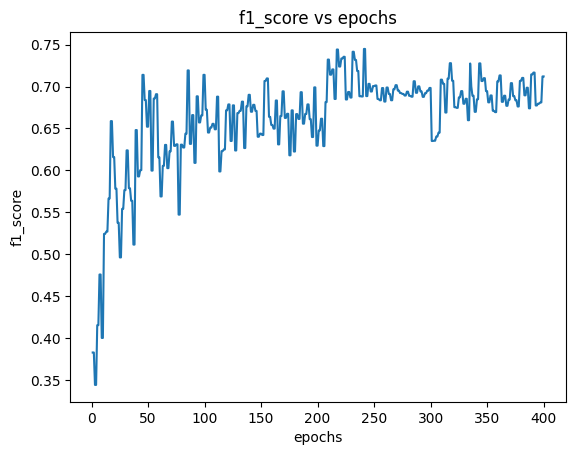

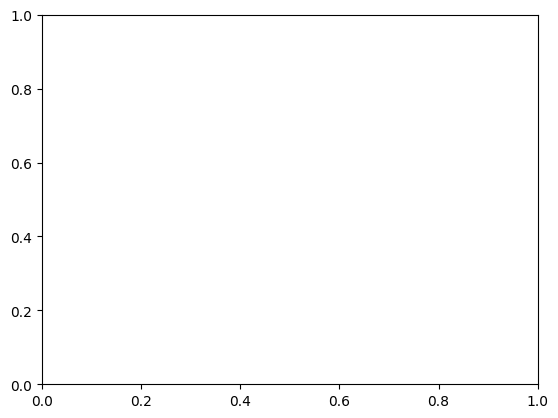

In [7]:
print(model.sigma, model.mean)
k = len(f1_arr)
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,k+1), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
loss_arr_cpu = loss_arr.cpu().detach().numpy()
plt.plot(range(1, k + 1), loss_arr_cpu)
plt.xlabel("epochs")
plt.ylabel("Loss")


plt.figure(3)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,k+1), model_arr)
plt.xlabel("epochs")
plt.ylabel("model_score")
plt.title('model_score vs epochs')

print(max_ms) 

In [ ]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tabulate import tabulate

model.eval()
val_preds, val_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(val_dataloader):
        images, labels = images.to(device), labels.to(device)
            
        # Forward pass
        outputs, kld = model(images)
        outputs = torch.sigmoid(outputs)
        
        # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
        val_preds += outputs.tolist()
        val_labels += labels.tolist()

val_labels = np.array(val_labels)
val_preds = np.array(val_preds)
threshold = 0.5  # set your threshold value here
thresholded_val_preds = np.where(val_preds > threshold, 1, 0)

# Calculate the precision, recall, and AUC score for each label using scikit-learn's functions
metrics_dict = {}
for label in range(num_classes):
    precision, recall, _ = precision_recall_curve(val_labels[label], thresholded_val_preds[label])
    auc = roc_auc_score(val_labels[label], val_preds[label])
    f1 = f1_score(val_labels[label], thresholded_val_preds[label], average='binary', zero_division=1)
    metrics_dict[label] = {'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}
    
# Print the dictionary in tabular format using the tabulate library
headers = ['Label', 'Precision', 'Recall', 'F1', 'AUC']
table = []
for label in range(num_classes):
    row = [label]
    for metric in ['Precision', 'Recall', 'F1', 'AUC']:
        values = metrics_dict[label][metric]
        if values.size > 0:
            value_str = '{:.4f}'.format(values.mean(), values.max())
        else:
            value_str = '0.00'
        row.append(value_str)
    table.append(row)

print(tabulate(table, headers=headers))

In [ ]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True)  # Restart kernel with True flag